In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Fitting a detached eclipsing binary

In this case study, we'll go through the steps required to fit the light curve and radial velocity measurements for the detached eclipsing binary system HD 23642.
This is a bright system that has been fit by many authors ([1](https://arxiv.org/abs/astro-ph/0403444), [2](https://arxiv.org/abs/astro-ph/0409507), [3](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract), [4](https://arxiv.org/abs/1602.01901), and [5](https://arxiv.org/abs/1603.08484) to name a few) so this is a good benchmark for our demonstration.

The light curve that we'll use is from K2 and we'll use the same radial velocity measurements as [David+ (2016)](https://arxiv.org/abs/1602.01901) compiled from [here](https://arxiv.org/abs/astro-ph/0403444) and [here](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract).
We'll use a somewhat simplified model for the eclipses that treats the stars as spherical and ignores the phase curve (we'll model it using a Gaussian process instead of a more physically motivated model).
But, as you'll see, these simplifying assumptions are sufficient for this case of a detached and well behaved system.
Unlike some previous studies, we will fit an eccentric orbit instead of fixing the eccentricity to zero.
This probably isn't really necessary here, but it's useful to demonstrate how you would fit a more eccentric system.
Finally, we model the phase curve and other triends in both the light curve and radial velocities using Gaussian processes.
This will account for unmodeled stellar variability and residual systematics, drifts, and other effects left over from the data reduction procedure.

## Data access

First, let's define some values from the literature that will be useful below.
Here we're taking the period and eclipse time from [David+ (2016)](https://arxiv.org/abs/1602.01901) as initial guesses for these parameters in our fit.
We'll also include the same prior on the flux ratio of the two stars that was computed for the Kepler bandpass by [David+ (2016)](https://arxiv.org/abs/1602.01901).

In [3]:
lit_period = 2.46113408
lit_t0 = 119.522070 + 2457000 - 2454833

# Prior on the flux ratio for Kepler
lit_flux_ratio = (0.354, 0.035)

Then we'll download the Kepler data.
In this case, the pipeline aperture photometry isn't very good (because this star is so bright!) so we'll just download the target pixel file and co-add all the pixels.

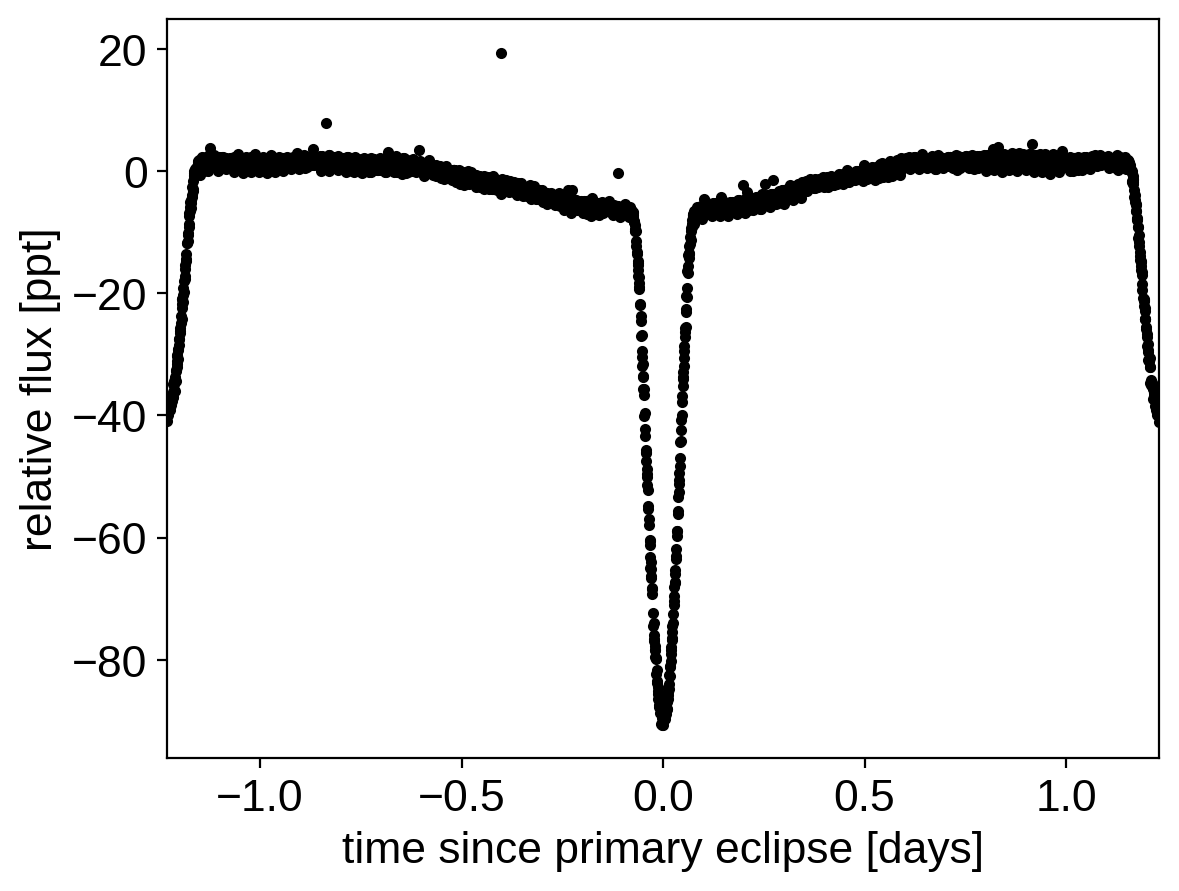

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

tpf = lk.search_targetpixelfile("EPIC 211082420").download()
lc = tpf.to_lightcurve(aperture_mask="all")
lc = lc.remove_nans().normalize()

hdr = tpf.hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

plt.plot((x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period, y, ".k")
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.xlabel("time since primary eclipse [days]")
_ = plt.ylabel("relative flux [ppt]")

Then we'll enter the radial velocity data.
I couldn't find these data online anywhere so I manually transcribed the data from the referenced papers (typos are my own!).

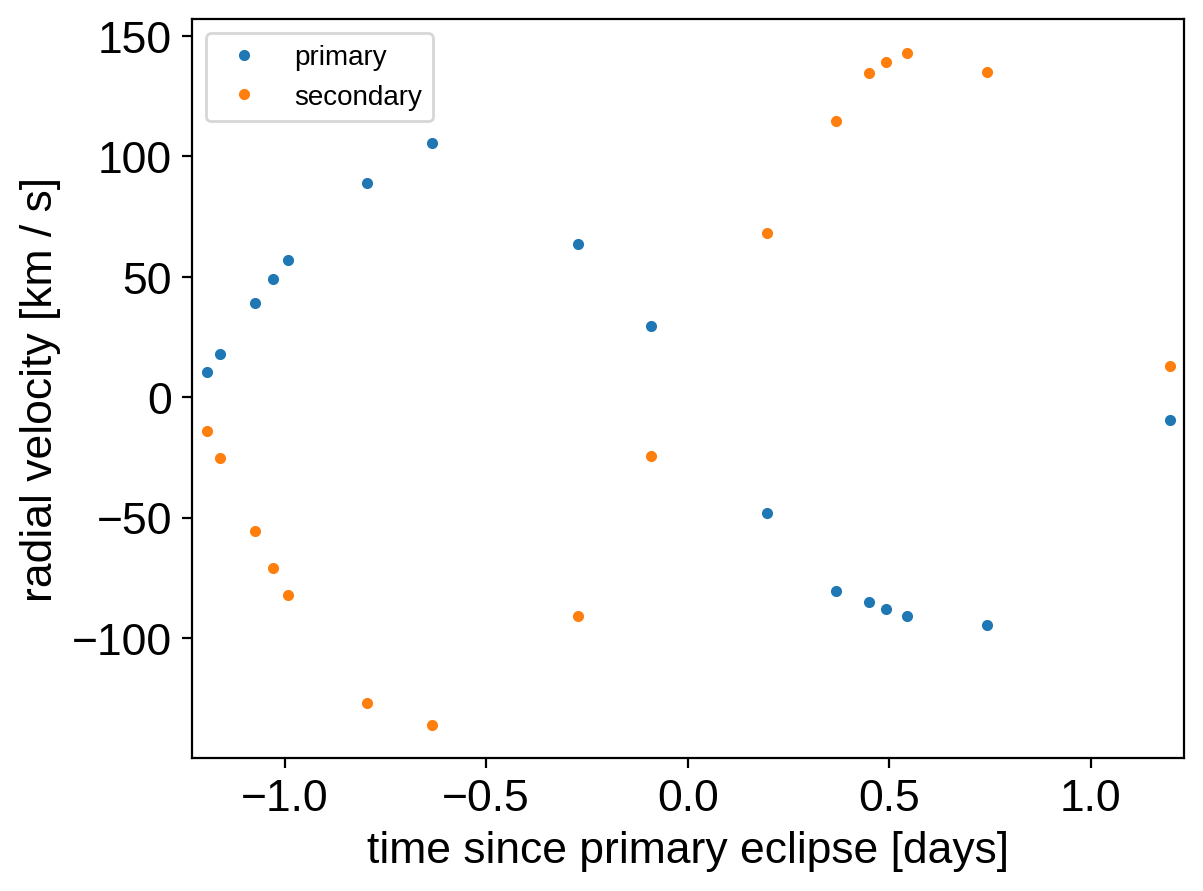

In [5]:
ref1 = 2453000
ref2 = 2400000
rvs = np.array(
    [
        # https://arxiv.org/abs/astro-ph/0403444
        (39.41273 + ref1, -85.0, 134.5),
        (39.45356 + ref1, -88.0, 139.0),
        (39.50548 + ref1, -91.0, 143.0),
        (43.25049 + ref1, 105.5, -136.0),
        (46.25318 + ref1, 29.5, -24.5),
        # https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract
        (52629.6190 + ref2, 88.8, -127.0),
        (52630.6098 + ref2, -48.0, 68.0),
        (52631.6089 + ref2, -9.5, 13.1),
        (52632.6024 + ref2, 63.6, -90.9),
        (52633.6162 + ref2, -94.5, 135.0),
        (52636.6055 + ref2, 10.3, -13.9),
        (52983.6570 + ref2, 18.1, -25.1),
        (52987.6453 + ref2, -80.6, 114.5),
        (52993.6322 + ref2, 49.0, -70.7),
        (53224.9338 + ref2, 39.0, -55.7),
        (53229.9384 + ref2, 57.2, -82.0),
    ]
)
rvs[:, 0] -= 2454833
rvs = rvs[np.argsort(rvs[:, 0])]

x_rv = np.ascontiguousarray(rvs[:, 0], dtype=np.float64)
y1_rv = np.ascontiguousarray(rvs[:, 1], dtype=np.float64)
y2_rv = np.ascontiguousarray(rvs[:, 2], dtype=np.float64)

fold = (rvs[:, 0] - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
plt.plot(fold, rvs[:, 1], ".", label="primary")
plt.plot(fold, rvs[:, 2], ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

## Probabilistic model

Then we define the probabilistic model using PyMC3 and exoplanet.
This is similar to the other tutorials and case studies, but here we're using a :class:`exoplanet.SecondaryEclipseLightCurve` to generate the model light curve and we're modeling the radial velocity trends using a Gaussian process instead of a polynomial.
Otherwise, things should look pretty familiar!

After defining the model, we iteratively clip outliers in the light curve using sigma clipping and then estimate the maximum a posteriori parameters.

In [6]:
import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo


def build_model(mask):

    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=5.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        M1 = pm.Lognormal("M1", mu=0.0, sigma=10.0)
        R1 = pm.Lognormal("R1", mu=0.0, sigma=10.0)

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sigma=10.0)  # radius ratio
        q = pm.Lognormal("q", mu=0.0, sigma=10.0)  # mass ratio
        s = pm.Lognormal("s", mu=np.log(0.5), sigma=10.0)  # surface brightness ratio

        # Prior on flux ratio
        pm.Normal(
            "flux_prior", mu=lit_flux_ratio[0], sigma=lit_flux_ratio[1], observed=k * s
        )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=1.5)
        period = pm.Lognormal("period", mu=np.log(lit_period), sigma=1.0)
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecs = xo.UnitDisk("ecs", testval=np.array([1e-5, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)

        # Noise model for the light curve
        sigma_lc = pm.InverseGamma(
            "sigma_lc", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.1, 2.0)
        )
        S_tot_lc = pm.InverseGamma(
            "S_tot_lc", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        ell_lc = pm.InverseGamma(
            "ell_lc", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_lc = xo.gp.terms.SHOTerm(
            S_tot=S_tot_lc, w0=2 * np.pi / ell_lc, Q=1.0 / 3
        )

        # Noise model for the radial velocities
        sigma_rv1 = pm.InverseGamma(
            "sigma_rv1", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        sigma_rv2 = pm.InverseGamma(
            "sigma_rv2", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        S_tot_rv = pm.InverseGamma(
            "S_tot_rv", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        ell_rv = pm.InverseGamma(
            "ell_rv", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_rv = xo.gp.terms.SHOTerm(
            S_tot=S_tot_rv, w0=2 * np.pi / ell_rv, Q=1.0 / 3
        )

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)

        def model_lc(t):
            return (
                mean_lc
                + 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:, 0]
            )

        # Condition the light curve model on the data
        gp_lc = xo.gp.GP(
            kernel_lc, x[mask], tt.zeros(mask.sum()) ** 2 + sigma_lc ** 2, mean=model_lc
        )
        gp_lc.marginal("obs_lc", observed=y[mask])

        # Set up the radial velocity model
        def model_rv1(t):
            return mean_rv + 1e-3 * orbit.get_radial_velocity(t)

        def model_rv2(t):
            return mean_rv - 1e-3 * orbit.get_radial_velocity(t) / q

        # Condition the radial velocity model on the data
        gp_rv1 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv1 ** 2, mean=model_rv1
        )
        gp_rv1.marginal("obs_rv1", observed=y1_rv)
        gp_rv2 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv2 ** 2, mean=model_rv2
        )
        gp_rv2.marginal("obs_rv2", observed=y2_rv)

        # Optimize the logp
        map_soln = model.test_point

        # First the RV parameters
        map_soln = xo.optimize(map_soln, [mean_rv, q])
        map_soln = xo.optimize(
            map_soln, [mean_rv, sigma_rv1, sigma_rv2, S_tot_rv, ell_rv]
        )

        # Then the LC parameters
        map_soln = xo.optimize(map_soln, [mean_lc, R1, k, s, b])
        map_soln = xo.optimize(map_soln, [mean_lc, R1, k, s, b, u1, u2])
        map_soln = xo.optimize(map_soln, [mean_lc, sigma_lc, S_tot_lc, ell_lc])
        map_soln = xo.optimize(map_soln, [t0, period])

        # Then all the parameters together
        map_soln = xo.optimize(map_soln)

        model.gp_lc = gp_lc
        model.model_lc = model_lc
        model.gp_rv1 = gp_rv1
        model.model_rv1 = model_rv1
        model.gp_rv2 = gp_rv2
        model.model_rv2 = model_rv2

        model.x = x[mask]
        model.y = y[mask]

    return model, map_soln


def sigma_clip():
    mask = np.ones(len(x), dtype=bool)
    num = len(mask)

    for i in range(10):
        model, map_soln = build_model(mask)

        with model:
            mdl = xo.eval_in_model(
                model.model_lc(x[mask]) + model.gp_lc.predict(), map_soln
            )

        resid = y[mask] - mdl
        sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
        mask[mask] = np.abs(resid - np.median(resid)) < 7 * sigma
        print("Sigma clipped {0} light curve points".format(num - mask.sum()))
        if num == mask.sum():
            break
        num = mask.sum()

    return model, map_soln


model, map_soln = sigma_clip()

optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.338058e+04]

1it [00:00, 113.08it/s, logp=-2.338058e+04]

2it [00:00, 167.82it/s, logp=-2.338058e+04]

3it [00:00, 190.66it/s, logp=-1.371193e+04]

4it [00:00, 208.86it/s, logp=-1.492576e+04]

5it [00:00, 224.29it/s, logp=-1.358037e+04]

6it [00:00, 235.36it/s, logp=-1.335577e+04]

7it [00:00, 243.05it/s, logp=-1.309819e+04]

8it [00:00, 249.81it/s, logp=-1.307502e+04]

9it [00:00, 254.80it/s, logp=-1.307285e+04]

10it [00:00, 258.81it/s, logp=-1.307282e+04]

11it [00:00, 254.38it/s, logp=-1.307282e+04]

12it [00:00, 257.47it/s, logp=-1.307282e+04]

13it [00:03,  3.50it/s, logp=-1.307282e+04] 


message: Optimization terminated successfully.
logp: -23380.5842277239 -> -13072.816791759677


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.307282e+04]

1it [00:00, 131.28it/s, logp=-1.307282e+04]

2it [00:00, 186.74it/s, logp=-1.307282e+04]

3it [00:00, 213.84it/s, logp=-1.018327e+04]

4it [00:00, 230.40it/s, logp=-8.904144e+03]

5it [00:00, 244.28it/s, logp=-9.241304e+03]

6it [00:00, 251.96it/s, logp=-8.795387e+03]

7it [00:00, 259.02it/s, logp=-8.676354e+03]

8it [00:00, 264.32it/s, logp=-8.648728e+03]

9it [00:00, 269.37it/s, logp=-8.606024e+03]

10it [00:00, 273.09it/s, logp=-8.554461e+03]

11it [00:00, 275.49it/s, logp=-8.728832e+03]

12it [00:00, 279.22it/s, logp=-8.521916e+03]

13it [00:00, 282.31it/s, logp=-8.640295e+03]

14it [00:00, 285.48it/s, logp=-8.512540e+03]

15it [00:00, 287.58it/s, logp=-8.502406e+03]

16it [00:00, 289.49it/s, logp=-8.491012e+03]

17it [00:00, 291.19it/s, logp=-8.499248e+03]

18it [00:00, 293.31it/s, logp=-8.484668e+03]

19it [00:00, 294.60it/s, logp=-8.483864e+03]

20it [00:00, 295.74it/s, logp=-8.483590e+03]

21it [00:00, 296.57it/s, logp=-8.483526e+03]

22it [00:00, 297.43it/s, logp=-8.483507e+03]

23it [00:00, 298.57it/s, logp=-8.483474e+03]

24it [00:00, 299.42it/s, logp=-8.483431e+03]

25it [00:00, 299.91it/s, logp=-8.483410e+03]

26it [00:00, 300.69it/s, logp=-8.483372e+03]

27it [00:00, 301.28it/s, logp=-8.483300e+03]

28it [00:00, 301.72it/s, logp=-8.483172e+03]

29it [00:00, 302.36it/s, logp=-8.482963e+03]

30it [00:00, 302.84it/s, logp=-8.482725e+03]

31it [00:00, 303.31it/s, logp=-8.482637e+03]

32it [00:00, 311.47it/s, logp=-8.482637e+03]

32it [00:00, 311.47it/s, logp=-8.482584e+03]

33it [00:00, 311.47it/s, logp=-8.482577e+03]

34it [00:00, 311.47it/s, logp=-8.482576e+03]

35it [00:00, 311.47it/s, logp=-8.482576e+03]

36it [00:00, 311.47it/s, logp=-8.482576e+03]

37it [00:00, 311.47it/s, logp=-8.482576e+03]

38it [00:00, 311.47it/s, logp=-8.482576e+03]

39it [00:00, 311.47it/s, logp=-8.482576e+03]

40it [00:00, 120.01it/s, logp=-8.482576e+03]


message: Optimization terminated successfully.
logp: -13072.816791759677 -> -8482.576126912147


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.482576e+03]

1it [00:00, 69.66it/s, logp=-8.482576e+03]

2it [00:00, 101.05it/s, logp=-8.482576e+03]

3it [00:00, 101.53it/s, logp=-5.145584e+05]

4it [00:00, 120.00it/s, logp=-6.505263e+03]

5it [00:00, 132.71it/s, logp=-6.292747e+03]

6it [00:00, 143.55it/s, logp=-8.502956e+03]

7it [00:00, 153.95it/s, logp=-6.278122e+03]

8it [00:00, 162.01it/s, logp=-6.669084e+03]

9it [00:00, 169.54it/s, logp=-6.277575e+03]

10it [00:00, 175.17it/s, logp=-6.276471e+03]

11it [00:00, 180.90it/s, logp=-6.272057e+03]

12it [00:00, 186.06it/s, logp=-6.254494e+03]

13it [00:00, 190.71it/s, logp=-6.185706e+03]

14it [00:00, 194.91it/s, logp=-5.934077e+03]

15it [00:00, 198.34it/s, logp=-5.402332e+03]

16it [00:00, 201.47it/s, logp=-4.739662e+03]

17it [00:00, 204.50it/s, logp=-4.706432e+03]

18it [00:00, 207.14it/s, logp=-4.706090e+03]

19it [00:00, 209.59it/s, logp=-4.705681e+03]

20it [00:00, 211.93it/s, logp=-4.704991e+03]

21it [00:00, 214.15it/s, logp=-4.704003e+03]

22it [00:00, 216.27it/s, logp=-4.702929e+03]

23it [00:00, 224.70it/s, logp=-4.702929e+03]

23it [00:00, 224.70it/s, logp=-4.701202e+03]

24it [00:00, 224.70it/s, logp=-4.699296e+03]

25it [00:00, 224.70it/s, logp=-4.698727e+03]

26it [00:00, 224.70it/s, logp=-4.697899e+03]

27it [00:00, 224.70it/s, logp=-4.697236e+03]

28it [00:00, 224.70it/s, logp=-4.696966e+03]

29it [00:00, 224.70it/s, logp=-4.696770e+03]

30it [00:00, 224.70it/s, logp=-4.696757e+03]

31it [00:00, 224.70it/s, logp=-4.696727e+03]

32it [00:00, 224.70it/s, logp=-4.696703e+03]

33it [00:00, 224.70it/s, logp=-4.696694e+03]

34it [00:00, 224.70it/s, logp=-4.696693e+03]

35it [00:00, 224.70it/s, logp=-4.696693e+03]

36it [00:00, 224.70it/s, logp=-4.696693e+03]

37it [00:00, 224.70it/s, logp=-4.696693e+03]

38it [00:00, 224.70it/s, logp=-4.696693e+03]

39it [00:00, 101.60it/s, logp=-4.696693e+03]


message: Optimization terminated successfully.
logp: -8482.576126912147 -> -4696.693195993793


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.696693e+03]

1it [00:00, 67.88it/s, logp=-4.696693e+03]

2it [00:00, 100.04it/s, logp=-4.696693e+03]

3it [00:00, 118.80it/s, logp=-5.283064e+03]

4it [00:00, 134.98it/s, logp=-4.696633e+03]

5it [00:00, 146.73it/s, logp=-4.696536e+03]

6it [00:00, 157.43it/s, logp=-4.696379e+03]

7it [00:00, 166.22it/s, logp=-4.696082e+03]

8it [00:00, 173.90it/s, logp=-4.696235e+03]

9it [00:00, 180.71it/s, logp=-4.695889e+03]

10it [00:00, 186.04it/s, logp=-4.695537e+03]

11it [00:00, 190.83it/s, logp=-4.694911e+03]

12it [00:00, 195.00it/s, logp=-4.694584e+03]

13it [00:00, 198.50it/s, logp=-4.694137e+03]

14it [00:00, 201.79it/s, logp=-4.695139e+03]

15it [00:00, 205.12it/s, logp=-4.694040e+03]

16it [00:00, 202.15it/s, logp=-4.693916e+03]

17it [00:00, 204.33it/s, logp=-4.693885e+03]

18it [00:00, 206.34it/s, logp=-4.693867e+03]

19it [00:00, 208.52it/s, logp=-4.693837e+03]

20it [00:00, 210.49it/s, logp=-4.693787e+03]

21it [00:00, 212.31it/s, logp=-4.693734e+03]

22it [00:00, 214.00it/s, logp=-4.693708e+03]

23it [00:00, 222.31it/s, logp=-4.693708e+03]

23it [00:00, 222.31it/s, logp=-4.693674e+03]

24it [00:00, 222.31it/s, logp=-4.693682e+03]

25it [00:00, 222.31it/s, logp=-4.693656e+03]

26it [00:00, 222.31it/s, logp=-4.693647e+03]

27it [00:00, 222.31it/s, logp=-4.693642e+03]

28it [00:00, 222.31it/s, logp=-4.693638e+03]

29it [00:00, 222.31it/s, logp=-4.693638e+03]

30it [00:00, 222.31it/s, logp=-4.693637e+03]

31it [00:00, 222.31it/s, logp=-4.693637e+03]

32it [00:00, 222.31it/s, logp=-4.693636e+03]

33it [00:00, 222.31it/s, logp=-4.693636e+03]

34it [00:00, 222.31it/s, logp=-4.693636e+03]

35it [00:00, 222.31it/s, logp=-4.693636e+03]

36it [00:00, 222.31it/s, logp=-4.693636e+03]

37it [00:00, 222.31it/s, logp=-4.693636e+03]

38it [00:00, 222.31it/s, logp=-4.693636e+03]

39it [00:00, 222.31it/s, logp=-4.693636e+03]

40it [00:00, 109.35it/s, logp=-4.693636e+03]


message: Optimization terminated successfully.
logp: -4696.693195993793 -> -4693.636423265372


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.693636e+03]

1it [00:00, 108.93it/s, logp=-4.693636e+03]

2it [00:00, 158.20it/s, logp=-4.693636e+03]

3it [00:00, 182.34it/s, logp=-4.092057e+03]

4it [00:00, 195.95it/s, logp=-4.278894e+03]

5it [00:00, 207.80it/s, logp=-3.864064e+03]

6it [00:00, 214.68it/s, logp=-4.035287e+03]

7it [00:00, 222.07it/s, logp=-3.815480e+03]

8it [00:00, 226.93it/s, logp=-3.732626e+03]

9it [00:00, 230.49it/s, logp=-3.643464e+03]

10it [00:00, 234.07it/s, logp=-3.640438e+03]

11it [00:00, 236.89it/s, logp=-3.640385e+03]

12it [00:00, 239.68it/s, logp=-3.640332e+03]

13it [00:00, 241.88it/s, logp=-3.640328e+03]

14it [00:00, 244.01it/s, logp=-3.640328e+03]

15it [00:00, 245.66it/s, logp=-3.640328e+03]

16it [00:00, 247.51it/s, logp=-3.640328e+03]

17it [00:00, 248.84it/s, logp=-3.640328e+03]

18it [00:00, 250.35it/s, logp=-3.640328e+03]

19it [00:00, 251.41it/s, logp=-3.640328e+03]

20it [00:00, 253.11it/s, logp=-3.640328e+03]

21it [00:00, 254.69it/s, logp=-3.640328e+03]

22it [00:00, 256.16it/s, logp=-3.640328e+03]

23it [00:00, 256.96it/s, logp=-3.640328e+03]

24it [00:00, 258.21it/s, logp=-3.640328e+03]

25it [00:00, 259.34it/s, logp=-3.640328e+03]

26it [00:00, 260.43it/s, logp=-3.640328e+03]

27it [00:00, 269.03it/s, logp=-3.640328e+03]

27it [00:00, 269.03it/s, logp=-3.640328e+03]

28it [00:00, 269.03it/s, logp=-3.640328e+03]

29it [00:00, 269.03it/s, logp=-3.640328e+03]

30it [00:00, 269.03it/s, logp=-3.640328e+03]

31it [00:00, 269.03it/s, logp=-3.640328e+03]

32it [00:00, 269.03it/s, logp=-3.640328e+03]

33it [00:00, 269.03it/s, logp=-3.640328e+03]

34it [00:00, 269.03it/s, logp=-3.640328e+03]

35it [00:00, 269.03it/s, logp=-3.640328e+03]

36it [00:00, 269.03it/s, logp=-3.640328e+03]

37it [00:00, 269.03it/s, logp=-3.640328e+03]

38it [00:00, 269.03it/s, logp=-3.640328e+03]

39it [00:00, 269.03it/s, logp=-3.640328e+03]

40it [00:00, 269.03it/s, logp=-3.640328e+03]

41it [00:00, 269.03it/s, logp=-3.640328e+03]

42it [00:00, 269.03it/s, logp=-3.640328e+03]

43it [00:00, 269.03it/s, logp=-3.640328e+03]

44it [00:00, 269.03it/s, logp=-3.640328e+03]

45it [00:00, 269.03it/s, logp=-3.640328e+03]

46it [00:00, 269.03it/s, logp=-3.640328e+03]

47it [00:00, 269.03it/s, logp=-3.640328e+03]

48it [00:00, 269.03it/s, logp=-3.640328e+03]

49it [00:00, 269.03it/s, logp=-3.640328e+03]

50it [00:00, 269.03it/s, logp=-3.640328e+03]

51it [00:00, 269.03it/s, logp=-3.640328e+03]

52it [00:00, 269.03it/s, logp=-3.640328e+03]

53it [00:00, 269.03it/s, logp=-3.640328e+03]

54it [00:00, 269.03it/s, logp=-3.640328e+03]

55it [00:00, 269.03it/s, logp=-3.640328e+03]

56it [00:00, 273.87it/s, logp=-3.640328e+03]

56it [00:00, 273.87it/s, logp=-3.640328e+03]

57it [00:00, 273.87it/s, logp=-3.640328e+03]

58it [00:00, 273.87it/s, logp=-3.640328e+03]

59it [00:00, 273.87it/s, logp=-3.640328e+03]

60it [00:00, 273.87it/s, logp=-3.640328e+03]

61it [00:00, 273.87it/s, logp=-3.640328e+03]

62it [00:00, 273.87it/s, logp=-3.640328e+03]

63it [00:00, 273.87it/s, logp=-3.640328e+03]

64it [00:00, 273.87it/s, logp=-3.640328e+03]

65it [00:00, 273.87it/s, logp=-3.640328e+03]

66it [00:00, 273.87it/s, logp=-3.640328e+03]

67it [00:00, 273.87it/s, logp=-3.640328e+03]

68it [00:00, 273.87it/s, logp=-3.640328e+03]

69it [00:00, 273.87it/s, logp=-3.640328e+03]

70it [00:00, 273.87it/s, logp=-3.640328e+03]

71it [00:00, 273.87it/s, logp=-3.640328e+03]

72it [00:00, 273.87it/s, logp=-3.640328e+03]

73it [00:00, 273.87it/s, logp=-3.640328e+03]

74it [00:00, 273.87it/s, logp=-3.640328e+03]

75it [00:00, 273.87it/s, logp=-3.640328e+03]

76it [00:00, 273.87it/s, logp=-3.640328e+03]

77it [00:00, 273.87it/s, logp=-3.640328e+03]

78it [00:00, 273.87it/s, logp=-3.640328e+03]

79it [00:00, 273.87it/s, logp=-3.640328e+03]

80it [00:00, 273.87it/s, logp=-3.640328e+03]

81it [00:00, 273.87it/s, logp=-3.640328e+03]

82it [00:00, 273.87it/s, logp=-3.640328e+03]

83it [00:00, 273.87it/s, logp=-3.640328e+03]

84it [00:00, 169.60it/s, logp=-3.640328e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4693.6364232653705 -> -3640.327844208639


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-3.640328e+03]

1it [00:00, 100.34it/s, logp=-3.640328e+03]

2it [00:00, 147.08it/s, logp=-3.640328e+03]

3it [00:00, 177.04it/s, logp=-5.274568e+05]

4it [00:00, 195.18it/s, logp=-7.891077e+05]

5it [00:00, 208.39it/s, logp=-5.073792e+05]

6it [00:00, 218.09it/s, logp=-3.640171e+03]

7it [00:00, 225.40it/s, logp=-3.639206e+03]

8it [00:00, 230.56it/s, logp=-3.637450e+03]

9it [00:00, 234.75it/s, logp=-3.636692e+03]

10it [00:00, 238.88it/s, logp=-3.636692e+03]

11it [00:00, 241.75it/s, logp=-3.636692e+03]

12it [00:00, 245.75it/s, logp=-3.636692e+03]

13it [00:00, 248.51it/s, logp=-3.636692e+03]

14it [00:00, 250.93it/s, logp=-3.636692e+03]

15it [00:00, 253.04it/s, logp=-3.636692e+03]

16it [00:00, 255.03it/s, logp=-3.636692e+03]

17it [00:00, 256.76it/s, logp=-3.636692e+03]

18it [00:00, 258.43it/s, logp=-3.636692e+03]

19it [00:00, 259.83it/s, logp=-3.636692e+03]

20it [00:00, 261.17it/s, logp=-3.636692e+03]

21it [00:00, 262.29it/s, logp=-3.636692e+03]

22it [00:00, 263.38it/s, logp=-3.636692e+03]

23it [00:00, 264.24it/s, logp=-3.636692e+03]

24it [00:00, 264.78it/s, logp=-3.636692e+03]

25it [00:00, 264.97it/s, logp=-3.636692e+03]

26it [00:00, 265.89it/s, logp=-3.636692e+03]

27it [00:00, 266.57it/s, logp=-3.636692e+03]

28it [00:00, 275.00it/s, logp=-3.636692e+03]

28it [00:00, 275.00it/s, logp=-3.636692e+03]

29it [00:00, 275.00it/s, logp=-3.636692e+03]

30it [00:00, 275.00it/s, logp=-3.636692e+03]

31it [00:00, 275.00it/s, logp=-3.636692e+03]

32it [00:00, 275.00it/s, logp=-3.636692e+03]

33it [00:00, 275.00it/s, logp=-3.636692e+03]

34it [00:00, 275.00it/s, logp=-3.636692e+03]

35it [00:00, 275.00it/s, logp=-3.636692e+03]

36it [00:00, 275.00it/s, logp=-3.636692e+03]

37it [00:00, 275.00it/s, logp=-3.636692e+03]

38it [00:00, 275.00it/s, logp=-3.636692e+03]

39it [00:00, 275.00it/s, logp=-3.636692e+03]

40it [00:00, 275.00it/s, logp=-3.636692e+03]

41it [00:00, 275.00it/s, logp=-3.636692e+03]

42it [00:00, 275.00it/s, logp=-3.636692e+03]

43it [00:00, 275.00it/s, logp=-3.636692e+03]

44it [00:00, 275.00it/s, logp=-3.636692e+03]

45it [00:00, 275.00it/s, logp=-3.636692e+03]

46it [00:00, 275.00it/s, logp=-3.636692e+03]

47it [00:00, 275.00it/s, logp=-3.636692e+03]

48it [00:00, 275.00it/s, logp=-3.636692e+03]

49it [00:00, 275.00it/s, logp=-3.636692e+03]

50it [00:00, 275.00it/s, logp=-3.636692e+03]

51it [00:00, 275.00it/s, logp=-3.636692e+03]

52it [00:00, 275.00it/s, logp=-3.636692e+03]

53it [00:00, 275.00it/s, logp=-3.636692e+03]

54it [00:00, 275.00it/s, logp=-3.636692e+03]

55it [00:00, 275.00it/s, logp=-3.636692e+03]

56it [00:00, 275.00it/s, logp=-3.636692e+03]

57it [00:00, 278.95it/s, logp=-3.636692e+03]

57it [00:00, 278.95it/s, logp=-3.636692e+03]

58it [00:00, 278.95it/s, logp=-3.636692e+03]

59it [00:00, 278.95it/s, logp=-3.636692e+03]

60it [00:00, 278.95it/s, logp=-3.636692e+03]

61it [00:00, 278.95it/s, logp=-3.636692e+03]

62it [00:00, 278.95it/s, logp=-3.636692e+03]

63it [00:00, 278.95it/s, logp=-3.636692e+03]

64it [00:00, 278.95it/s, logp=-3.636692e+03]

65it [00:00, 278.95it/s, logp=-3.636692e+03]

66it [00:00, 278.95it/s, logp=-3.636692e+03]

67it [00:00, 278.95it/s, logp=-3.636692e+03]

68it [00:00, 278.95it/s, logp=-3.636692e+03]

69it [00:00, 278.95it/s, logp=-3.636692e+03]

70it [00:00, 278.95it/s, logp=-3.636692e+03]

71it [00:00, 278.95it/s, logp=-3.636692e+03]

72it [00:00, 278.95it/s, logp=-3.636692e+03]

73it [00:00, 278.95it/s, logp=-3.636692e+03]

74it [00:00, 278.95it/s, logp=-3.636692e+03]

75it [00:00, 278.95it/s, logp=-3.636692e+03]

76it [00:00, 278.95it/s, logp=-3.636692e+03]

77it [00:00, 278.95it/s, logp=-3.636692e+03]

78it [00:00, 278.95it/s, logp=-3.636692e+03]

79it [00:00, 278.95it/s, logp=-3.636692e+03]

80it [00:00, 278.95it/s, logp=-3.636692e+03]

81it [00:00, 278.95it/s, logp=-3.636692e+03]

82it [00:00, 278.95it/s, logp=-3.636692e+03]

83it [00:00, 278.95it/s, logp=-3.636692e+03]

84it [00:00, 278.95it/s, logp=-3.636692e+03]

85it [00:00, 278.95it/s, logp=-3.636692e+03]

86it [00:00, 281.00it/s, logp=-3.636692e+03]

86it [00:00, 281.00it/s, logp=-3.636692e+03]

87it [00:00, 281.00it/s, logp=-3.636692e+03]

88it [00:00, 281.00it/s, logp=-3.636692e+03]

89it [00:00, 281.00it/s, logp=-3.636692e+03]

90it [00:00, 281.00it/s, logp=-3.636692e+03]

91it [00:00, 281.00it/s, logp=-3.636692e+03]

92it [00:00, 281.00it/s, logp=-3.636692e+03]

93it [00:00, 281.00it/s, logp=-3.636692e+03]

94it [00:00, 281.00it/s, logp=-3.636692e+03]

95it [00:00, 281.00it/s, logp=-3.636692e+03]

96it [00:00, 281.00it/s, logp=-3.636692e+03]

97it [00:00, 281.00it/s, logp=-3.636692e+03]

98it [00:00, 281.00it/s, logp=-3.636692e+03]

99it [00:00, 281.00it/s, logp=-3.636692e+03]

100it [00:00, 281.00it/s, logp=-3.636692e+03]

101it [00:00, 181.65it/s, logp=-3.636692e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -3640.3278442086394 -> -3636.6924367320316


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-3.636692e+03]

1it [00:00, 84.94it/s, logp=-3.636692e+03]

2it [00:00, 120.49it/s, logp=-3.636692e+03]

3it [00:00, 138.55it/s, logp=-2.915042e+05]

4it [00:00, 152.23it/s, logp=-1.335909e+04]

5it [00:00, 161.61it/s, logp=-3.634394e+03]

6it [00:00, 165.63it/s, logp=-3.777980e+03]

7it [00:00, 171.55it/s, logp=-3.634358e+03]

8it [00:00, 175.23it/s, logp=-3.634289e+03]

9it [00:00, 179.21it/s, logp=-3.634067e+03]

10it [00:00, 181.73it/s, logp=-3.633489e+03]

11it [00:00, 184.68it/s, logp=-3.631347e+03]

12it [00:00, 186.15it/s, logp=-3.628394e+03]

13it [00:00, 184.55it/s, logp=-3.760906e+03]

14it [00:00, 186.42it/s, logp=-3.628330e+03]

15it [00:00, 187.60it/s, logp=-3.628202e+03]

16it [00:00, 189.16it/s, logp=-3.627706e+03]

17it [00:00, 190.59it/s, logp=-3.625982e+03]

18it [00:00, 191.39it/s, logp=-3.622986e+03]

19it [00:00, 190.37it/s, logp=-3.617149e+03]

20it [00:00, 199.31it/s, logp=-3.617149e+03]

20it [00:00, 199.31it/s, logp=-3.618836e+03]

21it [00:00, 199.31it/s, logp=-3.612927e+03]

22it [00:00, 199.31it/s, logp=-3.611501e+03]

23it [00:00, 199.31it/s, logp=-3.609031e+03]

24it [00:00, 199.31it/s, logp=-3.605823e+03]

25it [00:00, 199.31it/s, logp=-3.609398e+03]

26it [00:00, 199.31it/s, logp=-3.604501e+03]

27it [00:00, 199.31it/s, logp=-3.604550e+03]

28it [00:00, 199.31it/s, logp=-3.603843e+03]

29it [00:00, 199.31it/s, logp=-3.602738e+03]

30it [00:00, 199.31it/s, logp=-3.601175e+03]

31it [00:00, 199.31it/s, logp=-3.599156e+03]

32it [00:00, 199.31it/s, logp=-3.605867e+03]

33it [00:00, 199.31it/s, logp=-3.598717e+03]

34it [00:00, 199.31it/s, logp=-3.598006e+03]

35it [00:00, 199.31it/s, logp=-3.597225e+03]

36it [00:00, 199.31it/s, logp=-3.596532e+03]

37it [00:00, 199.31it/s, logp=-3.595946e+03]

38it [00:00, 199.31it/s, logp=-3.595518e+03]

39it [00:00, 199.31it/s, logp=-3.594834e+03]

40it [00:00, 199.31it/s, logp=-3.593803e+03]

41it [00:00, 200.93it/s, logp=-3.593803e+03]

41it [00:00, 200.93it/s, logp=-3.592686e+03]

42it [00:00, 200.93it/s, logp=-3.592029e+03]

43it [00:00, 200.93it/s, logp=-3.590953e+03]

44it [00:00, 200.93it/s, logp=-3.589082e+03]

45it [00:00, 200.93it/s, logp=-3.586234e+03]

46it [00:00, 200.93it/s, logp=-3.581845e+03]

47it [00:00, 200.93it/s, logp=-3.574545e+03]

48it [00:00, 200.93it/s, logp=-3.590827e+03]

49it [00:00, 200.93it/s, logp=-3.570708e+03]

50it [00:00, 200.93it/s, logp=-3.564613e+03]

51it [00:00, 200.93it/s, logp=-3.557202e+03]

52it [00:00, 200.93it/s, logp=-3.564908e+03]

53it [00:00, 200.93it/s, logp=-3.554500e+03]

54it [00:00, 200.93it/s, logp=-3.551129e+03]

55it [00:00, 200.93it/s, logp=-3.553428e+03]

56it [00:00, 200.93it/s, logp=-3.549746e+03]

57it [00:00, 200.93it/s, logp=-3.548431e+03]

58it [00:00, 200.93it/s, logp=-3.547047e+03]

59it [00:00, 200.93it/s, logp=-3.545729e+03]

60it [00:00, 200.93it/s, logp=-3.544137e+03]

61it [00:00, 199.77it/s, logp=-3.544137e+03]

61it [00:00, 199.77it/s, logp=-3.543582e+03]

62it [00:00, 199.77it/s, logp=-3.543139e+03]

63it [00:00, 199.77it/s, logp=-3.542843e+03]

64it [00:00, 199.77it/s, logp=-3.542494e+03]

65it [00:00, 199.77it/s, logp=-3.542770e+03]

66it [00:00, 199.77it/s, logp=-3.542186e+03]

67it [00:00, 199.77it/s, logp=-3.542117e+03]

68it [00:00, 199.77it/s, logp=-3.542009e+03]

69it [00:00, 199.77it/s, logp=-3.542051e+03]

70it [00:00, 199.77it/s, logp=-3.541932e+03]

71it [00:00, 199.77it/s, logp=-3.541866e+03]

72it [00:00, 199.77it/s, logp=-3.541770e+03]

73it [00:00, 199.77it/s, logp=-3.541600e+03]

74it [00:00, 199.77it/s, logp=-3.541353e+03]

75it [00:00, 199.77it/s, logp=-3.541220e+03]

76it [00:00, 199.77it/s, logp=-3.541019e+03]

77it [00:00, 199.77it/s, logp=-3.540742e+03]

78it [00:00, 199.77it/s, logp=-3.540528e+03]

79it [00:00, 199.77it/s, logp=-3.540505e+03]

80it [00:00, 195.10it/s, logp=-3.540505e+03]

80it [00:00, 195.10it/s, logp=-3.540399e+03]

81it [00:00, 195.10it/s, logp=-3.540236e+03]

82it [00:00, 195.10it/s, logp=-3.540089e+03]

83it [00:00, 195.10it/s, logp=-3.540046e+03]

84it [00:00, 195.10it/s, logp=-3.539984e+03]

85it [00:00, 195.10it/s, logp=-3.539933e+03]

86it [00:00, 195.10it/s, logp=-3.539901e+03]

87it [00:00, 195.10it/s, logp=-3.539855e+03]

88it [00:00, 195.10it/s, logp=-3.539808e+03]

89it [00:00, 195.10it/s, logp=-3.539779e+03]

90it [00:00, 195.10it/s, logp=-3.539764e+03]

91it [00:00, 195.10it/s, logp=-3.539759e+03]

92it [00:00, 195.10it/s, logp=-3.539750e+03]

93it [00:00, 195.10it/s, logp=-3.539735e+03]

94it [00:00, 195.10it/s, logp=-3.539712e+03]

95it [00:00, 195.10it/s, logp=-3.539697e+03]

96it [00:00, 195.10it/s, logp=-3.539694e+03]

97it [00:00, 195.10it/s, logp=-3.539692e+03]

98it [00:00, 195.10it/s, logp=-3.539692e+03]

99it [00:00, 195.10it/s, logp=-3.539691e+03]

100it [00:00, 195.10it/s, logp=-3.539691e+03]

101it [00:00, 196.95it/s, logp=-3.539691e+03]

101it [00:00, 196.95it/s, logp=-3.539691e+03]

102it [00:00, 196.95it/s, logp=-3.539691e+03]

103it [00:00, 196.95it/s, logp=-3.539691e+03]

104it [00:00, 196.95it/s, logp=-3.539691e+03]

105it [00:00, 196.95it/s, logp=-3.539691e+03]

106it [00:00, 196.95it/s, logp=-3.539691e+03]

107it [00:00, 196.95it/s, logp=-3.539690e+03]

108it [00:00, 196.95it/s, logp=-3.539690e+03]

109it [00:00, 196.95it/s, logp=-3.539690e+03]

110it [00:00, 196.95it/s, logp=-3.539690e+03]

111it [00:00, 196.95it/s, logp=-3.539690e+03]

112it [00:00, 196.95it/s, logp=-3.539690e+03]

113it [00:00, 196.95it/s, logp=-3.539690e+03]

114it [00:00, 196.95it/s, logp=-3.539690e+03]

115it [00:00, 196.95it/s, logp=-3.539690e+03]

116it [00:00, 196.95it/s, logp=-3.539690e+03]

117it [00:00, 196.95it/s, logp=-3.539690e+03]

118it [00:00, 196.95it/s, logp=-3.539690e+03]

119it [00:00, 196.95it/s, logp=-3.539690e+03]

120it [00:00, 196.95it/s, logp=-3.539690e+03]

121it [00:00, 196.95it/s, logp=-3.539690e+03]

122it [00:00, 196.95it/s, logp=-3.539690e+03]

123it [00:00, 201.06it/s, logp=-3.539690e+03]

123it [00:00, 201.06it/s, logp=-3.539690e+03]

124it [00:00, 201.06it/s, logp=-3.539690e+03]

125it [00:00, 201.06it/s, logp=-3.539690e+03]

126it [00:00, 201.06it/s, logp=-3.539690e+03]

127it [00:00, 201.06it/s, logp=-3.539690e+03]

128it [00:00, 201.06it/s, logp=-3.539690e+03]

129it [00:00, 201.06it/s, logp=-3.539690e+03]

130it [00:00, 201.06it/s, logp=-3.539690e+03]

131it [00:00, 201.06it/s, logp=-3.539690e+03]

132it [00:00, 201.06it/s, logp=-3.539690e+03]

133it [00:00, 201.06it/s, logp=-3.539690e+03]

134it [00:00, 201.06it/s, logp=-3.539690e+03]

135it [00:00, 201.06it/s, logp=-3.539690e+03]

136it [00:00, 201.06it/s, logp=-3.539690e+03]

137it [00:00, 201.06it/s, logp=-3.539690e+03]

138it [00:00, 201.06it/s, logp=-3.539690e+03]

139it [00:00, 201.06it/s, logp=-3.539690e+03]

140it [00:00, 201.06it/s, logp=-3.539690e+03]

141it [00:00, 201.06it/s, logp=-3.539690e+03]

142it [00:00, 201.06it/s, logp=-3.539690e+03]

143it [00:00, 201.06it/s, logp=-3.539690e+03]

144it [00:00, 201.06it/s, logp=-3.539690e+03]

145it [00:00, 206.01it/s, logp=-3.539690e+03]

145it [00:00, 206.01it/s, logp=-3.539690e+03]

146it [00:00, 206.01it/s, logp=-3.539690e+03]

147it [00:00, 206.01it/s, logp=-3.539690e+03]

148it [00:00, 206.01it/s, logp=-3.539690e+03]

149it [00:00, 206.01it/s, logp=-3.539690e+03]

150it [00:00, 206.01it/s, logp=-3.539690e+03]

151it [00:00, 206.01it/s, logp=-3.539690e+03]

152it [00:00, 206.01it/s, logp=-3.539690e+03]

153it [00:00, 206.01it/s, logp=-3.539690e+03]

154it [00:00, 206.01it/s, logp=-3.539690e+03]

155it [00:00, 206.01it/s, logp=-3.539690e+03]

156it [00:00, 206.01it/s, logp=-3.539690e+03]

157it [00:00, 206.01it/s, logp=-3.539690e+03]

158it [00:00, 206.01it/s, logp=-3.539690e+03]

159it [00:00, 206.01it/s, logp=-3.539690e+03]

160it [00:00, 206.01it/s, logp=-3.539690e+03]

161it [00:00, 206.01it/s, logp=-3.539690e+03]

162it [00:00, 206.01it/s, logp=-3.539690e+03]

163it [00:00, 206.01it/s, logp=-3.539690e+03]

164it [00:00, 206.01it/s, logp=-3.539690e+03]

165it [00:00, 206.01it/s, logp=-3.539690e+03]

166it [00:00, 206.01it/s, logp=-3.539690e+03]

167it [00:00, 209.40it/s, logp=-3.539690e+03]

167it [00:00, 209.40it/s, logp=-3.539690e+03]

168it [00:00, 209.40it/s, logp=-3.539690e+03]

169it [00:00, 209.40it/s, logp=-3.539690e+03]

170it [00:00, 209.40it/s, logp=-3.539690e+03]

171it [00:01, 161.45it/s, logp=-3.539690e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -3636.6924367320316 -> -3539.689989722382


Sigma clipped 34 light curve points


optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.296524e+04]

1it [00:00, 128.18it/s, logp=-2.296524e+04]

2it [00:00, 180.50it/s, logp=-2.296524e+04]

3it [00:00, 204.62it/s, logp=-1.333722e+04]

4it [00:00, 222.26it/s, logp=-1.455397e+04]

5it [00:00, 236.55it/s, logp=-1.320793e+04]

6it [00:00, 243.60it/s, logp=-1.298730e+04]

7it [00:00, 251.63it/s, logp=-1.273541e+04]

8it [00:00, 257.68it/s, logp=-1.271302e+04]

9it [00:00, 261.83it/s, logp=-1.271097e+04]

10it [00:00, 264.58it/s, logp=-1.271094e+04]

11it [00:00, 267.91it/s, logp=-1.271094e+04]

12it [00:00, 271.12it/s, logp=-1.271094e+04]

13it [00:00, 57.96it/s, logp=-1.271094e+04] 


message: Optimization terminated successfully.
logp: -22965.237266602366 -> -12710.941974601861


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.271094e+04]

1it [00:00, 90.61it/s, logp=-1.271094e+04]

2it [00:00, 128.41it/s, logp=-1.271094e+04]

3it [00:00, 145.22it/s, logp=-9.834681e+03]

4it [00:00, 162.48it/s, logp=-8.569747e+03]

5it [00:00, 173.69it/s, logp=-8.906056e+03]

6it [00:00, 186.65it/s, logp=-8.455838e+03]

7it [00:00, 196.48it/s, logp=-8.333622e+03]

8it [00:00, 204.96it/s, logp=-8.307411e+03]

9it [00:00, 211.94it/s, logp=-8.266064e+03]

10it [00:00, 217.95it/s, logp=-8.210169e+03]

11it [00:00, 223.19it/s, logp=-8.683512e+03]

12it [00:00, 228.57it/s, logp=-8.181864e+03]

13it [00:00, 232.71it/s, logp=-8.290542e+03]

14it [00:00, 237.02it/s, logp=-8.171624e+03]

15it [00:00, 239.46it/s, logp=-8.161579e+03]

16it [00:00, 242.67it/s, logp=-8.150758e+03]

17it [00:00, 245.26it/s, logp=-8.156182e+03]

18it [00:00, 248.23it/s, logp=-8.144184e+03]

19it [00:00, 250.42it/s, logp=-8.143264e+03]

20it [00:00, 252.42it/s, logp=-8.142909e+03]

21it [00:00, 254.27it/s, logp=-8.142839e+03]

22it [00:00, 256.12it/s, logp=-8.142813e+03]

23it [00:00, 257.89it/s, logp=-8.142774e+03]

24it [00:00, 259.57it/s, logp=-8.142746e+03]

25it [00:00, 261.10it/s, logp=-8.142727e+03]

26it [00:00, 262.02it/s, logp=-8.142691e+03]

27it [00:00, 263.59it/s, logp=-8.142627e+03]

28it [00:00, 271.83it/s, logp=-8.142627e+03]

28it [00:00, 271.83it/s, logp=-8.142511e+03]

29it [00:00, 271.83it/s, logp=-8.142321e+03]

30it [00:00, 271.83it/s, logp=-8.142082e+03]

31it [00:00, 271.83it/s, logp=-8.141985e+03]

32it [00:00, 271.83it/s, logp=-8.141917e+03]

33it [00:00, 271.83it/s, logp=-8.141908e+03]

34it [00:00, 271.83it/s, logp=-8.141907e+03]

35it [00:00, 271.83it/s, logp=-8.141907e+03]

36it [00:00, 271.83it/s, logp=-8.141907e+03]

37it [00:00, 271.83it/s, logp=-8.141907e+03]

38it [00:00, 271.83it/s, logp=-8.141907e+03]

39it [00:00, 271.83it/s, logp=-8.141907e+03]

40it [00:00, 120.88it/s, logp=-8.141907e+03]


message: Optimization terminated successfully.
logp: -12710.941974601868 -> -8141.907237100719


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.141907e+03]

1it [00:00, 124.82it/s, logp=-8.141907e+03]

2it [00:00, 174.63it/s, logp=-8.141907e+03]

3it [00:00, 159.32it/s, logp=-5.069719e+05]

4it [00:00, 176.51it/s, logp=-6.153294e+03]

5it [00:00, 178.24it/s, logp=-5.979543e+03]

6it [00:00, 187.32it/s, logp=-7.557231e+03]

7it [00:00, 194.69it/s, logp=-5.965735e+03]

8it [00:00, 201.38it/s, logp=-6.120998e+03]

9it [00:00, 207.89it/s, logp=-5.964647e+03]

10it [00:00, 212.65it/s, logp=-5.962450e+03]

11it [00:00, 216.10it/s, logp=-5.953683e+03]

12it [00:00, 220.11it/s, logp=-5.918985e+03]

13it [00:00, 223.46it/s, logp=-5.786062e+03]

14it [00:00, 226.77it/s, logp=-5.349184e+03]

15it [00:00, 229.03it/s, logp=-4.669584e+03]

16it [00:00, 231.31it/s, logp=-4.386388e+03]

17it [00:00, 233.05it/s, logp=-4.379020e+03]

18it [00:00, 234.72it/s, logp=-4.378801e+03]

19it [00:00, 236.44it/s, logp=-4.378373e+03]

20it [00:00, 238.37it/s, logp=-4.376947e+03]

21it [00:00, 239.91it/s, logp=-4.374671e+03]

22it [00:00, 240.21it/s, logp=-4.372997e+03]

23it [00:00, 241.29it/s, logp=-4.371559e+03]

24it [00:00, 242.28it/s, logp=-4.371496e+03]

25it [00:00, 243.60it/s, logp=-4.371281e+03]

26it [00:00, 251.53it/s, logp=-4.371281e+03]

26it [00:00, 251.53it/s, logp=-4.370824e+03]

27it [00:00, 251.53it/s, logp=-4.370145e+03]

28it [00:00, 251.53it/s, logp=-4.369629e+03]

29it [00:00, 251.53it/s, logp=-4.370238e+03]

30it [00:00, 251.53it/s, logp=-4.369516e+03]

31it [00:00, 251.53it/s, logp=-4.369415e+03]

32it [00:00, 251.53it/s, logp=-4.369356e+03]

33it [00:00, 251.53it/s, logp=-4.369333e+03]

34it [00:00, 251.53it/s, logp=-4.369325e+03]

35it [00:00, 251.53it/s, logp=-4.369324e+03]

36it [00:00, 251.53it/s, logp=-4.369324e+03]

37it [00:00, 251.53it/s, logp=-4.369324e+03]

38it [00:00, 251.53it/s, logp=-4.369324e+03]

39it [00:00, 251.53it/s, logp=-4.369324e+03]

40it [00:00, 251.53it/s, logp=-4.369324e+03]

41it [00:00, 251.53it/s, logp=-4.369324e+03]

42it [00:00, 114.70it/s, logp=-4.369324e+03]


message: Optimization terminated successfully.
logp: -8141.907237100712 -> -4369.324119375993


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.369324e+03]

1it [00:00, 109.28it/s, logp=-4.369324e+03]

2it [00:00, 154.55it/s, logp=-4.369324e+03]

3it [00:00, 175.88it/s, logp=-4.942133e+03]

4it [00:00, 191.92it/s, logp=-4.369255e+03]

5it [00:00, 191.89it/s, logp=-4.369144e+03]

6it [00:00, 198.66it/s, logp=-4.368964e+03]

7it [00:00, 205.33it/s, logp=-4.368624e+03]

8it [00:00, 210.25it/s, logp=-4.369133e+03]

9it [00:00, 215.45it/s, logp=-4.368439e+03]

10it [00:00, 218.71it/s, logp=-4.368099e+03]

11it [00:00, 221.53it/s, logp=-4.367489e+03]

12it [00:00, 224.18it/s, logp=-4.367213e+03]

13it [00:00, 225.92it/s, logp=-4.366782e+03]

14it [00:00, 226.85it/s, logp=-4.367163e+03]

15it [00:00, 228.97it/s, logp=-4.366634e+03]

16it [00:00, 230.75it/s, logp=-4.366438e+03]

17it [00:00, 231.90it/s, logp=-4.366391e+03]

18it [00:00, 233.10it/s, logp=-4.366378e+03]

19it [00:00, 234.05it/s, logp=-4.366357e+03]

20it [00:00, 235.19it/s, logp=-4.366324e+03]

21it [00:00, 236.38it/s, logp=-4.366282e+03]

22it [00:00, 237.09it/s, logp=-4.366253e+03]

23it [00:00, 237.94it/s, logp=-4.366219e+03]

24it [00:00, 238.54it/s, logp=-4.366214e+03]

25it [00:00, 246.93it/s, logp=-4.366214e+03]

25it [00:00, 246.93it/s, logp=-4.366205e+03]

26it [00:00, 246.93it/s, logp=-4.366194e+03]

27it [00:00, 246.93it/s, logp=-4.366190e+03]

28it [00:00, 246.93it/s, logp=-4.366188e+03]

29it [00:00, 246.93it/s, logp=-4.366187e+03]

30it [00:00, 246.93it/s, logp=-4.366187e+03]

31it [00:00, 246.93it/s, logp=-4.366186e+03]

32it [00:00, 246.93it/s, logp=-4.366186e+03]

33it [00:00, 246.93it/s, logp=-4.366186e+03]

34it [00:00, 246.93it/s, logp=-4.366186e+03]

35it [00:00, 246.93it/s, logp=-4.366186e+03]

36it [00:00, 246.93it/s, logp=-4.366186e+03]

37it [00:00, 246.93it/s, logp=-4.366186e+03]

38it [00:00, 246.93it/s, logp=-4.366186e+03]

39it [00:00, 246.93it/s, logp=-4.366186e+03]

40it [00:00, 246.93it/s, logp=-4.366186e+03]

41it [00:00, 246.93it/s, logp=-4.366186e+03]

42it [00:00, 108.16it/s, logp=-4.366186e+03]


message: Optimization terminated successfully.
logp: -4369.324119375993 -> -4366.186197582646


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.366186e+03]

1it [00:00, 122.68it/s, logp=-4.366186e+03]

2it [00:00, 167.67it/s, logp=-4.366186e+03]

3it [00:00, 189.17it/s, logp=-2.298874e+03]

4it [00:00, 194.39it/s, logp=-1.534654e+04]

5it [00:00, 204.29it/s, logp=-2.307687e+03]

6it [00:00, 212.29it/s, logp=-2.201004e+03]

7it [00:00, 209.97it/s, logp=-2.216851e+03]

8it [00:00, 215.86it/s, logp=-2.168304e+03]

9it [00:00, 219.78it/s, logp=-2.104553e+03]

10it [00:00, 221.31it/s, logp=-1.901044e+03]

11it [00:00, 224.64it/s, logp=-1.813082e+03]

12it [00:00, 227.52it/s, logp=-1.800929e+03]

13it [00:00, 229.95it/s, logp=-1.794046e+03]

14it [00:00, 232.19it/s, logp=-1.789941e+03]

15it [00:00, 230.33it/s, logp=-1.789877e+03]

16it [00:00, 230.61it/s, logp=-1.789877e+03]

17it [00:00, 231.74it/s, logp=-1.789877e+03]

18it [00:00, 233.68it/s, logp=-1.789877e+03]

19it [00:00, 235.28it/s, logp=-1.789877e+03]

20it [00:00, 236.77it/s, logp=-1.789877e+03]

21it [00:00, 238.47it/s, logp=-1.789877e+03]

22it [00:00, 239.63it/s, logp=-1.789877e+03]

23it [00:00, 84.91it/s, logp=-1.789877e+03] 


message: Optimization terminated successfully.
logp: -4366.186197582645 -> -1789.876738524621


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.789877e+03]

1it [00:00, 122.08it/s, logp=-1.789877e+03]

2it [00:00, 168.02it/s, logp=-1.789877e+03]

3it [00:00, 158.66it/s, logp=-1.058612e+06]

4it [00:00, 156.95it/s, logp=-1.659315e+06]

5it [00:00, 158.46it/s, logp=-5.638296e+03]

6it [00:00, 165.51it/s, logp=-1.789724e+03]

7it [00:00, 170.34it/s, logp=-1.789420e+03]

8it [00:00, 178.26it/s, logp=-1.788302e+03]

9it [00:00, 185.46it/s, logp=-1.786008e+03]

10it [00:00, 190.84it/s, logp=-1.784739e+03]

11it [00:00, 196.68it/s, logp=-1.784739e+03]

12it [00:00, 200.96it/s, logp=-1.784739e+03]

13it [00:00, 205.42it/s, logp=-1.784739e+03]

14it [00:00, 209.54it/s, logp=-1.784739e+03]

15it [00:00, 213.20it/s, logp=-1.784739e+03]

16it [00:00, 216.85it/s, logp=-1.784739e+03]

17it [00:00, 220.07it/s, logp=-1.784739e+03]

18it [00:00, 223.06it/s, logp=-1.784739e+03]

19it [00:00, 225.48it/s, logp=-1.784739e+03]

20it [00:00, 228.03it/s, logp=-1.784739e+03]

21it [00:00, 230.52it/s, logp=-1.784739e+03]

22it [00:00, 231.22it/s, logp=-1.784739e+03]

23it [00:00, 233.39it/s, logp=-1.784739e+03]

24it [00:00, 235.28it/s, logp=-1.784739e+03]

25it [00:00, 243.53it/s, logp=-1.784739e+03]

25it [00:00, 243.53it/s, logp=-1.784739e+03]

26it [00:00, 243.53it/s, logp=-1.784739e+03]

27it [00:00, 243.53it/s, logp=-1.784739e+03]

28it [00:00, 243.53it/s, logp=-1.784739e+03]

29it [00:00, 243.53it/s, logp=-1.784739e+03]

30it [00:00, 243.53it/s, logp=-1.784739e+03]

31it [00:00, 243.53it/s, logp=-1.784739e+03]

32it [00:00, 243.53it/s, logp=-1.784739e+03]

33it [00:00, 243.53it/s, logp=-1.784739e+03]

34it [00:00, 243.53it/s, logp=-1.784739e+03]

35it [00:00, 243.53it/s, logp=-1.784739e+03]

36it [00:00, 243.53it/s, logp=-1.784739e+03]

37it [00:00, 243.53it/s, logp=-1.784739e+03]

38it [00:00, 243.53it/s, logp=-1.784739e+03]

39it [00:00, 243.53it/s, logp=-1.784739e+03]

40it [00:00, 243.53it/s, logp=-1.784739e+03]

41it [00:00, 243.53it/s, logp=-1.784739e+03]

42it [00:00, 243.53it/s, logp=-1.784739e+03]

43it [00:00, 243.53it/s, logp=-1.784739e+03]

44it [00:00, 243.53it/s, logp=-1.784739e+03]

45it [00:00, 243.53it/s, logp=-1.784739e+03]

46it [00:00, 243.53it/s, logp=-1.784739e+03]

47it [00:00, 243.53it/s, logp=-1.784739e+03]

48it [00:00, 243.53it/s, logp=-1.784739e+03]

49it [00:00, 243.53it/s, logp=-1.784739e+03]

50it [00:00, 245.05it/s, logp=-1.784739e+03]

50it [00:00, 245.05it/s, logp=-1.784739e+03]

51it [00:00, 245.05it/s, logp=-1.784739e+03]

52it [00:00, 245.05it/s, logp=-1.784739e+03]

53it [00:00, 245.05it/s, logp=-1.784739e+03]

54it [00:00, 245.05it/s, logp=-1.784739e+03]

55it [00:00, 245.05it/s, logp=-1.784739e+03]

56it [00:00, 245.05it/s, logp=-1.784739e+03]

57it [00:00, 245.05it/s, logp=-1.784739e+03]

58it [00:00, 245.05it/s, logp=-1.784739e+03]

59it [00:00, 245.05it/s, logp=-1.784739e+03]

60it [00:00, 245.05it/s, logp=-1.784739e+03]

61it [00:00, 245.05it/s, logp=-1.784739e+03]

62it [00:00, 245.05it/s, logp=-1.784739e+03]

63it [00:00, 245.05it/s, logp=-1.784739e+03]

64it [00:00, 245.05it/s, logp=-1.784739e+03]

65it [00:00, 245.05it/s, logp=-1.784739e+03]

66it [00:00, 245.05it/s, logp=-1.784739e+03]

67it [00:00, 245.05it/s, logp=-1.784739e+03]

68it [00:00, 245.05it/s, logp=-1.784739e+03]

69it [00:00, 245.05it/s, logp=-1.784739e+03]

70it [00:00, 245.05it/s, logp=-1.784739e+03]

71it [00:00, 245.05it/s, logp=-1.784739e+03]

72it [00:00, 245.05it/s, logp=-1.784739e+03]

73it [00:00, 245.05it/s, logp=-1.784739e+03]

74it [00:00, 245.05it/s, logp=-1.784739e+03]

75it [00:00, 245.05it/s, logp=-1.784739e+03]

76it [00:00, 245.05it/s, logp=-1.784739e+03]

77it [00:00, 245.05it/s, logp=-1.784739e+03]

78it [00:00, 245.05it/s, logp=-1.784739e+03]

79it [00:00, 255.07it/s, logp=-1.784739e+03]

79it [00:00, 255.07it/s, logp=-1.784739e+03]

80it [00:00, 255.07it/s, logp=-1.784739e+03]

81it [00:00, 255.07it/s, logp=-1.784739e+03]

82it [00:00, 255.07it/s, logp=-1.784739e+03]

83it [00:00, 255.07it/s, logp=-1.784739e+03]

84it [00:00, 255.07it/s, logp=-1.784739e+03]

85it [00:00, 255.07it/s, logp=-1.784739e+03]

86it [00:00, 255.07it/s, logp=-1.784739e+03]

87it [00:00, 255.07it/s, logp=-1.784739e+03]

88it [00:00, 255.07it/s, logp=-1.784739e+03]

89it [00:00, 255.07it/s, logp=-1.784739e+03]

90it [00:00, 255.07it/s, logp=-1.784739e+03]

91it [00:00, 255.07it/s, logp=-1.784739e+03]

92it [00:00, 255.07it/s, logp=-1.784739e+03]

93it [00:00, 255.07it/s, logp=-1.784739e+03]

94it [00:00, 255.07it/s, logp=-1.784739e+03]

95it [00:00, 255.07it/s, logp=-1.784739e+03]

96it [00:00, 255.07it/s, logp=-1.784739e+03]

97it [00:00, 255.07it/s, logp=-1.784739e+03]

98it [00:00, 255.07it/s, logp=-1.784739e+03]

99it [00:00, 255.07it/s, logp=-1.784739e+03]

100it [00:00, 239.30it/s, logp=-1.784739e+03]

100it [00:00, 239.30it/s, logp=-1.784739e+03]

101it [00:00, 239.30it/s, logp=-1.784739e+03]

102it [00:00, 239.30it/s, logp=-1.784739e+03]

103it [00:00, 239.30it/s, logp=-1.784739e+03]

104it [00:00, 239.30it/s, logp=-1.784739e+03]

105it [00:00, 239.30it/s, logp=-1.784739e+03]

106it [00:00, 239.30it/s, logp=-1.784739e+03]

107it [00:00, 239.30it/s, logp=-1.784739e+03]

108it [00:00, 239.30it/s, logp=-1.784739e+03]

109it [00:00, 239.30it/s, logp=-1.784739e+03]

110it [00:00, 239.30it/s, logp=-1.784739e+03]

111it [00:00, 239.30it/s, logp=-1.784739e+03]

112it [00:00, 239.30it/s, logp=-1.784739e+03]

113it [00:00, 239.30it/s, logp=-1.784739e+03]

114it [00:00, 239.30it/s, logp=-1.784739e+03]

115it [00:00, 239.30it/s, logp=-1.784739e+03]

116it [00:00, 239.30it/s, logp=-1.784739e+03]

117it [00:00, 239.30it/s, logp=-1.784739e+03]

118it [00:00, 239.30it/s, logp=-1.784739e+03]

119it [00:00, 239.30it/s, logp=-1.784739e+03]

120it [00:00, 239.30it/s, logp=-1.784739e+03]

121it [00:00, 239.30it/s, logp=-1.784739e+03]

122it [00:00, 239.30it/s, logp=-1.784739e+03]

123it [00:00, 239.30it/s, logp=-1.784739e+03]

124it [00:00, 239.30it/s, logp=-1.784739e+03]

125it [00:00, 239.30it/s, logp=-1.784739e+03]

126it [00:00, 239.30it/s, logp=-1.784739e+03]

127it [00:00, 239.30it/s, logp=-1.784739e+03]

128it [00:00, 239.30it/s, logp=-1.784739e+03]

129it [00:00, 251.03it/s, logp=-1.784739e+03]

129it [00:00, 251.03it/s, logp=-1.784739e+03]

130it [00:00, 251.03it/s, logp=-1.784739e+03]

131it [00:00, 251.03it/s, logp=-1.784739e+03]

132it [00:00, 251.03it/s, logp=-1.784739e+03]

133it [00:00, 251.03it/s, logp=-1.784739e+03]

134it [00:00, 182.39it/s, logp=-1.784739e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1789.8767385246208 -> -1784.7391024505662


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.784739e+03]

1it [00:00, 94.10it/s, logp=-1.784739e+03]

2it [00:00, 130.11it/s, logp=-1.784739e+03]

3it [00:00, 148.79it/s, logp=-4.770898e+05]

4it [00:00, 159.21it/s, logp=-5.671495e+04]

5it [00:00, 167.73it/s, logp=-1.778691e+03]

6it [00:00, 173.30it/s, logp=-1.865947e+03]

7it [00:00, 178.80it/s, logp=-1.778318e+03]

8it [00:00, 182.00it/s, logp=-1.777665e+03]

9it [00:00, 184.80it/s, logp=-1.776356e+03]

10it [00:00, 188.11it/s, logp=-1.771353e+03]

11it [00:00, 191.07it/s, logp=-1.755013e+03]

12it [00:00, 191.95it/s, logp=-1.790757e+03]

13it [00:00, 177.62it/s, logp=-1.748573e+03]

14it [00:00, 173.24it/s, logp=-1.777485e+03]

15it [00:00, 171.67it/s, logp=-1.747568e+03]

16it [00:00, 171.94it/s, logp=-1.745677e+03]

17it [00:00, 172.89it/s, logp=-1.742257e+03]

18it [00:00, 174.52it/s, logp=-1.735943e+03]

19it [00:00, 183.08it/s, logp=-1.735943e+03]

19it [00:00, 183.08it/s, logp=-1.746131e+03]

20it [00:00, 183.08it/s, logp=-1.732663e+03]

21it [00:00, 183.08it/s, logp=-1.727023e+03]

22it [00:00, 183.08it/s, logp=-1.715727e+03]

23it [00:00, 183.08it/s, logp=-1.715074e+03]

24it [00:00, 183.08it/s, logp=-1.703021e+03]

25it [00:00, 183.08it/s, logp=-6.404747e+03]

26it [00:00, 183.08it/s, logp=-1.702267e+03]

27it [00:00, 183.08it/s, logp=-1.700927e+03]

28it [00:00, 183.08it/s, logp=-1.700492e+03]

29it [00:00, 183.08it/s, logp=-1.699721e+03]

30it [00:00, 183.08it/s, logp=-1.698324e+03]

31it [00:00, 183.08it/s, logp=-1.696029e+03]

32it [00:00, 183.08it/s, logp=-1.692454e+03]

33it [00:00, 183.08it/s, logp=-1.711311e+03]

34it [00:00, 183.08it/s, logp=-1.691788e+03]

35it [00:00, 183.08it/s, logp=-1.690635e+03]

36it [00:00, 183.08it/s, logp=-1.689435e+03]

37it [00:00, 183.08it/s, logp=-1.688106e+03]

38it [00:00, 183.08it/s, logp=-1.687862e+03]

39it [00:00, 183.08it/s, logp=-1.687782e+03]

40it [00:00, 188.90it/s, logp=-1.687782e+03]

40it [00:00, 188.90it/s, logp=-1.687638e+03]

41it [00:00, 188.90it/s, logp=-1.687397e+03]

42it [00:00, 188.90it/s, logp=-1.687111e+03]

43it [00:00, 188.90it/s, logp=-1.686920e+03]

44it [00:00, 188.90it/s, logp=-1.686589e+03]

45it [00:00, 188.90it/s, logp=-1.686039e+03]

46it [00:00, 188.90it/s, logp=-1.685679e+03]

47it [00:00, 188.90it/s, logp=-1.685195e+03]

48it [00:00, 188.90it/s, logp=-1.684555e+03]

49it [00:00, 188.90it/s, logp=-1.684109e+03]

50it [00:00, 188.90it/s, logp=-1.683443e+03]

51it [00:00, 188.90it/s, logp=-1.683248e+03]

52it [00:00, 188.90it/s, logp=-1.683004e+03]

53it [00:00, 188.90it/s, logp=-1.682487e+03]

54it [00:00, 188.90it/s, logp=-1.682144e+03]

55it [00:00, 188.90it/s, logp=-1.681549e+03]

56it [00:00, 188.90it/s, logp=-1.680627e+03]

57it [00:00, 188.90it/s, logp=-1.679277e+03]

58it [00:00, 188.90it/s, logp=-1.680644e+03]

59it [00:00, 188.90it/s, logp=-1.678476e+03]

60it [00:00, 188.90it/s, logp=-1.677433e+03]

61it [00:00, 194.55it/s, logp=-1.677433e+03]

61it [00:00, 194.55it/s, logp=-1.675951e+03]

62it [00:00, 194.55it/s, logp=-1.673361e+03]

63it [00:00, 194.55it/s, logp=-1.669984e+03]

64it [00:00, 194.55it/s, logp=-1.666037e+03]

65it [00:00, 194.55it/s, logp=-1.659648e+03]

66it [00:00, 194.55it/s, logp=-1.654581e+03]

67it [00:00, 194.55it/s, logp=-1.648078e+03]

68it [00:00, 194.55it/s, logp=-1.643972e+03]

69it [00:00, 194.55it/s, logp=-1.690000e+03]

70it [00:00, 194.55it/s, logp=-1.643400e+03]

71it [00:00, 194.55it/s, logp=-1.642523e+03]

72it [00:00, 194.55it/s, logp=-1.641499e+03]

73it [00:00, 194.55it/s, logp=-1.640282e+03]

74it [00:00, 194.55it/s, logp=-1.639366e+03]

75it [00:00, 194.55it/s, logp=-1.638142e+03]

76it [00:00, 194.55it/s, logp=-1.637340e+03]

77it [00:00, 194.55it/s, logp=-1.637317e+03]

78it [00:00, 194.55it/s, logp=-1.636891e+03]

79it [00:00, 194.55it/s, logp=-1.636305e+03]

80it [00:00, 194.55it/s, logp=-1.635572e+03]

81it [00:00, 194.55it/s, logp=-1.634858e+03]

82it [00:00, 194.55it/s, logp=-1.634624e+03]

83it [00:00, 199.07it/s, logp=-1.634624e+03]

83it [00:00, 199.07it/s, logp=-1.634338e+03]

84it [00:00, 199.07it/s, logp=-1.634208e+03]

85it [00:00, 199.07it/s, logp=-1.634090e+03]

86it [00:00, 199.07it/s, logp=-1.633887e+03]

87it [00:00, 199.07it/s, logp=-1.633561e+03]

88it [00:00, 199.07it/s, logp=-1.633149e+03]

89it [00:00, 199.07it/s, logp=-1.632793e+03]

90it [00:00, 199.07it/s, logp=-1.632346e+03]

91it [00:00, 199.07it/s, logp=-1.632029e+03]

92it [00:00, 199.07it/s, logp=-1.631739e+03]

93it [00:00, 199.07it/s, logp=-1.631883e+03]

94it [00:00, 199.07it/s, logp=-1.631644e+03]

95it [00:00, 199.07it/s, logp=-1.631532e+03]

96it [00:00, 199.07it/s, logp=-1.631491e+03]

97it [00:00, 199.07it/s, logp=-1.631472e+03]

98it [00:00, 199.07it/s, logp=-1.631448e+03]

99it [00:00, 199.07it/s, logp=-1.631414e+03]

100it [00:00, 199.07it/s, logp=-1.631360e+03]

101it [00:00, 199.07it/s, logp=-1.631271e+03]

102it [00:00, 199.07it/s, logp=-1.631136e+03]

103it [00:00, 199.07it/s, logp=-1.631015e+03]

104it [00:00, 201.43it/s, logp=-1.631015e+03]

104it [00:00, 201.43it/s, logp=-1.630891e+03]

105it [00:00, 201.43it/s, logp=-1.630674e+03]

106it [00:00, 201.43it/s, logp=-1.630338e+03]

107it [00:00, 201.43it/s, logp=-1.629955e+03]

108it [00:00, 201.43it/s, logp=-1.629722e+03]

109it [00:00, 201.43it/s, logp=-1.629377e+03]

110it [00:00, 201.43it/s, logp=-1.628945e+03]

111it [00:00, 201.43it/s, logp=-1.628540e+03]

112it [00:00, 201.43it/s, logp=-1.628453e+03]

113it [00:00, 201.43it/s, logp=-1.628283e+03]

114it [00:00, 201.43it/s, logp=-1.627892e+03]

115it [00:00, 201.43it/s, logp=-1.627254e+03]

116it [00:00, 201.43it/s, logp=-1.626365e+03]

117it [00:00, 201.43it/s, logp=-1.627114e+03]

118it [00:00, 201.43it/s, logp=-1.626022e+03]

119it [00:00, 201.43it/s, logp=-1.626021e+03]

120it [00:00, 201.43it/s, logp=-1.625930e+03]

121it [00:00, 201.43it/s, logp=-1.625886e+03]

122it [00:00, 201.43it/s, logp=-1.625815e+03]

123it [00:00, 201.43it/s, logp=-1.625709e+03]

124it [00:00, 201.43it/s, logp=-1.625592e+03]

125it [00:00, 201.43it/s, logp=-1.625483e+03]

126it [00:00, 203.96it/s, logp=-1.625483e+03]

126it [00:00, 203.96it/s, logp=-1.625388e+03]

127it [00:00, 203.96it/s, logp=-1.625315e+03]

128it [00:00, 203.96it/s, logp=-1.625243e+03]

129it [00:00, 203.96it/s, logp=-1.625127e+03]

130it [00:00, 203.96it/s, logp=-1.624979e+03]

131it [00:00, 203.96it/s, logp=-1.624968e+03]

132it [00:00, 203.96it/s, logp=-1.624946e+03]

133it [00:00, 203.96it/s, logp=-1.624910e+03]

134it [00:00, 203.96it/s, logp=-1.624885e+03]

135it [00:00, 203.96it/s, logp=-1.624878e+03]

136it [00:00, 203.96it/s, logp=-1.624874e+03]

137it [00:00, 203.96it/s, logp=-1.624871e+03]

138it [00:00, 203.96it/s, logp=-1.624872e+03]

139it [00:00, 203.96it/s, logp=-1.624871e+03]

140it [00:00, 203.96it/s, logp=-1.624871e+03]

141it [00:00, 203.96it/s, logp=-1.624870e+03]

142it [00:00, 203.96it/s, logp=-1.624869e+03]

143it [00:00, 203.96it/s, logp=-1.624867e+03]

144it [00:00, 203.96it/s, logp=-1.624864e+03]

145it [00:00, 203.96it/s, logp=-1.624859e+03]

146it [00:00, 203.96it/s, logp=-1.624851e+03]

147it [00:00, 205.49it/s, logp=-1.624851e+03]

147it [00:00, 205.49it/s, logp=-1.624837e+03]

148it [00:00, 205.49it/s, logp=-1.624824e+03]

149it [00:00, 205.49it/s, logp=-1.624818e+03]

150it [00:00, 205.49it/s, logp=-1.624810e+03]

151it [00:00, 205.49it/s, logp=-1.624798e+03]

152it [00:00, 205.49it/s, logp=-1.624780e+03]

153it [00:00, 205.49it/s, logp=-1.624768e+03]

154it [00:00, 205.49it/s, logp=-1.624764e+03]

155it [00:00, 205.49it/s, logp=-1.624763e+03]

156it [00:00, 205.49it/s, logp=-1.624763e+03]

157it [00:00, 205.49it/s, logp=-1.624762e+03]

158it [00:00, 205.49it/s, logp=-1.624762e+03]

159it [00:00, 205.49it/s, logp=-1.624762e+03]

160it [00:00, 205.49it/s, logp=-1.624762e+03]

161it [00:00, 205.49it/s, logp=-1.624762e+03]

162it [00:00, 205.49it/s, logp=-1.624762e+03]

163it [00:00, 205.49it/s, logp=-1.624762e+03]

164it [00:00, 205.49it/s, logp=-1.624762e+03]

165it [00:00, 205.49it/s, logp=-1.624762e+03]

166it [00:00, 205.49it/s, logp=-1.624762e+03]

167it [00:00, 205.49it/s, logp=-1.624762e+03]

168it [00:00, 205.49it/s, logp=-1.624762e+03]

169it [00:00, 208.11it/s, logp=-1.624762e+03]

169it [00:00, 208.11it/s, logp=-1.624762e+03]

170it [00:00, 208.11it/s, logp=-1.624762e+03]

171it [00:00, 208.11it/s, logp=-1.624762e+03]

172it [00:00, 208.11it/s, logp=-1.624762e+03]

173it [00:00, 208.11it/s, logp=-1.624762e+03]

174it [00:00, 208.11it/s, logp=-1.624762e+03]

175it [00:00, 208.11it/s, logp=-1.624762e+03]

176it [00:00, 208.11it/s, logp=-1.624762e+03]

177it [00:00, 208.11it/s, logp=-1.624762e+03]

178it [00:00, 208.11it/s, logp=-1.624762e+03]

179it [00:00, 208.11it/s, logp=-1.624762e+03]

180it [00:00, 208.11it/s, logp=-1.624762e+03]

181it [00:00, 208.11it/s, logp=-1.624762e+03]

182it [00:00, 208.11it/s, logp=-1.624762e+03]

183it [00:00, 208.11it/s, logp=-1.624762e+03]

184it [00:00, 208.11it/s, logp=-1.624762e+03]

185it [00:00, 208.11it/s, logp=-1.624762e+03]

186it [00:00, 208.11it/s, logp=-1.624762e+03]

187it [00:00, 208.11it/s, logp=-1.624762e+03]

188it [00:00, 208.11it/s, logp=-1.624762e+03]

189it [00:00, 208.11it/s, logp=-1.624762e+03]

190it [00:00, 208.11it/s, logp=-1.624762e+03]

191it [00:00, 208.11it/s, logp=-1.624762e+03]

192it [00:00, 212.29it/s, logp=-1.624762e+03]

192it [00:00, 212.29it/s, logp=-1.624762e+03]

193it [00:00, 212.29it/s, logp=-1.624762e+03]

194it [00:00, 212.29it/s, logp=-1.624762e+03]

195it [00:00, 212.29it/s, logp=-1.624762e+03]

196it [00:00, 212.29it/s, logp=-1.624762e+03]

197it [00:00, 212.29it/s, logp=-1.624762e+03]

198it [00:00, 212.29it/s, logp=-1.624762e+03]

199it [00:00, 212.29it/s, logp=-1.624762e+03]

200it [00:00, 212.29it/s, logp=-1.624762e+03]

201it [00:00, 212.29it/s, logp=-1.624762e+03]

202it [00:00, 212.29it/s, logp=-1.624762e+03]

203it [00:00, 212.29it/s, logp=-1.624762e+03]

204it [00:00, 212.29it/s, logp=-1.624762e+03]

205it [00:00, 212.29it/s, logp=-1.624762e+03]

206it [00:00, 212.29it/s, logp=-1.624762e+03]

207it [00:00, 212.29it/s, logp=-1.624762e+03]

208it [00:01, 212.29it/s, logp=-1.624762e+03]

209it [00:01, 212.29it/s, logp=-1.624762e+03]

210it [00:01, 212.29it/s, logp=-1.624762e+03]

211it [00:01, 173.97it/s, logp=-1.624762e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1784.7391024505662 -> -1624.7623102375767


Sigma clipped 1 light curve points


optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.296008e+04]

1it [00:00, 145.03it/s, logp=-2.296008e+04]

2it [00:00, 194.40it/s, logp=-2.296008e+04]

3it [00:00, 217.07it/s, logp=-1.333406e+04]

4it [00:00, 229.59it/s, logp=-1.455094e+04]

5it [00:00, 240.90it/s, logp=-1.320486e+04]

6it [00:00, 247.81it/s, logp=-1.298438e+04]

7it [00:00, 252.05it/s, logp=-1.273272e+04]

8it [00:00, 256.03it/s, logp=-1.271036e+04]

9it [00:00, 259.17it/s, logp=-1.270832e+04]

10it [00:00, 262.29it/s, logp=-1.270829e+04]

11it [00:00, 264.70it/s, logp=-1.270829e+04]

12it [00:00, 266.60it/s, logp=-1.270829e+04]

13it [00:00, 55.78it/s, logp=-1.270829e+04] 


message: Optimization terminated successfully.
logp: -22960.077690259175 -> -12708.286451975617


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.270829e+04]

1it [00:00, 129.00it/s, logp=-1.270829e+04]

2it [00:00, 182.50it/s, logp=-1.270829e+04]

3it [00:00, 210.95it/s, logp=-9.832527e+03]

4it [00:00, 228.13it/s, logp=-8.568133e+03]

5it [00:00, 239.48it/s, logp=-8.904395e+03]

6it [00:00, 250.12it/s, logp=-8.454028e+03]

7it [00:00, 256.12it/s, logp=-8.331693e+03]

8it [00:00, 261.50it/s, logp=-8.305534e+03]

9it [00:00, 265.31it/s, logp=-8.264238e+03]

10it [00:00, 269.25it/s, logp=-8.208166e+03]

11it [00:00, 272.28it/s, logp=-8.696775e+03]

12it [00:00, 276.04it/s, logp=-8.180062e+03]

13it [00:00, 278.07it/s, logp=-8.289505e+03]

14it [00:00, 280.96it/s, logp=-8.169762e+03]

15it [00:00, 282.87it/s, logp=-8.159728e+03]

16it [00:00, 284.47it/s, logp=-8.148937e+03]

17it [00:00, 285.83it/s, logp=-8.154012e+03]

18it [00:00, 287.91it/s, logp=-8.142335e+03]

19it [00:00, 288.16it/s, logp=-8.141413e+03]

20it [00:00, 288.71it/s, logp=-8.141052e+03]

21it [00:00, 290.10it/s, logp=-8.140983e+03]

22it [00:00, 290.88it/s, logp=-8.140957e+03]

23it [00:00, 291.97it/s, logp=-8.140918e+03]

24it [00:00, 292.17it/s, logp=-8.140891e+03]

25it [00:00, 292.84it/s, logp=-8.140871e+03]

26it [00:00, 293.44it/s, logp=-8.140835e+03]

27it [00:00, 294.16it/s, logp=-8.140770e+03]

28it [00:00, 294.66it/s, logp=-8.140654e+03]

29it [00:00, 295.43it/s, logp=-8.140463e+03]

30it [00:00, 295.99it/s, logp=-8.140228e+03]

31it [00:00, 304.30it/s, logp=-8.140228e+03]

31it [00:00, 304.30it/s, logp=-8.140129e+03]

32it [00:00, 304.30it/s, logp=-8.140062e+03]

33it [00:00, 304.30it/s, logp=-8.140053e+03]

34it [00:00, 304.30it/s, logp=-8.140053e+03]

35it [00:00, 304.30it/s, logp=-8.140053e+03]

36it [00:00, 304.30it/s, logp=-8.140053e+03]

37it [00:00, 304.30it/s, logp=-8.140053e+03]

38it [00:00, 304.30it/s, logp=-8.140053e+03]

39it [00:00, 304.30it/s, logp=-8.140053e+03]

40it [00:00, 127.89it/s, logp=-8.140053e+03]


message: Optimization terminated successfully.
logp: -12708.286451975624 -> -8140.052575477539


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.140053e+03]

1it [00:00, 141.71it/s, logp=-8.140053e+03]

2it [00:00, 191.28it/s, logp=-8.140053e+03]

3it [00:00, 172.82it/s, logp=-5.068180e+05]

4it [00:00, 191.39it/s, logp=-6.152110e+03]

5it [00:00, 203.88it/s, logp=-5.977071e+03]

6it [00:00, 213.03it/s, logp=-7.566330e+03]

7it [00:00, 221.27it/s, logp=-5.963172e+03]

8it [00:00, 226.62it/s, logp=-6.144136e+03]

9it [00:00, 232.05it/s, logp=-5.962202e+03]

10it [00:00, 235.49it/s, logp=-5.960245e+03]

11it [00:00, 239.65it/s, logp=-5.952434e+03]

12it [00:00, 243.11it/s, logp=-5.921483e+03]

13it [00:00, 246.23it/s, logp=-5.802338e+03]

14it [00:00, 248.91it/s, logp=-5.400962e+03]

15it [00:00, 250.60it/s, logp=-4.724706e+03]

16it [00:00, 251.73it/s, logp=-4.387542e+03]

17it [00:00, 253.12it/s, logp=-4.377548e+03]

18it [00:00, 253.80it/s, logp=-4.377321e+03]

19it [00:00, 255.08it/s, logp=-4.376888e+03]

20it [00:00, 256.08it/s, logp=-4.376055e+03]

21it [00:00, 257.36it/s, logp=-4.373625e+03]

22it [00:00, 257.52it/s, logp=-4.373541e+03]

23it [00:00, 258.73it/s, logp=-4.372578e+03]

24it [00:00, 259.13it/s, logp=-4.371048e+03]

25it [00:00, 259.82it/s, logp=-4.370117e+03]

26it [00:00, 260.19it/s, logp=-4.369784e+03]

27it [00:00, 268.78it/s, logp=-4.369784e+03]

27it [00:00, 268.78it/s, logp=-4.369240e+03]

28it [00:00, 268.78it/s, logp=-4.368462e+03]

29it [00:00, 268.78it/s, logp=-4.368143e+03]

30it [00:00, 268.78it/s, logp=-4.368002e+03]

31it [00:00, 268.78it/s, logp=-4.368076e+03]

32it [00:00, 268.78it/s, logp=-4.367934e+03]

33it [00:00, 268.78it/s, logp=-4.367880e+03]

34it [00:00, 268.78it/s, logp=-4.367860e+03]

35it [00:00, 268.78it/s, logp=-4.367857e+03]

36it [00:00, 268.78it/s, logp=-4.367856e+03]

37it [00:00, 268.78it/s, logp=-4.367856e+03]

38it [00:00, 268.78it/s, logp=-4.367856e+03]

39it [00:00, 268.78it/s, logp=-4.367856e+03]

40it [00:00, 268.78it/s, logp=-4.367856e+03]

41it [00:00, 268.78it/s, logp=-4.367856e+03]

42it [00:00, 268.78it/s, logp=-4.367856e+03]

43it [00:00, 125.76it/s, logp=-4.367856e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -8140.052575477532 -> -4367.855852535798


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.367856e+03]

1it [00:00, 120.05it/s, logp=-4.367856e+03]

2it [00:00, 166.03it/s, logp=-4.367856e+03]

3it [00:00, 153.92it/s, logp=-4.939793e+03]

4it [00:00, 151.88it/s, logp=-4.367785e+03]

5it [00:00, 155.66it/s, logp=-4.367672e+03]

6it [00:00, 160.77it/s, logp=-4.367489e+03]

7it [00:00, 167.53it/s, logp=-4.367144e+03]

8it [00:00, 173.98it/s, logp=-4.367697e+03]

9it [00:00, 181.07it/s, logp=-4.366958e+03]

10it [00:00, 183.40it/s, logp=-4.366617e+03]

11it [00:00, 187.86it/s, logp=-4.366004e+03]

12it [00:00, 192.10it/s, logp=-4.365731e+03]

13it [00:00, 195.46it/s, logp=-4.365300e+03]

14it [00:00, 198.53it/s, logp=-4.365637e+03]

15it [00:00, 202.11it/s, logp=-4.365146e+03]

16it [00:00, 205.07it/s, logp=-4.364941e+03]

17it [00:00, 207.65it/s, logp=-4.364890e+03]

18it [00:00, 210.18it/s, logp=-4.364877e+03]

19it [00:00, 212.42it/s, logp=-4.364857e+03]

20it [00:00, 214.28it/s, logp=-4.364825e+03]

21it [00:00, 215.68it/s, logp=-4.364784e+03]

22it [00:00, 217.50it/s, logp=-4.364754e+03]

23it [00:00, 226.14it/s, logp=-4.364754e+03]

23it [00:00, 226.14it/s, logp=-4.364720e+03]

24it [00:00, 226.14it/s, logp=-4.364701e+03]

25it [00:00, 226.14it/s, logp=-4.364696e+03]

26it [00:00, 226.14it/s, logp=-4.364693e+03]

27it [00:00, 226.14it/s, logp=-4.364689e+03]

28it [00:00, 226.14it/s, logp=-4.364688e+03]

29it [00:00, 226.14it/s, logp=-4.364687e+03]

30it [00:00, 226.14it/s, logp=-4.364687e+03]

31it [00:00, 226.14it/s, logp=-4.364686e+03]

32it [00:00, 226.14it/s, logp=-4.364686e+03]

33it [00:00, 226.14it/s, logp=-4.364686e+03]

34it [00:00, 226.14it/s, logp=-4.364686e+03]

35it [00:00, 226.14it/s, logp=-4.364686e+03]

36it [00:00, 226.14it/s, logp=-4.364686e+03]

37it [00:00, 226.14it/s, logp=-4.364686e+03]

38it [00:00, 226.14it/s, logp=-4.364686e+03]

39it [00:00, 226.14it/s, logp=-4.364686e+03]

40it [00:00, 226.14it/s, logp=-4.364686e+03]

41it [00:00, 226.14it/s, logp=-4.364686e+03]

42it [00:00, 226.14it/s, logp=-4.364686e+03]

43it [00:00, 226.14it/s, logp=-4.364686e+03]

44it [00:00, 226.14it/s, logp=-4.364686e+03]

45it [00:00, 226.14it/s, logp=-4.364686e+03]

46it [00:00, 226.14it/s, logp=-4.364686e+03]

47it [00:00, 226.14it/s, logp=-4.364686e+03]

48it [00:00, 226.14it/s, logp=-4.364686e+03]

49it [00:00, 226.14it/s, logp=-4.364686e+03]

50it [00:00, 235.88it/s, logp=-4.364686e+03]

50it [00:00, 235.88it/s, logp=-4.364686e+03]

51it [00:00, 235.88it/s, logp=-4.364686e+03]

52it [00:00, 235.88it/s, logp=-4.364686e+03]

53it [00:00, 235.88it/s, logp=-4.364686e+03]

54it [00:00, 235.88it/s, logp=-4.364686e+03]

55it [00:00, 235.88it/s, logp=-4.364686e+03]

56it [00:00, 235.88it/s, logp=-4.364686e+03]

57it [00:00, 235.88it/s, logp=-4.364686e+03]

58it [00:00, 235.88it/s, logp=-4.364686e+03]

59it [00:00, 235.88it/s, logp=-4.364686e+03]

60it [00:00, 235.88it/s, logp=-4.364686e+03]

61it [00:00, 235.88it/s, logp=-4.364686e+03]

62it [00:00, 235.88it/s, logp=-4.364686e+03]

63it [00:00, 235.88it/s, logp=-4.364686e+03]

64it [00:00, 235.88it/s, logp=-4.364686e+03]

65it [00:00, 235.88it/s, logp=-4.364686e+03]

66it [00:00, 235.88it/s, logp=-4.364686e+03]

67it [00:00, 235.88it/s, logp=-4.364686e+03]

68it [00:00, 235.88it/s, logp=-4.364686e+03]

69it [00:00, 235.88it/s, logp=-4.364686e+03]

70it [00:00, 235.88it/s, logp=-4.364686e+03]

71it [00:00, 235.88it/s, logp=-4.364686e+03]

72it [00:00, 235.88it/s, logp=-4.364686e+03]

73it [00:00, 235.88it/s, logp=-4.364686e+03]

74it [00:00, 235.88it/s, logp=-4.364686e+03]

75it [00:00, 235.88it/s, logp=-4.364686e+03]

76it [00:00, 235.88it/s, logp=-4.364686e+03]

77it [00:00, 244.59it/s, logp=-4.364686e+03]

77it [00:00, 244.59it/s, logp=-4.364686e+03]

78it [00:00, 244.59it/s, logp=-4.364686e+03]

79it [00:00, 244.59it/s, logp=-4.364686e+03]

80it [00:00, 244.59it/s, logp=-4.364686e+03]

81it [00:00, 244.59it/s, logp=-4.364686e+03]

82it [00:00, 244.59it/s, logp=-4.364686e+03]

83it [00:00, 244.59it/s, logp=-4.364686e+03]

84it [00:00, 244.59it/s, logp=-4.364686e+03]

85it [00:00, 244.59it/s, logp=-4.364686e+03]

86it [00:00, 244.59it/s, logp=-4.364686e+03]

87it [00:00, 244.59it/s, logp=-4.364686e+03]

88it [00:00, 244.59it/s, logp=-4.364686e+03]

89it [00:00, 244.59it/s, logp=-4.364686e+03]

90it [00:00, 244.59it/s, logp=-4.364686e+03]

91it [00:00, 244.59it/s, logp=-4.364686e+03]

92it [00:00, 244.59it/s, logp=-4.364686e+03]

93it [00:00, 244.59it/s, logp=-4.364686e+03]

94it [00:00, 244.59it/s, logp=-4.364686e+03]

95it [00:00, 244.59it/s, logp=-4.364686e+03]

96it [00:00, 244.59it/s, logp=-4.364686e+03]

97it [00:00, 244.59it/s, logp=-4.364686e+03]

98it [00:00, 244.59it/s, logp=-4.364686e+03]

99it [00:00, 244.59it/s, logp=-4.364686e+03]

100it [00:00, 244.59it/s, logp=-4.364686e+03]

101it [00:00, 244.59it/s, logp=-4.364686e+03]

102it [00:00, 237.09it/s, logp=-4.364686e+03]

102it [00:00, 237.09it/s, logp=-4.364686e+03]

103it [00:00, 237.09it/s, logp=-4.364686e+03]

104it [00:00, 237.09it/s, logp=-4.364686e+03]

105it [00:00, 237.09it/s, logp=-4.364686e+03]

106it [00:00, 237.09it/s, logp=-4.364686e+03]

107it [00:00, 237.09it/s, logp=-4.364686e+03]

108it [00:00, 237.09it/s, logp=-4.364686e+03]

109it [00:00, 237.09it/s, logp=-4.364686e+03]

110it [00:00, 237.09it/s, logp=-4.364686e+03]

111it [00:00, 237.09it/s, logp=-4.364686e+03]

112it [00:00, 237.09it/s, logp=-4.364686e+03]

113it [00:00, 237.09it/s, logp=-4.364686e+03]

114it [00:00, 237.09it/s, logp=-4.364686e+03]

115it [00:00, 237.09it/s, logp=-4.364686e+03]

116it [00:00, 237.09it/s, logp=-4.364686e+03]

117it [00:00, 237.09it/s, logp=-4.364686e+03]

118it [00:00, 237.09it/s, logp=-4.364686e+03]

119it [00:00, 237.09it/s, logp=-4.364686e+03]

120it [00:00, 237.09it/s, logp=-4.364686e+03]

121it [00:00, 237.09it/s, logp=-4.364686e+03]

122it [00:00, 237.09it/s, logp=-4.364686e+03]

123it [00:00, 237.09it/s, logp=-4.364686e+03]

124it [00:00, 237.09it/s, logp=-4.364686e+03]

125it [00:00, 233.52it/s, logp=-4.364686e+03]

125it [00:00, 233.52it/s, logp=-4.364686e+03]

126it [00:00, 233.52it/s, logp=-4.364686e+03]

127it [00:00, 179.08it/s, logp=-4.364686e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4367.855852535798 -> -4364.686321204608


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.364686e+03]

1it [00:00, 122.64it/s, logp=-4.364686e+03]

2it [00:00, 168.44it/s, logp=-4.364686e+03]

3it [00:00, 188.77it/s, logp=-2.294763e+03]

4it [00:00, 201.09it/s, logp=-1.541781e+04]

5it [00:00, 210.62it/s, logp=-2.309193e+03]

6it [00:00, 218.82it/s, logp=-2.197228e+03]

7it [00:00, 223.35it/s, logp=-2.212841e+03]

8it [00:00, 228.73it/s, logp=-2.164583e+03]

9it [00:00, 232.22it/s, logp=-2.100896e+03]

10it [00:00, 235.39it/s, logp=-1.896563e+03]

11it [00:00, 237.78it/s, logp=-1.805194e+03]

12it [00:00, 239.82it/s, logp=-1.792243e+03]

13it [00:00, 241.62it/s, logp=-1.785084e+03]

14it [00:00, 242.92it/s, logp=-1.780622e+03]

15it [00:00, 244.30it/s, logp=-1.780555e+03]

16it [00:00, 245.54it/s, logp=-1.780554e+03]

17it [00:00, 246.85it/s, logp=-1.780554e+03]

18it [00:00, 247.82it/s, logp=-1.780554e+03]

19it [00:00, 248.82it/s, logp=-1.780554e+03]

20it [00:00, 249.81it/s, logp=-1.780554e+03]

21it [00:00, 250.75it/s, logp=-1.780554e+03]

22it [00:00, 251.56it/s, logp=-1.780554e+03]

23it [00:00, 252.65it/s, logp=-1.780554e+03]

24it [00:00, 253.48it/s, logp=-1.780554e+03]

25it [00:00, 254.47it/s, logp=-1.780554e+03]

26it [00:00, 255.59it/s, logp=-1.780554e+03]

27it [00:00, 264.00it/s, logp=-1.780554e+03]

27it [00:00, 264.00it/s, logp=-1.780554e+03]

28it [00:00, 264.00it/s, logp=-1.780554e+03]

29it [00:00, 264.00it/s, logp=-1.780554e+03]

30it [00:00, 264.00it/s, logp=-1.780554e+03]

31it [00:00, 264.00it/s, logp=-1.780554e+03]

32it [00:00, 264.00it/s, logp=-1.780554e+03]

33it [00:00, 264.00it/s, logp=-1.780554e+03]

34it [00:00, 264.00it/s, logp=-1.780554e+03]

35it [00:00, 264.00it/s, logp=-1.780554e+03]

36it [00:00, 264.00it/s, logp=-1.780554e+03]

37it [00:00, 264.00it/s, logp=-1.780554e+03]

38it [00:00, 264.00it/s, logp=-1.780554e+03]

39it [00:00, 264.00it/s, logp=-1.780554e+03]

40it [00:00, 264.00it/s, logp=-1.780554e+03]

41it [00:00, 264.00it/s, logp=-1.780554e+03]

42it [00:00, 264.00it/s, logp=-1.780554e+03]

43it [00:00, 264.00it/s, logp=-1.780554e+03]

44it [00:00, 264.00it/s, logp=-1.780554e+03]

45it [00:00, 264.00it/s, logp=-1.780554e+03]

46it [00:00, 264.00it/s, logp=-1.780554e+03]

47it [00:00, 264.00it/s, logp=-1.780554e+03]

48it [00:00, 264.00it/s, logp=-1.780554e+03]

49it [00:00, 264.00it/s, logp=-1.780554e+03]

50it [00:00, 264.00it/s, logp=-1.780554e+03]

51it [00:00, 264.00it/s, logp=-1.780554e+03]

52it [00:00, 264.00it/s, logp=-1.780554e+03]

53it [00:00, 264.00it/s, logp=-1.780554e+03]

54it [00:00, 264.00it/s, logp=-1.780554e+03]

55it [00:00, 264.00it/s, logp=-1.780554e+03]

56it [00:00, 269.45it/s, logp=-1.780554e+03]

56it [00:00, 269.45it/s, logp=-1.780554e+03]

57it [00:00, 269.45it/s, logp=-1.780554e+03]

58it [00:00, 269.45it/s, logp=-1.780554e+03]

59it [00:00, 269.45it/s, logp=-1.780554e+03]

60it [00:00, 269.45it/s, logp=-1.780554e+03]

61it [00:00, 269.45it/s, logp=-1.780554e+03]

62it [00:00, 269.45it/s, logp=-1.780554e+03]

63it [00:00, 269.45it/s, logp=-1.780554e+03]

64it [00:00, 269.45it/s, logp=-1.780554e+03]

65it [00:00, 269.45it/s, logp=-1.780554e+03]

66it [00:00, 269.45it/s, logp=-1.780554e+03]

67it [00:00, 269.45it/s, logp=-1.780554e+03]

68it [00:00, 269.45it/s, logp=-1.780554e+03]

69it [00:00, 269.45it/s, logp=-1.780554e+03]

70it [00:00, 269.45it/s, logp=-1.780554e+03]

71it [00:00, 269.45it/s, logp=-1.780554e+03]

72it [00:00, 269.45it/s, logp=-1.780554e+03]

73it [00:00, 269.45it/s, logp=-1.780554e+03]

74it [00:00, 269.45it/s, logp=-1.780554e+03]

75it [00:00, 269.45it/s, logp=-1.780554e+03]

76it [00:00, 269.45it/s, logp=-1.780554e+03]

77it [00:00, 269.45it/s, logp=-1.780554e+03]

78it [00:00, 164.12it/s, logp=-1.780554e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4364.686321204609 -> -1780.5541237576306


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.780554e+03]

1it [00:00, 131.56it/s, logp=-1.780554e+03]

2it [00:00, 178.69it/s, logp=-1.780554e+03]

3it [00:00, 209.55it/s, logp=-1.048819e+06]

4it [00:00, 222.53it/s, logp=-1.650803e+06]

5it [00:00, 233.75it/s, logp=-9.640341e+03]

6it [00:00, 241.04it/s, logp=-1.780394e+03]

7it [00:00, 245.36it/s, logp=-1.780075e+03]

8it [00:00, 249.51it/s, logp=-1.778906e+03]

9it [00:00, 251.99it/s, logp=-1.776557e+03]

10it [00:00, 253.89it/s, logp=-1.775471e+03]

11it [00:00, 255.69it/s, logp=-1.775471e+03]

12it [00:00, 257.46it/s, logp=-1.775471e+03]

13it [00:00, 258.79it/s, logp=-1.775471e+03]

14it [00:00, 259.25it/s, logp=-1.775471e+03]

15it [00:00, 260.52it/s, logp=-1.775471e+03]

16it [00:00, 261.85it/s, logp=-1.775471e+03]

17it [00:00, 263.06it/s, logp=-1.775471e+03]

18it [00:00, 264.30it/s, logp=-1.775471e+03]

19it [00:00, 265.57it/s, logp=-1.775471e+03]

20it [00:00, 266.56it/s, logp=-1.775471e+03]

21it [00:00, 267.61it/s, logp=-1.775471e+03]

22it [00:00, 268.45it/s, logp=-1.775471e+03]

23it [00:00, 268.76it/s, logp=-1.775471e+03]

24it [00:00, 269.58it/s, logp=-1.775471e+03]

25it [00:00, 270.20it/s, logp=-1.775471e+03]

26it [00:00, 270.90it/s, logp=-1.775471e+03]

27it [00:00, 271.44it/s, logp=-1.775471e+03]

28it [00:00, 279.96it/s, logp=-1.775471e+03]

28it [00:00, 279.96it/s, logp=-1.775471e+03]

29it [00:00, 279.96it/s, logp=-1.775471e+03]

30it [00:00, 279.96it/s, logp=-1.775471e+03]

31it [00:00, 279.96it/s, logp=-1.775471e+03]

32it [00:00, 279.96it/s, logp=-1.775471e+03]

33it [00:00, 279.96it/s, logp=-1.775471e+03]

34it [00:00, 279.96it/s, logp=-1.775471e+03]

35it [00:00, 279.96it/s, logp=-1.775471e+03]

36it [00:00, 279.96it/s, logp=-1.775471e+03]

37it [00:00, 279.96it/s, logp=-1.775471e+03]

38it [00:00, 279.96it/s, logp=-1.775471e+03]

39it [00:00, 279.96it/s, logp=-1.775471e+03]

40it [00:00, 279.96it/s, logp=-1.775471e+03]

41it [00:00, 279.96it/s, logp=-1.775471e+03]

42it [00:00, 279.96it/s, logp=-1.775471e+03]

43it [00:00, 279.96it/s, logp=-1.775471e+03]

44it [00:00, 279.96it/s, logp=-1.775471e+03]

45it [00:00, 279.96it/s, logp=-1.775471e+03]

46it [00:00, 279.96it/s, logp=-1.775471e+03]

47it [00:00, 279.96it/s, logp=-1.775471e+03]

48it [00:00, 279.96it/s, logp=-1.775471e+03]

49it [00:00, 279.96it/s, logp=-1.775471e+03]

50it [00:00, 279.96it/s, logp=-1.775471e+03]

51it [00:00, 279.96it/s, logp=-1.775471e+03]

52it [00:00, 279.96it/s, logp=-1.775471e+03]

53it [00:00, 279.96it/s, logp=-1.775471e+03]

54it [00:00, 279.96it/s, logp=-1.775471e+03]

55it [00:00, 279.96it/s, logp=-1.775471e+03]

56it [00:00, 279.96it/s, logp=-1.775471e+03]

57it [00:00, 282.03it/s, logp=-1.775471e+03]

57it [00:00, 282.03it/s, logp=-1.775471e+03]

58it [00:00, 282.03it/s, logp=-1.775471e+03]

59it [00:00, 282.03it/s, logp=-1.775471e+03]

60it [00:00, 282.03it/s, logp=-1.775471e+03]

61it [00:00, 282.03it/s, logp=-1.775471e+03]

62it [00:00, 282.03it/s, logp=-1.775471e+03]

63it [00:00, 282.03it/s, logp=-1.775471e+03]

64it [00:00, 153.98it/s, logp=-1.775471e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1780.5541237576322 -> -1775.4707961536694


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.775471e+03]

1it [00:00, 103.28it/s, logp=-1.775471e+03]

2it [00:00, 141.34it/s, logp=-1.775471e+03]

3it [00:00, 167.27it/s, logp=-4.640217e+05]

4it [00:00, 178.65it/s, logp=-5.821792e+04]

5it [00:00, 186.59it/s, logp=-1.769556e+03]

6it [00:00, 190.71it/s, logp=-1.844805e+03]

7it [00:00, 195.52it/s, logp=-1.769149e+03]

8it [00:00, 197.81it/s, logp=-1.768446e+03]

9it [00:00, 199.51it/s, logp=-1.767040e+03]

10it [00:00, 201.86it/s, logp=-1.761679e+03]

11it [00:00, 203.82it/s, logp=-1.744462e+03]

12it [00:00, 204.50it/s, logp=-1.786890e+03]

13it [00:00, 206.14it/s, logp=-1.737985e+03]

14it [00:00, 206.51it/s, logp=-1.766640e+03]

15it [00:00, 207.87it/s, logp=-1.736964e+03]

16it [00:00, 208.30it/s, logp=-1.735044e+03]

17it [00:00, 208.63it/s, logp=-1.731576e+03]

18it [00:00, 208.91it/s, logp=-1.725270e+03]

19it [00:00, 208.48it/s, logp=-1.734227e+03]

20it [00:00, 208.99it/s, logp=-1.721916e+03]

21it [00:00, 209.33it/s, logp=-1.716073e+03]

22it [00:00, 218.21it/s, logp=-1.716073e+03]

22it [00:00, 218.21it/s, logp=-1.704482e+03]

23it [00:00, 218.21it/s, logp=-1.706364e+03]

24it [00:00, 218.21it/s, logp=-1.688999e+03]

25it [00:00, 218.21it/s, logp=-3.140418e+03]

26it [00:00, 218.21it/s, logp=-1.689817e+03]

27it [00:00, 218.21it/s, logp=-1.687257e+03]

28it [00:00, 218.21it/s, logp=-1.684605e+03]

29it [00:00, 218.21it/s, logp=-1.690535e+03]

30it [00:00, 218.21it/s, logp=-1.684009e+03]

31it [00:00, 218.21it/s, logp=-1.683943e+03]

32it [00:00, 218.21it/s, logp=-1.683812e+03]

33it [00:00, 218.21it/s, logp=-1.683335e+03]

34it [00:00, 218.21it/s, logp=-1.682463e+03]

35it [00:00, 218.21it/s, logp=-1.680946e+03]

36it [00:00, 218.21it/s, logp=-1.678741e+03]

37it [00:00, 218.21it/s, logp=-1.686341e+03]

38it [00:00, 218.21it/s, logp=-1.678373e+03]

39it [00:00, 218.21it/s, logp=-1.677893e+03]

40it [00:00, 218.21it/s, logp=-1.677130e+03]

41it [00:00, 218.21it/s, logp=-1.676220e+03]

42it [00:00, 218.21it/s, logp=-1.677236e+03]

43it [00:00, 218.21it/s, logp=-1.675923e+03]

44it [00:00, 218.29it/s, logp=-1.675923e+03]

44it [00:00, 218.29it/s, logp=-1.675664e+03]

45it [00:00, 218.29it/s, logp=-1.675283e+03]

46it [00:00, 218.29it/s, logp=-1.674693e+03]

47it [00:00, 218.29it/s, logp=-1.673851e+03]

48it [00:00, 218.29it/s, logp=-1.673792e+03]

49it [00:00, 218.29it/s, logp=-1.673352e+03]

50it [00:00, 218.29it/s, logp=-1.672710e+03]

51it [00:00, 218.29it/s, logp=-1.672483e+03]

52it [00:00, 218.29it/s, logp=-1.672278e+03]

53it [00:00, 218.29it/s, logp=-1.671575e+03]

54it [00:00, 218.29it/s, logp=-1.670745e+03]

55it [00:00, 218.29it/s, logp=-1.669508e+03]

56it [00:00, 218.29it/s, logp=-1.669875e+03]

57it [00:00, 218.29it/s, logp=-1.668707e+03]

58it [00:00, 218.29it/s, logp=-1.667429e+03]

59it [00:00, 218.29it/s, logp=-1.665431e+03]

60it [00:00, 218.29it/s, logp=-1.662062e+03]

61it [00:00, 218.29it/s, logp=-1.665234e+03]

62it [00:00, 218.29it/s, logp=-1.659863e+03]

63it [00:00, 218.29it/s, logp=-1.656309e+03]

64it [00:00, 218.29it/s, logp=-1.651677e+03]

65it [00:00, 218.29it/s, logp=-1.648620e+03]

66it [00:00, 217.27it/s, logp=-1.648620e+03]

66it [00:00, 217.27it/s, logp=-1.644513e+03]

67it [00:00, 217.27it/s, logp=-1.639124e+03]

68it [00:00, 217.27it/s, logp=-1.638753e+03]

69it [00:00, 217.27it/s, logp=-1.636053e+03]

70it [00:00, 217.27it/s, logp=-1.632605e+03]

71it [00:00, 217.27it/s, logp=-1.631925e+03]

72it [00:00, 217.27it/s, logp=-1.631069e+03]

73it [00:00, 217.27it/s, logp=-1.629851e+03]

74it [00:00, 217.27it/s, logp=-1.628401e+03]

75it [00:00, 217.27it/s, logp=-1.626797e+03]

76it [00:00, 217.27it/s, logp=-1.625799e+03]

77it [00:00, 217.27it/s, logp=-1.625133e+03]

78it [00:00, 217.27it/s, logp=-1.625352e+03]

79it [00:00, 217.27it/s, logp=-1.624827e+03]

80it [00:00, 217.27it/s, logp=-1.624545e+03]

81it [00:00, 217.27it/s, logp=-1.624254e+03]

82it [00:00, 217.27it/s, logp=-1.623842e+03]

83it [00:00, 217.27it/s, logp=-1.623441e+03]

84it [00:00, 217.27it/s, logp=-1.623203e+03]

85it [00:00, 217.27it/s, logp=-1.622969e+03]

86it [00:00, 217.27it/s, logp=-1.622698e+03]

87it [00:00, 217.27it/s, logp=-1.622383e+03]

88it [00:00, 215.70it/s, logp=-1.622383e+03]

88it [00:00, 215.70it/s, logp=-1.622138e+03]

89it [00:00, 215.70it/s, logp=-1.621820e+03]

90it [00:00, 215.70it/s, logp=-1.621688e+03]

91it [00:00, 215.70it/s, logp=-1.621557e+03]

92it [00:00, 215.70it/s, logp=-1.621455e+03]

93it [00:00, 215.70it/s, logp=-1.621408e+03]

94it [00:00, 215.70it/s, logp=-1.621379e+03]

95it [00:00, 215.70it/s, logp=-1.621345e+03]

96it [00:00, 215.70it/s, logp=-1.621308e+03]

97it [00:00, 215.70it/s, logp=-1.621272e+03]

98it [00:00, 215.70it/s, logp=-1.621227e+03]

99it [00:00, 215.70it/s, logp=-1.621344e+03]

100it [00:00, 215.70it/s, logp=-1.621210e+03]

101it [00:00, 215.70it/s, logp=-1.621179e+03]

102it [00:00, 215.70it/s, logp=-1.621121e+03]

103it [00:00, 215.70it/s, logp=-1.621013e+03]

104it [00:00, 215.70it/s, logp=-1.620821e+03]

105it [00:00, 215.70it/s, logp=-1.620503e+03]

106it [00:00, 215.70it/s, logp=-1.620128e+03]

107it [00:00, 215.70it/s, logp=-1.621554e+03]

108it [00:00, 215.70it/s, logp=-1.619999e+03]

109it [00:00, 215.70it/s, logp=-1.619772e+03]

110it [00:00, 214.28it/s, logp=-1.619772e+03]

110it [00:00, 214.28it/s, logp=-1.619372e+03]

111it [00:00, 214.28it/s, logp=-1.618685e+03]

112it [00:00, 214.28it/s, logp=-1.618059e+03]

113it [00:00, 214.28it/s, logp=-1.618372e+03]

114it [00:00, 214.28it/s, logp=-1.617828e+03]

115it [00:00, 214.28it/s, logp=-1.617731e+03]

116it [00:00, 214.28it/s, logp=-1.617568e+03]

117it [00:00, 214.28it/s, logp=-1.617331e+03]

118it [00:00, 214.28it/s, logp=-1.617048e+03]

119it [00:00, 214.28it/s, logp=-1.616726e+03]

120it [00:00, 214.28it/s, logp=-1.616327e+03]

121it [00:00, 214.28it/s, logp=-1.616923e+03]

122it [00:00, 214.28it/s, logp=-1.616116e+03]

123it [00:00, 214.28it/s, logp=-1.615865e+03]

124it [00:00, 214.28it/s, logp=-1.615661e+03]

125it [00:00, 214.28it/s, logp=-1.615484e+03]

126it [00:00, 214.28it/s, logp=-1.615357e+03]

127it [00:00, 214.28it/s, logp=-1.615269e+03]

128it [00:00, 214.28it/s, logp=-1.615189e+03]

129it [00:00, 214.28it/s, logp=-1.615119e+03]

130it [00:00, 214.28it/s, logp=-1.615053e+03]

131it [00:00, 214.28it/s, logp=-1.615024e+03]

132it [00:00, 213.63it/s, logp=-1.615024e+03]

132it [00:00, 213.63it/s, logp=-1.615004e+03]

133it [00:00, 213.63it/s, logp=-1.615002e+03]

134it [00:00, 213.63it/s, logp=-1.615000e+03]

135it [00:00, 213.63it/s, logp=-1.614998e+03]

136it [00:00, 213.63it/s, logp=-1.614997e+03]

137it [00:00, 213.63it/s, logp=-1.614996e+03]

138it [00:00, 213.63it/s, logp=-1.614995e+03]

139it [00:00, 213.63it/s, logp=-1.614994e+03]

140it [00:00, 213.63it/s, logp=-1.614994e+03]

141it [00:00, 213.63it/s, logp=-1.614994e+03]

142it [00:00, 213.63it/s, logp=-1.614994e+03]

143it [00:00, 213.63it/s, logp=-1.614994e+03]

144it [00:00, 213.63it/s, logp=-1.614994e+03]

145it [00:00, 213.63it/s, logp=-1.614994e+03]

146it [00:00, 213.63it/s, logp=-1.614994e+03]

147it [00:00, 213.63it/s, logp=-1.614994e+03]

148it [00:00, 213.63it/s, logp=-1.614994e+03]

149it [00:00, 213.63it/s, logp=-1.614994e+03]

150it [00:00, 213.63it/s, logp=-1.614994e+03]

151it [00:00, 213.63it/s, logp=-1.614994e+03]

152it [00:00, 213.63it/s, logp=-1.614994e+03]

153it [00:00, 213.63it/s, logp=-1.614994e+03]

154it [00:00, 213.30it/s, logp=-1.614994e+03]

154it [00:00, 213.30it/s, logp=-1.614994e+03]

155it [00:00, 213.30it/s, logp=-1.614994e+03]

156it [00:00, 213.30it/s, logp=-1.614994e+03]

157it [00:00, 213.30it/s, logp=-1.614994e+03]

158it [00:00, 213.30it/s, logp=-1.614994e+03]

159it [00:00, 213.30it/s, logp=-1.614994e+03]

160it [00:00, 213.30it/s, logp=-1.614994e+03]

161it [00:00, 213.30it/s, logp=-1.614994e+03]

162it [00:00, 213.30it/s, logp=-1.614994e+03]

163it [00:00, 213.30it/s, logp=-1.614994e+03]

164it [00:00, 213.30it/s, logp=-1.614994e+03]

165it [00:00, 213.30it/s, logp=-1.614994e+03]

166it [00:00, 213.30it/s, logp=-1.614994e+03]

167it [00:00, 213.30it/s, logp=-1.614994e+03]

168it [00:00, 213.30it/s, logp=-1.614994e+03]

169it [00:00, 213.30it/s, logp=-1.614994e+03]

170it [00:00, 213.30it/s, logp=-1.614994e+03]

171it [00:00, 213.30it/s, logp=-1.614994e+03]

172it [00:00, 213.30it/s, logp=-1.614994e+03]

173it [00:00, 213.30it/s, logp=-1.614994e+03]

174it [00:00, 213.30it/s, logp=-1.614994e+03]

175it [00:00, 213.30it/s, logp=-1.614994e+03]

176it [00:00, 213.30it/s, logp=-1.614994e+03]

177it [00:00, 215.90it/s, logp=-1.614994e+03]

177it [00:00, 215.90it/s, logp=-1.614994e+03]

178it [00:00, 215.90it/s, logp=-1.614994e+03]

179it [00:00, 215.90it/s, logp=-1.614994e+03]

180it [00:00, 215.90it/s, logp=-1.614994e+03]

181it [00:00, 215.90it/s, logp=-1.614994e+03]

182it [00:00, 215.90it/s, logp=-1.614994e+03]

183it [00:00, 215.90it/s, logp=-1.614994e+03]

184it [00:00, 215.90it/s, logp=-1.614994e+03]

185it [00:00, 215.90it/s, logp=-1.614994e+03]

186it [00:00, 215.90it/s, logp=-1.614994e+03]

187it [00:00, 215.90it/s, logp=-1.614994e+03]

188it [00:00, 215.90it/s, logp=-1.614994e+03]

189it [00:00, 215.90it/s, logp=-1.614994e+03]

190it [00:00, 215.90it/s, logp=-1.614994e+03]

191it [00:00, 215.90it/s, logp=-1.614994e+03]

192it [00:00, 215.90it/s, logp=-1.614994e+03]

193it [00:00, 215.90it/s, logp=-1.614994e+03]

194it [00:00, 215.90it/s, logp=-1.614994e+03]

195it [00:00, 215.90it/s, logp=-1.614994e+03]

196it [00:00, 215.90it/s, logp=-1.614994e+03]

197it [00:00, 215.90it/s, logp=-1.614994e+03]

198it [00:00, 215.90it/s, logp=-1.614994e+03]

199it [00:00, 215.90it/s, logp=-1.614994e+03]

200it [00:00, 219.06it/s, logp=-1.614994e+03]

200it [00:00, 219.06it/s, logp=-1.614994e+03]

201it [00:00, 219.06it/s, logp=-1.614994e+03]

202it [00:00, 219.06it/s, logp=-1.614994e+03]

203it [00:00, 219.06it/s, logp=-1.614994e+03]

204it [00:00, 219.06it/s, logp=-1.614994e+03]

205it [00:00, 219.06it/s, logp=-1.614994e+03]

206it [00:00, 219.06it/s, logp=-1.614994e+03]

207it [00:00, 219.06it/s, logp=-1.614994e+03]

208it [00:00, 219.06it/s, logp=-1.614994e+03]

209it [00:00, 219.06it/s, logp=-1.614994e+03]

210it [00:00, 219.06it/s, logp=-1.614994e+03]

211it [00:00, 219.06it/s, logp=-1.614994e+03]

212it [00:00, 219.06it/s, logp=-1.614994e+03]

213it [00:00, 219.06it/s, logp=-1.614994e+03]

214it [00:00, 219.06it/s, logp=-1.614994e+03]

215it [00:00, 219.06it/s, logp=-1.614994e+03]

216it [00:00, 219.06it/s, logp=-1.614994e+03]

217it [00:01, 219.06it/s, logp=-1.614994e+03]

218it [00:01, 219.06it/s, logp=-1.614994e+03]

219it [00:01, 219.06it/s, logp=-1.614994e+03]

220it [00:01, 219.06it/s, logp=-1.614994e+03]

221it [00:01, 219.06it/s, logp=-1.614994e+03]

222it [00:01, 219.06it/s, logp=-1.614994e+03]

223it [00:01, 221.40it/s, logp=-1.614994e+03]

223it [00:01, 221.40it/s, logp=-1.614994e+03]

224it [00:01, 221.40it/s, logp=-1.614994e+03]

225it [00:01, 221.40it/s, logp=-1.614994e+03]

226it [00:01, 221.40it/s, logp=-1.614994e+03]

227it [00:01, 221.40it/s, logp=-1.614994e+03]

228it [00:01, 221.40it/s, logp=-1.614994e+03]

229it [00:01, 221.40it/s, logp=-1.614994e+03]

230it [00:01, 221.40it/s, logp=-1.614994e+03]

231it [00:01, 221.40it/s, logp=-1.614994e+03]

232it [00:01, 221.40it/s, logp=-1.614994e+03]

233it [00:01, 221.40it/s, logp=-1.614994e+03]

234it [00:01, 221.40it/s, logp=-1.614994e+03]

235it [00:01, 221.40it/s, logp=-1.614994e+03]

236it [00:01, 221.40it/s, logp=-1.614994e+03]

237it [00:01, 221.40it/s, logp=-1.614994e+03]

238it [00:01, 221.40it/s, logp=-1.614994e+03]

239it [00:01, 221.40it/s, logp=-1.614994e+03]

240it [00:01, 221.40it/s, logp=-1.614994e+03]

241it [00:01, 221.40it/s, logp=-1.614994e+03]

242it [00:01, 221.40it/s, logp=-1.614994e+03]

243it [00:01, 221.40it/s, logp=-1.614994e+03]

244it [00:01, 221.40it/s, logp=-1.614994e+03]

245it [00:01, 221.40it/s, logp=-1.614994e+03]

246it [00:01, 222.36it/s, logp=-1.614994e+03]

246it [00:01, 222.36it/s, logp=-1.614994e+03]

247it [00:01, 222.36it/s, logp=-1.614994e+03]

248it [00:01, 222.36it/s, logp=-1.614994e+03]

249it [00:01, 222.36it/s, logp=-1.614994e+03]

250it [00:01, 222.36it/s, logp=-1.614994e+03]

251it [00:01, 222.36it/s, logp=-1.614994e+03]

252it [00:01, 222.36it/s, logp=-1.614994e+03]

253it [00:01, 222.36it/s, logp=-1.614994e+03]

254it [00:01, 222.36it/s, logp=-1.614994e+03]

255it [00:01, 222.36it/s, logp=-1.614994e+03]

256it [00:01, 222.36it/s, logp=-1.614994e+03]

257it [00:01, 222.36it/s, logp=-1.614994e+03]

258it [00:01, 222.36it/s, logp=-1.614994e+03]

259it [00:01, 222.36it/s, logp=-1.614994e+03]

260it [00:01, 222.36it/s, logp=-1.614994e+03]

261it [00:01, 222.36it/s, logp=-1.614994e+03]

262it [00:01, 222.36it/s, logp=-1.614994e+03]

263it [00:01, 222.36it/s, logp=-1.614994e+03]

264it [00:01, 222.36it/s, logp=-1.614994e+03]

265it [00:01, 222.36it/s, logp=-1.614994e+03]

266it [00:01, 222.36it/s, logp=-1.614994e+03]

267it [00:01, 222.36it/s, logp=-1.614994e+03]

268it [00:01, 222.36it/s, logp=-1.614994e+03]

269it [00:01, 222.53it/s, logp=-1.614994e+03]

269it [00:01, 222.53it/s, logp=-1.614994e+03]

270it [00:01, 222.53it/s, logp=-1.614994e+03]

271it [00:01, 222.53it/s, logp=-1.614994e+03]

272it [00:01, 222.53it/s, logp=-1.614994e+03]

273it [00:01, 222.53it/s, logp=-1.614994e+03]

274it [00:01, 222.53it/s, logp=-1.614994e+03]

275it [00:01, 222.53it/s, logp=-1.614994e+03]

276it [00:01, 222.53it/s, logp=-1.614994e+03]

277it [00:01, 222.53it/s, logp=-1.614994e+03]

278it [00:01, 222.53it/s, logp=-1.614994e+03]

279it [00:01, 222.53it/s, logp=-1.614994e+03]

280it [00:01, 222.53it/s, logp=-1.614994e+03]

281it [00:01, 222.53it/s, logp=-1.614994e+03]

282it [00:01, 222.53it/s, logp=-1.614994e+03]

283it [00:01, 222.53it/s, logp=-1.614994e+03]

284it [00:01, 222.53it/s, logp=-1.614994e+03]

285it [00:01, 222.53it/s, logp=-1.614994e+03]

286it [00:01, 222.53it/s, logp=-1.614994e+03]

287it [00:01, 222.53it/s, logp=-1.614994e+03]

288it [00:01, 222.53it/s, logp=-1.614994e+03]

289it [00:01, 222.53it/s, logp=-1.614994e+03]

290it [00:01, 222.53it/s, logp=-1.614994e+03]

291it [00:01, 222.53it/s, logp=-1.614994e+03]

292it [00:01, 223.20it/s, logp=-1.614994e+03]

292it [00:01, 223.20it/s, logp=-1.614994e+03]

293it [00:01, 223.20it/s, logp=-1.614994e+03]

294it [00:01, 223.20it/s, logp=-1.614994e+03]

295it [00:01, 223.20it/s, logp=-1.614994e+03]

296it [00:01, 223.20it/s, logp=-1.614994e+03]

297it [00:01, 223.20it/s, logp=-1.614994e+03]

298it [00:01, 223.20it/s, logp=-1.614994e+03]

299it [00:01, 223.20it/s, logp=-1.614994e+03]

300it [00:01, 223.20it/s, logp=-1.614994e+03]

301it [00:01, 223.20it/s, logp=-1.614994e+03]

302it [00:01, 223.20it/s, logp=-1.614994e+03]

303it [00:01, 223.20it/s, logp=-1.614994e+03]

304it [00:01, 223.20it/s, logp=-1.614994e+03]

305it [00:01, 223.20it/s, logp=-1.614994e+03]

306it [00:01, 223.20it/s, logp=-1.614994e+03]

307it [00:01, 223.20it/s, logp=-1.614994e+03]

308it [00:01, 223.20it/s, logp=-1.614994e+03]

309it [00:01, 223.20it/s, logp=-1.614994e+03]

310it [00:01, 223.20it/s, logp=-1.614994e+03]

311it [00:01, 223.20it/s, logp=-1.614994e+03]

312it [00:01, 223.20it/s, logp=-1.614994e+03]

313it [00:01, 223.20it/s, logp=-1.614994e+03]

314it [00:01, 223.20it/s, logp=-1.614994e+03]

315it [00:01, 223.36it/s, logp=-1.614994e+03]

315it [00:01, 223.36it/s, logp=-1.614994e+03]

316it [00:01, 223.36it/s, logp=-1.614994e+03]

317it [00:01, 223.36it/s, logp=-1.614994e+03]

318it [00:01, 223.36it/s, logp=-1.614994e+03]

319it [00:01, 223.36it/s, logp=-1.614994e+03]

320it [00:01, 223.36it/s, logp=-1.614994e+03]

321it [00:01, 223.36it/s, logp=-1.614994e+03]

322it [00:01, 223.36it/s, logp=-1.614994e+03]

323it [00:01, 223.36it/s, logp=-1.614994e+03]

324it [00:01, 223.36it/s, logp=-1.614994e+03]

325it [00:01, 223.36it/s, logp=-1.614994e+03]

326it [00:01, 223.36it/s, logp=-1.614994e+03]

327it [00:01, 223.36it/s, logp=-1.614994e+03]

328it [00:01, 223.36it/s, logp=-1.614994e+03]

329it [00:01, 223.36it/s, logp=-1.614994e+03]

330it [00:01, 223.36it/s, logp=-1.614994e+03]

331it [00:01, 223.36it/s, logp=-1.614994e+03]

332it [00:01, 223.36it/s, logp=-1.614994e+03]

333it [00:01, 223.36it/s, logp=-1.614994e+03]

334it [00:01, 223.36it/s, logp=-1.614994e+03]

335it [00:01, 223.36it/s, logp=-1.614994e+03]

336it [00:01, 223.36it/s, logp=-1.614994e+03]

337it [00:01, 223.36it/s, logp=-1.614994e+03]

338it [00:01, 223.56it/s, logp=-1.614994e+03]

338it [00:01, 223.56it/s, logp=-1.614994e+03]

339it [00:01, 223.56it/s, logp=-1.614994e+03]

340it [00:01, 223.56it/s, logp=-1.614994e+03]

341it [00:01, 223.56it/s, logp=-1.614994e+03]

342it [00:01, 223.56it/s, logp=-1.614994e+03]

343it [00:01, 223.56it/s, logp=-1.614994e+03]

344it [00:01, 223.56it/s, logp=-1.614994e+03]

345it [00:01, 223.56it/s, logp=-1.614994e+03]

346it [00:01, 223.56it/s, logp=-1.614994e+03]

347it [00:01, 223.56it/s, logp=-1.614994e+03]

348it [00:01, 223.56it/s, logp=-1.614994e+03]

349it [00:01, 223.56it/s, logp=-1.614994e+03]

350it [00:01, 223.56it/s, logp=-1.614994e+03]

351it [00:01, 223.56it/s, logp=-1.614994e+03]

352it [00:01, 223.56it/s, logp=-1.614994e+03]

353it [00:01, 223.56it/s, logp=-1.614994e+03]

354it [00:01, 223.56it/s, logp=-1.614994e+03]

355it [00:01, 223.56it/s, logp=-1.614994e+03]

356it [00:01, 223.56it/s, logp=-1.614994e+03]

357it [00:01, 223.56it/s, logp=-1.614994e+03]

358it [00:01, 223.56it/s, logp=-1.614994e+03]

359it [00:01, 223.56it/s, logp=-1.614994e+03]

360it [00:01, 223.56it/s, logp=-1.614994e+03]

361it [00:01, 224.26it/s, logp=-1.614994e+03]

361it [00:01, 224.26it/s, logp=-1.614994e+03]

362it [00:01, 224.26it/s, logp=-1.614994e+03]

363it [00:01, 224.26it/s, logp=-1.614994e+03]

364it [00:01, 224.26it/s, logp=-1.614994e+03]

365it [00:01, 224.26it/s, logp=-1.614994e+03]

366it [00:01, 224.26it/s, logp=-1.614994e+03]

367it [00:01, 224.26it/s, logp=-1.614994e+03]

368it [00:01, 224.26it/s, logp=-1.614994e+03]

369it [00:01, 224.26it/s, logp=-1.614994e+03]

370it [00:01, 224.26it/s, logp=-1.614994e+03]

371it [00:01, 224.26it/s, logp=-1.614994e+03]

372it [00:01, 224.26it/s, logp=-1.614994e+03]

373it [00:01, 224.26it/s, logp=-1.614994e+03]

374it [00:01, 224.26it/s, logp=-1.614994e+03]

375it [00:01, 224.26it/s, logp=-1.614994e+03]

376it [00:01, 224.26it/s, logp=-1.614994e+03]

377it [00:01, 224.26it/s, logp=-1.614994e+03]

378it [00:01, 224.26it/s, logp=-1.614994e+03]

379it [00:01, 224.26it/s, logp=-1.614994e+03]

380it [00:01, 224.26it/s, logp=-1.614994e+03]

381it [00:01, 224.26it/s, logp=-1.614994e+03]

382it [00:01, 224.26it/s, logp=-1.614994e+03]

383it [00:01, 224.26it/s, logp=-1.614994e+03]

384it [00:01, 224.35it/s, logp=-1.614994e+03]

384it [00:01, 224.35it/s, logp=-1.614994e+03]

385it [00:01, 224.35it/s, logp=-1.614994e+03]

386it [00:01, 224.35it/s, logp=-1.614994e+03]

387it [00:01, 224.35it/s, logp=-1.614994e+03]

388it [00:01, 224.35it/s, logp=-1.614994e+03]

389it [00:01, 224.35it/s, logp=-1.614994e+03]

390it [00:01, 224.35it/s, logp=-1.614994e+03]

391it [00:01, 224.35it/s, logp=-1.614994e+03]

392it [00:01, 224.35it/s, logp=-1.614994e+03]

393it [00:01, 224.35it/s, logp=-1.614994e+03]

394it [00:01, 224.35it/s, logp=-1.614994e+03]

395it [00:01, 224.35it/s, logp=-1.614994e+03]

396it [00:01, 224.35it/s, logp=-1.614994e+03]

397it [00:01, 224.35it/s, logp=-1.614994e+03]

398it [00:01, 224.35it/s, logp=-1.614994e+03]

399it [00:01, 224.35it/s, logp=-1.614994e+03]

400it [00:01, 224.35it/s, logp=-1.614994e+03]

401it [00:01, 224.35it/s, logp=-1.614994e+03]

402it [00:01, 224.35it/s, logp=-1.614994e+03]

403it [00:01, 224.35it/s, logp=-1.614994e+03]

404it [00:01, 224.35it/s, logp=-1.614994e+03]

405it [00:01, 224.35it/s, logp=-1.614994e+03]

406it [00:01, 224.35it/s, logp=-1.614994e+03]

407it [00:01, 225.08it/s, logp=-1.614994e+03]

407it [00:01, 225.08it/s, logp=-1.614994e+03]

408it [00:01, 225.08it/s, logp=-1.614994e+03]

409it [00:01, 225.08it/s, logp=-1.614994e+03]

410it [00:01, 225.08it/s, logp=-1.614994e+03]

411it [00:01, 225.08it/s, logp=-1.614994e+03]

412it [00:01, 225.08it/s, logp=-1.614994e+03]

413it [00:01, 225.08it/s, logp=-1.614994e+03]

414it [00:01, 225.08it/s, logp=-1.614994e+03]

415it [00:01, 225.08it/s, logp=-1.614994e+03]

416it [00:01, 225.08it/s, logp=-1.614994e+03]

417it [00:01, 225.08it/s, logp=-1.614994e+03]

418it [00:01, 225.08it/s, logp=-1.614994e+03]

419it [00:01, 225.08it/s, logp=-1.614994e+03]

420it [00:01, 225.08it/s, logp=-1.614994e+03]

421it [00:01, 225.08it/s, logp=-1.614994e+03]

422it [00:01, 225.08it/s, logp=-1.614994e+03]

423it [00:02, 199.48it/s, logp=-1.614994e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1775.4707961536694 -> -1614.9941877137726


Sigma clipped 0 light curve points


At these best fit parameters, let's make some plots of the model predictions compared to the observations to make sure that things look reasonable.
First the phase-folded radial velocities:

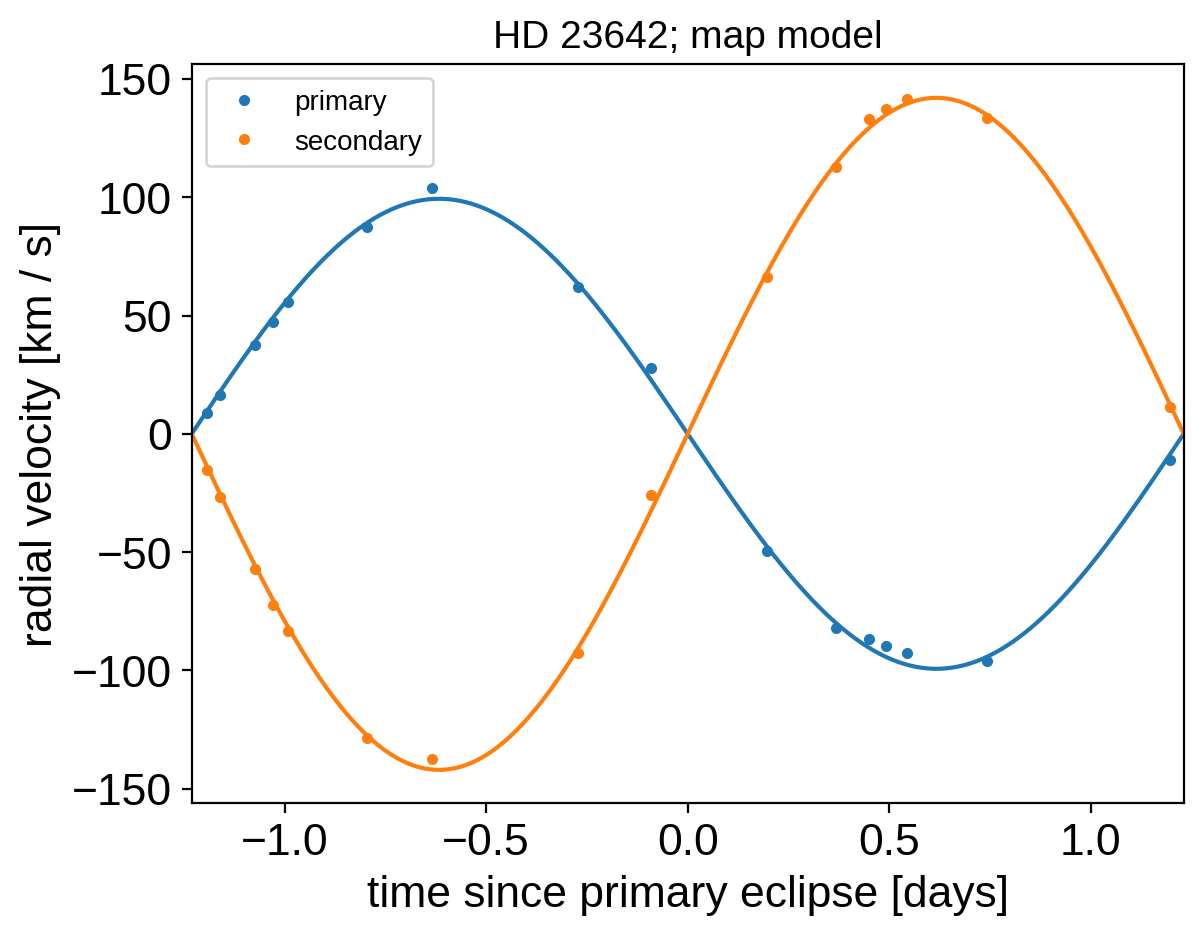

In [7]:
period = map_soln["period"]
t0 = map_soln["t0"]
mean = map_soln["mean_rv"]

x_fold = (x_rv - t0 + 0.5 * period) % period - 0.5 * period
plt.plot(fold, y1_rv - mean, ".", label="primary")
plt.plot(fold, y2_rv - mean, ".", label="secondary")

x_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
with model:
    y1_mod, y2_mod = xo.eval_in_model(
        [model.model_rv1(x_phase + t0), model.model_rv2(x_phase + t0)], map_soln
    )
plt.plot(x_phase, y1_mod - mean, "C0")
plt.plot(x_phase, y2_mod - mean, "C1")

plt.legend(fontsize=10)
plt.xlim(-0.5 * period, 0.5 * period)
plt.ylabel("radial velocity [km / s]")
plt.xlabel("time since primary eclipse [days]")
_ = plt.title("HD 23642; map model", fontsize=14)

And then the light curve.
In the top panel, we show the Gaussian process model for the phase curve.
It's clear that there's a lot of information there that we could take advantage of, but that's a topic for another day.
In the bottom panel, we're plotting the phase folded light curve and we can see the ridiculous signal to noise that we're getting on the eclipses.

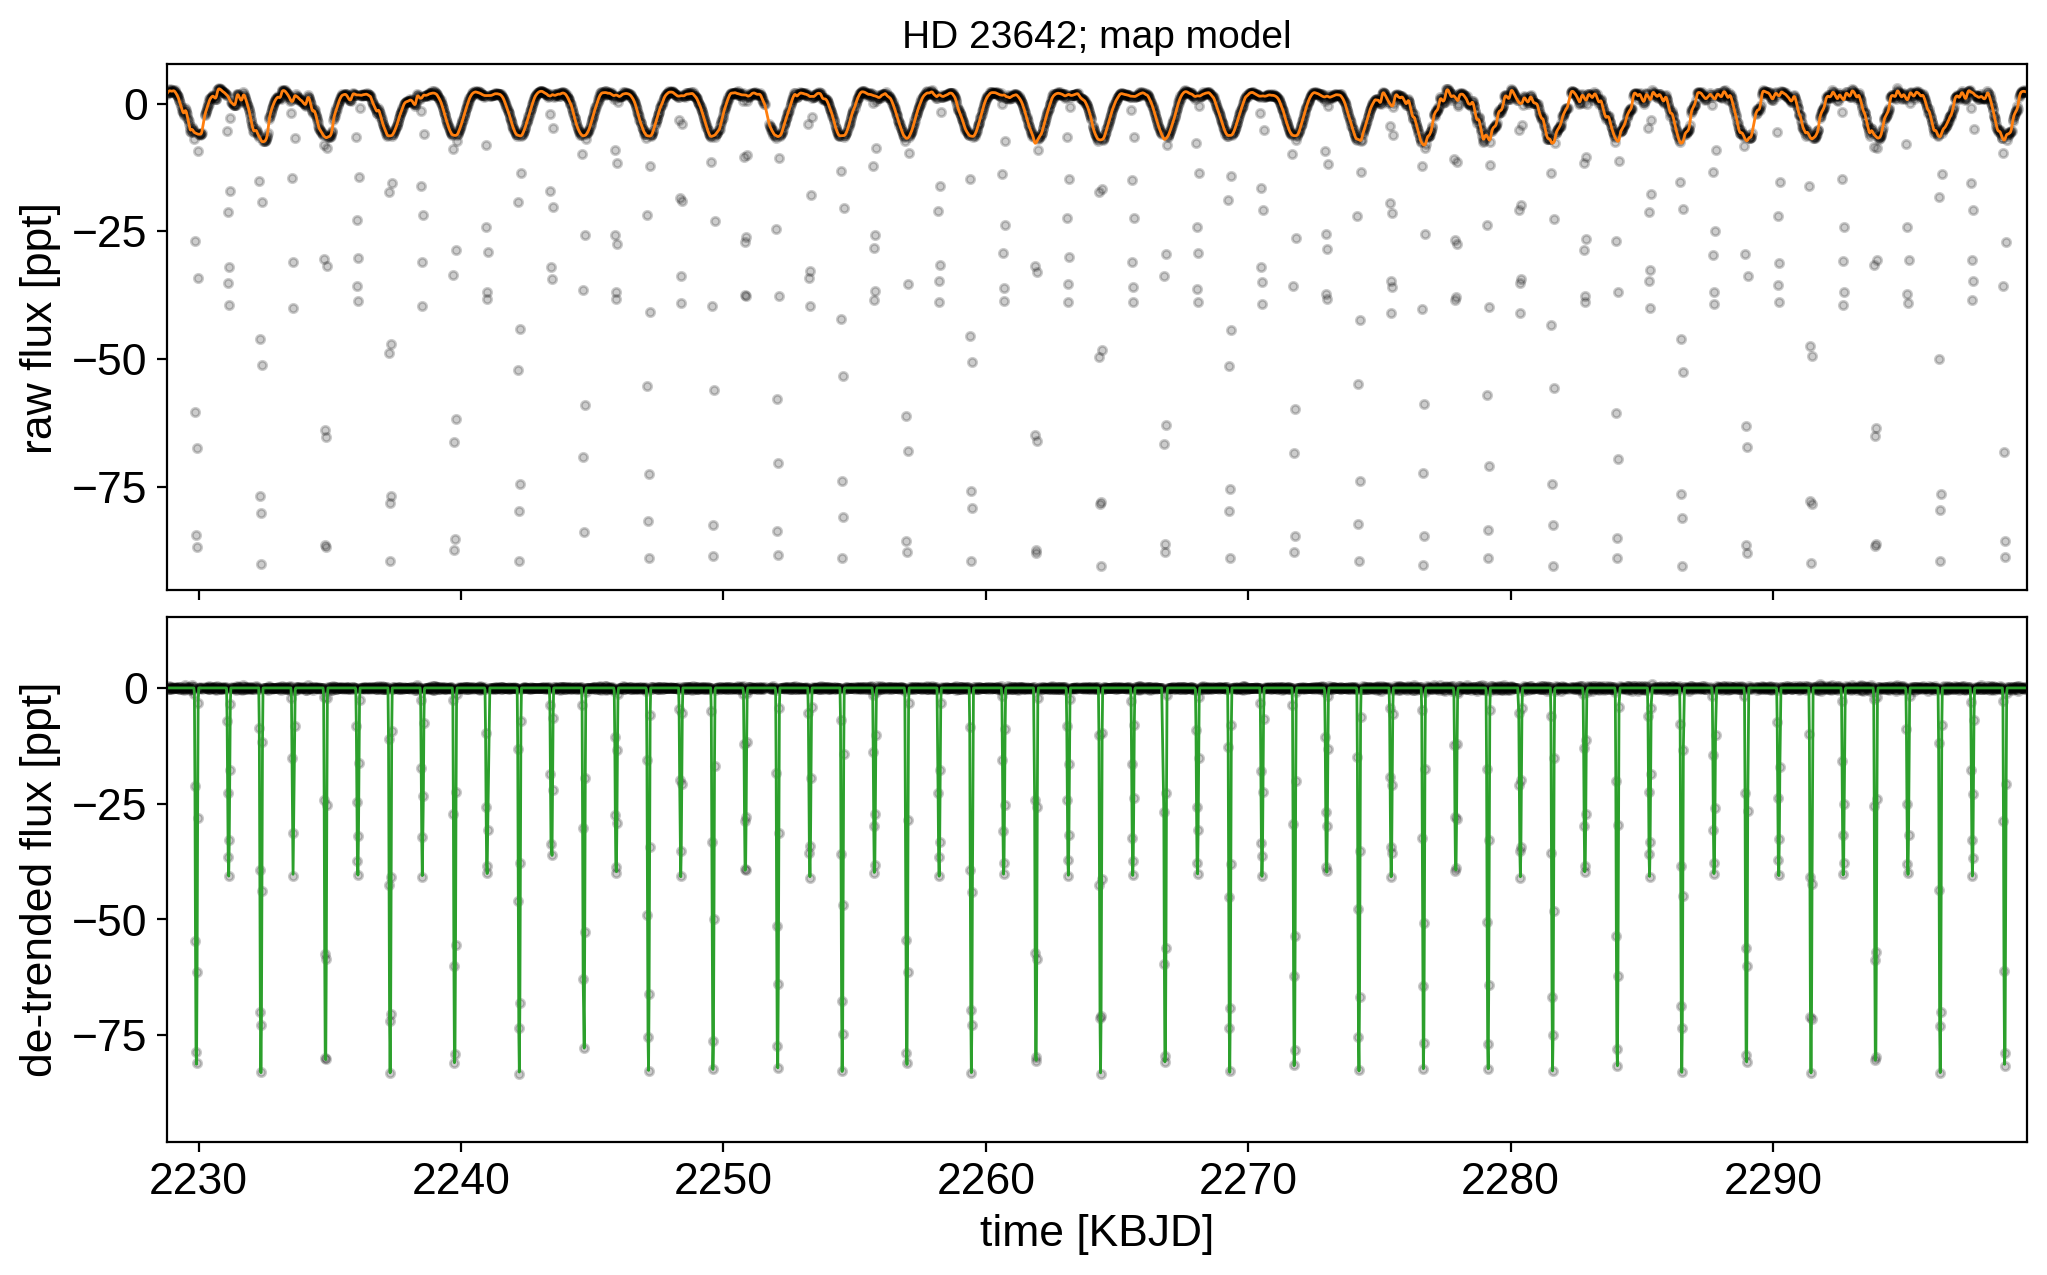

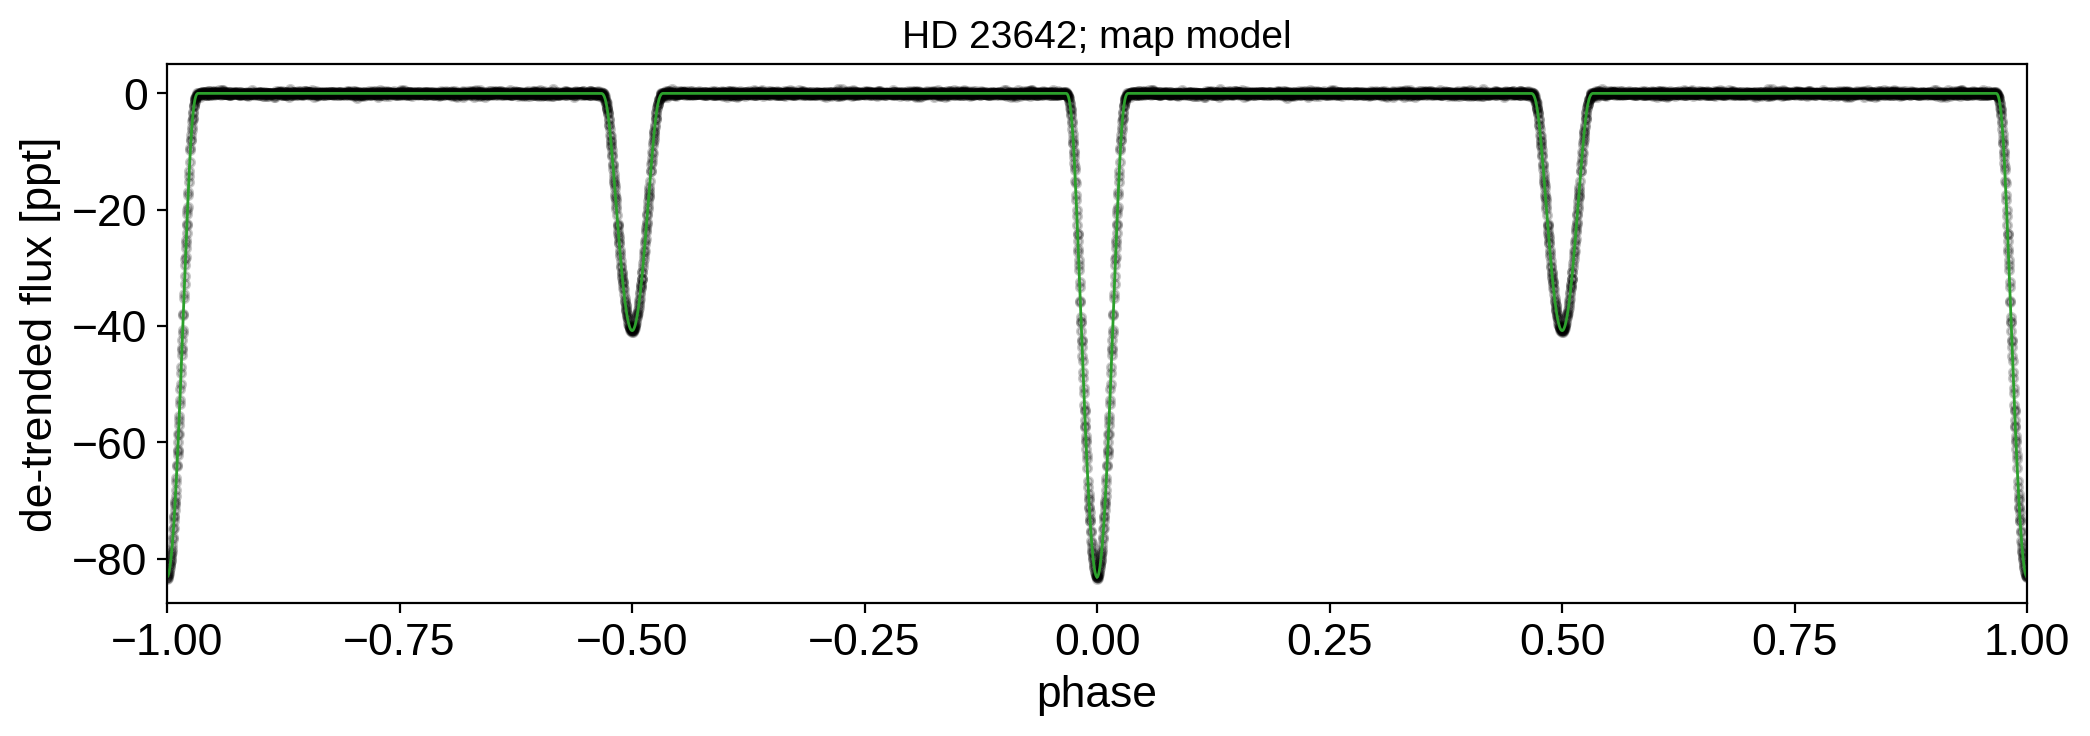

In [8]:
with model:
    gp_pred = xo.eval_in_model(model.gp_lc.predict(), map_soln) + map_soln["mean_lc"]
    lc = xo.eval_in_model(model.model_lc(model.x), map_soln) - map_soln["mean_lc"]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 7))

ax1.plot(model.x, model.y, "k.", alpha=0.2)
ax1.plot(model.x, gp_pred, color="C1", lw=1)

ax2.plot(model.x, model.y - gp_pred, "k.", alpha=0.2)
ax2.plot(model.x, lc, color="C2", lw=1)
ax2.set_xlim(model.x.min(), model.x.max())

ax1.set_ylabel("raw flux [ppt]")
ax2.set_ylabel("de-trended flux [ppt]")
ax2.set_xlabel("time [KBJD]")
ax1.set_title("HD 23642; map model", fontsize=14)

fig.subplots_adjust(hspace=0.05)

fig, ax1 = plt.subplots(1, figsize=(12, 3.5))

x_fold = (model.x - map_soln["t0"]) % map_soln["period"] / map_soln["period"]
inds = np.argsort(x_fold)

ax1.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax1.plot(x_fold[inds] - 1, model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax2.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2, label="data!")
ax2.plot(x_fold[inds] - 1, model.y[inds] - gp_pred, "k.", alpha=0.2)

yval = model.y[inds] - gp_pred
bins = np.linspace(0, 1, 75)
num, _ = np.histogram(x_fold[inds], bins, weights=yval)
denom, _ = np.histogram(x_fold[inds], bins)
ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

args = dict(lw=1)

ax1.plot(x_fold[inds], lc[inds], "C2", **args)
ax1.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

ax1.set_xlim(-1, 1)
ax1.set_ylabel("de-trended flux [ppt]")
ax1.set_xlabel("phase")
_ = ax1.set_title("HD 23642; map model", fontsize=14)

## Sampling

Finally we can run the MCMC:

In [9]:
np.random.seed(23642)
with model:
    trace = xo.sample(
        tune=3500,
        draws=3000,
        start=map_soln,
        chains=4,
        initial_accept=0.8,
        target_accept=0.95,
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 22/26000 [00:00<02:07, 204.35draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 29/26000 [00:01<34:24, 12.58draws/s] 

Sampling 4 chains, 0 divergences:   0%|          | 34/26000 [00:02<48:01,  9.01draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 38/26000 [00:03<1:03:07,  6.85draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/26000 [00:03<49:40,  8.71draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 44/26000 [00:04<1:11:31,  6.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 47/26000 [00:05<1:26:03,  5.03draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 50/26000 [00:05<1:07:28,  6.41draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 52/26000 [00:06<1:40:00,  4.32draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 54/26000 [00:06<1:17:18,  5.59draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 56/26000 [00:07<1:42:48,  4.21draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/26000 [00:07<1:17:51,  5.55draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 62/26000 [00:08<1:42:18,  4.23draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 66/26000 [00:08<1:18:43,  5.49draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 68/26000 [00:09<1:43:50,  4.16draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 70/26000 [00:09<1:23:59,  5.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/26000 [00:10<1:45:58,  4.08draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 76/26000 [00:10<1:20:35,  5.36draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 78/26000 [00:11<1:45:02,  4.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 80/26000 [00:11<1:24:57,  5.09draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 81/26000 [00:11<2:20:17,  3.08draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 82/26000 [00:12<1:55:26,  3.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 84/26000 [00:12<1:32:25,  4.67draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 85/26000 [00:12<2:21:38,  3.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 86/26000 [00:12<1:56:30,  3.71draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 89/26000 [00:13<1:29:32,  4.82draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 91/26000 [00:13<1:40:40,  4.29draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 93/26000 [00:13<1:19:10,  5.45draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 95/26000 [00:14<1:11:24,  6.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 96/26000 [00:14<2:00:42,  3.58draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 97/26000 [00:14<1:39:25,  4.34draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 99/26000 [00:15<1:26:46,  4.97draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 100/26000 [00:15<2:08:48,  3.35draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 101/26000 [00:15<1:47:03,  4.03draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 103/26000 [00:15<1:32:27,  4.67draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 104/26000 [00:16<2:13:57,  3.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 106/26000 [00:16<1:45:15,  4.10draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 107/26000 [00:16<1:42:57,  4.19draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 108/26000 [00:17<2:17:13,  3.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 110/26000 [00:17<1:47:50,  4.00draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 112/26000 [00:17<1:30:13,  4.78draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 113/26000 [00:18<2:07:36,  3.38draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 116/26000 [00:18<1:39:20,  4.34draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 117/26000 [00:18<1:32:58,  4.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 118/26000 [00:19<2:12:01,  3.27draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 120/26000 [00:19<1:45:59,  4.07draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 121/26000 [00:19<1:38:08,  4.39draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 122/26000 [00:20<2:15:27,  3.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 123/26000 [00:20<1:49:31,  3.94draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 124/26000 [00:20<1:29:57,  4.79draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 126/26000 [00:20<1:15:58,  5.68draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 127/26000 [00:21<1:58:59,  3.62draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 128/26000 [00:21<1:42:09,  4.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 130/26000 [00:21<1:28:57,  4.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/26000 [00:22<1:35:14,  4.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/26000 [00:22<1:18:04,  5.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/26000 [00:22<1:06:48,  6.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/26000 [00:22<1:46:51,  4.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 139/26000 [00:23<1:41:13,  4.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/26000 [00:23<1:21:43,  5.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 143/26000 [00:23<1:56:06,  3.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 145/26000 [00:24<1:35:52,  4.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 147/26000 [00:24<1:14:20,  5.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 149/26000 [00:24<1:35:24,  4.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/26000 [00:25<1:27:59,  4.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 152/26000 [00:25<1:15:37,  5.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/26000 [00:25<1:26:55,  4.96draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 155/26000 [00:25<1:25:50,  5.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 157/26000 [00:26<1:15:00,  5.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/26000 [00:26<1:55:15,  3.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 159/26000 [00:26<1:50:21,  3.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 162/26000 [00:27<1:26:15,  4.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 163/26000 [00:27<2:01:51,  3.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/26000 [00:27<1:56:40,  3.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 166/26000 [00:28<1:34:19,  4.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 167/26000 [00:28<1:24:09,  5.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/26000 [00:28<1:41:39,  4.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 170/26000 [00:28<1:28:35,  4.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/26000 [00:29<1:16:34,  5.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 174/26000 [00:29<1:44:30,  4.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 175/26000 [00:29<1:38:45,  4.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 177/26000 [00:30<1:30:21,  4.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 178/26000 [00:30<1:52:49,  3.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/26000 [00:30<1:32:15,  4.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/26000 [00:30<1:25:45,  5.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/26000 [00:31<1:24:46,  5.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 185/26000 [00:31<1:24:08,  5.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 188/26000 [00:31<1:15:32,  5.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 189/26000 [00:32<1:35:39,  4.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 190/26000 [00:32<1:35:53,  4.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 194/26000 [00:32<1:18:39,  5.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 195/26000 [00:33<1:41:02,  4.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 196/26000 [00:33<1:43:43,  4.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 198/26000 [00:33<1:32:17,  4.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/26000 [00:34<1:49:13,  3.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 200/26000 [00:34<1:50:04,  3.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 202/26000 [00:34<1:36:51,  4.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 204/26000 [00:35<1:32:13,  4.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 206/26000 [00:35<1:19:08,  5.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 208/26000 [00:35<1:16:57,  5.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 210/26000 [00:35<1:17:41,  5.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 211/26000 [00:36<1:20:18,  5.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 212/26000 [00:36<1:10:02,  6.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 214/26000 [00:36<1:05:34,  6.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 215/26000 [00:36<1:34:06,  4.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 216/26000 [00:37<1:28:20,  4.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 217/26000 [00:37<1:24:34,  5.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 218/26000 [00:37<1:23:29,  5.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 219/26000 [00:37<1:46:25,  4.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 220/26000 [00:37<1:35:59,  4.48draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 222/26000 [00:38<1:20:20,  5.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 223/26000 [00:38<1:18:35,  5.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 224/26000 [00:38<1:41:49,  4.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 225/26000 [00:38<1:34:30,  4.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 226/26000 [00:39<1:32:56,  4.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 227/26000 [00:39<1:26:09,  4.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 228/26000 [00:39<1:46:07,  4.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 229/26000 [00:39<1:39:41,  4.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 230/26000 [00:40<1:37:06,  4.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 231/26000 [00:40<1:27:01,  4.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 232/26000 [00:40<1:46:02,  4.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 233/26000 [00:40<1:39:29,  4.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 234/26000 [00:40<1:39:10,  4.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 235/26000 [00:41<1:27:11,  4.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 236/26000 [00:41<1:46:07,  4.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 237/26000 [00:41<1:38:46,  4.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 238/26000 [00:41<1:41:14,  4.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 239/26000 [00:42<1:27:27,  4.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 240/26000 [00:42<1:44:55,  4.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 241/26000 [00:42<1:38:10,  4.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 242/26000 [00:42<1:42:40,  4.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 244/26000 [00:42<1:19:34,  5.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 245/26000 [00:43<1:38:05,  4.38draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 246/26000 [00:43<1:33:22,  4.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 247/26000 [00:43<1:45:42,  4.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 250/26000 [00:44<1:32:39,  4.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 251/26000 [00:44<1:25:22,  5.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 252/26000 [00:44<1:34:54,  4.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 254/26000 [00:44<1:15:24,  5.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 255/26000 [00:45<1:39:16,  4.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 256/26000 [00:45<2:01:35,  3.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 258/26000 [00:45<1:34:48,  4.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 259/26000 [00:46<1:51:23,  3.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 261/26000 [00:46<1:44:16,  4.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 264/26000 [00:46<1:19:33,  5.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 265/26000 [00:46<1:47:19,  4.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 266/26000 [00:47<2:02:43,  3.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 268/26000 [00:47<1:34:52,  4.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 269/26000 [00:47<2:03:11,  3.48draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 270/26000 [00:48<2:07:33,  3.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 271/26000 [00:48<1:44:06,  4.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 274/26000 [00:48<1:32:54,  4.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 277/26000 [00:49<1:18:44,  5.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 279/26000 [00:49<1:09:14,  6.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 280/26000 [00:49<1:40:14,  4.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 282/26000 [00:50<1:34:26,  4.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 283/26000 [00:50<1:27:15,  4.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 284/26000 [00:50<1:48:42,  3.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 286/26000 [00:51<1:40:02,  4.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 288/26000 [00:51<1:21:37,  5.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 289/26000 [00:51<1:42:20,  4.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 292/26000 [00:51<1:16:30,  5.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 294/26000 [00:52<1:17:49,  5.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 295/26000 [00:52<1:49:29,  3.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 297/26000 [00:52<1:28:14,  4.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 298/26000 [00:53<1:42:16,  4.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 299/26000 [00:53<2:04:10,  3.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 301/26000 [00:53<1:38:55,  4.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 302/26000 [00:53<1:51:24,  3.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 303/26000 [00:54<2:10:43,  3.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 306/26000 [00:54<1:53:27,  3.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 307/26000 [00:55<2:11:10,  3.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 310/26000 [00:55<1:45:31,  4.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 311/26000 [00:55<1:40:09,  4.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 312/26000 [00:56<1:58:56,  3.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 314/26000 [00:56<1:33:29,  4.58draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 315/26000 [00:56<1:26:45,  4.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 316/26000 [00:56<1:15:09,  5.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 317/26000 [00:56<1:06:07,  6.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 318/26000 [00:57<1:33:12,  4.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 319/26000 [00:57<1:46:54,  4.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 320/26000 [00:57<1:29:54,  4.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 321/26000 [00:57<1:17:49,  5.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 323/26000 [00:58<1:18:17,  5.47draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 325/26000 [00:58<1:08:26,  6.25draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 326/26000 [00:58<1:14:54,  5.71draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 327/26000 [00:58<1:19:11,  5.40draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 328/26000 [00:58<1:30:27,  4.73draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 329/26000 [00:59<1:30:33,  4.72draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 330/26000 [00:59<1:31:20,  4.68draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 331/26000 [00:59<1:31:54,  4.66draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 332/26000 [00:59<1:37:15,  4.40draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 333/26000 [01:00<1:35:17,  4.49draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 334/26000 [01:00<1:35:41,  4.47draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 335/26000 [01:00<1:36:12,  4.45draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 337/26000 [01:00<1:22:39,  5.17draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 338/26000 [01:01<1:54:50,  3.72draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 339/26000 [01:01<1:51:16,  3.84draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 342/26000 [01:01<1:24:26,  5.06draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 344/26000 [01:01<1:06:14,  6.45draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 346/26000 [01:02<1:33:55,  4.55draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 347/26000 [01:02<1:22:26,  5.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 349/26000 [01:02<1:15:09,  5.69draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 351/26000 [01:03<1:25:09,  5.02draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 353/26000 [01:03<1:09:16,  6.17draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 358/26000 [01:03<51:27,  8.30draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 360/26000 [01:04<1:31:46,  4.66draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 363/26000 [01:05<1:33:19,  4.58draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 365/26000 [01:05<1:18:16,  5.46draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 369/26000 [01:05<1:00:07,  7.10draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 372/26000 [01:06<1:17:35,  5.51draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 376/26000 [01:06<57:33,  7.42draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 380/26000 [01:06<57:37,  7.41draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 382/26000 [01:07<1:01:25,  6.95draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 384/26000 [01:07<1:20:23,  5.31draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 386/26000 [01:08<1:15:55,  5.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 390/26000 [01:08<1:04:13,  6.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 391/26000 [01:08<1:07:55,  6.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 392/26000 [01:08<1:03:48,  6.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 393/26000 [01:09<1:22:36,  5.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 394/26000 [01:09<1:39:08,  4.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 395/26000 [01:09<1:30:17,  4.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 397/26000 [01:09<1:11:36,  5.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 398/26000 [01:10<1:26:49,  4.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 400/26000 [01:10<1:31:47,  4.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 403/26000 [01:10<1:15:48,  5.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 405/26000 [01:10<1:01:39,  6.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 407/26000 [01:11<52:32,  8.12draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 409/26000 [01:11<59:16,  7.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 411/26000 [01:12<1:16:55,  5.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 412/26000 [01:12<1:15:09,  5.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 415/26000 [01:12<1:00:25,  7.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 418/26000 [01:12<57:41,  7.39draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 419/26000 [01:13<1:30:38,  4.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 420/26000 [01:13<1:22:44,  5.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 422/26000 [01:13<1:24:54,  5.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 425/26000 [01:14<1:14:14,  5.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 426/26000 [01:14<1:09:06,  6.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 427/26000 [01:14<1:41:43,  4.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 430/26000 [01:14<1:26:24,  4.93draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 431/26000 [01:15<1:16:59,  5.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 433/26000 [01:15<1:07:29,  6.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 434/26000 [01:15<1:19:27,  5.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 438/26000 [01:15<1:03:35,  6.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 439/26000 [01:15<1:10:24,  6.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 441/26000 [01:16<1:18:11,  5.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 443/26000 [01:16<1:04:36,  6.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 445/26000 [01:16<59:48,  7.12draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 448/26000 [01:17<1:04:11,  6.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 449/26000 [01:17<1:02:31,  6.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 451/26000 [01:17<59:35,  7.15draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 453/26000 [01:18<1:07:48,  6.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 455/26000 [01:18<1:02:10,  6.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 457/26000 [01:18<1:06:08,  6.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 458/26000 [01:19<1:36:23,  4.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 459/26000 [01:19<1:28:36,  4.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 461/26000 [01:19<1:24:17,  5.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 462/26000 [01:20<1:50:03,  3.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 463/26000 [01:20<1:39:21,  4.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 465/26000 [01:20<1:17:09,  5.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 466/26000 [01:20<1:14:39,  5.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 468/26000 [01:20<1:08:04,  6.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 469/26000 [01:21<1:22:08,  5.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 470/26000 [01:21<1:10:54,  6.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 472/26000 [01:21<1:00:31,  7.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 473/26000 [01:21<57:27,  7.40draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 474/26000 [01:21<1:09:29,  6.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 476/26000 [01:21<1:06:27,  6.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 477/26000 [01:22<1:09:15,  6.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 480/26000 [01:22<58:10,  7.31draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 481/26000 [01:22<1:29:38,  4.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 482/26000 [01:22<1:16:48,  5.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 484/26000 [01:23<1:13:00,  5.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 485/26000 [01:23<1:05:47,  6.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 486/26000 [01:23<1:36:28,  4.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 487/26000 [01:23<1:22:26,  5.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 489/26000 [01:24<1:15:24,  5.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 492/26000 [01:24<57:36,  7.38draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 495/26000 [01:24<45:31,  9.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 497/26000 [01:24<40:04, 10.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 499/26000 [01:24<38:03, 11.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 501/26000 [01:24<45:27,  9.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 503/26000 [01:25<1:00:40,  7.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 505/26000 [01:25<53:35,  7.93draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 507/26000 [01:25<45:23,  9.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 509/26000 [01:25<46:35,  9.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 511/26000 [01:26<49:17,  8.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 513/26000 [01:26<41:43, 10.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 515/26000 [01:26<36:14, 11.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 518/26000 [01:26<31:35, 13.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 520/26000 [01:26<32:35, 13.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 522/26000 [01:26<29:54, 14.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 524/26000 [01:27<54:23,  7.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 526/26000 [01:27<56:13,  7.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 528/26000 [01:28<1:14:58,  5.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 531/26000 [01:28<57:19,  7.40draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 533/26000 [01:28<1:21:24,  5.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 535/26000 [01:29<1:11:52,  5.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 538/26000 [01:29<56:15,  7.54draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 540/26000 [01:29<1:15:02,  5.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 542/26000 [01:30<1:10:58,  5.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 544/26000 [01:30<1:15:12,  5.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 546/26000 [01:30<1:03:15,  6.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 547/26000 [01:30<59:04,  7.18draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 549/26000 [01:30<55:10,  7.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 550/26000 [01:31<52:10,  8.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 551/26000 [01:31<51:44,  8.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 554/26000 [01:31<41:10, 10.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 556/26000 [01:31<41:19, 10.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 558/26000 [01:31<39:31, 10.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 560/26000 [01:31<40:13, 10.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 562/26000 [01:32<46:41,  9.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 564/26000 [01:32<42:22, 10.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 566/26000 [01:32<41:40, 10.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 568/26000 [01:32<43:39,  9.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 571/26000 [01:32<37:19, 11.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 573/26000 [01:33<40:21, 10.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 575/26000 [01:33<36:08, 11.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 577/26000 [01:33<31:52, 13.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 581/26000 [01:33<27:14, 15.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 584/26000 [01:33<25:23, 16.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 586/26000 [01:33<32:10, 13.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 588/26000 [01:34<37:15, 11.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 590/26000 [01:34<33:30, 12.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 592/26000 [01:34<29:59, 14.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 594/26000 [01:34<29:08, 14.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 597/26000 [01:34<26:21, 16.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 599/26000 [01:34<33:33, 12.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 601/26000 [01:35<43:20,  9.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 603/26000 [01:35<44:19,  9.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 605/26000 [01:35<43:22,  9.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 607/26000 [01:35<46:51,  9.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 610/26000 [01:36<42:26,  9.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 612/26000 [01:36<36:36, 11.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 615/26000 [01:36<39:01, 10.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 617/26000 [01:36<46:54,  9.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 619/26000 [01:36<40:04, 10.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 622/26000 [01:37<35:36, 11.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 625/26000 [01:37<31:40, 13.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 627/26000 [01:37<29:25, 14.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 629/26000 [01:37<27:49, 15.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 631/26000 [01:37<26:42, 15.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 634/26000 [01:37<23:06, 18.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 637/26000 [01:38<30:17, 13.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 641/26000 [01:38<24:50, 17.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 644/26000 [01:38<25:18, 16.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 647/26000 [01:38<24:57, 16.93draws/s]

Sampling 4 chains, 0 divergences:   2%|▎         | 650/26000 [01:38<22:06, 19.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 653/26000 [01:38<20:29, 20.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 656/26000 [01:38<21:52, 19.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 659/26000 [01:39<19:32, 21.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 662/26000 [01:39<25:41, 16.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 665/26000 [01:39<28:30, 14.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 667/26000 [01:39<28:56, 14.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 669/26000 [01:39<33:19, 12.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 671/26000 [01:40<45:11,  9.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 673/26000 [01:40<38:38, 10.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 675/26000 [01:40<50:23,  8.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 678/26000 [01:40<42:51,  9.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 680/26000 [01:41<37:26, 11.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 682/26000 [01:41<33:36, 12.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 684/26000 [01:41<30:51, 13.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 687/26000 [01:41<26:04, 16.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 691/26000 [01:41<21:52, 19.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 695/26000 [01:41<24:26, 17.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 698/26000 [01:41<27:19, 15.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 700/26000 [01:42<33:22, 12.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 702/26000 [01:42<31:04, 13.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 704/26000 [01:42<28:25, 14.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 706/26000 [01:42<27:03, 15.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 708/26000 [01:42<26:10, 16.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 710/26000 [01:42<25:30, 16.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 713/26000 [01:42<22:33, 18.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 716/26000 [01:43<21:32, 19.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 719/26000 [01:43<19:59, 21.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 722/26000 [01:43<21:15, 19.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 725/26000 [01:43<26:00, 16.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 727/26000 [01:43<36:23, 11.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 729/26000 [01:44<39:32, 10.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 731/26000 [01:44<35:34, 11.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 736/26000 [01:44<27:31, 15.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 739/26000 [01:44<27:44, 15.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 742/26000 [01:44<29:00, 14.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 746/26000 [01:44<25:36, 16.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 749/26000 [01:45<26:25, 15.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 751/26000 [01:45<28:50, 14.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 753/26000 [01:45<36:53, 11.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 755/26000 [01:45<37:42, 11.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 757/26000 [01:45<36:13, 11.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 759/26000 [01:46<32:34, 12.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 763/26000 [01:46<28:13, 14.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 766/26000 [01:46<24:35, 17.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 768/26000 [01:46<26:37, 15.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 771/26000 [01:46<27:26, 15.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 775/26000 [01:46<23:18, 18.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 778/26000 [01:47<27:05, 15.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 780/26000 [01:47<28:06, 14.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 782/26000 [01:47<30:30, 13.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 784/26000 [01:47<32:16, 13.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 786/26000 [01:47<30:26, 13.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 788/26000 [01:47<27:57, 15.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 790/26000 [01:47<27:13, 15.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 792/26000 [01:48<25:49, 16.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 794/26000 [01:48<32:29, 12.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 797/26000 [01:48<27:44, 15.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 799/26000 [01:48<30:08, 13.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 801/26000 [01:48<31:41, 13.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 803/26000 [01:48<33:02, 12.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 806/26000 [01:48<27:53, 15.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 809/26000 [01:49<24:17, 17.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 812/26000 [01:49<21:14, 19.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 815/26000 [01:49<22:52, 18.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 818/26000 [01:49<27:10, 15.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 820/26000 [01:49<30:55, 13.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 823/26000 [01:49<26:31, 15.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 825/26000 [01:50<25:47, 16.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 828/26000 [01:50<29:07, 14.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 830/26000 [01:50<30:51, 13.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 834/26000 [01:50<28:03, 14.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 836/26000 [01:50<26:39, 15.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 838/26000 [01:50<27:49, 15.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 840/26000 [01:51<34:03, 12.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 842/26000 [01:51<38:23, 10.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 844/26000 [01:51<34:11, 12.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 847/26000 [01:51<31:35, 13.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 850/26000 [01:52<38:04, 11.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 852/26000 [01:52<33:55, 12.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 854/26000 [01:52<35:15, 11.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 857/26000 [01:52<31:28, 13.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 859/26000 [01:52<29:14, 14.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 862/26000 [01:52<25:18, 16.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 865/26000 [01:52<23:08, 18.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 868/26000 [01:53<22:56, 18.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 870/26000 [01:53<30:24, 13.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 872/26000 [01:53<32:01, 13.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 874/26000 [01:53<33:09, 12.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 876/26000 [01:53<30:22, 13.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 879/26000 [01:53<26:01, 16.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 881/26000 [01:54<30:27, 13.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 884/26000 [01:54<25:48, 16.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 886/26000 [01:54<25:50, 16.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 888/26000 [01:54<24:34, 17.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 890/26000 [01:54<25:13, 16.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 892/26000 [01:54<24:29, 17.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 895/26000 [01:54<22:16, 18.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 897/26000 [01:54<22:51, 18.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 900/26000 [01:55<21:04, 19.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 903/26000 [01:55<19:19, 21.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 907/26000 [01:55<17:16, 24.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 910/26000 [01:55<23:00, 18.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 913/26000 [01:55<23:35, 17.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 916/26000 [01:55<21:22, 19.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 920/26000 [01:55<18:33, 22.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 924/26000 [01:56<16:35, 25.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 927/26000 [01:56<16:23, 25.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 930/26000 [01:56<16:46, 24.92draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 933/26000 [01:56<17:51, 23.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 937/26000 [01:56<15:56, 26.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 940/26000 [01:56<20:41, 20.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 943/26000 [01:56<19:20, 21.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 946/26000 [01:57<22:02, 18.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 949/26000 [01:57<21:18, 19.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 953/26000 [01:57<21:26, 19.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 956/26000 [01:57<19:50, 21.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 959/26000 [01:57<23:24, 17.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 961/26000 [01:57<25:15, 16.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 964/26000 [01:58<26:08, 15.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 968/26000 [01:58<22:01, 18.94draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 971/26000 [01:58<21:47, 19.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 974/26000 [01:58<20:03, 20.79draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 978/26000 [01:58<17:37, 23.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 981/26000 [01:58<17:21, 24.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 984/26000 [01:58<16:56, 24.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 988/26000 [01:58<15:46, 26.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 991/26000 [01:59<20:39, 20.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 994/26000 [01:59<22:32, 18.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 997/26000 [01:59<23:12, 17.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1000/26000 [01:59<20:59, 19.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1003/26000 [01:59<24:09, 17.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1005/26000 [02:00<24:01, 17.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1008/26000 [02:00<21:32, 19.33draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1011/26000 [02:00<22:04, 18.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1014/26000 [02:00<27:23, 15.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1016/26000 [02:00<29:50, 13.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1019/26000 [02:00<28:00, 14.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1021/26000 [02:01<26:42, 15.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1023/26000 [02:01<33:12, 12.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1025/26000 [02:01<30:18, 13.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1027/26000 [02:01<27:48, 14.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1031/26000 [02:01<23:33, 17.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1035/26000 [02:01<20:07, 20.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1038/26000 [02:01<21:06, 19.71draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1041/26000 [02:02<20:54, 19.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1044/26000 [02:02<19:18, 21.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1047/26000 [02:02<18:30, 22.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1050/26000 [02:02<17:22, 23.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1053/26000 [02:02<19:50, 20.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1057/26000 [02:02<17:07, 24.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1060/26000 [02:02<18:48, 22.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1063/26000 [02:03<20:38, 20.13draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1066/26000 [02:03<19:51, 20.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1069/26000 [02:03<18:43, 22.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1072/26000 [02:03<17:56, 23.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1075/26000 [02:03<17:24, 23.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1078/26000 [02:03<17:00, 24.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1081/26000 [02:03<18:12, 22.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1084/26000 [02:03<21:21, 19.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1087/26000 [02:04<19:11, 21.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1090/26000 [02:04<18:28, 22.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1093/26000 [02:04<17:13, 24.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1096/26000 [02:04<18:36, 22.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1099/26000 [02:04<20:42, 20.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1102/26000 [02:04<19:37, 21.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1105/26000 [02:04<18:33, 22.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1108/26000 [02:05<17:43, 23.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1111/26000 [02:05<17:16, 24.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1114/26000 [02:05<16:37, 24.94draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1117/26000 [02:05<16:10, 25.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1120/26000 [02:05<24:49, 16.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1124/26000 [02:05<22:42, 18.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1127/26000 [02:05<20:53, 19.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1130/26000 [02:06<22:01, 18.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1133/26000 [02:06<26:52, 15.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1135/26000 [02:06<25:41, 16.13draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1138/26000 [02:06<22:49, 18.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1141/26000 [02:06<23:21, 17.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1145/26000 [02:06<19:53, 20.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1148/26000 [02:07<18:47, 22.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1152/26000 [02:07<16:16, 25.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1155/26000 [02:07<16:07, 25.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1158/26000 [02:07<16:49, 24.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1161/26000 [02:07<17:45, 23.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1165/26000 [02:07<15:41, 26.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1168/26000 [02:07<19:42, 21.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1172/26000 [02:07<17:20, 23.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1175/26000 [02:08<17:00, 24.32draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1178/26000 [02:08<16:38, 24.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1181/26000 [02:08<18:45, 22.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1184/26000 [02:08<20:53, 19.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1187/26000 [02:08<20:05, 20.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1190/26000 [02:08<21:24, 19.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1193/26000 [02:09<22:28, 18.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1195/26000 [02:09<22:47, 18.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1197/26000 [02:09<22:24, 18.45draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1199/26000 [02:09<22:49, 18.11draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1201/26000 [02:09<23:07, 17.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1203/26000 [02:09<22:39, 18.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1207/26000 [02:09<19:45, 20.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1212/26000 [02:09<16:43, 24.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1215/26000 [02:10<18:44, 22.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1218/26000 [02:10<20:10, 20.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1221/26000 [02:10<18:49, 21.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1224/26000 [02:10<20:16, 20.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1228/26000 [02:10<18:24, 22.43draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1231/26000 [02:10<20:44, 19.90draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1234/26000 [02:10<19:47, 20.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1237/26000 [02:11<19:43, 20.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1241/26000 [02:11<20:53, 19.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1244/26000 [02:11<24:02, 17.16draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1247/26000 [02:11<22:15, 18.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1249/26000 [02:11<23:36, 17.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1252/26000 [02:11<21:15, 19.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1255/26000 [02:12<20:11, 20.43draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1258/26000 [02:12<20:40, 19.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1262/26000 [02:12<19:46, 20.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1265/26000 [02:12<18:51, 21.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1268/26000 [02:12<18:15, 22.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1271/26000 [02:12<18:36, 22.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1275/26000 [02:12<18:53, 21.81draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1280/26000 [02:13<16:29, 24.98draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1283/26000 [02:13<15:55, 25.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1286/26000 [02:13<15:51, 25.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1290/26000 [02:13<14:37, 28.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1293/26000 [02:13<14:55, 27.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1296/26000 [02:13<15:50, 25.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1299/26000 [02:13<15:46, 26.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1302/26000 [02:13<19:38, 20.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1305/26000 [02:14<19:26, 21.18draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1308/26000 [02:14<18:22, 22.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1311/26000 [02:14<17:38, 23.32draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1314/26000 [02:14<21:06, 19.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1317/26000 [02:14<19:28, 21.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1320/26000 [02:14<18:19, 22.45draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1325/26000 [02:14<15:52, 25.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1328/26000 [02:15<15:56, 25.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1331/26000 [02:15<15:54, 25.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1334/26000 [02:15<16:12, 25.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1337/26000 [02:15<20:26, 20.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1341/26000 [02:15<17:50, 23.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1344/26000 [02:15<19:32, 21.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1347/26000 [02:15<20:43, 19.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1350/26000 [02:16<19:24, 21.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1353/26000 [02:16<19:29, 21.08draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1356/26000 [02:16<18:24, 22.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1359/26000 [02:16<26:27, 15.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1361/26000 [02:16<26:38, 15.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1363/26000 [02:16<25:43, 15.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1366/26000 [02:17<22:51, 17.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1369/26000 [02:17<20:45, 19.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1372/26000 [02:17<19:03, 21.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1375/26000 [02:17<22:48, 18.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1378/26000 [02:17<21:04, 19.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1381/26000 [02:17<19:03, 21.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1384/26000 [02:17<19:33, 20.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1387/26000 [02:18<23:04, 17.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1389/26000 [02:18<23:19, 17.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1391/26000 [02:18<25:06, 16.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1393/26000 [02:18<25:27, 16.11draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1395/26000 [02:18<24:12, 16.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1398/26000 [02:18<22:06, 18.54draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1402/26000 [02:18<18:41, 21.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1405/26000 [02:18<19:58, 20.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1408/26000 [02:19<19:17, 21.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1411/26000 [02:19<20:13, 20.26draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1414/26000 [02:19<20:46, 19.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1417/26000 [02:19<20:06, 20.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1420/26000 [02:19<20:50, 19.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1423/26000 [02:19<22:01, 18.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1426/26000 [02:20<20:07, 20.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1429/26000 [02:20<18:49, 21.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1432/26000 [02:20<17:53, 22.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1435/26000 [02:20<17:09, 23.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1439/26000 [02:20<15:36, 26.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1442/26000 [02:20<17:50, 22.94draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1445/26000 [02:20<17:53, 22.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1448/26000 [02:20<17:10, 23.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1451/26000 [02:21<16:22, 24.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1454/26000 [02:21<16:06, 25.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1457/26000 [02:21<20:11, 20.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1460/26000 [02:21<18:53, 21.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1463/26000 [02:21<21:26, 19.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1466/26000 [02:21<23:22, 17.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1469/26000 [02:21<20:36, 19.84draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1472/26000 [02:22<21:13, 19.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1475/26000 [02:22<21:53, 18.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1478/26000 [02:22<20:00, 20.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1481/26000 [02:22<22:03, 18.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1484/26000 [02:22<21:30, 18.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1486/26000 [02:22<22:09, 18.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1488/26000 [02:23<22:35, 18.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1490/26000 [02:23<22:53, 17.85draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1492/26000 [02:23<23:06, 17.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1494/26000 [02:23<23:48, 17.15draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1496/26000 [02:23<30:18, 13.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1498/26000 [02:24<47:36,  8.58draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1500/26000 [02:24<41:28,  9.84draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1502/26000 [02:24<36:05, 11.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1504/26000 [02:24<39:09, 10.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1506/26000 [02:24<34:23, 11.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1508/26000 [02:24<32:13, 12.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1510/26000 [02:24<34:47, 11.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1512/26000 [02:25<31:30, 12.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1515/26000 [02:25<27:20, 14.93draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1517/26000 [02:25<25:20, 16.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1519/26000 [02:25<31:56, 12.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1521/26000 [02:25<29:27, 13.85draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1525/26000 [02:25<24:05, 16.93draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1528/26000 [02:25<24:28, 16.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1530/26000 [02:26<26:44, 15.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1533/26000 [02:26<23:21, 17.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1536/26000 [02:26<21:06, 19.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1540/26000 [02:26<18:17, 22.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1543/26000 [02:26<18:04, 22.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1546/26000 [02:26<16:48, 24.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1549/26000 [02:26<16:54, 24.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1552/26000 [02:26<16:00, 25.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1555/26000 [02:27<16:20, 24.93draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1558/26000 [02:27<16:07, 25.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1561/26000 [02:27<17:25, 23.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1564/26000 [02:27<16:50, 24.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1567/26000 [02:27<19:42, 20.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1570/26000 [02:27<18:29, 22.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1573/26000 [02:27<17:37, 23.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1576/26000 [02:27<18:11, 22.37draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1580/26000 [02:28<19:40, 20.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1583/26000 [02:28<18:23, 22.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1586/26000 [02:28<18:43, 21.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1589/26000 [02:28<21:09, 19.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1593/26000 [02:28<18:16, 22.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1596/26000 [02:28<18:29, 21.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1600/26000 [02:29<16:39, 24.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1603/26000 [02:29<19:29, 20.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1607/26000 [02:29<19:12, 21.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1610/26000 [02:29<18:10, 22.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1613/26000 [02:29<20:28, 19.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1616/26000 [02:29<20:44, 19.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1619/26000 [02:30<19:35, 20.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1622/26000 [02:30<19:20, 21.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1626/26000 [02:30<16:59, 23.91draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1629/26000 [02:30<18:06, 22.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1633/26000 [02:30<16:11, 25.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1636/26000 [02:30<15:59, 25.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1641/26000 [02:30<15:16, 26.58draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1644/26000 [02:30<15:26, 26.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1647/26000 [02:31<15:32, 26.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1650/26000 [02:31<20:14, 20.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1653/26000 [02:31<22:55, 17.71draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1656/26000 [02:31<20:42, 19.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1659/26000 [02:31<19:09, 21.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1662/26000 [02:31<18:04, 22.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1665/26000 [02:31<17:47, 22.81draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1668/26000 [02:32<18:38, 21.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1671/26000 [02:32<25:19, 16.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1674/26000 [02:32<21:51, 18.54draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1677/26000 [02:32<22:25, 18.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1680/26000 [02:32<22:56, 17.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1683/26000 [02:33<22:57, 17.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1685/26000 [02:33<23:11, 17.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1687/26000 [02:33<23:20, 17.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1690/26000 [02:33<21:02, 19.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1693/26000 [02:33<19:45, 20.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1696/26000 [02:33<20:10, 20.08draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1699/26000 [02:33<21:51, 18.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1703/26000 [02:34<20:00, 20.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1706/26000 [02:34<18:39, 21.70draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1709/26000 [02:34<20:46, 19.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1714/26000 [02:34<18:17, 22.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1718/26000 [02:34<16:52, 23.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1722/26000 [02:34<17:07, 23.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1725/26000 [02:34<18:12, 22.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1728/26000 [02:35<17:53, 22.60draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1731/26000 [02:35<19:36, 20.63draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1734/26000 [02:35<19:07, 21.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1737/26000 [02:35<18:00, 22.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1740/26000 [02:35<16:47, 24.09draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1743/26000 [02:35<16:50, 24.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1746/26000 [02:35<16:26, 24.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1749/26000 [02:35<18:01, 22.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1752/26000 [02:36<19:59, 20.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1755/26000 [02:36<19:37, 20.60draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1758/26000 [02:36<21:40, 18.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1761/26000 [02:36<20:10, 20.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1764/26000 [02:36<20:50, 19.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1768/26000 [02:36<18:03, 22.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1771/26000 [02:37<17:17, 23.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1774/26000 [02:37<16:45, 24.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1777/26000 [02:37<18:28, 21.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1781/26000 [02:37<16:42, 24.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1784/26000 [02:37<15:54, 25.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1787/26000 [02:37<15:11, 26.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1790/26000 [02:37<15:14, 26.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1793/26000 [02:37<15:16, 26.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1796/26000 [02:38<16:00, 25.19draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1799/26000 [02:38<19:43, 20.45draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1803/26000 [02:38<18:00, 22.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1806/26000 [02:38<26:28, 15.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1809/26000 [02:38<24:25, 16.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1811/26000 [02:38<24:06, 16.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1813/26000 [02:39<23:41, 17.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1815/26000 [02:39<23:29, 17.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1818/26000 [02:39<21:04, 19.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1821/26000 [02:39<23:06, 17.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1823/26000 [02:39<23:15, 17.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1827/26000 [02:39<19:49, 20.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1830/26000 [02:39<23:15, 17.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1832/26000 [02:40<25:29, 15.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1835/26000 [02:40<21:53, 18.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1838/26000 [02:40<20:53, 19.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1841/26000 [02:40<22:12, 18.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1845/26000 [02:40<19:24, 20.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1848/26000 [02:40<18:09, 22.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1851/26000 [02:40<17:16, 23.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1854/26000 [02:41<17:55, 22.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1857/26000 [02:41<20:19, 19.79draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1861/26000 [02:41<18:17, 22.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1864/26000 [02:41<17:56, 22.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1867/26000 [02:41<19:36, 20.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1871/26000 [02:41<17:09, 23.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1874/26000 [02:41<16:33, 24.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1878/26000 [02:42<16:22, 24.54draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1882/26000 [02:42<14:33, 27.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1885/26000 [02:42<15:17, 26.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1888/26000 [02:42<14:58, 26.84draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1891/26000 [02:42<17:17, 23.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1894/26000 [02:42<19:20, 20.77draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1897/26000 [02:42<20:06, 19.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1900/26000 [02:43<23:17, 17.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1903/26000 [02:43<20:53, 19.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1906/26000 [02:43<19:19, 20.78draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1909/26000 [02:43<20:25, 19.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1912/26000 [02:43<22:11, 18.09draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1914/26000 [02:43<22:23, 17.93draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1917/26000 [02:43<20:14, 19.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1920/26000 [02:44<21:00, 19.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1922/26000 [02:44<27:26, 14.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1925/26000 [02:44<23:50, 16.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1927/26000 [02:44<24:43, 16.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1931/26000 [02:44<22:18, 17.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1934/26000 [02:44<20:10, 19.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1937/26000 [02:45<21:21, 18.78draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1940/26000 [02:45<21:26, 18.71draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1943/26000 [02:45<21:28, 18.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1945/26000 [02:45<21:57, 18.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1947/26000 [02:45<22:17, 17.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1949/26000 [02:45<23:41, 16.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1952/26000 [02:45<24:54, 16.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1956/26000 [02:46<20:54, 19.16draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1959/26000 [02:46<19:18, 20.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1962/26000 [02:46<18:05, 22.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1965/26000 [02:46<18:23, 21.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1968/26000 [02:46<17:02, 23.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1971/26000 [02:46<16:49, 23.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1974/26000 [02:46<16:43, 23.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1977/26000 [02:47<19:25, 20.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1980/26000 [02:47<19:42, 20.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1983/26000 [02:47<22:54, 17.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1986/26000 [02:47<25:13, 15.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1989/26000 [02:47<21:39, 18.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1992/26000 [02:47<23:07, 17.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1994/26000 [02:48<25:45, 15.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1998/26000 [02:48<21:28, 18.63draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2001/26000 [02:48<22:12, 18.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2004/26000 [02:48<22:05, 18.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2008/26000 [02:48<18:54, 21.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2011/26000 [02:48<21:07, 18.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2014/26000 [02:48<19:20, 20.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2017/26000 [02:49<18:41, 21.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2020/26000 [02:49<18:30, 21.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2023/26000 [02:49<17:33, 22.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2026/26000 [02:49<17:50, 22.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2029/26000 [02:49<17:11, 23.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2032/26000 [02:49<18:25, 21.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2035/26000 [02:49<19:15, 20.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2038/26000 [02:50<18:04, 22.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2041/26000 [02:50<20:27, 19.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2044/26000 [02:50<18:56, 21.07draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2047/26000 [02:50<19:14, 20.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2050/26000 [02:50<18:03, 22.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2053/26000 [02:50<20:27, 19.52draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2056/26000 [02:50<20:13, 19.73draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2060/26000 [02:51<17:36, 22.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2063/26000 [02:51<20:04, 19.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2066/26000 [02:51<18:35, 21.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2069/26000 [02:51<17:33, 22.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2073/26000 [02:51<15:42, 25.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2076/26000 [02:51<15:27, 25.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2079/26000 [02:51<18:13, 21.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2083/26000 [02:52<16:13, 24.57draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2086/26000 [02:52<20:27, 19.49draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2089/26000 [02:52<19:05, 20.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2092/26000 [02:52<17:59, 22.14draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2095/26000 [02:52<18:40, 21.33draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2098/26000 [02:52<17:09, 23.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2101/26000 [02:52<19:48, 20.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2104/26000 [02:53<20:13, 19.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2108/26000 [02:53<17:35, 22.63draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2111/26000 [02:53<19:40, 20.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2115/26000 [02:53<16:48, 23.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2118/26000 [02:53<16:50, 23.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2122/26000 [02:53<16:57, 23.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2125/26000 [02:53<16:17, 24.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2128/26000 [02:54<16:29, 24.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2131/26000 [02:54<20:40, 19.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2134/26000 [02:54<22:49, 17.42draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2137/26000 [02:54<20:30, 19.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2140/26000 [02:54<21:19, 18.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2143/26000 [02:54<21:32, 18.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2147/26000 [02:55<20:03, 19.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2150/26000 [02:55<18:38, 21.32draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2153/26000 [02:55<18:13, 21.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2156/26000 [02:55<21:54, 18.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2159/26000 [02:55<22:40, 17.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2161/26000 [02:55<22:39, 17.54draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2164/26000 [02:55<20:22, 19.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2167/26000 [02:56<19:21, 20.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2170/26000 [02:56<19:19, 20.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2173/26000 [02:56<18:10, 21.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2176/26000 [02:56<17:19, 22.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2179/26000 [02:56<21:19, 18.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2182/26000 [02:56<20:42, 19.16draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2185/26000 [02:56<19:04, 20.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2188/26000 [02:57<18:49, 21.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2191/26000 [02:57<22:12, 17.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2194/26000 [02:57<20:03, 19.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2197/26000 [02:57<18:33, 21.37draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2200/26000 [02:57<17:31, 22.63draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2203/26000 [02:57<16:45, 23.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2207/26000 [02:58<17:40, 22.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2210/26000 [02:58<17:00, 23.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2213/26000 [02:58<21:04, 18.81draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2216/26000 [02:58<20:04, 19.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2220/26000 [02:58<17:53, 22.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2223/26000 [02:58<17:03, 23.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2226/26000 [02:58<16:30, 24.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2229/26000 [02:58<17:20, 22.84draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2232/26000 [02:59<19:23, 20.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2236/26000 [02:59<16:44, 23.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2239/26000 [02:59<16:57, 23.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2242/26000 [02:59<16:03, 24.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2245/26000 [02:59<16:08, 24.52draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2248/26000 [02:59<15:30, 25.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2251/26000 [02:59<15:44, 25.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2254/26000 [02:59<15:10, 26.09draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2257/26000 [03:00<15:32, 25.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2260/26000 [03:00<15:25, 25.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2263/26000 [03:00<15:20, 25.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2266/26000 [03:00<17:55, 22.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2269/26000 [03:00<17:05, 23.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2272/26000 [03:00<18:13, 21.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2275/26000 [03:00<17:26, 22.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2278/26000 [03:01<20:53, 18.93draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2281/26000 [03:01<19:36, 20.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2284/26000 [03:01<24:59, 15.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2288/26000 [03:01<24:14, 16.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2291/26000 [03:01<25:57, 15.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2295/26000 [03:02<24:52, 15.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2298/26000 [03:02<21:54, 18.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2300/26000 [03:02<24:49, 15.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2304/26000 [03:02<24:10, 16.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2306/26000 [03:02<27:31, 14.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2310/26000 [03:03<26:00, 15.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2314/26000 [03:03<21:34, 18.30draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2317/26000 [03:03<23:24, 16.86draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2320/26000 [03:03<21:29, 18.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2323/26000 [03:03<19:44, 19.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2326/26000 [03:03<18:07, 21.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2329/26000 [03:03<17:49, 22.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2332/26000 [03:04<18:34, 21.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2337/26000 [03:04<16:59, 23.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2340/26000 [03:04<16:29, 23.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2343/26000 [03:04<18:23, 21.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2346/26000 [03:04<17:13, 22.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2349/26000 [03:05<25:34, 15.42draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2352/26000 [03:05<22:30, 17.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2355/26000 [03:05<29:05, 13.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2358/26000 [03:05<25:02, 15.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2360/26000 [03:05<26:37, 14.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2362/26000 [03:05<25:21, 15.53draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2364/26000 [03:05<25:32, 15.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2366/26000 [03:06<25:15, 15.60draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2368/26000 [03:06<27:13, 14.47draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2370/26000 [03:06<25:16, 15.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2373/26000 [03:06<25:09, 15.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2375/26000 [03:06<24:23, 16.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2377/26000 [03:06<23:45, 16.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2379/26000 [03:06<23:21, 16.86draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2381/26000 [03:07<23:05, 17.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2383/26000 [03:07<22:54, 17.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2385/26000 [03:07<25:00, 15.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2387/26000 [03:07<23:35, 16.68draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2389/26000 [03:07<33:02, 11.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2391/26000 [03:07<31:52, 12.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2394/26000 [03:08<31:15, 12.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2397/26000 [03:08<30:49, 12.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2401/26000 [03:08<28:15, 13.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2404/26000 [03:08<24:17, 16.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2406/26000 [03:08<23:44, 16.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2410/26000 [03:08<21:22, 18.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2413/26000 [03:09<19:30, 20.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2416/26000 [03:09<18:11, 21.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2419/26000 [03:09<18:27, 21.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2422/26000 [03:09<20:47, 18.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2425/26000 [03:09<19:00, 20.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2428/26000 [03:09<19:54, 19.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2431/26000 [03:09<21:02, 18.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2434/26000 [03:10<20:00, 19.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2437/26000 [03:10<18:31, 21.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2441/26000 [03:10<16:20, 24.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2444/26000 [03:10<16:37, 23.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2448/26000 [03:10<17:12, 22.81draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2452/26000 [03:10<15:25, 25.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2456/26000 [03:10<14:10, 27.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2459/26000 [03:10<14:25, 27.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2462/26000 [03:11<14:36, 26.84draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2465/26000 [03:11<14:44, 26.62draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2468/26000 [03:11<14:48, 26.48draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2471/26000 [03:11<14:52, 26.35draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2474/26000 [03:11<14:55, 26.26draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2479/26000 [03:11<13:10, 29.74draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2483/26000 [03:11<16:00, 24.48draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2486/26000 [03:11<15:42, 24.94draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2490/26000 [03:12<14:22, 27.26draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2493/26000 [03:12<19:39, 19.93draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2496/26000 [03:12<21:03, 18.60draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2499/26000 [03:12<20:52, 18.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2502/26000 [03:12<20:23, 19.20draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2505/26000 [03:13<23:15, 16.83draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2507/26000 [03:13<25:41, 15.24draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2510/26000 [03:13<23:37, 16.57draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2512/26000 [03:13<23:14, 16.85draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2514/26000 [03:13<22:58, 17.04draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2517/26000 [03:13<22:14, 17.59draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2519/26000 [03:13<25:16, 15.49draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2521/26000 [03:14<24:31, 15.96draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2523/26000 [03:14<24:02, 16.28draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2525/26000 [03:14<25:31, 15.33draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2527/26000 [03:14<24:34, 15.92draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2530/26000 [03:14<21:41, 18.04draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2532/26000 [03:14<21:52, 17.89draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2534/26000 [03:14<22:01, 17.76draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2537/26000 [03:14<19:53, 19.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2540/26000 [03:15<21:33, 18.14draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2543/26000 [03:15<20:48, 18.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2546/26000 [03:15<18:59, 20.57draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2550/26000 [03:15<16:39, 23.47draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2553/26000 [03:15<17:26, 22.41draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2556/26000 [03:15<16:42, 23.40draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2559/26000 [03:15<18:54, 20.67draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2562/26000 [03:16<18:01, 21.68draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2565/26000 [03:16<18:18, 21.34draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2568/26000 [03:16<19:12, 20.33draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2571/26000 [03:16<19:05, 20.45draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2574/26000 [03:16<19:14, 20.28draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2577/26000 [03:16<17:59, 21.69draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2580/26000 [03:16<20:23, 19.14draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2583/26000 [03:17<22:40, 17.22draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2586/26000 [03:17<22:05, 17.66draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2589/26000 [03:17<19:56, 19.57draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2592/26000 [03:17<21:52, 17.83draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2594/26000 [03:17<22:05, 17.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2597/26000 [03:17<23:28, 16.62draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2600/26000 [03:18<20:53, 18.66draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2602/26000 [03:18<21:20, 18.28draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2605/26000 [03:18<19:23, 20.10draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2608/26000 [03:18<22:25, 17.39draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2611/26000 [03:18<21:34, 18.07draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2613/26000 [03:18<21:55, 17.77draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2615/26000 [03:19<28:58, 13.45draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2619/26000 [03:19<25:32, 15.25draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2622/26000 [03:19<24:23, 15.98draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2625/26000 [03:19<21:36, 18.04draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2628/26000 [03:19<21:45, 17.90draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2631/26000 [03:19<22:03, 17.65draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2633/26000 [03:19<22:17, 17.47draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2635/26000 [03:20<28:38, 13.60draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2638/26000 [03:20<24:31, 15.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2641/26000 [03:20<21:37, 18.01draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2644/26000 [03:20<19:36, 19.85draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2647/26000 [03:20<18:38, 20.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2651/26000 [03:20<19:07, 20.34draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2655/26000 [03:20<16:45, 23.23draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2658/26000 [03:21<18:03, 21.53draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2661/26000 [03:21<17:03, 22.81draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2664/26000 [03:21<16:29, 23.58draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2667/26000 [03:21<16:23, 23.73draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2670/26000 [03:21<15:58, 24.34draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2673/26000 [03:21<19:09, 20.30draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2676/26000 [03:21<17:58, 21.63draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2679/26000 [03:22<17:04, 22.77draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2682/26000 [03:22<16:19, 23.81draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2685/26000 [03:22<20:14, 19.20draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2688/26000 [03:22<19:40, 19.75draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2691/26000 [03:22<22:05, 17.59draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2694/26000 [03:22<19:55, 19.49draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2697/26000 [03:23<22:02, 17.61draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2699/26000 [03:23<23:46, 16.33draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2702/26000 [03:23<20:45, 18.70draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2705/26000 [03:23<19:36, 19.80draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2708/26000 [03:23<18:11, 21.34draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2711/26000 [03:23<19:50, 19.56draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2714/26000 [03:23<18:19, 21.17draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2717/26000 [03:23<16:54, 22.95draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2720/26000 [03:24<16:32, 23.45draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2723/26000 [03:24<16:01, 24.21draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2726/26000 [03:24<19:55, 19.48draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2729/26000 [03:24<18:22, 21.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2733/26000 [03:24<16:12, 23.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2736/26000 [03:24<15:46, 24.58draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2740/26000 [03:24<14:23, 26.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2743/26000 [03:25<16:09, 24.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2746/26000 [03:25<15:45, 24.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2749/26000 [03:25<16:24, 23.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2752/26000 [03:25<19:20, 20.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2756/26000 [03:25<20:11, 19.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2760/26000 [03:25<19:39, 19.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2763/26000 [03:26<18:30, 20.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2766/26000 [03:26<21:36, 17.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2768/26000 [03:26<21:51, 17.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2770/26000 [03:26<22:00, 17.60draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2772/26000 [03:26<22:04, 17.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2774/26000 [03:26<22:00, 17.59draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2777/26000 [03:26<19:50, 19.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2780/26000 [03:26<18:27, 20.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2783/26000 [03:27<21:48, 17.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2785/26000 [03:27<21:27, 18.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2787/26000 [03:27<22:10, 17.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2789/26000 [03:27<21:30, 17.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2791/26000 [03:27<22:23, 17.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2793/26000 [03:27<21:34, 17.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2795/26000 [03:27<27:19, 14.16draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2797/26000 [03:28<27:36, 14.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2800/26000 [03:28<23:44, 16.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2803/26000 [03:28<20:38, 18.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2807/26000 [03:28<18:19, 21.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2810/26000 [03:28<20:27, 18.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2813/26000 [03:28<21:43, 17.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2815/26000 [03:28<24:19, 15.88draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2817/26000 [03:29<23:46, 16.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2819/26000 [03:29<30:03, 12.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2821/26000 [03:29<27:50, 13.88draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2823/26000 [03:29<26:13, 14.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2825/26000 [03:29<26:10, 14.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2828/26000 [03:29<22:14, 17.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2830/26000 [03:30<28:43, 13.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2832/26000 [03:30<27:30, 14.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2834/26000 [03:30<25:04, 15.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2836/26000 [03:30<24:31, 15.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2838/26000 [03:30<23:26, 16.47draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2840/26000 [03:30<23:33, 16.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2844/26000 [03:30<19:31, 19.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2847/26000 [03:30<18:37, 20.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2851/26000 [03:31<18:02, 21.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2854/26000 [03:31<21:31, 17.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2857/26000 [03:31<23:59, 16.08draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2859/26000 [03:31<25:32, 15.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2861/26000 [03:31<29:21, 13.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2863/26000 [03:31<29:03, 13.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2866/26000 [03:32<29:11, 13.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2869/26000 [03:32<28:03, 13.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2871/26000 [03:32<25:38, 15.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2873/26000 [03:32<26:54, 14.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2877/26000 [03:32<25:26, 15.15draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2880/26000 [03:33<25:45, 14.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2882/26000 [03:33<24:34, 15.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2885/26000 [03:33<21:36, 17.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2887/26000 [03:33<23:05, 16.68draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2890/26000 [03:33<23:04, 16.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2894/26000 [03:33<20:07, 19.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2897/26000 [03:33<19:28, 19.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2900/26000 [03:34<19:17, 19.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2903/26000 [03:34<20:48, 18.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2906/26000 [03:34<19:13, 20.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2909/26000 [03:34<18:56, 20.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2913/26000 [03:34<16:32, 23.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2916/26000 [03:34<15:59, 24.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2919/26000 [03:34<18:56, 20.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2923/26000 [03:35<16:36, 23.16draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2926/26000 [03:35<16:55, 22.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2929/26000 [03:35<20:33, 18.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2932/26000 [03:35<18:20, 20.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2935/26000 [03:35<19:27, 19.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2938/26000 [03:35<18:03, 21.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2941/26000 [03:35<17:02, 22.55draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2944/26000 [03:36<16:20, 23.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2947/26000 [03:36<17:23, 22.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2950/26000 [03:36<17:10, 22.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2953/26000 [03:36<20:43, 18.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2957/26000 [03:36<18:26, 20.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2960/26000 [03:36<18:49, 20.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2963/26000 [03:37<19:21, 19.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2966/26000 [03:37<19:16, 19.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2969/26000 [03:37<20:48, 18.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2971/26000 [03:37<21:08, 18.16draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2974/26000 [03:37<18:56, 20.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2978/26000 [03:37<18:02, 21.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2981/26000 [03:37<17:05, 22.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2984/26000 [03:38<19:45, 19.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2987/26000 [03:38<22:32, 17.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2990/26000 [03:38<24:27, 15.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2992/26000 [03:38<28:52, 13.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2996/26000 [03:38<24:06, 15.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2998/26000 [03:39<26:08, 14.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3000/26000 [03:39<31:35, 12.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3002/26000 [03:39<31:15, 12.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3006/26000 [03:39<30:36, 12.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3008/26000 [03:39<30:11, 12.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3012/26000 [03:40<26:46, 14.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3014/26000 [03:40<25:26, 15.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3016/26000 [03:40<26:16, 14.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3019/26000 [03:40<26:04, 14.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3022/26000 [03:40<26:15, 14.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3025/26000 [03:40<22:45, 16.83draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3027/26000 [03:40<22:32, 16.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3030/26000 [03:41<20:09, 18.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3033/26000 [03:41<18:30, 20.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3036/26000 [03:41<18:30, 20.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3039/26000 [03:41<17:25, 21.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3042/26000 [03:41<19:46, 19.35draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3046/26000 [03:41<18:33, 20.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3049/26000 [03:42<22:03, 17.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3052/26000 [03:42<23:41, 16.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3054/26000 [03:42<22:53, 16.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3056/26000 [03:42<29:14, 13.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3058/26000 [03:42<26:59, 14.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3060/26000 [03:42<25:40, 14.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3063/26000 [03:43<25:55, 14.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3066/26000 [03:43<23:27, 16.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3068/26000 [03:43<23:05, 16.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3070/26000 [03:43<22:52, 16.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3073/26000 [03:43<20:29, 18.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3075/26000 [03:43<21:32, 17.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3077/26000 [03:43<21:07, 18.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3079/26000 [03:43<21:48, 17.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3082/26000 [03:44<19:28, 19.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3085/26000 [03:44<20:05, 19.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3087/26000 [03:44<20:39, 18.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3090/26000 [03:44<18:21, 20.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3093/26000 [03:44<20:11, 18.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3097/26000 [03:44<17:58, 21.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3100/26000 [03:44<19:05, 19.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3103/26000 [03:45<22:07, 17.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3106/26000 [03:45<21:39, 17.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3108/26000 [03:45<28:26, 13.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3111/26000 [03:45<24:58, 15.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3114/26000 [03:45<26:31, 14.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3116/26000 [03:46<25:10, 15.15draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3118/26000 [03:46<24:12, 15.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3120/26000 [03:46<23:30, 16.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3122/26000 [03:46<28:27, 13.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3125/26000 [03:46<24:18, 15.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3127/26000 [03:46<29:57, 12.72draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3129/26000 [03:46<27:54, 13.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3132/26000 [03:47<23:34, 16.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3134/26000 [03:47<29:29, 12.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3136/26000 [03:47<28:32, 13.35draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3138/26000 [03:47<32:33, 11.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3141/26000 [03:47<31:34, 12.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3144/26000 [03:47<26:11, 14.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3146/26000 [03:48<25:26, 14.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3148/26000 [03:48<24:19, 15.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3150/26000 [03:48<23:49, 15.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3152/26000 [03:48<22:49, 16.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3155/26000 [03:48<20:25, 18.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3158/26000 [03:48<22:47, 16.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3161/26000 [03:48<20:19, 18.73draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3164/26000 [03:49<22:53, 16.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3168/26000 [03:49<20:20, 18.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3171/26000 [03:49<27:51, 13.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3175/26000 [03:49<24:49, 15.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3177/26000 [03:49<23:55, 15.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3179/26000 [03:50<25:23, 14.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3182/26000 [03:50<21:37, 17.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3185/26000 [03:50<23:01, 16.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3187/26000 [03:50<24:18, 15.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3190/26000 [03:50<21:05, 18.03draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3193/26000 [03:50<21:10, 17.95draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3195/26000 [03:50<26:20, 14.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3199/26000 [03:51<21:55, 17.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3202/26000 [03:51<20:38, 18.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3205/26000 [03:51<21:42, 17.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3209/26000 [03:51<18:54, 20.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3212/26000 [03:51<18:33, 20.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3216/26000 [03:51<16:17, 23.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3219/26000 [03:52<18:13, 20.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3223/26000 [03:52<15:59, 23.73draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3226/26000 [03:52<16:23, 23.15draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3229/26000 [03:52<17:07, 22.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3232/26000 [03:52<18:29, 20.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3235/26000 [03:52<18:07, 20.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3238/26000 [03:52<18:30, 20.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3242/26000 [03:53<19:30, 19.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3246/26000 [03:53<20:12, 18.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▎        | 3250/26000 [03:53<19:28, 19.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3254/26000 [03:53<16:55, 22.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3257/26000 [03:53<18:48, 20.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3260/26000 [03:53<19:16, 19.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3264/26000 [03:54<16:44, 22.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3267/26000 [03:54<17:46, 21.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3271/26000 [03:54<16:24, 23.08draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3274/26000 [03:54<16:40, 22.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3277/26000 [03:54<16:55, 22.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3281/26000 [03:54<14:53, 25.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3284/26000 [03:55<21:17, 17.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3287/26000 [03:55<21:26, 17.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3290/26000 [03:55<23:49, 15.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3292/26000 [03:55<27:30, 13.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3294/26000 [03:55<24:57, 15.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3296/26000 [03:55<26:55, 14.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3298/26000 [03:56<30:40, 12.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3301/26000 [03:56<26:36, 14.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3304/26000 [03:56<23:01, 16.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3306/26000 [03:56<26:07, 14.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3308/26000 [03:56<25:15, 14.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3311/26000 [03:56<21:40, 17.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3314/26000 [03:56<19:59, 18.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3317/26000 [03:57<17:49, 21.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3320/26000 [03:57<16:35, 22.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3323/26000 [03:57<16:11, 23.35draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3326/26000 [03:57<16:18, 23.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3330/26000 [03:57<15:26, 24.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3333/26000 [03:57<22:05, 17.10draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3336/26000 [03:57<21:22, 17.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3339/26000 [03:58<20:56, 18.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3341/26000 [03:58<22:47, 16.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3344/26000 [03:58<24:36, 15.35draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3347/26000 [03:58<23:02, 16.38draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3349/26000 [03:58<22:09, 17.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3351/26000 [03:58<22:22, 16.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3353/26000 [03:58<21:56, 17.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3356/26000 [03:59<19:45, 19.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3359/26000 [03:59<19:31, 19.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3363/26000 [03:59<18:03, 20.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3366/26000 [03:59<23:45, 15.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3369/26000 [03:59<22:44, 16.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3371/26000 [04:00<24:30, 15.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3373/26000 [04:00<23:38, 15.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3376/26000 [04:00<20:53, 18.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3378/26000 [04:00<21:09, 17.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3380/26000 [04:00<25:33, 14.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3383/26000 [04:00<26:32, 14.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3385/26000 [04:01<33:35, 11.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3388/26000 [04:01<30:35, 12.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3391/26000 [04:01<31:33, 11.94draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3394/26000 [04:01<27:45, 13.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3397/26000 [04:01<23:43, 15.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3399/26000 [04:01<27:31, 13.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3401/26000 [04:02<27:42, 13.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3404/26000 [04:02<24:32, 15.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3406/26000 [04:02<26:53, 14.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3409/26000 [04:02<25:29, 14.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3411/26000 [04:02<23:51, 15.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3413/26000 [04:02<23:37, 15.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3415/26000 [04:02<22:27, 16.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3417/26000 [04:03<22:42, 16.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3419/26000 [04:03<21:41, 17.35draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3422/26000 [04:03<19:56, 18.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3424/26000 [04:03<23:08, 16.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3427/26000 [04:03<20:34, 18.29draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3430/26000 [04:03<18:42, 20.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3433/26000 [04:03<17:30, 21.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3436/26000 [04:03<18:41, 20.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3439/26000 [04:04<19:39, 19.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3442/26000 [04:04<18:06, 20.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3445/26000 [04:04<27:33, 13.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3448/26000 [04:04<23:05, 16.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3451/26000 [04:05<27:56, 13.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3454/26000 [04:05<23:55, 15.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3457/26000 [04:05<24:36, 15.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3459/26000 [04:05<24:59, 15.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3462/26000 [04:05<21:50, 17.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3464/26000 [04:05<26:46, 14.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3466/26000 [04:06<28:04, 13.38draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3470/26000 [04:06<26:05, 14.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3473/26000 [04:06<29:15, 12.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3476/26000 [04:06<26:34, 14.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3479/26000 [04:06<25:23, 14.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3481/26000 [04:07<24:15, 15.47draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3484/26000 [04:07<23:00, 16.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3487/26000 [04:07<19:57, 18.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3490/26000 [04:07<22:12, 16.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3493/26000 [04:07<20:35, 18.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3496/26000 [04:07<18:26, 20.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3499/26000 [04:07<20:03, 18.70draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3502/26000 [04:08<18:19, 20.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3505/26000 [04:08<17:07, 21.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3508/26000 [04:08<17:00, 22.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3511/26000 [04:08<17:12, 21.78draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3514/26000 [04:08<16:22, 22.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3517/26000 [04:08<17:04, 21.95draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3521/26000 [04:08<15:09, 24.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3525/26000 [04:09<16:04, 23.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3528/26000 [04:09<15:32, 24.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3532/26000 [04:09<14:06, 26.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3535/26000 [04:09<14:10, 26.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3539/26000 [04:09<13:09, 28.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3542/26000 [04:09<13:44, 27.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3545/26000 [04:09<13:59, 26.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3548/26000 [04:09<14:53, 25.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3551/26000 [04:10<17:35, 21.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3554/26000 [04:10<16:48, 22.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3557/26000 [04:10<17:12, 21.74draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3560/26000 [04:10<16:20, 22.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3563/26000 [04:10<15:42, 23.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3566/26000 [04:10<18:29, 20.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3569/26000 [04:10<18:19, 20.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3572/26000 [04:11<20:03, 18.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3574/26000 [04:11<21:29, 17.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3577/26000 [04:11<19:58, 18.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3579/26000 [04:11<20:24, 18.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3581/26000 [04:11<20:40, 18.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3583/26000 [04:11<20:54, 17.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3585/26000 [04:11<21:06, 17.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3588/26000 [04:11<19:04, 19.59draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3591/26000 [04:12<20:54, 17.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3593/26000 [04:12<20:28, 18.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3595/26000 [04:12<21:43, 17.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3599/26000 [04:12<21:44, 17.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3603/26000 [04:12<21:03, 17.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3607/26000 [04:12<17:58, 20.77draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3610/26000 [04:13<18:04, 20.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3613/26000 [04:13<20:01, 18.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3616/26000 [04:13<18:17, 20.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3619/26000 [04:13<18:11, 20.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3622/26000 [04:13<20:10, 18.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3625/26000 [04:13<19:20, 19.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3628/26000 [04:13<17:56, 20.78draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3631/26000 [04:14<21:03, 17.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3633/26000 [04:14<25:47, 14.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3637/26000 [04:14<22:11, 16.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3639/26000 [04:14<21:35, 17.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3641/26000 [04:14<26:19, 14.15draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3645/26000 [04:14<22:19, 16.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3648/26000 [04:15<24:02, 15.50draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3651/26000 [04:15<21:52, 17.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3653/26000 [04:15<21:52, 17.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3655/26000 [04:15<21:39, 17.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3657/26000 [04:15<21:30, 17.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3659/26000 [04:15<21:22, 17.43draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3661/26000 [04:15<21:03, 17.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3664/26000 [04:16<19:12, 19.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3667/26000 [04:16<20:21, 18.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3670/26000 [04:16<18:34, 20.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3673/26000 [04:16<18:37, 19.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3676/26000 [04:16<17:16, 21.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3679/26000 [04:16<17:01, 21.84draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3683/26000 [04:16<17:43, 20.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3686/26000 [04:17<16:38, 22.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3689/26000 [04:17<16:50, 22.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3693/26000 [04:17<17:27, 21.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3696/26000 [04:17<16:27, 22.60draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3699/26000 [04:17<15:47, 23.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3702/26000 [04:17<15:16, 24.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3705/26000 [04:17<14:55, 24.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3708/26000 [04:17<14:41, 25.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3711/26000 [04:18<14:38, 25.36draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3715/26000 [04:18<13:28, 27.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3718/26000 [04:18<13:41, 27.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3722/26000 [04:18<12:46, 29.05draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3725/26000 [04:18<13:13, 28.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3729/26000 [04:18<12:26, 29.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3733/26000 [04:18<13:07, 28.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3737/26000 [04:19<15:39, 23.71draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3741/26000 [04:19<14:12, 26.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3744/26000 [04:19<14:44, 25.15draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3747/26000 [04:19<16:16, 22.78draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3750/26000 [04:19<19:54, 18.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3753/26000 [04:19<22:22, 16.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3756/26000 [04:20<24:07, 15.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3758/26000 [04:20<23:11, 15.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3760/26000 [04:20<22:34, 16.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3763/26000 [04:20<20:06, 18.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3765/26000 [04:20<20:28, 18.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3767/26000 [04:20<20:40, 17.92draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3769/26000 [04:20<24:23, 15.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3772/26000 [04:21<22:54, 16.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3775/26000 [04:21<20:33, 18.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3777/26000 [04:21<20:19, 18.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3780/26000 [04:21<18:28, 20.04draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3783/26000 [04:21<17:32, 21.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3786/26000 [04:21<16:31, 22.40draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3789/26000 [04:21<15:25, 23.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3792/26000 [04:21<15:26, 23.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3795/26000 [04:22<18:53, 19.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3798/26000 [04:22<17:28, 21.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3801/26000 [04:22<16:42, 22.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3804/26000 [04:22<23:04, 16.03draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3806/26000 [04:22<24:05, 15.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3808/26000 [04:22<23:14, 15.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3810/26000 [04:23<27:30, 13.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3812/26000 [04:23<24:58, 14.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3814/26000 [04:23<24:42, 14.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3816/26000 [04:23<25:21, 14.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3818/26000 [04:23<23:38, 15.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3821/26000 [04:23<21:04, 17.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3823/26000 [04:23<26:18, 14.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3825/26000 [04:24<25:21, 14.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3828/26000 [04:24<21:44, 17.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3830/26000 [04:24<22:42, 16.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3832/26000 [04:24<21:29, 17.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3834/26000 [04:24<22:17, 16.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3837/26000 [04:24<19:18, 19.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3840/26000 [04:24<17:52, 20.66draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3843/26000 [04:24<16:51, 21.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3846/26000 [04:25<18:43, 19.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3850/26000 [04:25<16:18, 22.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3853/26000 [04:25<16:15, 22.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3856/26000 [04:25<15:40, 23.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3860/26000 [04:25<14:29, 25.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3863/26000 [04:25<15:04, 24.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3866/26000 [04:25<14:46, 24.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3869/26000 [04:25<18:02, 20.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3872/26000 [04:26<17:21, 21.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3875/26000 [04:26<16:27, 22.41draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3878/26000 [04:26<18:27, 19.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3882/26000 [04:26<17:20, 21.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3886/26000 [04:26<15:21, 23.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3889/26000 [04:26<18:04, 20.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3893/26000 [04:27<18:35, 19.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3897/26000 [04:27<17:23, 21.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3901/26000 [04:27<17:21, 21.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3904/26000 [04:27<16:23, 22.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3907/26000 [04:27<15:42, 23.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3911/26000 [04:27<14:57, 24.61draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3915/26000 [04:27<13:41, 26.89draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3918/26000 [04:28<16:50, 21.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3921/26000 [04:28<15:58, 23.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3924/26000 [04:28<15:28, 23.79draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3927/26000 [04:28<14:58, 24.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3930/26000 [04:28<16:03, 22.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3933/26000 [04:28<18:15, 20.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3937/26000 [04:28<15:54, 23.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3940/26000 [04:29<16:33, 22.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3944/26000 [04:29<16:51, 21.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3947/26000 [04:29<16:00, 22.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3950/26000 [04:29<16:42, 22.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3953/26000 [04:29<20:42, 17.74draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3955/26000 [04:29<20:35, 17.85draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3957/26000 [04:30<21:47, 16.85draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3959/26000 [04:30<27:54, 13.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3961/26000 [04:30<25:49, 14.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3963/26000 [04:30<23:47, 15.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3965/26000 [04:30<25:25, 14.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3968/26000 [04:30<24:07, 15.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3971/26000 [04:30<21:42, 16.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3974/26000 [04:31<19:36, 18.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3977/26000 [04:31<17:55, 20.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3980/26000 [04:31<20:53, 17.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3982/26000 [04:31<21:00, 17.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3984/26000 [04:31<21:03, 17.42draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3987/26000 [04:31<18:57, 19.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3990/26000 [04:31<17:32, 20.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3993/26000 [04:32<20:45, 17.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3995/26000 [04:32<20:55, 17.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3997/26000 [04:32<26:42, 13.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4000/26000 [04:32<24:49, 14.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4004/26000 [04:32<22:14, 16.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4006/26000 [04:32<21:50, 16.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4009/26000 [04:32<19:29, 18.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4012/26000 [04:33<18:30, 19.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4015/26000 [04:33<21:25, 17.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4017/26000 [04:33<22:42, 16.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4021/26000 [04:33<19:00, 19.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4024/26000 [04:33<20:04, 18.24draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4027/26000 [04:33<19:42, 18.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4030/26000 [04:34<20:39, 17.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4034/26000 [04:34<17:35, 20.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4037/26000 [04:34<19:31, 18.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4040/26000 [04:34<20:16, 18.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4044/26000 [04:34<18:40, 19.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4048/26000 [04:34<16:13, 22.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4051/26000 [04:35<17:53, 20.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4054/26000 [04:35<20:48, 17.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4057/26000 [04:35<20:36, 17.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4059/26000 [04:35<22:50, 16.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4061/26000 [04:35<24:27, 14.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4063/26000 [04:35<25:14, 14.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4065/26000 [04:36<26:06, 14.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4067/26000 [04:36<27:13, 13.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4069/26000 [04:36<26:43, 13.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4073/26000 [04:36<23:24, 15.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4075/26000 [04:36<21:54, 16.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4077/26000 [04:36<22:12, 16.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4079/26000 [04:36<24:14, 15.07draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4082/26000 [04:37<21:41, 16.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4084/26000 [04:37<20:47, 17.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4087/26000 [04:37<23:02, 15.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4090/26000 [04:37<20:23, 17.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4092/26000 [04:37<23:09, 15.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4095/26000 [04:37<20:36, 17.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4097/26000 [04:37<20:39, 17.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4099/26000 [04:38<24:31, 14.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4101/26000 [04:38<25:41, 14.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4103/26000 [04:38<24:27, 14.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4105/26000 [04:38<27:26, 13.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4108/26000 [04:38<25:07, 14.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4110/26000 [04:38<23:41, 15.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4112/26000 [04:38<23:52, 15.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4115/26000 [04:39<23:02, 15.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4117/26000 [04:39<22:28, 16.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4119/26000 [04:39<22:04, 16.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4122/26000 [04:39<19:42, 18.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4125/26000 [04:39<18:02, 20.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4128/26000 [04:39<16:51, 21.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4131/26000 [04:39<17:46, 20.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4134/26000 [04:40<16:58, 21.47draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4137/26000 [04:40<16:04, 22.66draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4140/26000 [04:40<19:32, 18.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4143/26000 [04:40<17:46, 20.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4146/26000 [04:40<19:01, 19.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4149/26000 [04:40<19:04, 19.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4152/26000 [04:41<21:37, 16.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4154/26000 [04:41<20:38, 17.64draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4156/26000 [04:41<21:20, 17.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4158/26000 [04:41<20:32, 17.73draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4160/26000 [04:41<21:10, 17.18draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4162/26000 [04:41<20:42, 17.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4164/26000 [04:41<20:43, 17.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4167/26000 [04:41<18:41, 19.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4170/26000 [04:42<20:35, 17.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4172/26000 [04:42<23:03, 15.78draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4174/26000 [04:42<27:27, 13.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4177/26000 [04:42<23:24, 15.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4179/26000 [04:42<22:38, 16.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4182/26000 [04:42<20:00, 18.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4185/26000 [04:42<21:51, 16.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4188/26000 [04:43<20:37, 17.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4190/26000 [04:43<20:39, 17.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4192/26000 [04:43<25:26, 14.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4196/26000 [04:43<21:44, 16.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4198/26000 [04:43<21:27, 16.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4200/26000 [04:43<26:07, 13.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4203/26000 [04:44<26:40, 13.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4206/26000 [04:44<22:52, 15.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4208/26000 [04:44<23:16, 15.61draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4211/26000 [04:44<23:54, 15.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4214/26000 [04:44<25:04, 14.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4217/26000 [04:44<21:43, 16.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4219/26000 [04:45<21:45, 16.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4221/26000 [04:45<21:14, 17.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4223/26000 [04:45<21:26, 16.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4226/26000 [04:45<18:59, 19.11draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4229/26000 [04:45<17:50, 20.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4232/26000 [04:45<20:43, 17.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4235/26000 [04:45<18:31, 19.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4238/26000 [04:45<17:21, 20.90draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4241/26000 [04:46<20:32, 17.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4243/26000 [04:46<25:08, 14.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4247/26000 [04:46<20:43, 17.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4250/26000 [04:46<20:31, 17.66draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4253/26000 [04:46<22:00, 16.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4257/26000 [04:47<20:43, 17.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4261/26000 [04:47<17:38, 20.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4264/26000 [04:47<17:57, 20.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4267/26000 [04:47<19:29, 18.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4271/26000 [04:47<16:45, 21.61draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4274/26000 [04:47<16:52, 21.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4278/26000 [04:47<15:12, 23.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4281/26000 [04:48<14:45, 24.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4284/26000 [04:48<17:18, 20.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4288/26000 [04:48<16:53, 21.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4292/26000 [04:48<14:55, 24.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4295/26000 [04:48<16:34, 21.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4299/26000 [04:48<14:42, 24.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4302/26000 [04:48<15:11, 23.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4306/26000 [04:49<13:45, 26.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4309/26000 [04:49<13:48, 26.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4313/26000 [04:49<13:39, 26.47draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4317/26000 [04:49<12:42, 28.44draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4320/26000 [04:49<15:25, 23.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4323/26000 [04:49<14:57, 24.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4326/26000 [04:49<14:35, 24.75draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4329/26000 [04:50<15:54, 22.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4333/26000 [04:50<17:15, 20.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4336/26000 [04:50<20:16, 17.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4339/26000 [04:50<22:22, 16.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4342/26000 [04:50<23:49, 15.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4346/26000 [04:51<20:38, 17.49draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4348/26000 [04:51<20:44, 17.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4351/26000 [04:51<18:41, 19.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4354/26000 [04:51<18:52, 19.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4358/26000 [04:51<18:16, 19.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4362/26000 [04:51<17:44, 20.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4365/26000 [04:51<16:32, 21.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4368/26000 [04:52<19:31, 18.46draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4370/26000 [04:52<25:03, 14.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4372/26000 [04:52<24:52, 14.49draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4375/26000 [04:52<21:29, 16.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4378/26000 [04:52<19:09, 18.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4381/26000 [04:52<17:29, 20.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4384/26000 [04:53<19:55, 18.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4388/26000 [04:53<17:02, 21.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4391/26000 [04:53<16:06, 22.36draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4394/26000 [04:53<15:21, 23.44draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4397/26000 [04:53<14:55, 24.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4400/26000 [04:53<14:32, 24.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4403/26000 [04:53<15:04, 23.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4406/26000 [04:53<18:02, 19.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4409/26000 [04:54<17:59, 20.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4412/26000 [04:54<19:36, 18.35draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4414/26000 [04:54<19:52, 18.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4417/26000 [04:54<18:03, 19.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4420/26000 [04:54<17:44, 20.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4423/26000 [04:54<19:43, 18.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4425/26000 [04:55<20:01, 17.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4428/26000 [04:55<18:10, 19.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4431/26000 [04:55<17:54, 20.07draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4434/26000 [04:55<17:01, 21.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4437/26000 [04:55<16:07, 22.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4440/26000 [04:55<18:04, 19.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4443/26000 [04:55<16:47, 21.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4446/26000 [04:55<15:52, 22.64draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4449/26000 [04:56<15:22, 23.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4452/26000 [04:56<14:52, 24.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4455/26000 [04:56<15:43, 22.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4458/26000 [04:56<15:06, 23.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4461/26000 [04:56<15:37, 22.99draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4464/26000 [04:56<16:59, 21.12draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4467/26000 [04:56<16:00, 22.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4470/26000 [04:56<15:19, 23.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4473/26000 [04:57<14:50, 24.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4476/26000 [04:57<14:30, 24.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4479/26000 [04:57<14:15, 25.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4482/26000 [04:57<15:01, 23.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4486/26000 [04:57<14:52, 24.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4490/26000 [04:57<14:37, 24.52draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4493/26000 [04:58<18:39, 19.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4496/26000 [04:58<17:42, 20.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4499/26000 [04:58<20:05, 17.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4502/26000 [04:58<18:41, 19.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4505/26000 [04:58<17:11, 20.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4508/26000 [04:58<18:17, 19.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4512/26000 [04:58<16:35, 21.58draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4515/26000 [04:59<17:20, 20.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4518/26000 [04:59<19:08, 18.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4520/26000 [04:59<18:50, 19.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4522/26000 [04:59<25:25, 14.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4526/26000 [04:59<21:59, 16.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4529/26000 [04:59<21:38, 16.53draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4531/26000 [05:00<21:50, 16.38draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4534/26000 [05:00<19:06, 18.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4537/26000 [05:00<19:06, 18.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4540/26000 [05:00<20:32, 17.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4543/26000 [05:00<17:58, 19.90draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4546/26000 [05:00<20:50, 17.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4548/26000 [05:01<22:35, 15.82draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4551/26000 [05:01<22:52, 15.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4554/26000 [05:01<20:23, 17.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4556/26000 [05:01<21:31, 16.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4559/26000 [05:01<22:28, 15.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4562/26000 [05:01<19:42, 18.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4564/26000 [05:01<21:06, 16.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4567/26000 [05:02<18:21, 19.45draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4570/26000 [05:02<20:38, 17.30draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4573/26000 [05:02<19:19, 18.48draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4576/26000 [05:02<17:25, 20.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4579/26000 [05:02<19:40, 18.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4582/26000 [05:02<18:34, 19.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4585/26000 [05:02<18:23, 19.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4588/26000 [05:03<19:58, 17.87draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4590/26000 [05:03<19:35, 18.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4592/26000 [05:03<25:50, 13.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4594/26000 [05:03<25:06, 14.21draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4597/26000 [05:03<21:43, 16.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4599/26000 [05:03<22:23, 15.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4602/26000 [05:04<21:46, 16.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4604/26000 [05:04<22:06, 16.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4607/26000 [05:04<21:04, 16.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4609/26000 [05:04<23:48, 14.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4611/26000 [05:04<23:27, 15.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4613/26000 [05:04<21:47, 16.35draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4615/26000 [05:04<27:25, 13.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4617/26000 [05:05<25:52, 13.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4619/26000 [05:05<23:35, 15.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4621/26000 [05:05<23:15, 15.33draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4623/26000 [05:05<21:37, 16.48draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4625/26000 [05:05<21:52, 16.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4627/26000 [05:05<20:41, 17.21draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4629/26000 [05:05<24:18, 14.65draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4631/26000 [05:05<22:37, 15.74draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4633/26000 [05:06<22:36, 15.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4635/26000 [05:06<21:11, 16.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4637/26000 [05:06<21:51, 16.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4640/26000 [05:06<20:57, 16.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4642/26000 [05:06<20:04, 17.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4645/26000 [05:06<18:07, 19.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4648/26000 [05:06<17:08, 20.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4651/26000 [05:06<16:02, 22.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4654/26000 [05:07<15:17, 23.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4657/26000 [05:07<14:46, 24.08draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4660/26000 [05:07<14:24, 24.70draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4663/26000 [05:07<14:46, 24.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4666/26000 [05:07<14:37, 24.30draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4669/26000 [05:07<16:15, 21.87draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4673/26000 [05:07<17:28, 20.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4677/26000 [05:08<18:19, 19.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4681/26000 [05:08<18:58, 18.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4684/26000 [05:08<21:25, 16.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4688/26000 [05:08<21:06, 16.82draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4691/26000 [05:09<22:57, 15.47draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4695/26000 [05:09<22:10, 16.01draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4699/26000 [05:09<21:35, 16.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4703/26000 [05:09<18:09, 19.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4706/26000 [05:09<17:54, 19.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4709/26000 [05:09<20:31, 17.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4713/26000 [05:10<17:37, 20.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4716/26000 [05:10<18:06, 19.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4719/26000 [05:10<16:45, 21.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4723/26000 [05:10<15:33, 22.79draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4726/26000 [05:10<14:56, 23.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4729/26000 [05:10<16:06, 22.01draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4733/26000 [05:10<14:22, 24.66draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4736/26000 [05:11<15:37, 22.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4740/26000 [05:11<15:15, 23.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4743/26000 [05:11<14:34, 24.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4746/26000 [05:11<15:39, 22.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4750/26000 [05:11<16:08, 21.94draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4753/26000 [05:11<14:59, 23.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4756/26000 [05:11<16:15, 21.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4760/26000 [05:12<16:26, 21.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4764/26000 [05:12<14:32, 24.33draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4767/26000 [05:12<17:38, 20.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4770/26000 [05:12<17:02, 20.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4774/26000 [05:12<17:26, 20.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4778/26000 [05:13<17:04, 20.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4781/26000 [05:13<16:04, 22.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4784/26000 [05:13<16:37, 21.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4788/26000 [05:13<17:40, 20.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4792/26000 [05:13<16:09, 21.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4795/26000 [05:13<17:21, 20.37draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4799/26000 [05:14<16:44, 21.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4803/26000 [05:14<14:46, 23.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4806/26000 [05:14<15:10, 23.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4810/26000 [05:14<16:40, 21.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4814/26000 [05:14<15:34, 22.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4818/26000 [05:14<16:57, 20.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4822/26000 [05:14<14:54, 23.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4825/26000 [05:15<16:05, 21.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4829/26000 [05:15<15:50, 22.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4832/26000 [05:15<16:10, 21.81draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4835/26000 [05:15<16:15, 21.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4838/26000 [05:15<17:18, 20.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4842/26000 [05:15<18:02, 19.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4846/26000 [05:16<17:26, 20.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4849/26000 [05:16<15:59, 22.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4852/26000 [05:16<16:59, 20.75draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4855/26000 [05:16<18:19, 19.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4859/26000 [05:16<15:52, 22.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4862/26000 [05:16<15:20, 22.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4865/26000 [05:16<14:40, 24.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4868/26000 [05:17<14:23, 24.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4871/26000 [05:17<15:10, 23.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4875/26000 [05:17<14:34, 24.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4878/26000 [05:17<16:07, 21.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4881/26000 [05:17<15:23, 22.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4884/26000 [05:17<14:36, 24.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4887/26000 [05:17<14:51, 23.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4890/26000 [05:18<15:48, 22.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4893/26000 [05:18<15:04, 23.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4896/26000 [05:18<14:46, 23.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4899/26000 [05:18<14:11, 24.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4902/26000 [05:18<13:58, 25.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4906/26000 [05:18<13:58, 25.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4909/26000 [05:18<13:51, 25.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4913/26000 [05:18<12:46, 27.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4916/26000 [05:19<13:24, 26.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4919/26000 [05:19<13:06, 26.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4922/26000 [05:19<15:32, 22.59draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4925/26000 [05:19<14:56, 23.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4928/26000 [05:19<14:30, 24.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4931/26000 [05:19<14:10, 24.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4934/26000 [05:19<13:56, 25.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4937/26000 [05:19<13:46, 25.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4940/26000 [05:20<15:41, 22.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4943/26000 [05:20<14:30, 24.18draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4946/26000 [05:20<16:44, 20.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4949/26000 [05:20<19:39, 17.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4952/26000 [05:20<17:50, 19.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4955/26000 [05:20<16:31, 21.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4958/26000 [05:20<17:56, 19.55draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4961/26000 [05:21<18:14, 19.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4964/26000 [05:21<17:54, 19.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4967/26000 [05:21<17:54, 19.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4970/26000 [05:21<17:52, 19.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4972/26000 [05:21<18:32, 18.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4975/26000 [05:21<17:12, 20.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4978/26000 [05:21<17:00, 20.59draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4981/26000 [05:22<18:59, 18.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4983/26000 [05:22<19:19, 18.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4985/26000 [05:22<20:48, 16.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4988/26000 [05:22<21:20, 16.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4992/26000 [05:22<18:18, 19.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4995/26000 [05:22<20:51, 16.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4997/26000 [05:23<20:37, 16.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5000/26000 [05:23<18:26, 18.97draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5003/26000 [05:23<20:56, 16.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5005/26000 [05:23<20:42, 16.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5008/26000 [05:23<18:32, 18.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5011/26000 [05:23<21:00, 16.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5014/26000 [05:24<18:34, 18.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5017/26000 [05:24<17:07, 20.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5020/26000 [05:24<19:12, 18.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5022/26000 [05:24<19:21, 18.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5026/26000 [05:24<16:38, 21.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5029/26000 [05:24<15:53, 22.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5032/26000 [05:24<18:41, 18.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5035/26000 [05:25<21:21, 16.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5038/26000 [05:25<22:54, 15.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5041/26000 [05:25<22:48, 15.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5044/26000 [05:25<21:32, 16.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5046/26000 [05:25<20:22, 17.14draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5049/26000 [05:25<18:47, 18.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5051/26000 [05:26<22:35, 15.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5053/26000 [05:26<21:49, 15.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5056/26000 [05:26<19:17, 18.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5058/26000 [05:26<19:31, 17.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5060/26000 [05:26<19:39, 17.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5062/26000 [05:26<19:46, 17.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5065/26000 [05:26<17:50, 19.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5068/26000 [05:26<17:07, 20.37draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5071/26000 [05:27<17:30, 19.92draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5075/26000 [05:27<16:37, 20.98draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5078/26000 [05:27<16:30, 21.12draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5081/26000 [05:27<16:58, 20.54draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5085/26000 [05:27<16:09, 21.58draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5088/26000 [05:27<16:09, 21.57draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5091/26000 [05:28<15:59, 21.78draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5094/26000 [05:28<14:59, 23.24draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5097/26000 [05:28<17:57, 19.39draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5100/26000 [05:28<16:59, 20.50draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5103/26000 [05:28<16:11, 21.51draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5106/26000 [05:28<18:26, 18.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5109/26000 [05:28<18:56, 18.38draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5113/26000 [05:29<17:59, 19.34draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5116/26000 [05:29<16:34, 21.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5119/26000 [05:29<16:13, 21.44draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5122/26000 [05:29<15:20, 22.68draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5125/26000 [05:29<15:55, 21.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5128/26000 [05:29<17:06, 20.34draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5131/26000 [05:29<15:44, 22.10draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5134/26000 [05:30<15:09, 22.93draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5137/26000 [05:30<14:35, 23.83draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5140/26000 [05:30<15:07, 22.99draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5144/26000 [05:30<13:34, 25.61draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5147/26000 [05:30<14:57, 23.23draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5150/26000 [05:30<15:57, 21.78draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5153/26000 [05:30<15:06, 23.00draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5156/26000 [05:31<17:11, 20.21draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5159/26000 [05:31<17:17, 20.09draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5162/26000 [05:31<16:03, 21.63draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5165/26000 [05:31<18:06, 19.18draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5169/26000 [05:31<17:13, 20.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5173/26000 [05:31<16:33, 20.97draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5176/26000 [05:32<16:28, 21.07draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5179/26000 [05:32<19:16, 18.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5182/26000 [05:32<17:27, 19.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5185/26000 [05:32<19:15, 18.02draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5188/26000 [05:32<18:33, 18.68draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5190/26000 [05:32<18:21, 18.89draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5192/26000 [05:32<19:25, 17.86draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5194/26000 [05:33<18:54, 18.34draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5196/26000 [05:33<19:45, 17.55draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5198/26000 [05:33<19:07, 18.12draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5201/26000 [05:33<17:21, 19.97draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5204/26000 [05:33<15:49, 21.90draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5207/26000 [05:33<15:05, 22.97draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5210/26000 [05:33<14:44, 23.50draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5213/26000 [05:33<14:09, 24.46draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5216/26000 [05:33<13:59, 24.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5219/26000 [05:34<13:45, 25.18draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5222/26000 [05:34<14:56, 23.16draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5225/26000 [05:34<14:26, 23.96draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5228/26000 [05:34<16:40, 20.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5232/26000 [05:34<15:04, 22.96draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5235/26000 [05:34<14:33, 23.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5238/26000 [05:34<14:09, 24.43draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5241/26000 [05:35<14:32, 23.79draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5244/26000 [05:35<15:49, 21.86draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5247/26000 [05:35<15:00, 23.05draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5250/26000 [05:35<16:01, 21.58draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5253/26000 [05:35<15:07, 22.86draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5256/26000 [05:35<14:41, 23.54draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5259/26000 [05:35<14:52, 23.25draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5262/26000 [05:36<17:27, 19.80draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5266/26000 [05:36<16:35, 20.84draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5270/26000 [05:36<14:38, 23.61draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5273/26000 [05:36<17:10, 20.12draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5276/26000 [05:36<16:00, 21.57draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5279/26000 [05:36<15:36, 22.13draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5282/26000 [05:36<14:57, 23.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5285/26000 [05:36<14:28, 23.84draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5289/26000 [05:37<13:14, 26.07draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5292/26000 [05:37<16:21, 21.10draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5295/26000 [05:37<16:08, 21.37draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5299/26000 [05:37<14:15, 24.21draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5302/26000 [05:37<13:53, 24.84draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5306/26000 [05:37<12:39, 27.23draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5309/26000 [05:37<13:14, 26.06draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5313/26000 [05:38<12:16, 28.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5316/26000 [05:38<15:20, 22.47draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5319/26000 [05:38<14:41, 23.45draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5322/26000 [05:38<14:15, 24.18draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5325/26000 [05:38<15:21, 22.44draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5328/26000 [05:38<14:46, 23.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5331/26000 [05:38<15:21, 22.44draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5334/26000 [05:39<16:07, 21.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5337/26000 [05:39<16:13, 21.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5340/26000 [05:39<16:44, 20.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5343/26000 [05:39<18:52, 18.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5347/26000 [05:39<17:57, 19.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5350/26000 [05:39<16:31, 20.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5353/26000 [05:40<17:16, 19.92draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5357/26000 [05:40<16:41, 20.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5360/26000 [05:40<16:02, 21.44draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5363/26000 [05:40<17:41, 19.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5366/26000 [05:40<20:14, 17.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5368/26000 [05:40<20:05, 17.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5371/26000 [05:40<18:01, 19.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5374/26000 [05:41<20:28, 16.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5376/26000 [05:41<24:59, 13.76draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5380/26000 [05:41<23:22, 14.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5384/26000 [05:41<19:56, 17.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5388/26000 [05:41<16:55, 20.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5391/26000 [05:42<16:37, 20.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5394/26000 [05:42<15:32, 22.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5397/26000 [05:42<17:26, 19.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5400/26000 [05:42<17:20, 19.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5403/26000 [05:42<16:03, 21.39draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5406/26000 [05:42<18:06, 18.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5409/26000 [05:42<16:58, 20.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5412/26000 [05:43<15:50, 21.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5415/26000 [05:43<14:45, 23.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5418/26000 [05:43<14:43, 23.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5421/26000 [05:43<13:53, 24.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5424/26000 [05:43<13:56, 24.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5427/26000 [05:43<16:31, 20.74draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5430/26000 [05:43<15:29, 22.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5433/26000 [05:43<15:23, 22.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5436/26000 [05:44<17:59, 19.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5440/26000 [05:44<18:28, 18.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5444/26000 [05:44<15:53, 21.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5447/26000 [05:44<16:06, 21.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5450/26000 [05:44<19:00, 18.02draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5454/26000 [05:45<19:14, 17.79draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5458/26000 [05:45<19:21, 17.69draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5462/26000 [05:45<16:29, 20.76draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5465/26000 [05:45<15:35, 21.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5468/26000 [05:45<14:41, 23.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5471/26000 [05:45<14:25, 23.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5474/26000 [05:45<13:49, 24.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5477/26000 [05:46<13:52, 24.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5480/26000 [05:46<13:20, 25.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5483/26000 [05:46<13:34, 25.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5486/26000 [05:46<13:07, 26.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5489/26000 [05:46<13:07, 26.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5493/26000 [05:46<14:25, 23.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5497/26000 [05:46<14:04, 24.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5500/26000 [05:46<13:54, 24.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5503/26000 [05:47<17:29, 19.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5506/26000 [05:47<16:19, 20.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5509/26000 [05:47<16:46, 20.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5512/26000 [05:47<18:57, 18.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5515/26000 [05:47<19:15, 17.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5518/26000 [05:47<18:41, 18.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5520/26000 [05:48<19:31, 17.48draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5522/26000 [05:48<19:07, 17.85draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5524/26000 [05:48<19:18, 17.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5527/26000 [05:48<19:43, 17.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5531/26000 [05:48<19:38, 17.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5535/26000 [05:48<19:33, 17.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5539/26000 [05:49<19:31, 17.47draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5543/26000 [05:49<16:34, 20.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5546/26000 [05:49<18:05, 18.85draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5549/26000 [05:49<20:07, 16.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5553/26000 [05:49<17:19, 19.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5556/26000 [05:49<17:09, 19.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5559/26000 [05:50<18:25, 18.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5562/26000 [05:50<18:09, 18.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5565/26000 [05:50<16:37, 20.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5568/26000 [05:50<17:53, 19.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5571/26000 [05:50<16:51, 20.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5574/26000 [05:50<15:43, 21.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5577/26000 [05:51<18:11, 18.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5580/26000 [05:51<17:23, 19.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5583/26000 [05:51<19:08, 17.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5586/26000 [05:51<17:15, 19.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5589/26000 [05:51<17:36, 19.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5592/26000 [05:51<16:49, 20.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5595/26000 [05:51<17:13, 19.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5598/26000 [05:52<15:57, 21.30draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5601/26000 [05:52<15:04, 22.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5604/26000 [05:52<15:03, 22.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5607/26000 [05:52<18:19, 18.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5610/26000 [05:52<20:36, 16.49draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5613/26000 [05:53<22:12, 15.30draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5617/26000 [05:53<20:02, 16.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5620/26000 [05:53<18:00, 18.86draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5623/26000 [05:53<20:27, 16.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5625/26000 [05:53<25:55, 13.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5627/26000 [05:53<26:22, 12.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5631/26000 [05:54<23:00, 14.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5633/26000 [05:54<21:56, 15.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5635/26000 [05:54<23:36, 14.38draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5639/26000 [05:54<21:32, 15.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5642/26000 [05:54<19:01, 17.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5644/26000 [05:54<20:30, 16.54draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5646/26000 [05:55<24:50, 13.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5649/26000 [05:55<25:13, 13.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5653/26000 [05:55<20:36, 16.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5656/26000 [05:55<22:15, 15.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5658/26000 [05:55<21:58, 15.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5661/26000 [05:55<19:01, 17.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5664/26000 [05:56<20:15, 16.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5666/26000 [05:56<21:31, 15.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5669/26000 [05:56<19:15, 17.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5671/26000 [05:56<23:01, 14.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5673/26000 [05:56<21:53, 15.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5676/26000 [05:56<19:11, 17.65draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5678/26000 [05:56<20:38, 16.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5680/26000 [05:57<21:38, 15.64draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5682/26000 [05:57<24:03, 14.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5684/26000 [05:57<23:52, 14.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5687/26000 [05:57<21:46, 15.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5689/26000 [05:57<21:47, 15.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5691/26000 [05:57<24:06, 14.04draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5694/26000 [05:57<20:49, 16.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5696/26000 [05:58<22:35, 14.98draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5698/26000 [05:58<21:43, 15.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5701/26000 [05:58<19:12, 17.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5703/26000 [05:58<25:04, 13.49draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5705/26000 [05:58<23:21, 14.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5708/26000 [05:58<20:12, 16.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5710/26000 [05:58<22:49, 14.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5712/26000 [05:59<25:03, 13.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5715/26000 [05:59<21:07, 16.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5717/26000 [05:59<23:21, 14.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5719/26000 [05:59<22:07, 15.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5721/26000 [05:59<24:14, 13.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5723/26000 [05:59<23:43, 14.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5725/26000 [05:59<24:06, 14.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5727/26000 [06:00<25:42, 13.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5729/26000 [06:00<25:13, 13.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5731/26000 [06:00<24:35, 13.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5733/26000 [06:00<22:35, 14.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5735/26000 [06:00<27:07, 12.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5737/26000 [06:00<25:15, 13.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5739/26000 [06:01<23:28, 14.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5741/26000 [06:01<27:47, 12.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5744/26000 [06:01<27:02, 12.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5748/26000 [06:01<21:55, 15.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5750/26000 [06:01<21:20, 15.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5752/26000 [06:01<20:26, 16.51draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5754/26000 [06:01<20:30, 16.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5756/26000 [06:02<25:17, 13.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5759/26000 [06:02<25:24, 13.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5763/26000 [06:02<23:31, 14.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5767/26000 [06:02<19:20, 17.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5770/26000 [06:02<18:26, 18.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5773/26000 [06:03<17:59, 18.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5777/26000 [06:03<15:29, 21.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5780/26000 [06:03<16:16, 20.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5783/26000 [06:03<18:46, 17.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5787/26000 [06:03<18:52, 17.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5791/26000 [06:03<18:55, 17.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5795/26000 [06:04<18:59, 17.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5799/26000 [06:04<18:59, 17.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5802/26000 [06:04<19:25, 17.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5805/26000 [06:04<17:31, 19.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5808/26000 [06:04<18:15, 18.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5810/26000 [06:05<20:58, 16.04draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5813/26000 [06:05<18:51, 17.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5815/26000 [06:05<18:21, 18.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5817/26000 [06:05<18:53, 17.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5819/26000 [06:05<20:49, 16.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5821/26000 [06:05<22:35, 14.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5825/26000 [06:05<21:33, 15.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5828/26000 [06:06<20:26, 16.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5831/26000 [06:06<18:48, 17.87draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5833/26000 [06:06<18:54, 17.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5836/26000 [06:06<17:04, 19.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5839/26000 [06:06<17:29, 19.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5842/26000 [06:06<17:55, 18.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5846/26000 [06:07<18:24, 18.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▎       | 5850/26000 [06:07<17:10, 19.55draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5853/26000 [06:07<15:27, 21.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5858/26000 [06:07<14:38, 22.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5861/26000 [06:07<20:11, 16.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5863/26000 [06:07<22:27, 14.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5865/26000 [06:08<30:24, 11.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5867/26000 [06:08<29:49, 11.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5869/26000 [06:08<29:17, 11.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5871/26000 [06:08<26:15, 12.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5873/26000 [06:08<29:49, 11.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5875/26000 [06:09<31:52, 10.52draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5878/26000 [06:09<30:12, 11.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5880/26000 [06:09<30:41, 10.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5882/26000 [06:09<27:07, 12.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5884/26000 [06:09<26:35, 12.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5886/26000 [06:10<30:00, 11.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5889/26000 [06:10<24:49, 13.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5891/26000 [06:10<33:30, 10.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5893/26000 [06:10<35:07,  9.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5895/26000 [06:10<36:14,  9.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5899/26000 [06:11<31:14, 10.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5901/26000 [06:11<33:31,  9.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5904/26000 [06:11<31:06, 10.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5906/26000 [06:11<33:41,  9.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5908/26000 [06:12<34:28,  9.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5911/26000 [06:12<27:57, 11.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5913/26000 [06:12<26:19, 12.72draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5916/26000 [06:12<25:24, 13.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5919/26000 [06:12<25:23, 13.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5921/26000 [06:13<29:09, 11.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5924/26000 [06:13<28:01, 11.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5926/26000 [06:13<31:00, 10.79draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5929/26000 [06:13<27:05, 12.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5932/26000 [06:13<23:56, 13.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5934/26000 [06:13<24:05, 13.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5936/26000 [06:14<25:16, 13.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5938/26000 [06:14<24:52, 13.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5940/26000 [06:14<24:44, 13.51draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5942/26000 [06:14<27:28, 12.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5944/26000 [06:14<24:40, 13.55draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5946/26000 [06:14<24:30, 13.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5948/26000 [06:14<22:51, 14.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5950/26000 [06:15<25:55, 12.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5952/26000 [06:15<25:18, 13.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5954/26000 [06:15<23:25, 14.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5957/26000 [06:15<20:12, 16.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5959/26000 [06:15<25:33, 13.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5961/26000 [06:15<27:35, 12.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5963/26000 [06:16<32:28, 10.28draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5965/26000 [06:16<28:28, 11.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5967/26000 [06:16<25:08, 13.28draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5969/26000 [06:16<29:38, 11.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5971/26000 [06:16<26:26, 12.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5973/26000 [06:16<23:57, 13.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5975/26000 [06:17<22:46, 14.66draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5977/26000 [06:17<25:33, 13.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5979/26000 [06:17<24:18, 13.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5982/26000 [06:17<21:31, 15.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5984/26000 [06:17<24:35, 13.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5986/26000 [06:17<23:26, 14.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5988/26000 [06:17<23:27, 14.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5990/26000 [06:18<27:49, 11.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5992/26000 [06:18<25:12, 13.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5995/26000 [06:18<25:15, 13.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5998/26000 [06:18<24:04, 13.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6001/26000 [06:18<20:45, 16.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6003/26000 [06:18<21:47, 15.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6005/26000 [06:19<24:41, 13.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6008/26000 [06:19<24:48, 13.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6011/26000 [06:19<21:32, 15.47draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6013/26000 [06:19<22:07, 15.05draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6015/26000 [06:19<21:10, 15.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6017/26000 [06:19<20:33, 16.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6020/26000 [06:19<18:11, 18.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6022/26000 [06:20<18:27, 18.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6024/26000 [06:20<18:36, 17.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6026/26000 [06:20<21:00, 15.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6029/26000 [06:20<19:11, 17.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6031/26000 [06:20<21:30, 15.47draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6033/26000 [06:20<20:46, 16.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6037/26000 [06:20<20:12, 16.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6040/26000 [06:21<18:16, 18.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6042/26000 [06:21<21:09, 15.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6045/26000 [06:21<20:17, 16.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6048/26000 [06:21<17:59, 18.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6052/26000 [06:21<16:50, 19.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6055/26000 [06:21<19:19, 17.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6059/26000 [06:22<16:30, 20.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6062/26000 [06:22<22:35, 14.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6065/26000 [06:22<19:49, 16.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6068/26000 [06:22<24:58, 13.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6071/26000 [06:23<22:11, 14.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6073/26000 [06:23<21:27, 15.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6075/26000 [06:23<20:42, 16.03draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6077/26000 [06:23<23:45, 13.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6079/26000 [06:23<22:47, 14.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6081/26000 [06:23<23:09, 14.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6083/26000 [06:23<25:47, 12.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6086/26000 [06:24<21:58, 15.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6088/26000 [06:24<22:35, 14.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6090/26000 [06:24<25:31, 13.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6094/26000 [06:24<20:45, 15.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6097/26000 [06:24<19:57, 16.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6099/26000 [06:24<22:52, 14.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6103/26000 [06:24<18:50, 17.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6106/26000 [06:25<18:35, 17.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6109/26000 [06:25<19:12, 17.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6111/26000 [06:25<18:33, 17.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6113/26000 [06:25<19:27, 17.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6116/26000 [06:25<18:30, 17.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6118/26000 [06:25<18:21, 18.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6121/26000 [06:25<17:28, 18.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6125/26000 [06:26<16:06, 20.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6128/26000 [06:26<15:28, 21.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6131/26000 [06:26<17:55, 18.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6135/26000 [06:26<16:37, 19.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6139/26000 [06:26<17:19, 19.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6142/26000 [06:26<15:31, 21.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6145/26000 [06:27<17:59, 18.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6148/26000 [06:27<19:51, 16.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6151/26000 [06:27<18:17, 18.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6154/26000 [06:27<16:09, 20.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6157/26000 [06:27<15:33, 21.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6160/26000 [06:27<15:15, 21.68draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6163/26000 [06:27<15:33, 21.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6166/26000 [06:28<16:52, 19.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6169/26000 [06:28<15:14, 21.68draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6172/26000 [06:28<14:51, 22.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6175/26000 [06:28<15:47, 20.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6178/26000 [06:28<16:46, 19.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6182/26000 [06:28<14:46, 22.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6185/26000 [06:28<14:08, 23.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6188/26000 [06:29<13:43, 24.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6191/26000 [06:29<14:09, 23.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6194/26000 [06:29<16:06, 20.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6198/26000 [06:29<14:33, 22.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6201/26000 [06:29<15:39, 21.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6204/26000 [06:29<16:05, 20.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6207/26000 [06:29<15:02, 21.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6210/26000 [06:30<16:14, 20.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6213/26000 [06:30<17:38, 18.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6216/26000 [06:30<16:10, 20.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6219/26000 [06:30<16:57, 19.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6222/26000 [06:30<17:24, 18.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6225/26000 [06:30<17:57, 18.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6228/26000 [06:31<16:03, 20.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6231/26000 [06:31<15:18, 21.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6234/26000 [06:31<16:06, 20.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6237/26000 [06:31<17:03, 19.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6239/26000 [06:31<17:50, 18.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6241/26000 [06:31<21:11, 15.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6244/26000 [06:31<18:32, 17.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6247/26000 [06:32<18:33, 17.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6250/26000 [06:32<16:49, 19.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6253/26000 [06:32<17:21, 18.96draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6256/26000 [06:32<19:35, 16.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6258/26000 [06:32<22:44, 14.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6261/26000 [06:32<21:09, 15.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6263/26000 [06:33<19:47, 16.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6265/26000 [06:33<23:47, 13.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6268/26000 [06:33<24:16, 13.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6271/26000 [06:33<24:34, 13.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6274/26000 [06:33<24:46, 13.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6277/26000 [06:34<21:09, 15.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6279/26000 [06:34<21:49, 15.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6281/26000 [06:34<26:08, 12.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6284/26000 [06:34<21:35, 15.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6286/26000 [06:34<21:52, 15.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6288/26000 [06:34<26:03, 12.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6291/26000 [06:34<21:48, 15.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6293/26000 [06:35<21:41, 15.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6295/26000 [06:35<25:43, 12.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6298/26000 [06:35<21:44, 15.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6300/26000 [06:35<20:50, 15.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6303/26000 [06:35<18:38, 17.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6306/26000 [06:35<20:36, 15.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6308/26000 [06:36<20:12, 16.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6311/26000 [06:36<17:51, 18.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6314/26000 [06:36<20:04, 16.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6316/26000 [06:36<19:42, 16.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6318/26000 [06:36<19:29, 16.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6321/26000 [06:36<17:23, 18.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6324/26000 [06:36<18:41, 17.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6326/26000 [06:37<20:12, 16.23draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6328/26000 [06:37<19:50, 16.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6330/26000 [06:37<24:30, 13.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6334/26000 [06:37<22:46, 14.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6338/26000 [06:37<19:30, 16.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6342/26000 [06:38<19:19, 16.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6346/26000 [06:38<19:13, 17.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6350/26000 [06:38<18:05, 18.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6352/26000 [06:38<19:03, 17.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6354/26000 [06:38<19:00, 17.23draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6356/26000 [06:38<18:54, 17.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6359/26000 [06:38<17:00, 19.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6362/26000 [06:39<15:38, 20.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6365/26000 [06:39<15:08, 21.60draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6368/26000 [06:39<14:53, 21.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6371/26000 [06:39<17:00, 19.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6374/26000 [06:39<15:39, 20.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6377/26000 [06:39<18:27, 17.72draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6379/26000 [06:39<19:55, 16.41draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6382/26000 [06:40<20:27, 15.99draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6384/26000 [06:40<19:57, 16.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6386/26000 [06:40<19:35, 16.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6388/26000 [06:40<19:14, 16.99draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6390/26000 [06:40<19:09, 17.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6392/26000 [06:40<19:09, 17.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6394/26000 [06:40<20:42, 15.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6397/26000 [06:41<20:48, 15.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6399/26000 [06:41<20:11, 16.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6401/26000 [06:41<21:35, 15.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6404/26000 [06:41<18:53, 17.28draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6406/26000 [06:41<22:32, 14.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6408/26000 [06:41<21:17, 15.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6410/26000 [06:41<20:31, 15.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6413/26000 [06:42<18:07, 18.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6415/26000 [06:42<18:20, 17.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6418/26000 [06:42<18:12, 17.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6422/26000 [06:42<15:35, 20.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6425/26000 [06:42<18:29, 17.65draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6428/26000 [06:42<18:42, 17.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6430/26000 [06:42<18:32, 17.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6432/26000 [06:43<18:51, 17.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6434/26000 [06:43<18:31, 17.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6436/26000 [06:43<18:33, 17.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6439/26000 [06:43<20:23, 15.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6442/26000 [06:43<21:18, 15.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6446/26000 [06:43<17:57, 18.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6449/26000 [06:43<16:48, 19.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6452/26000 [06:44<18:41, 17.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6455/26000 [06:44<16:48, 19.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6458/26000 [06:44<16:03, 20.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6461/26000 [06:44<17:28, 18.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6464/26000 [06:44<15:33, 20.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6467/26000 [06:44<16:10, 20.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6470/26000 [06:45<18:12, 17.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6473/26000 [06:45<19:22, 16.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6476/26000 [06:45<17:17, 18.83draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6480/26000 [06:45<17:43, 18.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6484/26000 [06:45<15:49, 20.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6487/26000 [06:45<14:49, 21.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6490/26000 [06:46<14:06, 23.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6493/26000 [06:46<13:36, 23.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6496/26000 [06:46<16:56, 19.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6499/26000 [06:46<18:05, 17.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6501/26000 [06:46<19:35, 16.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6504/26000 [06:46<17:43, 18.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6506/26000 [06:46<17:58, 18.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6509/26000 [06:47<16:18, 19.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6512/26000 [06:47<17:24, 18.65draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6514/26000 [06:47<19:41, 16.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6518/26000 [06:47<16:41, 19.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6521/26000 [06:47<15:25, 21.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6524/26000 [06:47<18:07, 17.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6528/26000 [06:47<15:32, 20.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6531/26000 [06:48<14:38, 22.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6534/26000 [06:48<13:58, 23.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6537/26000 [06:48<13:30, 24.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6540/26000 [06:48<13:09, 24.66draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6543/26000 [06:48<12:57, 25.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6546/26000 [06:48<12:46, 25.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6549/26000 [06:48<12:42, 25.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6552/26000 [06:48<14:03, 23.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6555/26000 [06:49<14:25, 22.48draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6558/26000 [06:49<15:10, 21.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6561/26000 [06:49<16:32, 19.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6564/26000 [06:49<18:17, 17.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6568/26000 [06:49<15:34, 20.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6571/26000 [06:49<16:52, 19.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6574/26000 [06:50<17:01, 19.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6578/26000 [06:50<17:30, 18.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6582/26000 [06:50<16:41, 19.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6585/26000 [06:50<15:59, 20.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6588/26000 [06:50<15:46, 20.50draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6591/26000 [06:50<16:56, 19.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6594/26000 [06:51<15:34, 20.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6597/26000 [06:51<14:36, 22.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6600/26000 [06:51<17:37, 18.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6602/26000 [06:51<19:21, 16.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6605/26000 [06:51<17:36, 18.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6608/26000 [06:51<15:48, 20.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6611/26000 [06:51<17:33, 18.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6614/26000 [06:52<17:19, 18.65draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6616/26000 [06:52<17:11, 18.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6619/26000 [06:52<15:40, 20.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6622/26000 [06:52<15:04, 21.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6625/26000 [06:52<16:39, 19.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6628/26000 [06:52<16:11, 19.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6631/26000 [06:52<15:01, 21.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6634/26000 [06:53<17:01, 18.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6637/26000 [06:53<17:00, 18.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6640/26000 [06:53<15:28, 20.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6643/26000 [06:53<17:40, 18.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6645/26000 [06:53<18:54, 17.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6647/26000 [06:53<18:28, 17.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6650/26000 [06:53<16:49, 19.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6653/26000 [06:54<15:29, 20.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6656/26000 [06:54<18:05, 17.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6660/26000 [06:54<15:32, 20.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6663/26000 [06:54<14:36, 22.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6666/26000 [06:54<16:12, 19.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6669/26000 [06:54<16:29, 19.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6672/26000 [06:55<15:31, 20.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6675/26000 [06:55<18:14, 17.66draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6678/26000 [06:55<16:08, 19.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6681/26000 [06:55<17:14, 18.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6684/26000 [06:55<17:38, 18.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6686/26000 [06:55<17:15, 18.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6688/26000 [06:55<18:20, 17.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6691/26000 [06:56<19:56, 16.13draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6694/26000 [06:56<17:26, 18.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6697/26000 [06:56<17:59, 17.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6699/26000 [06:56<20:33, 15.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6702/26000 [06:56<18:18, 17.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6704/26000 [06:56<20:12, 15.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6708/26000 [06:57<18:32, 17.34draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6711/26000 [06:57<16:39, 19.30draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6714/26000 [06:57<17:29, 18.38draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6717/26000 [06:57<16:02, 20.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6720/26000 [06:57<14:47, 21.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6723/26000 [06:57<17:24, 18.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6726/26000 [06:57<16:10, 19.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6729/26000 [06:58<16:51, 19.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6732/26000 [06:58<17:13, 18.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6734/26000 [06:58<17:25, 18.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6736/26000 [06:58<17:52, 17.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6738/26000 [06:58<17:43, 18.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6740/26000 [06:58<17:52, 17.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6743/26000 [06:58<16:11, 19.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6747/26000 [06:58<14:04, 22.79draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6750/26000 [06:59<13:50, 23.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6753/26000 [06:59<16:39, 19.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6757/26000 [06:59<14:46, 21.71draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6760/26000 [06:59<14:09, 22.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6763/26000 [06:59<17:09, 18.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6766/26000 [06:59<15:48, 20.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6769/26000 [07:00<14:46, 21.69draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6772/26000 [07:00<15:31, 20.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6775/26000 [07:00<15:23, 20.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6778/26000 [07:00<15:06, 21.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6781/26000 [07:00<16:20, 19.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6784/26000 [07:00<17:34, 18.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6787/26000 [07:01<18:30, 17.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6790/26000 [07:01<16:47, 19.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6793/26000 [07:01<17:32, 18.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6795/26000 [07:01<19:28, 16.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6799/26000 [07:01<17:32, 18.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6803/26000 [07:01<15:03, 21.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6806/26000 [07:01<16:05, 19.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6809/26000 [07:02<16:51, 18.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6813/26000 [07:02<14:35, 21.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6817/26000 [07:02<13:32, 23.61draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6821/26000 [07:02<12:14, 26.13draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6824/26000 [07:02<13:37, 23.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6827/26000 [07:02<12:54, 24.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6830/26000 [07:02<14:50, 21.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6834/26000 [07:03<14:27, 22.10draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6837/26000 [07:03<13:29, 23.66draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6840/26000 [07:03<13:23, 23.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6843/26000 [07:03<13:01, 24.51draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6846/26000 [07:03<12:47, 24.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6849/26000 [07:03<12:39, 25.22draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6852/26000 [07:03<15:48, 20.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6855/26000 [07:03<14:52, 21.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6858/26000 [07:04<17:38, 18.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6862/26000 [07:04<17:47, 17.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6865/26000 [07:04<16:10, 19.71draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6868/26000 [07:04<17:16, 18.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6870/26000 [07:04<19:16, 16.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6874/26000 [07:05<18:54, 16.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6878/26000 [07:05<18:39, 17.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6882/26000 [07:05<16:05, 19.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6885/26000 [07:05<18:31, 17.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6887/26000 [07:05<18:36, 17.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6889/26000 [07:05<18:34, 17.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6891/26000 [07:06<18:30, 17.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6893/26000 [07:06<23:41, 13.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6896/26000 [07:06<23:50, 13.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6898/26000 [07:06<26:30, 12.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6901/26000 [07:06<22:06, 14.39draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6903/26000 [07:06<21:02, 15.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6905/26000 [07:07<20:11, 15.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6908/26000 [07:07<17:42, 17.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6911/26000 [07:07<17:01, 18.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6914/26000 [07:07<19:01, 16.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6917/26000 [07:07<20:03, 15.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6920/26000 [07:07<17:14, 18.45draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6923/26000 [07:07<16:51, 18.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6926/26000 [07:08<16:52, 18.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6929/26000 [07:08<17:27, 18.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6931/26000 [07:08<21:25, 14.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6934/26000 [07:08<19:57, 15.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6936/26000 [07:08<19:05, 16.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6939/26000 [07:09<20:11, 15.73draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6943/26000 [07:09<18:35, 17.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6947/26000 [07:09<17:02, 18.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6951/26000 [07:09<14:39, 21.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6954/26000 [07:09<17:31, 18.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6957/26000 [07:09<16:01, 19.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6960/26000 [07:10<18:38, 17.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6962/26000 [07:10<23:31, 13.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6966/26000 [07:10<19:12, 16.51draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6969/26000 [07:10<20:44, 15.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6971/26000 [07:10<19:54, 15.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6973/26000 [07:10<19:28, 16.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6975/26000 [07:10<18:55, 16.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6977/26000 [07:11<18:45, 16.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6979/26000 [07:11<18:30, 17.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6982/26000 [07:11<16:42, 18.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6985/26000 [07:11<15:20, 20.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6988/26000 [07:11<17:48, 17.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6991/26000 [07:11<19:42, 16.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6994/26000 [07:12<17:50, 17.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6996/26000 [07:12<17:18, 18.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7000/26000 [07:12<15:09, 20.89draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7003/26000 [07:12<14:13, 22.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7006/26000 [07:12<13:37, 23.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7009/26000 [07:12<16:41, 18.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7012/26000 [07:12<15:17, 20.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7015/26000 [07:13<17:34, 18.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7018/26000 [07:13<15:56, 19.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7021/26000 [07:13<15:17, 20.68draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7024/26000 [07:13<17:26, 18.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7027/26000 [07:13<15:55, 19.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7030/26000 [07:13<18:20, 17.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7032/26000 [07:13<18:58, 16.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7036/26000 [07:14<18:17, 17.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7038/26000 [07:14<18:08, 17.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7040/26000 [07:14<19:00, 16.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7043/26000 [07:14<17:04, 18.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7045/26000 [07:14<17:20, 18.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7048/26000 [07:14<15:38, 20.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7051/26000 [07:14<14:38, 21.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7054/26000 [07:15<17:23, 18.16draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7058/26000 [07:15<16:48, 18.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7062/26000 [07:15<17:14, 18.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7066/26000 [07:15<17:32, 18.00draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7069/26000 [07:15<15:57, 19.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7072/26000 [07:16<15:23, 20.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7075/26000 [07:16<17:32, 17.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7077/26000 [07:16<17:42, 17.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7079/26000 [07:16<17:48, 17.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7081/26000 [07:16<17:55, 17.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7084/26000 [07:16<16:27, 19.16draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7086/26000 [07:16<16:32, 19.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7090/26000 [07:16<14:17, 22.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7093/26000 [07:17<13:48, 22.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7096/26000 [07:17<13:02, 24.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7099/26000 [07:17<16:18, 19.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7102/26000 [07:17<15:09, 20.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7105/26000 [07:17<14:36, 21.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7108/26000 [07:17<14:02, 22.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7111/26000 [07:17<16:53, 18.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7114/26000 [07:18<15:27, 20.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7117/26000 [07:18<14:44, 21.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7120/26000 [07:18<17:38, 17.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7122/26000 [07:18<21:22, 14.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7125/26000 [07:18<18:40, 16.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7127/26000 [07:18<18:28, 17.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7129/26000 [07:19<23:20, 13.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7132/26000 [07:19<20:13, 15.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7134/26000 [07:19<20:44, 15.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7136/26000 [07:19<23:26, 13.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7140/26000 [07:19<22:08, 14.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7142/26000 [07:19<20:55, 15.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7144/26000 [07:20<21:02, 14.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7146/26000 [07:20<23:30, 13.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7149/26000 [07:20<21:25, 14.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7152/26000 [07:20<22:08, 14.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7155/26000 [07:20<22:41, 13.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7158/26000 [07:20<19:29, 16.11draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7160/26000 [07:21<22:04, 14.22draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7163/26000 [07:21<20:36, 15.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7166/26000 [07:21<21:37, 14.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7169/26000 [07:21<22:16, 14.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7172/26000 [07:21<20:32, 15.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7174/26000 [07:22<21:19, 14.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7176/26000 [07:22<22:02, 14.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7179/26000 [07:22<20:32, 15.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7182/26000 [07:22<18:46, 16.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7184/26000 [07:22<19:25, 16.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7186/26000 [07:22<22:27, 13.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7190/26000 [07:22<18:50, 16.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7192/26000 [07:23<22:06, 14.18draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7195/26000 [07:23<19:48, 15.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7198/26000 [07:23<17:49, 17.59draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7200/26000 [07:23<19:04, 16.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7203/26000 [07:23<19:28, 16.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7205/26000 [07:23<18:56, 16.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7207/26000 [07:23<18:49, 16.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7210/26000 [07:24<16:38, 18.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7213/26000 [07:24<15:27, 20.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7216/26000 [07:24<14:18, 21.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7219/26000 [07:24<13:48, 22.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7222/26000 [07:24<16:29, 18.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7226/26000 [07:24<14:20, 21.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7229/26000 [07:24<13:58, 22.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7232/26000 [07:25<16:06, 19.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7236/26000 [07:25<14:40, 21.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7239/26000 [07:25<14:13, 21.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7242/26000 [07:25<15:43, 19.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7246/26000 [07:25<13:59, 22.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7249/26000 [07:25<13:23, 23.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7252/26000 [07:25<13:03, 23.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7255/26000 [07:26<12:43, 24.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7258/26000 [07:26<12:29, 25.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7261/26000 [07:26<12:20, 25.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7264/26000 [07:26<12:13, 25.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7267/26000 [07:26<14:57, 20.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7270/26000 [07:26<16:00, 19.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7273/26000 [07:26<16:18, 19.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7276/26000 [07:27<16:56, 18.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7279/26000 [07:27<15:30, 20.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7282/26000 [07:27<17:58, 17.36draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7284/26000 [07:27<20:00, 15.59draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7287/26000 [07:27<18:36, 16.75draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7290/26000 [07:27<16:36, 18.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7293/26000 [07:28<17:37, 17.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7296/26000 [07:28<17:04, 18.26draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7299/26000 [07:28<15:30, 20.10draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7302/26000 [07:28<14:25, 21.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7305/26000 [07:28<15:07, 20.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7308/26000 [07:28<16:16, 19.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7311/26000 [07:28<16:28, 18.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7314/26000 [07:29<14:39, 21.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7317/26000 [07:29<16:20, 19.06draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7320/26000 [07:29<17:43, 17.56draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7323/26000 [07:29<15:58, 19.49draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7326/26000 [07:29<18:15, 17.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7329/26000 [07:29<17:15, 18.03draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7332/26000 [07:30<16:38, 18.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7334/26000 [07:30<19:14, 16.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7336/26000 [07:30<20:24, 15.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7338/26000 [07:30<21:07, 14.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7340/26000 [07:30<20:09, 15.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7342/26000 [07:30<20:23, 15.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7345/26000 [07:30<19:03, 16.31draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7347/26000 [07:31<21:14, 14.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7349/26000 [07:31<21:13, 14.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7352/26000 [07:31<19:26, 15.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7354/26000 [07:31<24:13, 12.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7356/26000 [07:31<24:11, 12.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7359/26000 [07:31<20:59, 14.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7361/26000 [07:32<22:34, 13.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7364/26000 [07:32<22:52, 13.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7366/26000 [07:32<24:05, 12.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7368/26000 [07:32<23:35, 13.16draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7371/26000 [07:32<20:44, 14.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7373/26000 [07:32<22:42, 13.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7375/26000 [07:33<22:36, 13.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7378/26000 [07:33<19:23, 16.01draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7380/26000 [07:33<18:57, 16.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7383/26000 [07:33<16:51, 18.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7386/26000 [07:33<15:50, 19.57draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7389/26000 [07:33<15:17, 20.28draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7392/26000 [07:33<15:35, 19.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7395/26000 [07:34<16:10, 19.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7397/26000 [07:34<17:11, 18.03draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7400/26000 [07:34<15:17, 20.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7403/26000 [07:34<16:58, 18.26draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7407/26000 [07:34<15:17, 20.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7410/26000 [07:34<15:48, 19.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7413/26000 [07:34<16:33, 18.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7416/26000 [07:35<15:05, 20.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7419/26000 [07:35<14:23, 21.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7422/26000 [07:35<16:55, 18.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7425/26000 [07:35<15:18, 20.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7428/26000 [07:35<15:54, 19.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7431/26000 [07:35<14:42, 21.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7434/26000 [07:35<16:20, 18.94draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7437/26000 [07:36<17:51, 17.32draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7440/26000 [07:36<17:45, 17.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7443/26000 [07:36<17:29, 17.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7445/26000 [07:36<17:30, 17.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7447/26000 [07:36<20:51, 14.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7450/26000 [07:36<17:51, 17.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7452/26000 [07:37<20:09, 15.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7454/26000 [07:37<19:22, 15.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7456/26000 [07:37<18:50, 16.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7459/26000 [07:37<16:43, 18.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7462/26000 [07:37<17:30, 17.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7464/26000 [07:37<21:59, 14.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7467/26000 [07:37<19:59, 15.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7469/26000 [07:38<18:53, 16.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7471/26000 [07:38<23:47, 12.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7474/26000 [07:38<20:57, 14.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7476/26000 [07:38<25:18, 12.20draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7479/26000 [07:38<21:06, 14.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7481/26000 [07:39<25:19, 12.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7483/26000 [07:39<27:19, 11.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7486/26000 [07:39<26:08, 11.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7488/26000 [07:39<25:05, 12.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7492/26000 [07:39<22:53, 13.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7494/26000 [07:40<30:17, 10.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7497/26000 [07:40<25:51, 11.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7500/26000 [07:40<21:13, 14.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7502/26000 [07:40<24:44, 12.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7504/26000 [07:40<23:57, 12.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7507/26000 [07:41<26:11, 11.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7510/26000 [07:41<23:03, 13.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7513/26000 [07:41<25:30, 12.08draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7516/26000 [07:41<22:35, 13.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7519/26000 [07:41<22:54, 13.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7521/26000 [07:42<20:52, 14.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7523/26000 [07:42<23:33, 13.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7525/26000 [07:42<23:50, 12.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7527/26000 [07:42<21:32, 14.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7529/26000 [07:42<23:48, 12.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7532/26000 [07:42<20:10, 15.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7534/26000 [07:42<21:21, 14.41draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7536/26000 [07:43<20:33, 14.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7538/26000 [07:43<19:21, 15.89draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7541/26000 [07:43<17:18, 17.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7543/26000 [07:43<17:01, 18.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7545/26000 [07:43<17:34, 17.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7547/26000 [07:43<17:11, 17.89draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7550/26000 [07:43<15:49, 19.43draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7553/26000 [07:43<15:12, 20.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7556/26000 [07:44<16:46, 18.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7559/26000 [07:44<15:34, 19.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7562/26000 [07:44<15:10, 20.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7565/26000 [07:44<13:59, 21.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7568/26000 [07:44<13:31, 22.72draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7571/26000 [07:44<12:43, 24.15draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7574/26000 [07:44<14:04, 21.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7577/26000 [07:45<15:07, 20.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7580/26000 [07:45<13:40, 22.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7583/26000 [07:45<15:11, 20.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7586/26000 [07:45<16:44, 18.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7590/26000 [07:45<17:01, 18.02draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7593/26000 [07:45<19:02, 16.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7597/26000 [07:46<18:39, 16.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7600/26000 [07:46<20:08, 15.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7604/26000 [07:46<19:24, 15.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7607/26000 [07:46<19:14, 15.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7610/26000 [07:46<16:59, 18.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7612/26000 [07:47<19:23, 15.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7616/26000 [07:47<16:14, 18.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7619/26000 [07:47<18:26, 16.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7621/26000 [07:47<22:19, 13.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7624/26000 [07:47<20:59, 14.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7628/26000 [07:47<17:56, 17.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7632/26000 [07:48<15:22, 19.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7635/26000 [07:48<17:47, 17.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7638/26000 [07:48<18:13, 16.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7640/26000 [07:48<22:11, 13.79draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7644/26000 [07:48<18:09, 16.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7647/26000 [07:49<19:40, 15.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7649/26000 [07:49<19:41, 15.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7652/26000 [07:49<20:18, 15.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7654/26000 [07:49<24:42, 12.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7657/26000 [07:49<24:42, 12.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7659/26000 [07:50<22:30, 13.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7661/26000 [07:50<21:43, 14.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7664/26000 [07:50<22:13, 13.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7667/26000 [07:50<22:33, 13.55draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7671/26000 [07:50<21:03, 14.50draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7674/26000 [07:51<21:44, 14.05draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7678/26000 [07:51<19:46, 15.44draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7681/26000 [07:51<17:19, 17.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7683/26000 [07:51<18:48, 16.23draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7685/26000 [07:51<22:05, 13.82draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7688/26000 [07:51<18:57, 16.10draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7690/26000 [07:51<20:35, 14.82draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7694/26000 [07:52<20:12, 15.09draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7696/26000 [07:52<21:12, 14.38draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7700/26000 [07:52<19:10, 15.90draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7703/26000 [07:52<18:01, 16.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7705/26000 [07:52<20:37, 14.78draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7709/26000 [07:53<18:11, 16.76draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7713/26000 [07:53<18:24, 16.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7716/26000 [07:53<19:46, 15.41draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7720/26000 [07:53<17:59, 16.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7723/26000 [07:53<15:55, 19.13draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7726/26000 [07:54<16:05, 18.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7729/26000 [07:54<14:42, 20.70draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7732/26000 [07:54<15:27, 19.69draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7735/26000 [07:54<14:49, 20.54draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7738/26000 [07:54<14:59, 20.29draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7741/26000 [07:54<17:23, 17.49draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7744/26000 [07:55<18:22, 16.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7747/26000 [07:55<16:00, 19.00draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7750/26000 [07:55<15:42, 19.35draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7753/26000 [07:55<16:29, 18.43draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7757/26000 [07:55<14:09, 21.47draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7760/26000 [07:55<14:52, 20.44draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7763/26000 [07:55<13:55, 21.83draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7766/26000 [07:56<16:42, 18.19draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7769/26000 [07:56<15:26, 19.68draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7772/26000 [07:56<17:13, 17.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7775/26000 [07:56<19:04, 15.92draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7779/26000 [07:56<18:37, 16.30draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7782/26000 [07:57<17:45, 17.10draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7785/26000 [07:57<15:54, 19.08draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7788/26000 [07:57<16:57, 17.90draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7791/26000 [07:57<16:29, 18.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7794/26000 [07:57<15:02, 20.17draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7797/26000 [07:57<16:07, 18.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7800/26000 [07:57<14:44, 20.58draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7803/26000 [07:58<15:14, 19.90draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7806/26000 [07:58<14:08, 21.45draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7809/26000 [07:58<13:46, 22.01draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7812/26000 [07:58<15:27, 19.60draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7816/26000 [07:58<14:35, 20.77draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7819/26000 [07:58<13:42, 22.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7822/26000 [07:58<15:05, 20.08draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7826/26000 [07:59<15:47, 19.17draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7829/26000 [07:59<18:02, 16.78draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7833/26000 [07:59<17:52, 16.93draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7837/26000 [07:59<17:45, 17.04draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7841/26000 [08:00<17:40, 17.13draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7845/26000 [08:00<17:37, 17.17draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7849/26000 [08:00<17:35, 17.20draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7853/26000 [08:00<17:34, 17.21draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7857/26000 [08:01<18:20, 16.48draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7859/26000 [08:01<21:37, 13.98draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7863/26000 [08:01<19:14, 15.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7865/26000 [08:01<23:50, 12.68draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7869/26000 [08:01<22:38, 13.35draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7872/26000 [08:02<22:46, 13.27draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7876/26000 [08:02<18:32, 16.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7879/26000 [08:02<19:52, 15.19draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7881/26000 [08:02<20:19, 14.86draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7884/26000 [08:02<21:15, 14.20draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7886/26000 [08:03<23:55, 12.62draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7890/26000 [08:03<21:55, 13.77draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7892/26000 [08:03<21:59, 13.72draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7894/26000 [08:03<20:25, 14.77draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7897/26000 [08:03<21:15, 14.19draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7900/26000 [08:04<21:49, 13.82draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7904/26000 [08:04<20:30, 14.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7907/26000 [08:04<21:10, 14.24draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7911/26000 [08:04<19:56, 15.12draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7915/26000 [08:04<19:03, 15.82draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7919/26000 [08:05<18:28, 16.31draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7923/26000 [08:05<15:43, 19.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7926/26000 [08:05<14:48, 20.35draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7929/26000 [08:05<13:35, 22.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7932/26000 [08:05<12:58, 23.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7935/26000 [08:05<12:32, 23.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7938/26000 [08:05<15:27, 19.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7941/26000 [08:06<14:53, 20.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7944/26000 [08:06<13:39, 22.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7947/26000 [08:06<16:04, 18.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7950/26000 [08:06<18:08, 16.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7954/26000 [08:06<15:55, 18.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7957/26000 [08:06<16:27, 18.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7959/26000 [08:07<17:42, 16.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7961/26000 [08:07<17:15, 17.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7963/26000 [08:07<17:30, 17.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7965/26000 [08:07<19:14, 15.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7968/26000 [08:07<18:51, 15.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7970/26000 [08:07<18:47, 16.00draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7972/26000 [08:07<17:46, 16.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7974/26000 [08:08<18:06, 16.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7976/26000 [08:08<17:14, 17.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7979/26000 [08:08<16:18, 18.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7981/26000 [08:08<16:02, 18.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7983/26000 [08:08<16:25, 18.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7986/26000 [08:08<17:47, 16.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7989/26000 [08:08<15:52, 18.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7991/26000 [08:08<16:16, 18.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7994/26000 [08:09<18:14, 16.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7997/26000 [08:09<18:17, 16.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8000/26000 [08:09<15:48, 18.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8003/26000 [08:09<17:10, 17.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8006/26000 [08:09<18:54, 15.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8009/26000 [08:10<17:57, 16.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8012/26000 [08:10<16:57, 17.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8014/26000 [08:10<16:57, 17.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8017/26000 [08:10<17:56, 16.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8020/26000 [08:10<19:28, 15.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8023/26000 [08:10<19:03, 15.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8026/26000 [08:11<16:47, 17.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8028/26000 [08:11<19:16, 15.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8031/26000 [08:11<18:46, 15.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8034/26000 [08:11<16:49, 17.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8036/26000 [08:11<19:09, 15.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8039/26000 [08:11<18:31, 16.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8041/26000 [08:11<18:33, 16.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8043/26000 [08:12<20:28, 14.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8046/26000 [08:12<19:21, 15.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8049/26000 [08:12<17:13, 17.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8051/26000 [08:12<16:50, 17.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8053/26000 [08:12<17:17, 17.31draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8055/26000 [08:12<16:50, 17.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8058/26000 [08:12<17:44, 16.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8061/26000 [08:13<15:25, 19.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8064/26000 [08:13<15:31, 19.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8067/26000 [08:13<14:01, 21.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8070/26000 [08:13<13:45, 21.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8073/26000 [08:13<12:49, 23.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8076/26000 [08:13<15:18, 19.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8079/26000 [08:13<14:50, 20.12draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8082/26000 [08:14<16:07, 18.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8084/26000 [08:14<16:43, 17.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8086/26000 [08:14<16:35, 17.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8088/26000 [08:14<16:54, 17.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8090/26000 [08:14<18:33, 16.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8092/26000 [08:14<17:42, 16.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8095/26000 [08:14<16:07, 18.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8097/26000 [08:14<15:57, 18.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8100/26000 [08:15<14:56, 19.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8103/26000 [08:15<16:16, 18.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8105/26000 [08:15<16:10, 18.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8108/26000 [08:15<15:54, 18.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8111/26000 [08:15<14:15, 20.91draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8114/26000 [08:15<16:23, 18.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8116/26000 [08:15<16:39, 17.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8119/26000 [08:16<17:45, 16.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8122/26000 [08:16<16:55, 17.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8124/26000 [08:16<16:39, 17.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8126/26000 [08:16<16:50, 17.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8129/26000 [08:16<15:36, 19.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8131/26000 [08:16<15:43, 18.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8133/26000 [08:16<16:26, 18.12draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8135/26000 [08:16<16:18, 18.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8137/26000 [08:17<16:49, 17.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8140/26000 [08:17<14:59, 19.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8143/26000 [08:17<14:09, 21.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8146/26000 [08:17<14:56, 19.92draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8149/26000 [08:17<13:50, 21.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8152/26000 [08:17<13:04, 22.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8155/26000 [08:17<14:08, 21.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8159/26000 [08:18<15:00, 19.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8163/26000 [08:18<15:37, 19.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8167/26000 [08:18<13:29, 22.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8170/26000 [08:18<13:05, 22.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8173/26000 [08:18<12:59, 22.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8176/26000 [08:18<13:17, 22.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8179/26000 [08:19<14:38, 20.29draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8182/26000 [08:19<14:28, 20.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8185/26000 [08:19<13:33, 21.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8188/26000 [08:19<15:23, 19.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8191/26000 [08:19<15:13, 19.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8194/26000 [08:19<14:11, 20.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8197/26000 [08:19<15:48, 18.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8199/26000 [08:20<17:22, 17.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8203/26000 [08:20<14:41, 20.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8206/26000 [08:20<15:59, 18.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8209/26000 [08:20<15:37, 18.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8213/26000 [08:20<13:28, 22.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8216/26000 [08:20<15:24, 19.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8219/26000 [08:21<17:22, 17.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8222/26000 [08:21<17:07, 17.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8225/26000 [08:21<15:06, 19.62draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8228/26000 [08:21<16:14, 18.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8230/26000 [08:21<16:29, 17.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8232/26000 [08:21<16:16, 18.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8234/26000 [08:21<16:47, 17.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8236/26000 [08:22<16:29, 17.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8238/26000 [08:22<16:59, 17.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8240/26000 [08:22<16:36, 17.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8242/26000 [08:22<17:01, 17.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8244/26000 [08:22<16:38, 17.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8246/26000 [08:22<17:03, 17.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8248/26000 [08:22<16:40, 17.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8250/26000 [08:22<17:07, 17.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8252/26000 [08:22<16:42, 17.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8254/26000 [08:23<17:07, 17.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8256/26000 [08:23<19:01, 15.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8258/26000 [08:23<19:25, 15.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8261/26000 [08:23<18:24, 16.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8263/26000 [08:23<19:37, 15.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8265/26000 [08:23<18:49, 15.70draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8268/26000 [08:23<18:52, 15.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8270/26000 [08:24<17:46, 16.62draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8272/26000 [08:24<18:02, 16.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8275/26000 [08:24<16:50, 17.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8278/26000 [08:24<18:26, 16.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8280/26000 [08:24<19:58, 14.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8283/26000 [08:24<18:22, 16.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8285/26000 [08:25<19:14, 15.34draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8287/26000 [08:25<20:53, 14.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8290/26000 [08:25<18:55, 15.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8292/26000 [08:25<19:28, 15.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8294/26000 [08:25<21:17, 13.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8297/26000 [08:25<19:07, 15.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8299/26000 [08:25<19:29, 15.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8301/26000 [08:26<18:11, 16.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8303/26000 [08:26<17:18, 17.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8306/26000 [08:26<19:03, 15.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8308/26000 [08:26<22:20, 13.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8312/26000 [08:26<18:54, 15.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8314/26000 [08:26<18:14, 16.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8316/26000 [08:27<21:38, 13.62draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8319/26000 [08:27<19:23, 15.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8321/26000 [08:27<18:24, 16.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8323/26000 [08:27<22:06, 13.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8326/26000 [08:27<19:36, 15.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8328/26000 [08:27<18:26, 15.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8330/26000 [08:27<22:25, 13.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8333/26000 [08:28<19:39, 14.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8335/26000 [08:28<18:49, 15.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8337/26000 [08:28<22:45, 12.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8340/26000 [08:28<22:34, 13.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8342/26000 [08:28<25:45, 11.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8345/26000 [08:29<21:57, 13.40draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8347/26000 [08:29<19:57, 14.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8350/26000 [08:29<20:16, 14.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8354/26000 [08:29<19:10, 15.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8358/26000 [08:29<18:24, 15.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8362/26000 [08:29<16:09, 18.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8365/26000 [08:30<14:41, 20.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8368/26000 [08:30<16:59, 17.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8370/26000 [08:30<20:00, 14.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8374/26000 [08:30<17:30, 16.77draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8376/26000 [08:30<16:42, 17.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8379/26000 [08:30<15:28, 18.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8382/26000 [08:30<14:11, 20.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8385/26000 [08:31<16:12, 18.12draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8388/26000 [08:31<15:09, 19.36draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8391/26000 [08:31<13:58, 21.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8394/26000 [08:31<16:05, 18.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8397/26000 [08:31<16:29, 17.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8401/26000 [08:32<15:52, 18.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8403/26000 [08:32<15:34, 18.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8405/26000 [08:32<17:34, 16.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8408/26000 [08:32<18:26, 15.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8412/26000 [08:32<17:58, 16.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8416/26000 [08:32<17:39, 16.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8420/26000 [08:33<17:26, 16.80draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8424/26000 [08:33<16:40, 17.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8427/26000 [08:33<15:01, 19.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8430/26000 [08:33<14:42, 19.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8433/26000 [08:33<16:11, 18.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8436/26000 [08:34<18:00, 16.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8440/26000 [08:34<17:37, 16.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8443/26000 [08:34<19:01, 15.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8447/26000 [08:34<16:00, 18.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▎      | 8450/26000 [08:34<17:50, 16.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8452/26000 [08:35<18:42, 15.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8455/26000 [08:35<18:48, 15.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8457/26000 [08:35<18:10, 16.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8459/26000 [08:35<17:46, 16.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8462/26000 [08:35<15:50, 18.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8464/26000 [08:35<17:35, 16.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8467/26000 [08:35<17:57, 16.27draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8469/26000 [08:36<17:27, 16.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8471/26000 [08:36<19:05, 15.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8474/26000 [08:36<18:57, 15.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8477/26000 [08:36<16:19, 17.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8479/26000 [08:36<20:57, 13.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8481/26000 [08:36<20:01, 14.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8484/26000 [08:36<17:05, 17.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8487/26000 [08:37<18:37, 15.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8489/26000 [08:37<19:10, 15.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8492/26000 [08:37<19:28, 14.99draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8495/26000 [08:37<16:54, 17.25draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8497/26000 [08:37<17:53, 16.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8500/26000 [08:37<18:25, 15.83draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8503/26000 [08:38<16:20, 17.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8505/26000 [08:38<17:28, 16.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8507/26000 [08:38<22:12, 13.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8509/26000 [08:38<24:05, 12.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8511/26000 [08:38<21:42, 13.43draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8513/26000 [08:38<20:15, 14.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8515/26000 [08:39<24:02, 12.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8517/26000 [08:39<22:09, 13.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8519/26000 [08:39<20:02, 14.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8521/26000 [08:39<19:36, 14.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8523/26000 [08:39<19:44, 14.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8526/26000 [08:39<19:13, 15.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8528/26000 [08:39<19:33, 14.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8530/26000 [08:40<19:25, 15.00draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8533/26000 [08:40<18:55, 15.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8535/26000 [08:40<19:44, 14.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8537/26000 [08:40<19:14, 15.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8539/26000 [08:40<18:09, 16.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8541/26000 [08:40<17:58, 16.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8543/26000 [08:40<20:26, 14.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8545/26000 [08:41<20:31, 14.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8548/26000 [08:41<18:17, 15.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8550/26000 [08:41<17:50, 16.29draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8552/26000 [08:41<17:28, 16.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8554/26000 [08:41<19:44, 14.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8556/26000 [08:41<20:15, 14.35draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8559/26000 [08:41<18:13, 15.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8562/26000 [08:41<16:16, 17.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8564/26000 [08:42<18:23, 15.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8567/26000 [08:42<16:10, 17.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8569/26000 [08:42<16:15, 17.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8572/26000 [08:42<14:42, 19.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8575/26000 [08:42<15:28, 18.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8578/26000 [08:42<14:10, 20.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8581/26000 [08:42<13:15, 21.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8584/26000 [08:42<12:37, 22.99draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8587/26000 [08:43<12:41, 22.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8590/26000 [08:43<12:50, 22.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8594/26000 [08:43<13:07, 22.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8597/26000 [08:43<12:30, 23.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8600/26000 [08:43<12:05, 23.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8603/26000 [08:43<12:43, 22.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8606/26000 [08:44<15:21, 18.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8609/26000 [08:44<14:10, 20.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8612/26000 [08:44<13:14, 21.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8615/26000 [08:44<15:48, 18.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8618/26000 [08:44<15:53, 18.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8622/26000 [08:44<14:55, 19.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8625/26000 [08:44<14:05, 20.55draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8628/26000 [08:45<15:17, 18.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8631/26000 [08:45<16:23, 17.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8635/26000 [08:45<15:12, 19.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8638/26000 [08:45<13:55, 20.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8641/26000 [08:45<14:45, 19.60draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8645/26000 [08:46<15:18, 18.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8649/26000 [08:46<15:41, 18.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8653/26000 [08:46<14:34, 19.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8656/26000 [08:46<16:45, 17.25draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8658/26000 [08:46<16:04, 17.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8660/26000 [08:46<16:41, 17.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8662/26000 [08:47<16:38, 17.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8664/26000 [08:47<16:34, 17.43draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8667/26000 [08:47<14:37, 19.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8670/26000 [08:47<16:52, 17.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8672/26000 [08:47<19:44, 14.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8676/26000 [08:47<19:45, 14.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8678/26000 [08:48<21:54, 13.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8682/26000 [08:48<20:19, 14.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8685/26000 [08:48<20:52, 13.83draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8689/26000 [08:48<19:34, 14.73draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8692/26000 [08:49<20:23, 14.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8696/26000 [08:49<19:15, 14.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8699/26000 [08:49<17:49, 16.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8702/26000 [08:49<19:01, 15.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8705/26000 [08:49<16:36, 17.35draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8707/26000 [08:49<20:24, 14.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8709/26000 [08:50<24:19, 11.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8712/26000 [08:50<23:08, 12.45draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8716/26000 [08:50<21:35, 13.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8719/26000 [08:50<20:54, 13.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8723/26000 [08:51<20:13, 14.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8726/26000 [08:51<19:40, 14.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8730/26000 [08:51<17:17, 16.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8732/26000 [08:51<16:26, 17.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8734/26000 [08:51<17:03, 16.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8736/26000 [08:51<16:16, 17.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8739/26000 [08:51<16:40, 17.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8743/26000 [08:52<17:33, 16.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8746/26000 [08:52<16:02, 17.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8749/26000 [08:52<14:32, 19.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8752/26000 [08:52<14:41, 19.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8755/26000 [08:52<13:22, 21.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8758/26000 [08:52<12:39, 22.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8761/26000 [08:53<13:57, 20.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8764/26000 [08:53<13:05, 21.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8767/26000 [08:53<13:46, 20.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8771/26000 [08:53<12:11, 23.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8774/26000 [08:53<13:44, 20.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8777/26000 [08:53<12:55, 22.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8780/26000 [08:53<12:19, 23.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8783/26000 [08:54<13:13, 21.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8786/26000 [08:54<14:28, 19.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8789/26000 [08:54<13:25, 21.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8792/26000 [08:54<12:39, 22.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8795/26000 [08:54<12:10, 23.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8798/26000 [08:54<11:50, 24.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8801/26000 [08:54<11:35, 24.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8804/26000 [08:54<12:03, 23.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8807/26000 [08:55<12:06, 23.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8810/26000 [08:55<12:06, 23.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8813/26000 [08:55<14:13, 20.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8816/26000 [08:55<13:52, 20.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8819/26000 [08:55<14:59, 19.10draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8821/26000 [08:55<16:21, 17.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8824/26000 [08:55<15:33, 18.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8826/26000 [08:56<15:52, 18.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8828/26000 [08:56<16:03, 17.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8831/26000 [08:56<14:32, 19.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8834/26000 [08:56<13:31, 21.16draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8837/26000 [08:56<14:32, 19.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8840/26000 [08:56<13:43, 20.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8843/26000 [08:56<15:55, 17.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8846/26000 [08:57<16:06, 17.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8849/26000 [08:57<14:47, 19.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8852/26000 [08:57<16:52, 16.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8854/26000 [08:57<18:53, 15.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8857/26000 [08:57<16:31, 17.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8859/26000 [08:57<16:21, 17.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8861/26000 [08:57<16:28, 17.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8863/26000 [08:58<16:13, 17.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8866/26000 [08:58<14:38, 19.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8869/26000 [08:58<16:13, 17.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8871/26000 [08:58<19:53, 14.35draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8875/26000 [08:58<18:48, 15.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8879/26000 [08:59<18:04, 15.79draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8883/26000 [08:59<17:31, 16.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8886/26000 [08:59<16:44, 17.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8888/26000 [08:59<16:23, 17.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8890/26000 [08:59<16:43, 17.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8892/26000 [08:59<16:13, 17.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8895/26000 [08:59<16:48, 16.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8898/26000 [09:00<18:18, 15.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8902/26000 [09:00<17:43, 16.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8906/26000 [09:00<17:19, 16.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8909/26000 [09:00<18:38, 15.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8913/26000 [09:01<17:56, 15.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8917/26000 [09:01<17:27, 16.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8921/26000 [09:01<17:07, 16.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8925/26000 [09:01<16:52, 16.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8929/26000 [09:02<16:42, 17.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8932/26000 [09:02<18:12, 15.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8936/26000 [09:02<17:38, 16.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8939/26000 [09:02<18:50, 15.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8943/26000 [09:02<18:04, 15.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8947/26000 [09:03<17:30, 16.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8950/26000 [09:03<15:31, 18.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8952/26000 [09:03<18:57, 14.98draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8955/26000 [09:03<17:30, 16.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8957/26000 [09:03<17:20, 16.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8959/26000 [09:03<16:42, 17.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8961/26000 [09:04<16:52, 16.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8963/26000 [09:04<16:18, 17.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8965/26000 [09:04<21:05, 13.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8968/26000 [09:04<18:17, 15.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8970/26000 [09:04<17:14, 16.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8972/26000 [09:04<17:23, 16.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8974/26000 [09:04<17:47, 15.94draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8977/26000 [09:05<18:03, 15.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8979/26000 [09:05<18:02, 15.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8981/26000 [09:05<18:28, 15.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8984/26000 [09:05<18:19, 15.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8986/26000 [09:05<18:21, 15.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8988/26000 [09:05<18:53, 15.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8991/26000 [09:05<16:31, 17.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8993/26000 [09:06<20:01, 14.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8996/26000 [09:06<18:14, 15.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8998/26000 [09:06<17:36, 16.09draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9000/26000 [09:06<17:08, 16.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9002/26000 [09:06<17:04, 16.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9004/26000 [09:06<16:31, 17.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9006/26000 [09:06<16:51, 16.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9009/26000 [09:06<14:40, 19.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9012/26000 [09:07<15:10, 18.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9016/26000 [09:07<15:26, 18.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9020/26000 [09:07<14:03, 20.12draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9023/26000 [09:07<13:26, 21.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9026/26000 [09:07<14:17, 19.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9030/26000 [09:07<13:24, 21.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9033/26000 [09:08<13:54, 20.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9036/26000 [09:08<15:02, 18.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9038/26000 [09:08<15:13, 18.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9040/26000 [09:08<15:31, 18.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9043/26000 [09:08<15:42, 18.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9046/26000 [09:08<14:06, 20.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9049/26000 [09:08<15:43, 17.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9053/26000 [09:09<15:13, 18.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9057/26000 [09:09<13:05, 21.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9060/26000 [09:09<14:02, 20.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9063/26000 [09:09<15:56, 17.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9066/26000 [09:09<17:08, 16.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9070/26000 [09:09<14:26, 19.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9073/26000 [09:10<13:41, 20.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9076/26000 [09:10<15:59, 17.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9079/26000 [09:10<17:22, 16.23draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9082/26000 [09:10<17:37, 16.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9086/26000 [09:10<15:29, 18.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9089/26000 [09:11<17:16, 16.31draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9091/26000 [09:11<16:51, 16.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9094/26000 [09:11<15:07, 18.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9097/26000 [09:11<15:08, 18.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9099/26000 [09:11<16:40, 16.90draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9101/26000 [09:11<18:03, 15.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9103/26000 [09:11<17:00, 16.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9105/26000 [09:12<19:28, 14.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9108/26000 [09:12<18:46, 15.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9111/26000 [09:12<19:34, 14.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9115/26000 [09:12<16:06, 17.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9118/26000 [09:12<16:24, 17.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9120/26000 [09:12<18:16, 15.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9123/26000 [09:13<19:12, 14.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9127/26000 [09:13<18:15, 15.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9130/26000 [09:13<16:01, 17.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9132/26000 [09:13<18:54, 14.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9135/26000 [09:13<19:37, 14.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9138/26000 [09:14<17:00, 16.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9140/26000 [09:14<16:20, 17.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9144/26000 [09:14<15:02, 18.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9147/26000 [09:14<13:44, 20.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9150/26000 [09:14<14:16, 19.67draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9153/26000 [09:14<13:53, 20.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9156/26000 [09:14<14:02, 20.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9159/26000 [09:15<14:09, 19.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9162/26000 [09:15<14:16, 19.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9164/26000 [09:15<16:11, 17.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9166/26000 [09:15<17:31, 16.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9169/26000 [09:15<16:57, 16.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9171/26000 [09:15<16:04, 17.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9173/26000 [09:15<16:45, 16.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9176/26000 [09:16<15:39, 17.90draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9178/26000 [09:16<18:51, 14.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9180/26000 [09:16<18:45, 14.94draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9183/26000 [09:16<16:54, 16.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9185/26000 [09:16<19:58, 14.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9187/26000 [09:16<19:37, 14.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9190/26000 [09:16<17:18, 16.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9192/26000 [09:17<20:24, 13.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9194/26000 [09:17<20:19, 13.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9197/26000 [09:17<17:26, 16.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9199/26000 [09:17<17:42, 15.81draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9202/26000 [09:17<18:27, 15.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9205/26000 [09:17<15:53, 17.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9207/26000 [09:18<16:37, 16.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9210/26000 [09:18<14:43, 19.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9213/26000 [09:18<16:15, 17.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9215/26000 [09:18<16:52, 16.58draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9218/26000 [09:18<15:09, 18.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9221/26000 [09:18<16:18, 17.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9223/26000 [09:18<16:54, 16.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9225/26000 [09:19<17:11, 16.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9227/26000 [09:19<19:56, 14.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9230/26000 [09:19<17:48, 15.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9232/26000 [09:19<18:15, 15.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9234/26000 [09:19<20:25, 13.68draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9237/26000 [09:19<18:03, 15.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9239/26000 [09:19<18:46, 14.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9241/26000 [09:20<20:33, 13.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9243/26000 [09:20<19:49, 14.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9245/26000 [09:20<23:23, 11.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9247/26000 [09:20<20:36, 13.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9249/26000 [09:20<19:43, 14.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9251/26000 [09:20<20:28, 13.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9253/26000 [09:21<21:04, 13.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9255/26000 [09:21<20:25, 13.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9257/26000 [09:21<18:44, 14.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9259/26000 [09:21<22:02, 12.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9262/26000 [09:21<19:08, 14.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9264/26000 [09:21<22:54, 12.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9266/26000 [09:22<20:53, 13.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9268/26000 [09:22<19:15, 14.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9270/26000 [09:22<20:56, 13.31draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9272/26000 [09:22<20:37, 13.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9274/26000 [09:22<19:57, 13.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9276/26000 [09:22<19:07, 14.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9278/26000 [09:22<21:49, 12.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9281/26000 [09:23<18:48, 14.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9283/26000 [09:23<18:36, 14.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9285/26000 [09:23<21:21, 13.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9288/26000 [09:23<21:19, 13.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9290/26000 [09:23<19:10, 14.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9292/26000 [09:23<18:49, 14.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9294/26000 [09:23<17:26, 15.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9296/26000 [09:24<17:34, 15.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9298/26000 [09:24<16:48, 16.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9300/26000 [09:24<17:52, 15.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9303/26000 [09:24<18:11, 15.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9305/26000 [09:24<17:00, 16.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9307/26000 [09:24<17:07, 16.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9309/26000 [09:24<16:33, 16.81draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9311/26000 [09:24<16:33, 16.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9313/26000 [09:25<15:45, 17.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9315/26000 [09:25<16:22, 16.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9318/26000 [09:25<14:42, 18.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9320/26000 [09:25<14:57, 18.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9322/26000 [09:25<15:25, 18.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9324/26000 [09:25<15:22, 18.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9326/26000 [09:25<15:45, 17.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9328/26000 [09:25<15:33, 17.86draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9330/26000 [09:26<20:22, 13.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9333/26000 [09:26<17:37, 15.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9335/26000 [09:26<16:48, 16.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9337/26000 [09:26<16:30, 16.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9340/26000 [09:26<17:14, 16.10draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9343/26000 [09:26<18:22, 15.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9347/26000 [09:27<18:08, 15.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9350/26000 [09:27<19:03, 14.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9353/26000 [09:27<18:46, 14.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9357/26000 [09:27<18:32, 14.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9360/26000 [09:28<19:17, 14.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9363/26000 [09:28<18:48, 14.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9366/26000 [09:28<16:00, 17.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9368/26000 [09:28<16:23, 16.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9370/26000 [09:28<15:50, 17.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9372/26000 [09:28<16:08, 17.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9375/26000 [09:28<14:18, 19.37draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9378/26000 [09:28<15:28, 17.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9380/26000 [09:29<16:57, 16.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9383/26000 [09:29<15:02, 18.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9386/26000 [09:29<13:49, 20.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9389/26000 [09:29<12:51, 21.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9392/26000 [09:29<15:20, 18.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9394/26000 [09:29<19:03, 14.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9396/26000 [09:30<18:45, 14.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9398/26000 [09:30<18:22, 15.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9400/26000 [09:30<21:21, 12.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9403/26000 [09:30<18:20, 15.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9405/26000 [09:30<17:36, 15.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9408/26000 [09:30<18:32, 14.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9412/26000 [09:31<17:44, 15.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9416/26000 [09:31<14:47, 18.69draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9419/26000 [09:31<14:00, 19.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9422/26000 [09:31<15:57, 17.31draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9424/26000 [09:31<19:59, 13.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9428/26000 [09:31<16:21, 16.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9431/26000 [09:31<15:08, 18.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9434/26000 [09:32<16:46, 16.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9437/26000 [09:32<15:03, 18.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9440/26000 [09:32<16:04, 17.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9442/26000 [09:32<16:52, 16.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9445/26000 [09:32<15:14, 18.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9447/26000 [09:32<14:58, 18.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9451/26000 [09:33<12:50, 21.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9454/26000 [09:33<14:33, 18.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9457/26000 [09:33<14:32, 18.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9460/26000 [09:33<16:20, 16.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9463/26000 [09:33<14:12, 19.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9466/26000 [09:33<15:26, 17.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9468/26000 [09:34<16:45, 16.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9472/26000 [09:34<16:26, 16.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9476/26000 [09:34<16:14, 16.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9480/26000 [09:34<16:05, 17.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9484/26000 [09:34<15:58, 17.23draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9488/26000 [09:35<15:55, 17.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9492/26000 [09:35<15:51, 17.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9496/26000 [09:35<15:48, 17.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9500/26000 [09:35<15:47, 17.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9504/26000 [09:36<14:22, 19.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9507/26000 [09:36<13:44, 19.99draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9510/26000 [09:36<14:12, 19.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9512/26000 [09:36<16:37, 16.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9515/26000 [09:36<15:01, 18.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9517/26000 [09:36<14:57, 18.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9520/26000 [09:36<13:45, 19.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9523/26000 [09:37<14:26, 19.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9525/26000 [09:37<14:41, 18.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9528/26000 [09:37<13:32, 20.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9531/26000 [09:37<14:42, 18.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9534/26000 [09:37<14:08, 19.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9538/26000 [09:37<13:28, 20.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9541/26000 [09:37<12:32, 21.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9544/26000 [09:37<11:54, 23.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9547/26000 [09:38<11:26, 23.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9550/26000 [09:38<13:02, 21.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9553/26000 [09:38<15:06, 18.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9556/26000 [09:38<13:27, 20.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9559/26000 [09:38<14:07, 19.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9562/26000 [09:38<14:41, 18.64draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9565/26000 [09:39<13:54, 19.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9568/26000 [09:39<12:52, 21.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9571/26000 [09:39<12:59, 21.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9574/26000 [09:39<14:29, 18.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9576/26000 [09:39<14:23, 19.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9578/26000 [09:39<15:15, 17.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9580/26000 [09:39<14:49, 18.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9582/26000 [09:40<15:36, 17.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9584/26000 [09:40<15:03, 18.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9586/26000 [09:40<15:53, 17.22draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9590/26000 [09:40<13:26, 20.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9593/26000 [09:40<13:02, 20.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9596/26000 [09:40<14:52, 18.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9599/26000 [09:40<13:41, 19.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9602/26000 [09:41<15:07, 18.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9604/26000 [09:41<16:12, 16.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9607/26000 [09:41<14:40, 18.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9610/26000 [09:41<15:41, 17.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9612/26000 [09:41<16:39, 16.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9615/26000 [09:41<15:06, 18.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9617/26000 [09:41<14:47, 18.46draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9619/26000 [09:41<15:37, 17.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9623/26000 [09:42<15:40, 17.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9627/26000 [09:42<15:40, 17.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9631/26000 [09:42<15:41, 17.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9635/26000 [09:42<15:41, 17.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9639/26000 [09:43<15:14, 17.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9642/26000 [09:43<13:25, 20.31draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9645/26000 [09:43<15:16, 17.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9647/26000 [09:43<16:28, 16.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9651/26000 [09:43<16:11, 16.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9655/26000 [09:43<13:41, 19.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9658/26000 [09:44<15:05, 18.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9661/26000 [09:44<15:22, 17.72draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9664/26000 [09:44<15:59, 17.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9668/26000 [09:44<15:47, 17.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9672/26000 [09:44<15:43, 17.31draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9675/26000 [09:45<15:26, 17.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9677/26000 [09:45<16:29, 16.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9680/26000 [09:45<15:44, 17.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9682/26000 [09:45<17:56, 15.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9684/26000 [09:45<17:39, 15.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9686/26000 [09:45<16:45, 16.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9688/26000 [09:45<16:28, 16.51draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9690/26000 [09:46<16:14, 16.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9692/26000 [09:46<16:48, 16.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9694/26000 [09:46<17:45, 15.31draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9697/26000 [09:46<17:23, 15.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9699/26000 [09:46<17:16, 15.73draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9701/26000 [09:46<19:59, 13.59draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9703/26000 [09:46<19:51, 13.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9705/26000 [09:47<18:42, 14.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9707/26000 [09:47<19:35, 13.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9710/26000 [09:47<16:50, 16.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9712/26000 [09:47<21:07, 12.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9715/26000 [09:47<18:21, 14.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9717/26000 [09:47<19:25, 13.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9719/26000 [09:48<22:53, 11.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9722/26000 [09:48<20:29, 13.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9725/26000 [09:48<19:12, 14.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9727/26000 [09:48<18:31, 14.64draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9729/26000 [09:48<17:10, 15.79draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9731/26000 [09:48<17:11, 15.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9733/26000 [09:48<16:09, 16.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9735/26000 [09:49<17:41, 15.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9739/26000 [09:49<14:53, 18.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9742/26000 [09:49<15:45, 17.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9745/26000 [09:49<14:33, 18.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9748/26000 [09:49<15:29, 17.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9751/26000 [09:49<14:31, 18.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9753/26000 [09:49<15:03, 17.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9755/26000 [09:50<15:02, 18.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9757/26000 [09:50<16:12, 16.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9759/26000 [09:50<18:34, 14.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9762/26000 [09:50<16:55, 15.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9764/26000 [09:50<15:55, 16.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9767/26000 [09:50<16:52, 16.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9771/26000 [09:50<14:53, 18.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9773/26000 [09:51<15:34, 17.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9775/26000 [09:51<18:14, 14.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9778/26000 [09:51<16:58, 15.92draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9781/26000 [09:51<15:06, 17.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9783/26000 [09:51<17:53, 15.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9786/26000 [09:51<16:54, 15.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9790/26000 [09:52<14:10, 19.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9793/26000 [09:52<14:43, 18.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9796/26000 [09:52<16:23, 16.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9799/26000 [09:52<15:59, 16.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9802/26000 [09:52<14:32, 18.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9805/26000 [09:52<14:55, 18.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9808/26000 [09:53<16:13, 16.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9811/26000 [09:53<16:27, 16.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9815/26000 [09:53<16:12, 16.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9818/26000 [09:53<17:35, 15.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9822/26000 [09:53<16:59, 15.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9826/26000 [09:54<16:33, 16.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9829/26000 [09:54<17:50, 15.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9833/26000 [09:54<17:10, 15.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9837/26000 [09:54<16:45, 16.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9840/26000 [09:55<17:50, 15.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9844/26000 [09:55<17:03, 15.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9847/26000 [09:55<18:00, 14.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9850/26000 [09:55<18:45, 14.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9853/26000 [09:56<19:12, 14.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9857/26000 [09:56<17:59, 14.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9860/26000 [09:56<18:03, 14.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9864/26000 [09:56<17:15, 15.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9867/26000 [09:56<15:39, 17.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9869/26000 [09:56<16:44, 16.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9872/26000 [09:57<16:32, 16.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9874/26000 [09:57<16:52, 15.93draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9876/26000 [09:57<17:43, 15.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9879/26000 [09:57<17:13, 15.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9881/26000 [09:57<16:40, 16.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9883/26000 [09:57<18:12, 14.75draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9887/26000 [09:58<16:22, 16.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9889/26000 [09:58<16:26, 16.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9891/26000 [09:58<17:38, 15.22draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9894/26000 [09:58<17:15, 15.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9897/26000 [09:58<15:10, 17.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9899/26000 [09:58<16:59, 15.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9903/26000 [09:59<16:29, 16.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9907/26000 [09:59<16:07, 16.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9911/26000 [09:59<15:02, 17.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9914/26000 [09:59<13:28, 19.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9917/26000 [09:59<14:56, 17.94draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9920/26000 [09:59<15:19, 17.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9923/26000 [10:00<15:46, 16.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9926/26000 [10:00<13:53, 19.28draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9929/26000 [10:00<14:01, 19.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9933/26000 [10:00<13:41, 19.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9936/26000 [10:00<12:15, 21.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9939/26000 [10:00<14:37, 18.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9942/26000 [10:01<14:38, 18.29draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9946/26000 [10:01<14:49, 18.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9950/26000 [10:01<14:56, 17.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9954/26000 [10:01<15:02, 17.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9958/26000 [10:02<15:05, 17.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9962/26000 [10:02<15:06, 17.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9966/26000 [10:02<15:08, 17.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9970/26000 [10:02<14:43, 18.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9973/26000 [10:02<13:12, 20.22draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9976/26000 [10:02<14:20, 18.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9978/26000 [10:03<16:38, 16.04draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9981/26000 [10:03<14:21, 18.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9984/26000 [10:03<13:46, 19.38draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9987/26000 [10:03<15:04, 17.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9989/26000 [10:03<17:53, 14.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9993/26000 [10:03<17:03, 15.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9996/26000 [10:04<17:58, 14.84draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10000/26000 [10:04<16:20, 16.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10003/26000 [10:04<14:40, 18.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10005/26000 [10:04<15:59, 16.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10008/26000 [10:04<16:19, 16.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10011/26000 [10:04<14:49, 17.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10013/26000 [10:05<15:41, 16.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10016/26000 [10:05<16:11, 16.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10019/26000 [10:05<14:54, 17.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10022/26000 [10:05<14:47, 18.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10025/26000 [10:05<14:34, 18.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10028/26000 [10:05<13:51, 19.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10030/26000 [10:06<14:23, 18.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10032/26000 [10:06<14:33, 18.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10034/26000 [10:06<14:46, 18.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10036/26000 [10:06<14:58, 17.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10038/26000 [10:06<14:52, 17.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10040/26000 [10:06<15:16, 17.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10042/26000 [10:06<14:52, 17.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10044/26000 [10:06<15:27, 17.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10046/26000 [10:06<14:56, 17.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10049/26000 [10:07<13:59, 19.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10052/26000 [10:07<14:08, 18.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10055/26000 [10:07<14:04, 18.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10058/26000 [10:07<13:35, 19.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10060/26000 [10:07<15:53, 16.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10063/26000 [10:07<15:10, 17.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10065/26000 [10:07<14:44, 18.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10067/26000 [10:08<15:13, 17.44draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10069/26000 [10:08<14:51, 17.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10071/26000 [10:08<15:12, 17.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10073/26000 [10:08<14:55, 17.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10075/26000 [10:08<15:09, 17.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10077/26000 [10:08<15:02, 17.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10079/26000 [10:08<15:08, 17.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10082/26000 [10:08<13:36, 19.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10085/26000 [10:09<14:51, 17.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10087/26000 [10:09<15:54, 16.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10090/26000 [10:09<14:13, 18.63draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10092/26000 [10:09<14:22, 18.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10094/26000 [10:09<14:45, 17.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10096/26000 [10:09<14:39, 18.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10098/26000 [10:09<15:01, 17.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10100/26000 [10:09<14:46, 17.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10103/26000 [10:10<13:21, 19.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10106/26000 [10:10<14:25, 18.37draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10109/26000 [10:10<13:10, 20.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10113/26000 [10:10<11:31, 22.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10116/26000 [10:10<12:08, 21.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10119/26000 [10:10<13:34, 19.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10123/26000 [10:10<11:47, 22.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10126/26000 [10:11<12:13, 21.63draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10129/26000 [10:11<14:07, 18.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10132/26000 [10:11<12:34, 21.03draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10135/26000 [10:11<12:12, 21.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10138/26000 [10:11<11:34, 22.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10141/26000 [10:11<13:58, 18.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10144/26000 [10:12<15:43, 16.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10147/26000 [10:12<14:39, 18.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10151/26000 [10:12<14:46, 17.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10154/26000 [10:12<12:59, 20.32draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10157/26000 [10:12<15:07, 17.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10159/26000 [10:12<15:51, 16.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10163/26000 [10:13<15:16, 17.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10166/26000 [10:13<13:48, 19.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10169/26000 [10:13<15:33, 16.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10172/26000 [10:13<16:14, 16.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10176/26000 [10:13<15:50, 16.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10179/26000 [10:14<17:04, 15.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10183/26000 [10:14<16:25, 16.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10187/26000 [10:14<14:45, 17.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10190/26000 [10:14<13:20, 19.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10193/26000 [10:14<14:54, 17.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10196/26000 [10:14<13:53, 18.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10199/26000 [10:15<14:12, 18.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10202/26000 [10:15<12:56, 20.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10205/26000 [10:15<13:38, 19.30draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10208/26000 [10:15<12:52, 20.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10211/26000 [10:15<12:03, 21.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10214/26000 [10:15<14:03, 18.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10218/26000 [10:16<13:11, 19.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10221/26000 [10:16<13:20, 19.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10224/26000 [10:16<13:22, 19.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10227/26000 [10:16<14:43, 17.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10229/26000 [10:16<14:17, 18.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10231/26000 [10:16<15:04, 17.44draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10234/26000 [10:16<13:11, 19.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10237/26000 [10:17<13:48, 19.03draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10240/26000 [10:17<14:27, 18.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10243/26000 [10:17<12:47, 20.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10246/26000 [10:17<13:23, 19.60draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10249/26000 [10:17<15:22, 17.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10253/26000 [10:17<15:12, 17.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10257/26000 [10:18<15:05, 17.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10261/26000 [10:18<15:00, 17.48draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10265/26000 [10:18<14:58, 17.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10269/26000 [10:18<14:22, 18.24draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10272/26000 [10:18<12:45, 20.53draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10275/26000 [10:19<14:08, 18.53draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10277/26000 [10:19<15:55, 16.46draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10280/26000 [10:19<13:54, 18.84draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10283/26000 [10:19<13:36, 19.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10286/26000 [10:19<14:50, 17.64draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10288/26000 [10:19<14:31, 18.04draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10290/26000 [10:19<14:59, 17.46draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10293/26000 [10:20<13:15, 19.73draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10296/26000 [10:20<14:53, 17.57draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10299/26000 [10:20<13:29, 19.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10302/26000 [10:20<12:46, 20.49draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10305/26000 [10:20<12:34, 20.79draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10308/26000 [10:20<14:10, 18.45draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10310/26000 [10:20<14:05, 18.55draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10312/26000 [10:21<14:25, 18.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10314/26000 [10:21<15:01, 17.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10316/26000 [10:21<14:49, 17.63draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10318/26000 [10:21<14:46, 17.68draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10320/26000 [10:21<14:53, 17.54draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10323/26000 [10:21<13:28, 19.39draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10326/26000 [10:21<12:34, 20.76draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10329/26000 [10:22<14:33, 17.94draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10331/26000 [10:22<15:00, 17.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10333/26000 [10:22<14:41, 17.78draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10335/26000 [10:22<15:11, 17.19draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10337/26000 [10:22<14:40, 17.79draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10339/26000 [10:22<15:19, 17.03draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10341/26000 [10:22<14:39, 17.80draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10343/26000 [10:22<15:24, 16.94draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10346/26000 [10:23<16:25, 15.88draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10349/26000 [10:23<14:23, 18.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10351/26000 [10:23<15:25, 16.91draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10354/26000 [10:23<16:17, 16.01draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10357/26000 [10:23<14:17, 18.23draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10359/26000 [10:23<15:32, 16.78draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10362/26000 [10:23<16:54, 15.42draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10365/26000 [10:24<16:18, 15.98draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10367/26000 [10:24<15:51, 16.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10369/26000 [10:24<15:35, 16.71draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10371/26000 [10:24<15:17, 17.04draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10373/26000 [10:24<16:26, 15.84draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10376/26000 [10:24<16:41, 15.60draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10379/26000 [10:24<14:32, 17.90draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10381/26000 [10:25<14:49, 17.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10383/26000 [10:25<14:38, 17.77draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10385/26000 [10:25<14:54, 17.46draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10387/26000 [10:25<14:36, 17.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10389/26000 [10:25<18:01, 14.44draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10392/26000 [10:25<16:28, 15.80draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10394/26000 [10:25<15:31, 16.76draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10396/26000 [10:26<19:12, 13.54draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10399/26000 [10:26<17:01, 15.28draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10401/26000 [10:26<15:50, 16.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10403/26000 [10:26<17:36, 14.76draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10405/26000 [10:26<19:06, 13.60draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10408/26000 [10:26<19:17, 13.47draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10411/26000 [10:27<16:35, 15.66draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10413/26000 [10:27<16:22, 15.87draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10415/26000 [10:27<19:47, 13.12draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10418/26000 [10:27<17:08, 15.15draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10420/26000 [10:27<16:29, 15.75draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10422/26000 [10:27<16:02, 16.19draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10424/26000 [10:27<17:35, 14.76draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10426/26000 [10:28<18:31, 14.01draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10429/26000 [10:28<18:49, 13.78draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10432/26000 [10:28<16:56, 15.32draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10435/26000 [10:28<15:53, 16.32draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10437/26000 [10:28<17:46, 14.60draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10439/26000 [10:28<17:40, 14.67draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10442/26000 [10:29<16:16, 15.93draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10444/26000 [10:29<17:08, 15.13draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10446/26000 [10:29<18:18, 14.16draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10450/26000 [10:29<17:19, 14.96draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10454/26000 [10:29<16:37, 15.59draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10458/26000 [10:30<16:05, 16.09draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10461/26000 [10:30<15:28, 16.73draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10464/26000 [10:30<14:52, 17.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10466/26000 [10:30<15:54, 16.28draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10468/26000 [10:30<17:06, 15.13draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10470/26000 [10:30<15:59, 16.19draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10472/26000 [10:30<15:57, 16.21draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10474/26000 [10:31<17:32, 14.76draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10476/26000 [10:31<18:52, 13.71draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10478/26000 [10:31<17:49, 14.51draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10480/26000 [10:31<18:57, 13.64draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10482/26000 [10:31<19:53, 13.00draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10484/26000 [10:31<18:26, 14.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10486/26000 [10:31<17:18, 14.94draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10488/26000 [10:31<16:30, 15.65draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10490/26000 [10:32<15:56, 16.22draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10492/26000 [10:32<15:32, 16.63draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10495/26000 [10:32<16:42, 15.47draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10497/26000 [10:32<15:46, 16.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10499/26000 [10:32<15:44, 16.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10501/26000 [10:32<15:14, 16.94draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10503/26000 [10:32<17:50, 14.48draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10506/26000 [10:33<16:34, 15.57draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10508/26000 [10:33<16:09, 15.97draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10510/26000 [10:33<18:14, 14.15draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10513/26000 [10:33<16:47, 15.37draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10515/26000 [10:33<16:43, 15.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10517/26000 [10:33<18:28, 13.96draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10520/26000 [10:34<16:48, 15.36draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10522/26000 [10:34<17:11, 15.00draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10524/26000 [10:34<18:29, 13.95draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10527/26000 [10:34<16:42, 15.44draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10529/26000 [10:34<17:06, 15.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10532/26000 [10:34<16:22, 15.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10534/26000 [10:34<15:53, 16.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10536/26000 [10:35<17:51, 14.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10540/26000 [10:35<15:00, 17.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10542/26000 [10:35<15:01, 17.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10545/26000 [10:35<15:59, 16.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10549/26000 [10:35<14:46, 17.43draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10553/26000 [10:35<12:32, 20.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10556/26000 [10:36<14:02, 18.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10559/26000 [10:36<15:11, 16.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10562/26000 [10:36<15:51, 16.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10566/26000 [10:36<15:30, 16.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10570/26000 [10:36<15:16, 16.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10574/26000 [10:37<13:34, 18.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10577/26000 [10:37<12:58, 19.82draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10580/26000 [10:37<14:29, 17.73draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10582/26000 [10:37<14:38, 17.56draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10584/26000 [10:37<14:33, 17.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10586/26000 [10:37<15:03, 17.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10588/26000 [10:37<14:32, 17.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10590/26000 [10:37<15:03, 17.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10592/26000 [10:38<14:25, 17.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10594/26000 [10:38<15:07, 16.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10598/26000 [10:38<15:02, 17.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10602/26000 [10:38<14:59, 17.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10606/26000 [10:38<14:43, 17.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10610/26000 [10:39<12:50, 19.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10613/26000 [10:39<13:45, 18.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10615/26000 [10:39<15:36, 16.43draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10618/26000 [10:39<13:53, 18.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10621/26000 [10:39<14:25, 17.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10624/26000 [10:39<14:17, 17.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10627/26000 [10:39<12:49, 19.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10630/26000 [10:40<13:32, 18.91draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10632/26000 [10:40<16:13, 15.78draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10635/26000 [10:40<14:01, 18.25draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10638/26000 [10:40<14:05, 18.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10640/26000 [10:40<14:29, 17.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10643/26000 [10:40<12:55, 19.81draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10646/26000 [10:41<14:23, 17.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10648/26000 [10:41<15:18, 16.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10651/26000 [10:41<13:34, 18.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10654/26000 [10:41<14:54, 17.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10656/26000 [10:41<15:24, 16.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10659/26000 [10:41<13:47, 18.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10662/26000 [10:41<15:03, 16.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10664/26000 [10:42<15:16, 16.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10666/26000 [10:42<14:46, 17.30draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10668/26000 [10:42<14:43, 17.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10670/26000 [10:42<14:28, 17.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10673/26000 [10:42<13:13, 19.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10676/26000 [10:42<12:36, 20.25draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10679/26000 [10:42<11:45, 21.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10682/26000 [10:42<11:10, 22.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10685/26000 [10:42<10:44, 23.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10688/26000 [10:43<12:53, 19.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10691/26000 [10:43<11:58, 21.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10694/26000 [10:43<14:11, 17.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10697/26000 [10:43<12:31, 20.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10700/26000 [10:43<12:06, 21.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10703/26000 [10:43<11:19, 22.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10706/26000 [10:43<10:58, 23.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10709/26000 [10:44<13:24, 19.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10712/26000 [10:44<12:45, 19.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10715/26000 [10:44<14:44, 17.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10717/26000 [10:44<14:25, 17.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10719/26000 [10:44<14:01, 18.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10721/26000 [10:44<14:12, 17.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10724/26000 [10:45<13:18, 19.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10726/26000 [10:45<13:37, 18.69draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10729/26000 [10:45<12:31, 20.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10732/26000 [10:45<11:42, 21.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10735/26000 [10:45<12:35, 20.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10738/26000 [10:45<11:38, 21.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10741/26000 [10:45<12:43, 19.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10744/26000 [10:46<14:37, 17.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10748/26000 [10:46<12:26, 20.43draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10751/26000 [10:46<13:46, 18.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10754/26000 [10:46<12:34, 20.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10757/26000 [10:46<13:29, 18.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10760/26000 [10:46<14:13, 17.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10763/26000 [10:47<13:12, 19.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10766/26000 [10:47<14:01, 18.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10769/26000 [10:47<13:53, 18.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10771/26000 [10:47<14:15, 17.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10773/26000 [10:47<14:10, 17.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10776/26000 [10:47<12:51, 19.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10779/26000 [10:47<12:12, 20.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10782/26000 [10:48<14:02, 18.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10785/26000 [10:48<13:03, 19.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10788/26000 [10:48<13:19, 19.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10790/26000 [10:48<15:40, 16.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10793/26000 [10:48<14:16, 17.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10796/26000 [10:48<13:55, 18.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10799/26000 [10:48<14:05, 17.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10801/26000 [10:49<14:59, 16.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10804/26000 [10:49<14:12, 17.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10806/26000 [10:49<16:27, 15.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10809/26000 [10:49<14:35, 17.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10811/26000 [10:49<14:14, 17.78draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10813/26000 [10:49<15:38, 16.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10816/26000 [10:49<14:17, 17.71draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10819/26000 [10:50<14:18, 17.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10821/26000 [10:50<15:03, 16.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10824/26000 [10:50<14:22, 17.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10826/26000 [10:50<14:07, 17.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10828/26000 [10:50<17:29, 14.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10831/26000 [10:50<15:57, 15.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10833/26000 [10:50<15:31, 16.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10835/26000 [10:51<18:22, 13.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10838/26000 [10:51<16:27, 15.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10840/26000 [10:51<16:04, 15.71draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10842/26000 [10:51<15:20, 16.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10844/26000 [10:51<15:22, 16.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10846/26000 [10:51<18:11, 13.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10849/26000 [10:51<16:08, 15.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10851/26000 [10:52<16:07, 15.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10854/26000 [10:52<16:10, 15.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10857/26000 [10:52<14:39, 17.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10859/26000 [10:52<15:23, 16.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10862/26000 [10:52<15:33, 16.21draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10865/26000 [10:52<13:46, 18.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10867/26000 [10:53<15:36, 16.16draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10871/26000 [10:53<15:16, 16.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10875/26000 [10:53<14:11, 17.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10878/26000 [10:53<13:16, 18.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10880/26000 [10:53<14:36, 17.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10883/26000 [10:53<13:12, 19.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10886/26000 [10:54<14:12, 17.73draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10888/26000 [10:54<13:43, 18.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10890/26000 [10:54<14:26, 17.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10892/26000 [10:54<13:53, 18.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10894/26000 [10:54<14:32, 17.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10896/26000 [10:54<14:01, 17.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10898/26000 [10:54<14:35, 17.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10900/26000 [10:54<14:04, 17.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10902/26000 [10:54<14:37, 17.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10904/26000 [10:55<15:10, 16.58draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10906/26000 [10:55<15:57, 15.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10909/26000 [10:55<15:48, 15.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10911/26000 [10:55<14:56, 16.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10913/26000 [10:55<14:47, 17.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10916/26000 [10:55<13:38, 18.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10918/26000 [10:55<13:35, 18.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10920/26000 [10:55<14:00, 17.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10922/26000 [10:56<13:56, 18.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10924/26000 [10:56<14:17, 17.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10926/26000 [10:56<14:06, 17.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10928/26000 [10:56<14:14, 17.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10930/26000 [10:56<14:12, 17.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10932/26000 [10:56<14:10, 17.71draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10934/26000 [10:56<14:15, 17.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10936/26000 [10:56<14:06, 17.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10938/26000 [10:56<14:17, 17.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10940/26000 [10:57<14:12, 17.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10942/26000 [10:57<14:26, 17.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10944/26000 [10:57<14:07, 17.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10946/26000 [10:57<14:28, 17.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10948/26000 [10:57<14:02, 17.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10950/26000 [10:57<14:31, 17.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10952/26000 [10:57<14:00, 17.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10954/26000 [10:57<14:47, 16.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10957/26000 [10:58<15:58, 15.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10961/26000 [10:58<15:29, 16.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10965/26000 [10:58<15:08, 16.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10968/26000 [10:58<13:06, 19.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10971/26000 [10:58<14:38, 17.11draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10973/26000 [10:59<15:27, 16.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10976/26000 [10:59<13:28, 18.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10979/26000 [10:59<14:43, 17.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10981/26000 [10:59<15:33, 16.10draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10984/26000 [10:59<13:39, 18.33draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10987/26000 [10:59<12:35, 19.86draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10990/26000 [10:59<14:28, 17.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10993/26000 [11:00<12:59, 19.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10996/26000 [11:00<14:00, 17.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10998/26000 [11:00<15:18, 16.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11001/26000 [11:00<13:42, 18.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11003/26000 [11:00<13:43, 18.21draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11005/26000 [11:00<14:09, 17.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11007/26000 [11:00<13:56, 17.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11009/26000 [11:01<14:24, 17.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11011/26000 [11:01<14:01, 17.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11013/26000 [11:01<14:31, 17.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11015/26000 [11:01<14:02, 17.79draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11017/26000 [11:01<14:37, 17.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11020/26000 [11:01<14:20, 17.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11022/26000 [11:01<16:05, 15.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11025/26000 [11:01<14:41, 16.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11028/26000 [11:02<14:08, 17.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11030/26000 [11:02<16:02, 15.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11033/26000 [11:02<14:50, 16.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11036/26000 [11:02<13:57, 17.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11038/26000 [11:02<16:06, 15.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11041/26000 [11:02<15:01, 16.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11044/26000 [11:02<13:50, 18.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11046/26000 [11:03<16:11, 15.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11049/26000 [11:03<15:12, 16.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11052/26000 [11:03<13:42, 18.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11054/26000 [11:03<13:40, 18.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11056/26000 [11:03<13:54, 17.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11059/26000 [11:03<14:19, 17.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11062/26000 [11:03<12:53, 19.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11065/26000 [11:04<13:04, 19.03draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11067/26000 [11:04<15:53, 15.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11070/26000 [11:04<13:57, 17.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11072/26000 [11:04<15:28, 16.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11075/26000 [11:04<15:34, 15.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11078/26000 [11:04<13:43, 18.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11080/26000 [11:05<15:08, 16.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11083/26000 [11:05<14:10, 17.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11086/26000 [11:05<12:48, 19.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11089/26000 [11:05<13:49, 17.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11092/26000 [11:05<14:34, 17.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11096/26000 [11:05<12:19, 20.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11099/26000 [11:06<14:18, 17.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11102/26000 [11:06<13:31, 18.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11105/26000 [11:06<14:29, 17.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11107/26000 [11:06<17:18, 14.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11110/26000 [11:06<15:47, 15.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11112/26000 [11:06<15:24, 16.10draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11114/26000 [11:06<14:55, 16.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11116/26000 [11:07<14:49, 16.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11118/26000 [11:07<17:45, 13.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11121/26000 [11:07<16:03, 15.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11123/26000 [11:07<16:42, 14.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11125/26000 [11:07<18:00, 13.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11128/26000 [11:07<16:05, 15.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11130/26000 [11:08<16:46, 14.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11132/26000 [11:08<18:10, 13.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11135/26000 [11:08<16:04, 15.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11137/26000 [11:08<16:46, 14.76draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11139/26000 [11:08<18:24, 13.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11142/26000 [11:08<16:05, 15.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11144/26000 [11:08<16:44, 14.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11146/26000 [11:09<18:19, 13.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11149/26000 [11:09<15:53, 15.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11151/26000 [11:09<16:53, 14.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11154/26000 [11:09<14:40, 16.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11156/26000 [11:09<17:22, 14.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11159/26000 [11:09<15:57, 15.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11162/26000 [11:10<15:09, 16.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11164/26000 [11:10<16:01, 15.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11166/26000 [11:10<16:49, 14.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11169/26000 [11:10<15:32, 15.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11172/26000 [11:10<14:41, 16.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11174/26000 [11:10<15:56, 15.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11177/26000 [11:10<15:07, 16.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11180/26000 [11:11<14:09, 17.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11182/26000 [11:11<15:33, 15.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11185/26000 [11:11<15:09, 16.29draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11188/26000 [11:11<13:53, 17.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11190/26000 [11:11<13:59, 17.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11193/26000 [11:11<13:30, 18.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11196/26000 [11:11<12:02, 20.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11199/26000 [11:12<13:27, 18.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11201/26000 [11:12<13:41, 18.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11204/26000 [11:12<13:07, 18.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11207/26000 [11:12<14:08, 17.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11210/26000 [11:12<12:43, 19.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11213/26000 [11:12<11:44, 20.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11216/26000 [11:12<11:02, 22.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11219/26000 [11:13<11:30, 21.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11222/26000 [11:13<13:38, 18.06draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11225/26000 [11:13<12:25, 19.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11228/26000 [11:13<11:30, 21.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11231/26000 [11:13<12:44, 19.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11234/26000 [11:13<12:40, 19.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11237/26000 [11:14<13:34, 18.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11239/26000 [11:14<13:17, 18.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11241/26000 [11:14<13:58, 17.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11244/26000 [11:14<12:36, 19.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11247/26000 [11:14<14:00, 17.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11250/26000 [11:14<13:05, 18.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11253/26000 [11:14<11:58, 20.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11256/26000 [11:15<12:04, 20.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11259/26000 [11:15<11:36, 21.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11262/26000 [11:15<12:24, 19.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11266/26000 [11:15<12:52, 19.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11270/26000 [11:15<11:19, 21.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11273/26000 [11:15<11:30, 21.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11276/26000 [11:15<12:29, 19.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11280/26000 [11:16<12:59, 18.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11284/26000 [11:16<12:03, 20.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11287/26000 [11:16<11:52, 20.64draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11290/26000 [11:16<12:25, 19.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11293/26000 [11:16<13:54, 17.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11297/26000 [11:17<13:53, 17.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11301/26000 [11:17<13:53, 17.64draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11305/26000 [11:17<13:54, 17.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11309/26000 [11:17<12:12, 20.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11312/26000 [11:17<11:19, 21.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11315/26000 [11:18<12:52, 19.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11318/26000 [11:18<12:31, 19.53draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11321/26000 [11:18<11:34, 21.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11324/26000 [11:18<12:53, 18.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11328/26000 [11:18<11:44, 20.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11332/26000 [11:18<10:19, 23.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11335/26000 [11:18<10:50, 22.53draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11339/26000 [11:19<09:41, 25.22draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11342/26000 [11:19<11:05, 22.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11345/26000 [11:19<12:41, 19.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11349/26000 [11:19<13:02, 18.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11353/26000 [11:19<12:43, 19.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11357/26000 [11:20<13:05, 18.64draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11361/26000 [11:20<13:21, 18.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11365/26000 [11:20<13:31, 18.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11369/26000 [11:20<13:38, 17.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11373/26000 [11:20<13:43, 17.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11377/26000 [11:21<13:46, 17.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11381/26000 [11:21<13:49, 17.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11385/26000 [11:21<13:51, 17.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11389/26000 [11:21<11:47, 20.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11392/26000 [11:21<11:02, 22.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11395/26000 [11:22<12:52, 18.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11398/26000 [11:22<13:01, 18.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11401/26000 [11:22<13:02, 18.65draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11403/26000 [11:22<14:05, 17.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11406/26000 [11:22<13:38, 17.82draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11409/26000 [11:22<13:34, 17.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11411/26000 [11:23<14:38, 16.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11414/26000 [11:23<13:47, 17.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11416/26000 [11:23<15:57, 15.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11418/26000 [11:23<16:21, 14.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11421/26000 [11:23<15:22, 15.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11423/26000 [11:23<16:21, 14.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11426/26000 [11:23<15:00, 16.19draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11428/26000 [11:24<14:39, 16.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11430/26000 [11:24<14:34, 16.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11432/26000 [11:24<14:12, 17.09draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11434/26000 [11:24<14:23, 16.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11436/26000 [11:24<13:56, 17.40draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11438/26000 [11:24<14:17, 16.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11440/26000 [11:24<13:47, 17.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11442/26000 [11:24<13:48, 17.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11445/26000 [11:24<13:15, 18.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11448/26000 [11:25<13:15, 18.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11450/26000 [11:25<14:30, 16.71draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11453/26000 [11:25<14:22, 16.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11456/26000 [11:25<13:28, 18.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11458/26000 [11:25<14:34, 16.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11461/26000 [11:25<14:23, 16.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11464/26000 [11:26<13:31, 17.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11466/26000 [11:26<14:33, 16.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11469/26000 [11:26<14:21, 16.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11472/26000 [11:26<13:32, 17.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11474/26000 [11:26<14:30, 16.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11477/26000 [11:26<14:17, 16.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11479/26000 [11:26<13:52, 17.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11481/26000 [11:27<14:42, 16.44draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11484/26000 [11:27<13:28, 17.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11486/26000 [11:27<13:36, 17.78draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11490/26000 [11:27<11:38, 20.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11493/26000 [11:27<12:23, 19.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11496/26000 [11:27<12:36, 19.16draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11500/26000 [11:27<10:53, 22.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11503/26000 [11:28<12:00, 20.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11506/26000 [11:28<13:55, 17.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11509/26000 [11:28<13:28, 17.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11512/26000 [11:28<12:06, 19.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11515/26000 [11:28<13:09, 18.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11517/26000 [11:28<13:22, 18.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11520/26000 [11:29<13:07, 18.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11522/26000 [11:29<14:11, 17.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11524/26000 [11:29<15:50, 15.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11527/26000 [11:29<14:56, 16.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11529/26000 [11:29<15:14, 15.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11531/26000 [11:29<16:39, 14.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11534/26000 [11:29<15:36, 15.44draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11537/26000 [11:30<13:59, 17.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11539/26000 [11:30<13:31, 17.82draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11542/26000 [11:30<12:14, 19.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11545/26000 [11:30<14:07, 17.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11547/26000 [11:30<16:07, 14.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11551/26000 [11:30<15:22, 15.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11555/26000 [11:31<14:01, 17.17draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11558/26000 [11:31<12:35, 19.11draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11561/26000 [11:31<14:22, 16.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11563/26000 [11:31<15:16, 15.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11566/26000 [11:31<15:23, 15.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11569/26000 [11:31<13:44, 17.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11571/26000 [11:32<13:24, 17.93draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11574/26000 [11:32<13:27, 17.87draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11577/26000 [11:32<12:11, 19.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11580/26000 [11:32<12:58, 18.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11582/26000 [11:32<12:45, 18.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11584/26000 [11:32<15:01, 15.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11587/26000 [11:32<13:16, 18.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11589/26000 [11:33<13:26, 17.87draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11591/26000 [11:33<15:34, 15.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11593/26000 [11:33<15:01, 15.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11595/26000 [11:33<14:27, 16.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11597/26000 [11:33<14:22, 16.69draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11599/26000 [11:33<16:22, 14.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11602/26000 [11:33<15:08, 15.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11604/26000 [11:33<15:11, 15.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11606/26000 [11:34<16:59, 14.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11609/26000 [11:34<15:21, 15.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11611/26000 [11:34<15:36, 15.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11613/26000 [11:34<17:20, 13.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11616/26000 [11:34<16:12, 14.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11618/26000 [11:34<15:17, 15.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11620/26000 [11:35<14:56, 16.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11622/26000 [11:35<14:25, 16.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11624/26000 [11:35<16:32, 14.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11627/26000 [11:35<15:31, 15.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11630/26000 [11:35<13:38, 17.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11632/26000 [11:35<13:30, 17.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11634/26000 [11:35<13:42, 17.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11636/26000 [11:35<13:30, 17.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11639/26000 [11:36<12:21, 19.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11642/26000 [11:36<11:24, 20.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11645/26000 [11:36<12:10, 19.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11648/26000 [11:36<13:57, 17.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11652/26000 [11:36<13:53, 17.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11656/26000 [11:37<13:48, 17.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11659/26000 [11:37<15:07, 15.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11663/26000 [11:37<14:41, 16.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11667/26000 [11:37<14:22, 16.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11671/26000 [11:37<12:24, 19.26draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11674/26000 [11:38<14:43, 16.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11676/26000 [11:38<14:44, 16.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11678/26000 [11:38<14:11, 16.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11680/26000 [11:38<14:05, 16.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11683/26000 [11:38<12:36, 18.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11686/26000 [11:38<11:32, 20.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11689/26000 [11:38<12:30, 19.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11692/26000 [11:39<12:35, 18.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11694/26000 [11:39<12:39, 18.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11697/26000 [11:39<11:48, 20.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11700/26000 [11:39<12:33, 18.97draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11702/26000 [11:39<14:08, 16.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11705/26000 [11:39<13:02, 18.26draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11707/26000 [11:39<14:05, 16.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11710/26000 [11:40<14:14, 16.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11713/26000 [11:40<13:20, 17.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11716/26000 [11:40<12:21, 19.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11719/26000 [11:40<14:01, 16.97draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11721/26000 [11:40<17:54, 13.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11723/26000 [11:40<16:39, 14.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11725/26000 [11:40<15:37, 15.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11727/26000 [11:41<15:13, 15.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11729/26000 [11:41<16:13, 14.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11731/26000 [11:41<16:15, 14.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11734/26000 [11:41<15:22, 15.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11737/26000 [11:41<16:14, 14.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11741/26000 [11:41<14:03, 16.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11743/26000 [11:42<15:58, 14.88draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11745/26000 [11:42<16:07, 14.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11747/26000 [11:42<16:30, 14.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11749/26000 [11:42<17:36, 13.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11751/26000 [11:42<17:34, 13.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11754/26000 [11:42<15:37, 15.19draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11756/26000 [11:42<15:32, 15.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11759/26000 [11:43<14:29, 16.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11762/26000 [11:43<14:15, 16.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11764/26000 [11:43<13:33, 17.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11766/26000 [11:43<14:03, 16.87draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11768/26000 [11:43<13:27, 17.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11770/26000 [11:43<15:40, 15.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11773/26000 [11:43<15:14, 15.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11775/26000 [11:44<14:30, 16.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11777/26000 [11:44<16:04, 14.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11780/26000 [11:44<15:36, 15.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11782/26000 [11:44<14:52, 15.93draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11784/26000 [11:44<16:04, 14.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11787/26000 [11:44<15:38, 15.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11790/26000 [11:45<13:43, 17.26draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11792/26000 [11:45<13:39, 17.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11794/26000 [11:45<13:36, 17.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11796/26000 [11:45<13:41, 17.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11798/26000 [11:45<13:31, 17.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11800/26000 [11:45<13:43, 17.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11802/26000 [11:45<13:28, 17.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11804/26000 [11:45<13:46, 17.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11806/26000 [11:45<13:24, 17.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11808/26000 [11:46<13:48, 17.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11810/26000 [11:46<13:21, 17.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11812/26000 [11:46<13:49, 17.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11814/26000 [11:46<13:18, 17.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11816/26000 [11:46<13:14, 17.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11818/26000 [11:46<13:26, 17.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11820/26000 [11:46<13:18, 17.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11822/26000 [11:46<13:32, 17.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11824/26000 [11:46<13:20, 17.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11826/26000 [11:47<13:33, 17.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11828/26000 [11:47<13:21, 17.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11831/26000 [11:47<12:11, 19.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11833/26000 [11:47<12:19, 19.17draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11836/26000 [11:47<11:29, 20.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11839/26000 [11:47<12:17, 19.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11842/26000 [11:47<12:17, 19.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11844/26000 [11:48<13:08, 17.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11846/26000 [11:48<12:44, 18.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11848/26000 [11:48<12:57, 18.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11851/26000 [11:48<11:45, 20.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11854/26000 [11:48<11:56, 19.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11857/26000 [11:48<12:04, 19.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11860/26000 [11:48<11:48, 19.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11863/26000 [11:48<11:17, 20.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11866/26000 [11:49<11:29, 20.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11869/26000 [11:49<12:10, 19.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11872/26000 [11:49<11:35, 20.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11875/26000 [11:49<12:43, 18.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11877/26000 [11:49<13:27, 17.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11880/26000 [11:49<12:31, 18.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11883/26000 [11:49<12:34, 18.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11887/26000 [11:50<10:50, 21.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11890/26000 [11:50<11:25, 20.59draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11893/26000 [11:50<10:41, 21.98draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11896/26000 [11:50<10:33, 22.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11899/26000 [11:50<12:21, 19.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11902/26000 [11:50<13:08, 17.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11905/26000 [11:51<12:43, 18.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11907/26000 [11:51<13:33, 17.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11910/26000 [11:51<13:43, 17.12draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11912/26000 [11:51<14:44, 15.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11915/26000 [11:51<13:19, 17.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11917/26000 [11:51<13:26, 17.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11919/26000 [11:51<13:17, 17.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11921/26000 [11:52<13:25, 17.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11923/26000 [11:52<13:17, 17.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11925/26000 [11:52<13:24, 17.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11927/26000 [11:52<13:18, 17.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11929/26000 [11:52<13:23, 17.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11931/26000 [11:52<13:20, 17.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11933/26000 [11:52<13:21, 17.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11935/26000 [11:52<13:22, 17.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11937/26000 [11:52<13:21, 17.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11939/26000 [11:53<13:23, 17.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11941/26000 [11:53<13:04, 17.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11943/26000 [11:53<13:29, 17.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11945/26000 [11:53<13:19, 17.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11947/26000 [11:53<13:29, 17.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11949/26000 [11:53<13:17, 17.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11951/26000 [11:53<13:27, 17.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11953/26000 [11:53<13:13, 17.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11955/26000 [11:53<13:26, 17.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11957/26000 [11:54<13:13, 17.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11959/26000 [11:54<13:26, 17.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11961/26000 [11:54<13:09, 17.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11963/26000 [11:54<13:30, 17.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11965/26000 [11:54<13:09, 17.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11967/26000 [11:54<13:31, 17.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11969/26000 [11:54<13:18, 17.58draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11972/26000 [11:54<14:30, 16.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11976/26000 [11:55<14:07, 16.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11980/26000 [11:55<12:07, 19.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11983/26000 [11:55<11:12, 20.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11986/26000 [11:55<13:00, 17.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11988/26000 [11:55<13:16, 17.60draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11990/26000 [11:55<13:08, 17.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11992/26000 [11:55<13:20, 17.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11994/26000 [11:56<13:11, 17.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11997/26000 [11:56<12:01, 19.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12000/26000 [11:56<10:54, 21.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12003/26000 [11:56<10:29, 22.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12006/26000 [11:56<09:59, 23.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12009/26000 [11:56<10:01, 23.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12013/26000 [11:56<11:03, 21.08draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12016/26000 [11:57<13:08, 17.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12020/26000 [11:57<13:14, 17.60draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12023/26000 [11:57<14:37, 15.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12027/26000 [11:57<14:17, 16.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12031/26000 [11:58<14:09, 16.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12034/26000 [11:58<15:18, 15.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12038/26000 [11:58<14:44, 15.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12042/26000 [11:58<14:20, 16.22draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12046/26000 [11:58<12:04, 19.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12049/26000 [11:59<12:41, 18.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12052/26000 [11:59<14:04, 16.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12055/26000 [11:59<14:03, 16.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12058/26000 [11:59<12:21, 18.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12061/26000 [11:59<12:39, 18.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12063/26000 [11:59<12:35, 18.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12065/26000 [11:59<12:48, 18.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12068/26000 [12:00<13:42, 16.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12072/26000 [12:00<13:31, 17.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12075/26000 [12:00<11:47, 19.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12078/26000 [12:00<11:56, 19.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12081/26000 [12:00<12:16, 18.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12083/26000 [12:00<13:19, 17.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12085/26000 [12:01<14:29, 16.00draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12088/26000 [12:01<14:11, 16.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12090/26000 [12:01<13:57, 16.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12093/26000 [12:01<13:32, 17.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12096/26000 [12:01<11:52, 19.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12099/26000 [12:01<13:20, 17.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12101/26000 [12:02<16:33, 13.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12103/26000 [12:02<16:52, 13.73draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12105/26000 [12:02<15:24, 15.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12107/26000 [12:02<17:50, 12.98draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12110/26000 [12:02<15:52, 14.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12112/26000 [12:02<14:44, 15.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12114/26000 [12:03<17:29, 13.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12117/26000 [12:03<15:38, 14.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12120/26000 [12:03<13:41, 16.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12122/26000 [12:03<16:45, 13.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12124/26000 [12:03<16:17, 14.20draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12127/26000 [12:03<14:16, 16.19draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12129/26000 [12:03<16:52, 13.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12131/26000 [12:04<16:27, 14.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12134/26000 [12:04<14:31, 15.92draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12136/26000 [12:04<16:33, 13.95draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12139/26000 [12:04<14:55, 15.47draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12142/26000 [12:04<13:29, 17.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12144/26000 [12:04<15:39, 14.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12147/26000 [12:04<13:36, 16.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12149/26000 [12:05<13:36, 16.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12151/26000 [12:05<13:20, 17.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12153/26000 [12:05<13:21, 17.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12155/26000 [12:05<13:14, 17.43draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12157/26000 [12:05<13:17, 17.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12159/26000 [12:05<14:07, 16.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12162/26000 [12:05<13:22, 17.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12164/26000 [12:06<15:06, 15.26draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12166/26000 [12:06<15:22, 15.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12169/26000 [12:06<14:23, 16.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12171/26000 [12:06<15:18, 15.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12174/26000 [12:06<14:05, 16.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12177/26000 [12:06<13:38, 16.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12179/26000 [12:06<14:30, 15.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12182/26000 [12:07<13:34, 16.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12185/26000 [12:07<13:27, 17.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12187/26000 [12:07<13:26, 17.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12190/26000 [12:07<13:15, 17.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12193/26000 [12:07<11:46, 19.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12196/26000 [12:07<13:32, 17.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12198/26000 [12:07<13:41, 16.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12200/26000 [12:08<13:12, 17.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12202/26000 [12:08<13:31, 16.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12204/26000 [12:08<13:01, 17.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12206/26000 [12:08<13:29, 17.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12208/26000 [12:08<12:53, 17.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12210/26000 [12:08<13:27, 17.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12213/26000 [12:08<12:04, 19.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12215/26000 [12:08<12:40, 18.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12217/26000 [12:09<12:33, 18.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12219/26000 [12:09<12:54, 17.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12221/26000 [12:09<12:49, 17.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12223/26000 [12:09<12:56, 17.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12226/26000 [12:09<14:16, 16.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12230/26000 [12:09<11:58, 19.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12233/26000 [12:09<11:01, 20.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12236/26000 [12:10<12:50, 17.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12239/26000 [12:10<11:46, 19.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12242/26000 [12:10<10:50, 21.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12245/26000 [12:10<12:37, 18.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12248/26000 [12:10<13:47, 16.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12250/26000 [12:10<14:20, 15.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12252/26000 [12:10<13:33, 16.91draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12254/26000 [12:11<13:50, 16.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12256/26000 [12:11<13:07, 17.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12258/26000 [12:11<13:03, 17.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12260/26000 [12:11<13:51, 16.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12262/26000 [12:11<13:20, 17.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12264/26000 [12:11<13:30, 16.95draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12266/26000 [12:11<13:08, 17.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12268/26000 [12:11<16:48, 13.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12271/26000 [12:12<14:39, 15.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12273/26000 [12:12<14:03, 16.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12275/26000 [12:12<13:56, 16.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12277/26000 [12:12<13:26, 17.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12279/26000 [12:12<17:12, 13.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12282/26000 [12:12<14:49, 15.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12284/26000 [12:12<14:17, 15.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12286/26000 [12:13<13:58, 16.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12288/26000 [12:13<13:39, 16.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12290/26000 [12:13<13:33, 16.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12292/26000 [12:13<13:34, 16.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12294/26000 [12:13<13:22, 17.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12296/26000 [12:13<13:18, 17.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12298/26000 [12:13<13:13, 17.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12300/26000 [12:13<13:05, 17.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12302/26000 [12:13<13:09, 17.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12304/26000 [12:14<12:59, 17.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12306/26000 [12:14<13:09, 17.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12308/26000 [12:14<13:01, 17.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12311/26000 [12:14<11:48, 19.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12313/26000 [12:14<12:03, 18.91draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12316/26000 [12:14<13:26, 16.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12320/26000 [12:14<13:17, 17.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12324/26000 [12:15<11:29, 19.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12327/26000 [12:15<10:37, 21.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12330/26000 [12:15<12:15, 18.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12333/26000 [12:15<13:45, 16.56draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12335/26000 [12:15<14:11, 16.05draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12338/26000 [12:15<12:32, 18.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12340/26000 [12:16<15:51, 14.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12342/26000 [12:16<15:39, 14.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12345/26000 [12:16<13:35, 16.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12347/26000 [12:16<16:42, 13.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12349/26000 [12:16<16:04, 14.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12352/26000 [12:16<13:56, 16.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12354/26000 [12:16<15:16, 14.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12356/26000 [12:17<16:08, 14.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12360/26000 [12:17<15:35, 14.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12363/26000 [12:17<14:42, 15.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12367/26000 [12:17<13:18, 17.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12369/26000 [12:17<13:05, 17.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12371/26000 [12:18<15:10, 14.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12374/26000 [12:18<14:37, 15.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12376/26000 [12:18<13:48, 16.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12378/26000 [12:18<13:55, 16.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12381/26000 [12:18<12:04, 18.80draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12384/26000 [12:18<13:08, 17.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12387/26000 [12:18<12:35, 18.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12391/26000 [12:18<10:45, 21.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12394/26000 [12:19<12:17, 18.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12397/26000 [12:19<13:34, 16.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12401/26000 [12:19<11:56, 18.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12404/26000 [12:19<10:59, 20.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12407/26000 [12:19<12:18, 18.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12411/26000 [12:20<10:36, 21.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12414/26000 [12:20<10:32, 21.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12417/26000 [12:20<11:57, 18.94draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12421/26000 [12:20<10:18, 21.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12424/26000 [12:20<10:16, 22.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12427/26000 [12:20<11:52, 19.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12430/26000 [12:20<11:33, 19.56draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12433/26000 [12:21<10:54, 20.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12436/26000 [12:21<11:55, 18.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12439/26000 [12:21<11:31, 19.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12442/26000 [12:21<10:47, 20.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12445/26000 [12:21<11:59, 18.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12447/26000 [12:21<13:13, 17.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12450/26000 [12:21<11:49, 19.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12453/26000 [12:22<11:02, 20.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12456/26000 [12:22<10:20, 21.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12459/26000 [12:22<11:33, 19.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12462/26000 [12:22<11:36, 19.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12465/26000 [12:22<11:26, 19.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12468/26000 [12:22<12:22, 18.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12472/26000 [12:23<12:29, 18.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12476/26000 [12:23<12:34, 17.92draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12480/26000 [12:23<11:00, 20.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12483/26000 [12:23<11:36, 19.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12486/26000 [12:23<12:29, 18.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12490/26000 [12:24<12:13, 18.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12493/26000 [12:24<11:14, 20.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12496/26000 [12:24<11:36, 19.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12499/26000 [12:24<12:13, 18.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12502/26000 [12:24<13:21, 16.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12506/26000 [12:24<11:36, 19.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12509/26000 [12:25<11:36, 19.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12512/26000 [12:25<12:28, 18.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12515/26000 [12:25<11:20, 19.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12518/26000 [12:25<10:33, 21.29draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12521/26000 [12:25<11:42, 19.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12525/26000 [12:25<10:49, 20.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12528/26000 [12:25<10:37, 21.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12531/26000 [12:26<11:53, 18.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12534/26000 [12:26<11:14, 19.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12537/26000 [12:26<10:28, 21.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12540/26000 [12:26<11:08, 20.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12544/26000 [12:26<10:49, 20.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12547/26000 [12:26<10:10, 22.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12550/26000 [12:27<10:41, 20.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12553/26000 [12:27<11:43, 19.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12556/26000 [12:27<10:35, 21.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12559/26000 [12:27<11:55, 18.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12562/26000 [12:27<12:23, 18.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12565/26000 [12:27<13:19, 16.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12569/26000 [12:28<13:12, 16.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12573/26000 [12:28<13:08, 17.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12577/26000 [12:28<11:18, 19.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12580/26000 [12:28<12:08, 18.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12582/26000 [12:28<13:28, 16.59draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12585/26000 [12:28<12:01, 18.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12588/26000 [12:29<12:40, 17.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12590/26000 [12:29<14:06, 15.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12593/26000 [12:29<12:14, 18.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12596/26000 [12:29<12:55, 17.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12598/26000 [12:29<14:28, 15.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12602/26000 [12:29<14:00, 15.94draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12605/26000 [12:30<14:55, 14.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12609/26000 [12:30<14:18, 15.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12613/26000 [12:30<13:52, 16.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12617/26000 [12:30<13:34, 16.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12621/26000 [12:31<13:22, 16.67draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12625/26000 [12:31<12:29, 17.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12629/26000 [12:31<12:32, 17.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12633/26000 [12:31<12:34, 17.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12637/26000 [12:31<10:42, 20.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12640/26000 [12:32<11:34, 19.24draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12643/26000 [12:32<12:10, 18.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12647/26000 [12:32<10:25, 21.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12650/26000 [12:32<10:52, 20.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12653/26000 [12:32<12:26, 17.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12657/26000 [12:32<12:33, 17.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12661/26000 [12:33<12:39, 17.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12665/26000 [12:33<10:52, 20.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12668/26000 [12:33<11:46, 18.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12671/26000 [12:33<12:24, 17.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12674/26000 [12:33<13:08, 16.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12677/26000 [12:34<11:41, 19.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12680/26000 [12:34<12:10, 18.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12682/26000 [12:34<12:17, 18.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12685/26000 [12:34<11:07, 19.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12688/26000 [12:34<12:03, 18.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12691/26000 [12:34<13:05, 16.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12694/26000 [12:34<11:30, 19.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12697/26000 [12:35<10:49, 20.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12700/26000 [12:35<09:54, 22.37draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12703/26000 [12:35<09:59, 22.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12706/26000 [12:35<09:16, 23.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12709/26000 [12:35<09:15, 23.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12712/26000 [12:35<10:11, 21.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12715/26000 [12:35<09:40, 22.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12718/26000 [12:36<11:47, 18.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12721/26000 [12:36<12:05, 18.30draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12725/26000 [12:36<12:14, 18.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12729/26000 [12:36<10:36, 20.86draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12732/26000 [12:36<11:14, 19.68draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12735/26000 [12:36<11:24, 19.37draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12738/26000 [12:37<10:51, 20.36draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12741/26000 [12:37<10:09, 21.76draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12744/26000 [12:37<11:47, 18.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12747/26000 [12:37<11:43, 18.84draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12750/26000 [12:37<11:15, 19.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12753/26000 [12:37<12:02, 18.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12756/26000 [12:37<11:00, 20.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12759/26000 [12:38<10:17, 21.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12762/26000 [12:38<09:46, 22.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12765/26000 [12:38<11:50, 18.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12768/26000 [12:38<11:34, 19.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12771/26000 [12:38<12:25, 17.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12773/26000 [12:38<12:13, 18.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12775/26000 [12:39<13:14, 16.65draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12778/26000 [12:39<11:45, 18.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12781/26000 [12:39<12:34, 17.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12783/26000 [12:39<14:08, 15.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12786/26000 [12:39<12:13, 18.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12789/26000 [12:39<12:38, 17.43draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12791/26000 [12:39<14:28, 15.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12794/26000 [12:40<12:32, 17.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12796/26000 [12:40<12:47, 17.20draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12798/26000 [12:40<12:37, 17.43draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12800/26000 [12:40<12:42, 17.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12802/26000 [12:40<12:43, 17.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12804/26000 [12:40<12:39, 17.38draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12806/26000 [12:40<12:46, 17.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12808/26000 [12:40<12:31, 17.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12810/26000 [12:40<12:52, 17.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12812/26000 [12:41<12:28, 17.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12815/26000 [12:41<12:21, 17.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12819/26000 [12:41<12:25, 17.68draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12823/26000 [12:41<12:26, 17.65draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12827/26000 [12:41<12:29, 17.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12831/26000 [12:42<12:29, 17.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12835/26000 [12:42<12:30, 17.55draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12838/26000 [12:42<11:01, 19.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12841/26000 [12:42<12:03, 18.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12843/26000 [12:42<13:31, 16.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12846/26000 [12:42<11:55, 18.38draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12849/26000 [12:43<12:35, 17.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12852/26000 [12:43<13:50, 15.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12856/26000 [12:43<13:28, 16.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12860/26000 [12:43<13:11, 16.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12864/26000 [12:44<11:53, 18.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12868/26000 [12:44<12:08, 18.03draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12872/26000 [12:44<12:17, 17.81draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12876/26000 [12:44<12:23, 17.65draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12880/26000 [12:44<12:27, 17.55draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12884/26000 [12:45<13:25, 16.27draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12887/26000 [12:45<13:14, 16.51draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12891/26000 [12:45<13:04, 16.70draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12895/26000 [12:45<12:57, 16.85draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12899/26000 [12:46<12:52, 16.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12903/26000 [12:46<12:47, 17.06draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12907/26000 [12:46<12:44, 17.12draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12911/26000 [12:46<12:43, 17.15draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12915/26000 [12:47<12:40, 17.21draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12919/26000 [12:47<12:39, 17.22draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12923/26000 [12:47<12:38, 17.24draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12927/26000 [12:47<12:38, 17.22draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12931/26000 [12:47<12:41, 17.17draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12935/26000 [12:48<12:39, 17.20draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12939/26000 [12:48<12:37, 17.25draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12943/26000 [12:48<12:33, 17.33draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12947/26000 [12:48<12:28, 17.44draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12951/26000 [12:49<12:25, 17.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12955/26000 [12:49<11:22, 19.12draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12959/26000 [12:49<09:50, 22.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12962/26000 [12:49<11:06, 19.56draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12965/26000 [12:49<12:13, 17.77draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12969/26000 [12:49<12:14, 17.75draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12973/26000 [12:50<12:15, 17.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12977/26000 [12:50<11:01, 19.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12980/26000 [12:50<10:13, 21.23draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12983/26000 [12:50<11:43, 18.49draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12986/26000 [12:50<12:35, 17.22draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12990/26000 [12:51<12:30, 17.34draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12994/26000 [12:51<12:25, 17.45draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12997/26000 [12:51<11:54, 18.20draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12999/26000 [12:51<12:42, 17.04draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13002/26000 [12:51<12:35, 17.20draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13005/26000 [12:51<12:04, 17.95draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13007/26000 [12:52<13:26, 16.12draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13009/26000 [12:52<14:16, 15.17draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13012/26000 [12:52<13:19, 16.25draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13014/26000 [12:52<14:18, 15.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13017/26000 [12:52<14:43, 14.69draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13021/26000 [12:53<14:12, 15.23draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13024/26000 [12:53<14:40, 14.74draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13028/26000 [12:53<14:30, 14.91draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13030/26000 [12:53<16:34, 13.04draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13034/26000 [12:53<15:20, 14.09draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13038/26000 [12:54<14:47, 14.60draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13040/26000 [12:54<17:06, 12.62draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13044/26000 [12:54<15:46, 13.69draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13047/26000 [12:54<13:42, 15.75draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13049/26000 [12:54<13:01, 16.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13051/26000 [12:54<13:00, 16.60draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13053/26000 [12:55<12:38, 17.06draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13055/26000 [12:55<12:40, 17.03draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13057/26000 [12:55<12:29, 17.28draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13059/26000 [12:55<12:26, 17.33draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13061/26000 [12:55<14:27, 14.91draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13063/26000 [12:55<15:26, 13.96draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13066/26000 [12:55<13:09, 16.37draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13068/26000 [12:56<13:17, 16.22draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13070/26000 [12:56<12:32, 17.18draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13072/26000 [12:56<12:59, 16.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13075/26000 [12:56<13:35, 15.86draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13078/26000 [12:56<11:57, 18.02draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13080/26000 [12:56<12:30, 17.21draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13083/26000 [12:56<11:00, 19.54draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13086/26000 [12:56<10:42, 20.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13089/26000 [12:57<12:26, 17.28draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13092/26000 [12:57<12:58, 16.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13096/26000 [12:57<10:54, 19.71draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13099/26000 [12:57<10:51, 19.81draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13102/26000 [12:57<11:44, 18.32draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13107/26000 [12:57<09:40, 22.20draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13110/26000 [12:58<10:39, 20.15draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13113/26000 [12:58<12:21, 17.39draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13116/26000 [12:58<13:33, 15.84draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13118/26000 [12:58<15:23, 13.95draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13122/26000 [12:58<14:26, 14.86draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13125/26000 [12:59<15:00, 14.30draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13129/26000 [12:59<14:10, 15.13draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13132/26000 [12:59<14:49, 14.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13136/26000 [12:59<14:02, 15.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13139/26000 [13:00<14:43, 14.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13143/26000 [13:00<13:58, 15.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13146/26000 [13:00<14:40, 14.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13150/26000 [13:00<13:56, 15.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13153/26000 [13:01<14:39, 14.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13157/26000 [13:01<13:56, 15.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13160/26000 [13:01<14:39, 14.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13164/26000 [13:01<13:55, 15.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13167/26000 [13:01<14:37, 14.63draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13171/26000 [13:02<13:53, 15.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13175/26000 [13:02<13:22, 15.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13179/26000 [13:02<13:00, 16.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13183/26000 [13:02<10:56, 19.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13186/26000 [13:02<12:30, 17.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13188/26000 [13:03<13:56, 15.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13191/26000 [13:03<13:24, 15.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13193/26000 [13:03<13:19, 16.02draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13195/26000 [13:03<14:03, 15.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13198/26000 [13:03<13:58, 15.28draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13201/26000 [13:04<14:39, 14.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13205/26000 [13:04<13:55, 15.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13209/26000 [13:04<13:24, 15.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13213/26000 [13:04<13:02, 16.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13217/26000 [13:04<12:47, 16.65draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13221/26000 [13:05<10:48, 19.72draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13224/26000 [13:05<10:22, 20.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13227/26000 [13:05<11:59, 17.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13230/26000 [13:05<10:32, 20.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13233/26000 [13:05<10:53, 19.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13236/26000 [13:05<11:34, 18.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13239/26000 [13:06<12:48, 16.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13243/26000 [13:06<10:48, 19.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13246/26000 [13:06<12:26, 17.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13248/26000 [13:06<13:37, 15.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13251/26000 [13:06<12:02, 17.65draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13254/26000 [13:06<13:23, 15.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13256/26000 [13:07<13:34, 15.65draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13258/26000 [13:07<12:41, 16.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13260/26000 [13:07<12:52, 16.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13262/26000 [13:07<14:02, 15.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13265/26000 [13:07<13:42, 15.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13267/26000 [13:07<13:34, 15.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13269/26000 [13:07<14:11, 14.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13272/26000 [13:08<14:06, 15.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13275/26000 [13:08<12:21, 17.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13278/26000 [13:08<11:40, 18.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13281/26000 [13:08<10:19, 20.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13284/26000 [13:08<12:04, 17.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13286/26000 [13:08<13:29, 15.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13289/26000 [13:09<13:40, 15.50draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13291/26000 [13:09<12:45, 16.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13293/26000 [13:09<13:59, 15.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13296/26000 [13:09<13:52, 15.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13298/26000 [13:09<13:09, 16.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13300/26000 [13:09<12:56, 16.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13302/26000 [13:09<12:37, 16.76draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13304/26000 [13:09<12:26, 17.02draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13306/26000 [13:10<12:23, 17.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13308/26000 [13:10<13:46, 15.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13311/26000 [13:10<13:22, 15.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13313/26000 [13:10<13:10, 16.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13315/26000 [13:10<14:21, 14.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13318/26000 [13:10<13:40, 15.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13320/26000 [13:10<13:26, 15.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13322/26000 [13:11<12:43, 16.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13324/26000 [13:11<12:52, 16.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13327/26000 [13:11<11:08, 18.94draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13330/26000 [13:11<11:39, 18.10draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13332/26000 [13:11<13:43, 15.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13336/26000 [13:11<13:14, 15.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13339/26000 [13:12<14:07, 14.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13343/26000 [13:12<12:14, 17.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13345/26000 [13:12<13:53, 15.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13347/26000 [13:12<14:11, 14.86draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13350/26000 [13:12<13:11, 15.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13352/26000 [13:12<14:16, 14.77draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13354/26000 [13:13<14:36, 14.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13357/26000 [13:13<13:33, 15.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13360/26000 [13:13<14:22, 14.65draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13363/26000 [13:13<12:34, 16.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13365/26000 [13:13<13:18, 15.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13367/26000 [13:13<15:42, 13.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13370/26000 [13:14<13:24, 15.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13372/26000 [13:14<13:43, 15.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13374/26000 [13:14<16:22, 12.85draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13377/26000 [13:14<13:41, 15.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13379/26000 [13:14<13:45, 15.30draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13381/26000 [13:14<16:47, 12.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13384/26000 [13:14<14:09, 14.85draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13386/26000 [13:15<13:39, 15.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13388/26000 [13:15<16:31, 12.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13391/26000 [13:15<14:24, 14.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13393/26000 [13:15<13:28, 15.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13395/26000 [13:15<13:13, 15.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13397/26000 [13:15<12:44, 16.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13400/26000 [13:15<13:16, 15.82draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13403/26000 [13:16<11:41, 17.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13405/26000 [13:16<12:36, 16.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13408/26000 [13:16<13:41, 15.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13411/26000 [13:16<11:49, 17.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13413/26000 [13:16<12:51, 16.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13416/26000 [13:16<13:23, 15.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13418/26000 [13:17<12:31, 16.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13420/26000 [13:17<13:14, 15.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13422/26000 [13:17<16:24, 12.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13424/26000 [13:17<18:34, 11.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13427/26000 [13:17<17:44, 11.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13430/26000 [13:18<17:11, 12.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13433/26000 [13:18<16:47, 12.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13436/26000 [13:18<16:33, 12.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13440/26000 [13:18<14:07, 14.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13442/26000 [13:18<14:46, 14.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13444/26000 [13:18<14:47, 14.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13446/26000 [13:19<14:26, 14.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13449/26000 [13:19<13:57, 14.99draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13451/26000 [13:19<14:10, 14.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13453/26000 [13:19<14:44, 14.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13456/26000 [13:19<13:45, 15.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13458/26000 [13:19<13:56, 14.99draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13460/26000 [13:20<14:42, 14.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13463/26000 [13:20<13:38, 15.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13465/26000 [13:20<13:48, 15.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13467/26000 [13:20<14:33, 14.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13470/26000 [13:20<12:34, 16.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13472/26000 [13:20<14:32, 14.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13475/26000 [13:21<14:38, 14.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13479/26000 [13:21<12:02, 17.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13482/26000 [13:21<10:59, 18.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13485/26000 [13:21<12:25, 16.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13487/26000 [13:21<13:48, 15.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13490/26000 [13:21<14:23, 14.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13494/26000 [13:22<13:35, 15.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13498/26000 [13:22<13:02, 15.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13502/26000 [13:22<12:39, 16.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13505/26000 [13:22<10:58, 18.98draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13508/26000 [13:22<11:58, 17.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13510/26000 [13:22<12:52, 16.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13512/26000 [13:23<12:08, 17.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13514/26000 [13:23<12:23, 16.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13516/26000 [13:23<11:52, 17.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13518/26000 [13:23<12:08, 17.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13520/26000 [13:23<11:48, 17.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13522/26000 [13:23<11:58, 17.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13524/26000 [13:23<12:05, 17.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13526/26000 [13:23<11:50, 17.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13528/26000 [13:24<12:34, 16.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13531/26000 [13:24<11:19, 18.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13533/26000 [13:24<11:48, 17.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13535/26000 [13:24<11:37, 17.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13537/26000 [13:24<11:56, 17.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13539/26000 [13:24<11:48, 17.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13541/26000 [13:24<11:56, 17.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13543/26000 [13:24<11:53, 17.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13546/26000 [13:24<10:43, 19.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13549/26000 [13:25<11:18, 18.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13551/26000 [13:25<12:59, 15.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13554/26000 [13:25<11:23, 18.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13556/26000 [13:25<11:45, 17.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13559/26000 [13:25<10:25, 19.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13562/26000 [13:25<11:06, 18.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13565/26000 [13:26<11:26, 18.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13567/26000 [13:26<12:26, 16.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13569/26000 [13:26<12:58, 15.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13572/26000 [13:26<13:50, 14.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13575/26000 [13:26<13:32, 15.30draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13578/26000 [13:26<11:59, 17.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13580/26000 [13:27<14:31, 14.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13582/26000 [13:27<14:39, 14.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13585/26000 [13:27<12:32, 16.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13587/26000 [13:27<12:29, 16.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13589/26000 [13:27<12:01, 17.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13592/26000 [13:27<11:00, 18.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13595/26000 [13:27<11:46, 17.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13597/26000 [13:27<12:15, 16.86draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13600/26000 [13:28<11:26, 18.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13603/26000 [13:28<11:01, 18.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13605/26000 [13:28<13:18, 15.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13607/26000 [13:28<12:53, 16.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13610/26000 [13:28<12:17, 16.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13613/26000 [13:28<12:01, 17.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13615/26000 [13:28<12:30, 16.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13618/26000 [13:29<12:41, 16.26draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13621/26000 [13:29<11:15, 18.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13623/26000 [13:29<11:25, 18.07draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13626/26000 [13:29<10:31, 19.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13629/26000 [13:29<11:11, 18.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13631/26000 [13:29<12:25, 16.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13634/26000 [13:29<11:08, 18.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13636/26000 [13:30<12:28, 16.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13639/26000 [13:30<12:35, 16.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13642/26000 [13:30<11:04, 18.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13645/26000 [13:30<12:02, 17.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13647/26000 [13:30<12:47, 16.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▎    | 13650/26000 [13:30<11:00, 18.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13653/26000 [13:31<12:16, 16.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13655/26000 [13:31<12:52, 15.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13659/26000 [13:31<12:07, 16.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13662/26000 [13:31<10:47, 19.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13665/26000 [13:31<11:12, 18.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13668/26000 [13:31<11:52, 17.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13672/26000 [13:32<11:50, 17.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13676/26000 [13:32<11:47, 17.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13679/26000 [13:32<10:21, 19.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13682/26000 [13:32<11:07, 18.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13684/26000 [13:32<12:54, 15.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13687/26000 [13:32<11:14, 18.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13690/26000 [13:33<11:27, 17.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13692/26000 [13:33<13:22, 15.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13695/26000 [13:33<11:41, 17.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13697/26000 [13:33<12:40, 16.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13700/26000 [13:33<12:56, 15.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13703/26000 [13:33<11:29, 17.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13705/26000 [13:34<12:22, 16.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13707/26000 [13:34<14:49, 13.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13710/26000 [13:34<12:51, 15.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13712/26000 [13:34<13:08, 15.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13715/26000 [13:34<11:30, 17.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13718/26000 [13:34<10:26, 19.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13721/26000 [13:34<11:50, 17.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13723/26000 [13:35<11:42, 17.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13725/26000 [13:35<11:39, 17.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13727/26000 [13:35<11:48, 17.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13729/26000 [13:35<11:29, 17.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13731/26000 [13:35<11:31, 17.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13733/26000 [13:35<11:18, 18.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13735/26000 [13:35<11:34, 17.66draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13737/26000 [13:35<11:28, 17.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13739/26000 [13:35<11:31, 17.72draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13741/26000 [13:36<11:33, 17.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13743/26000 [13:36<11:28, 17.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13746/26000 [13:36<10:20, 19.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13749/26000 [13:36<10:26, 19.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13752/26000 [13:36<11:46, 17.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13756/26000 [13:36<11:06, 18.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13759/26000 [13:36<10:20, 19.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13762/26000 [13:37<10:39, 19.15draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13766/26000 [13:37<10:35, 19.27draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13770/26000 [13:37<10:06, 20.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13773/26000 [13:37<09:21, 21.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13776/26000 [13:37<10:37, 19.18draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13779/26000 [13:37<10:14, 19.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13782/26000 [13:38<10:12, 19.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13785/26000 [13:38<09:58, 20.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13789/26000 [13:38<08:43, 23.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13792/26000 [13:38<10:17, 19.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13795/26000 [13:38<10:04, 20.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13798/26000 [13:38<09:22, 21.70draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13801/26000 [13:38<09:46, 20.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13804/26000 [13:39<09:24, 21.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13807/26000 [13:39<10:07, 20.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13810/26000 [13:39<10:23, 19.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13813/26000 [13:39<10:58, 18.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13816/26000 [13:39<10:57, 18.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13818/26000 [13:39<11:15, 18.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13820/26000 [13:40<11:16, 18.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13822/26000 [13:40<11:32, 17.59draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13824/26000 [13:40<11:14, 18.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13826/26000 [13:40<11:45, 17.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13830/26000 [13:40<10:52, 18.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13833/26000 [13:40<09:57, 20.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13836/26000 [13:40<10:55, 18.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13839/26000 [13:41<10:39, 19.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13842/26000 [13:41<10:22, 19.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13845/26000 [13:41<10:34, 19.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13847/26000 [13:41<12:00, 16.86draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13850/26000 [13:41<11:11, 18.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13852/26000 [13:41<12:45, 15.86draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13855/26000 [13:41<12:10, 16.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13858/26000 [13:42<11:09, 18.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13860/26000 [13:42<12:56, 15.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13863/26000 [13:42<12:14, 16.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13866/26000 [13:42<11:03, 18.30draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13868/26000 [13:42<13:05, 15.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13871/26000 [13:42<13:46, 14.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13873/26000 [13:43<14:24, 14.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13876/26000 [13:43<12:26, 16.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13878/26000 [13:43<14:14, 14.18draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13881/26000 [13:43<13:10, 15.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13884/26000 [13:43<11:23, 17.72draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13887/26000 [13:43<12:19, 16.38draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13889/26000 [13:43<12:19, 16.38draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13892/26000 [13:44<10:50, 18.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13895/26000 [13:44<11:38, 17.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13897/26000 [13:44<12:23, 16.27draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13899/26000 [13:44<12:22, 16.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13901/26000 [13:44<12:25, 16.22draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13904/26000 [13:44<10:52, 18.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13907/26000 [13:44<11:47, 17.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13909/26000 [13:45<12:35, 16.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13912/26000 [13:45<11:04, 18.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13914/26000 [13:45<13:14, 15.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13917/26000 [13:45<11:46, 17.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13919/26000 [13:45<11:21, 17.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13922/26000 [13:45<11:19, 17.77draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13925/26000 [13:45<10:15, 19.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13928/26000 [13:46<14:04, 14.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13931/26000 [13:46<12:11, 16.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13933/26000 [13:46<13:38, 14.75draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13936/26000 [13:46<14:06, 14.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13939/26000 [13:46<13:25, 14.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13942/26000 [13:47<11:46, 17.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13944/26000 [13:47<13:01, 15.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13946/26000 [13:47<14:36, 13.75draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13949/26000 [13:47<12:35, 15.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13951/26000 [13:47<13:30, 14.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13953/26000 [13:47<16:02, 12.52draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13956/26000 [13:48<15:46, 12.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13959/26000 [13:48<13:17, 15.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13961/26000 [13:48<12:42, 15.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13963/26000 [13:48<11:56, 16.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13965/26000 [13:48<12:40, 15.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13967/26000 [13:48<14:36, 13.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13970/26000 [13:48<12:50, 15.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13972/26000 [13:49<13:07, 15.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13974/26000 [13:49<14:53, 13.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13977/26000 [13:49<13:10, 15.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13979/26000 [13:49<13:07, 15.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13981/26000 [13:49<14:44, 13.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13984/26000 [13:49<13:19, 15.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13986/26000 [13:49<12:59, 15.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13988/26000 [13:50<14:25, 13.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13991/26000 [13:50<13:24, 14.93draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13993/26000 [13:50<12:49, 15.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13995/26000 [13:50<14:00, 14.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13998/26000 [13:50<13:24, 14.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14000/26000 [13:50<12:37, 15.85draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14002/26000 [13:51<12:32, 15.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14005/26000 [13:51<10:53, 18.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14007/26000 [13:51<12:32, 15.93draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14010/26000 [13:51<12:38, 15.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14013/26000 [13:51<13:28, 14.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14017/26000 [13:51<12:53, 15.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14021/26000 [13:52<12:27, 16.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14025/26000 [13:52<12:10, 16.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14029/26000 [13:52<12:00, 16.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14033/26000 [13:52<11:44, 16.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14036/26000 [13:53<12:43, 15.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14040/26000 [13:53<12:16, 16.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14043/26000 [13:53<13:03, 15.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14046/26000 [13:53<13:37, 14.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14049/26000 [13:53<11:33, 17.24draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14051/26000 [13:54<13:03, 15.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14054/26000 [13:54<12:45, 15.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14057/26000 [13:54<11:11, 17.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14059/26000 [13:54<12:51, 15.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14062/26000 [13:54<12:23, 16.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14064/26000 [13:54<12:08, 16.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14066/26000 [13:54<13:46, 14.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14069/26000 [13:55<12:44, 15.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14071/26000 [13:55<12:32, 15.85draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14073/26000 [13:55<14:15, 13.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14076/26000 [13:55<12:49, 15.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14078/26000 [13:55<15:39, 12.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14080/26000 [13:55<14:02, 14.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14082/26000 [13:56<13:28, 14.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14084/26000 [13:56<12:35, 15.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14086/26000 [13:56<12:22, 16.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14088/26000 [13:56<11:53, 16.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14090/26000 [13:56<11:47, 16.85draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14092/26000 [13:56<11:38, 17.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14094/26000 [13:56<11:25, 17.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14096/26000 [13:56<11:24, 17.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14099/26000 [13:57<12:23, 16.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14103/26000 [13:57<12:01, 16.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14107/26000 [13:57<11:44, 16.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14111/26000 [13:57<09:53, 20.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14114/26000 [13:57<10:21, 19.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14117/26000 [13:57<11:28, 17.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14121/26000 [13:58<11:25, 17.33draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14125/26000 [13:58<10:32, 18.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14128/26000 [13:58<10:09, 19.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14131/26000 [13:58<10:30, 18.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14134/26000 [13:58<11:18, 17.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14138/26000 [13:59<10:20, 19.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14141/26000 [13:59<10:11, 19.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14144/26000 [13:59<10:41, 18.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14146/26000 [13:59<11:11, 17.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14148/26000 [13:59<10:57, 18.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14150/26000 [13:59<11:14, 17.58draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14152/26000 [13:59<11:08, 17.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14154/26000 [13:59<11:13, 17.58draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14156/26000 [14:00<11:18, 17.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14158/26000 [14:00<11:08, 17.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14160/26000 [14:00<11:25, 17.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14162/26000 [14:00<11:04, 17.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14164/26000 [14:00<11:33, 17.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14166/26000 [14:00<13:20, 14.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14169/26000 [14:00<12:09, 16.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14171/26000 [14:01<12:44, 15.48draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14174/26000 [14:01<12:17, 16.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14177/26000 [14:01<13:05, 15.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14179/26000 [14:01<13:01, 15.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14181/26000 [14:01<13:58, 14.09draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14183/26000 [14:01<14:30, 13.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14186/26000 [14:01<12:36, 15.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14188/26000 [14:02<14:10, 13.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14191/26000 [14:02<12:52, 15.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14194/26000 [14:02<13:30, 14.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14197/26000 [14:02<11:39, 16.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14199/26000 [14:02<14:05, 13.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14202/26000 [14:03<12:43, 15.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14205/26000 [14:03<10:58, 17.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14208/26000 [14:03<11:53, 16.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14210/26000 [14:03<12:19, 15.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14213/26000 [14:03<10:35, 18.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14216/26000 [14:03<11:49, 16.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14218/26000 [14:03<12:08, 16.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14221/26000 [14:04<10:32, 18.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14224/26000 [14:04<11:38, 16.86draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14226/26000 [14:04<12:09, 16.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14229/26000 [14:04<10:37, 18.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14232/26000 [14:04<11:33, 16.98draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14234/26000 [14:04<12:13, 16.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14237/26000 [14:04<10:45, 18.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14240/26000 [14:05<11:31, 17.00draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14242/26000 [14:05<12:11, 16.06draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14245/26000 [14:05<10:49, 18.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14247/26000 [14:05<12:56, 15.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14250/26000 [14:05<12:04, 16.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14253/26000 [14:05<10:53, 17.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14255/26000 [14:06<12:38, 15.48draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14258/26000 [14:06<11:57, 16.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14261/26000 [14:06<10:58, 17.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14263/26000 [14:06<12:16, 15.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14266/26000 [14:06<11:51, 16.49draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14269/26000 [14:06<11:01, 17.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14271/26000 [14:06<11:52, 16.46draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14274/26000 [14:07<11:44, 16.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14277/26000 [14:07<11:03, 17.66draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14279/26000 [14:07<11:32, 16.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14281/26000 [14:07<11:06, 17.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14283/26000 [14:07<11:18, 17.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14285/26000 [14:07<11:10, 17.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14287/26000 [14:07<11:07, 17.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14289/26000 [14:07<11:14, 17.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14291/26000 [14:08<11:01, 17.71draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14293/26000 [14:08<11:20, 17.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14295/26000 [14:08<10:53, 17.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14297/26000 [14:08<11:26, 17.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14300/26000 [14:08<11:18, 17.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14302/26000 [14:08<11:39, 16.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14304/26000 [14:08<11:06, 17.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14306/26000 [14:08<11:29, 16.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14308/26000 [14:09<11:00, 17.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14310/26000 [14:09<11:24, 17.08draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14312/26000 [14:09<10:57, 17.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14314/26000 [14:09<11:21, 17.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14316/26000 [14:09<10:55, 17.81draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14319/26000 [14:09<10:07, 19.24draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14321/26000 [14:09<10:36, 18.34draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14323/26000 [14:09<10:36, 18.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14325/26000 [14:09<10:21, 18.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14328/26000 [14:10<09:43, 20.01draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14332/26000 [14:10<08:35, 22.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14335/26000 [14:10<08:12, 23.66draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14338/26000 [14:10<09:13, 21.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14341/26000 [14:10<09:31, 20.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14344/26000 [14:10<10:44, 18.09draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14347/26000 [14:11<09:58, 19.46draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14350/26000 [14:11<10:52, 17.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14353/26000 [14:11<10:06, 19.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14356/26000 [14:11<11:31, 16.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14358/26000 [14:11<11:27, 16.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14360/26000 [14:11<11:17, 17.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14362/26000 [14:11<11:11, 17.32draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14364/26000 [14:12<11:11, 17.34draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14366/26000 [14:12<11:06, 17.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14368/26000 [14:12<11:09, 17.38draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14370/26000 [14:12<11:09, 17.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14372/26000 [14:12<11:06, 17.46draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14374/26000 [14:12<11:13, 17.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14376/26000 [14:12<11:02, 17.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14378/26000 [14:12<11:15, 17.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14380/26000 [14:12<10:57, 17.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14382/26000 [14:13<11:14, 17.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14384/26000 [14:13<10:56, 17.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14386/26000 [14:13<11:12, 17.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14388/26000 [14:13<10:56, 17.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14390/26000 [14:13<11:11, 17.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14392/26000 [14:13<10:56, 17.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14394/26000 [14:13<11:12, 17.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14396/26000 [14:13<10:55, 17.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14398/26000 [14:13<11:11, 17.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14400/26000 [14:14<10:54, 17.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14402/26000 [14:14<11:09, 17.33draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14404/26000 [14:14<10:53, 17.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14406/26000 [14:14<11:13, 17.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14408/26000 [14:14<10:53, 17.74draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14410/26000 [14:14<10:56, 17.66draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14413/26000 [14:14<11:10, 17.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14417/26000 [14:14<09:26, 20.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14420/26000 [14:15<10:26, 18.48draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14423/26000 [14:15<11:10, 17.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14425/26000 [14:15<14:13, 13.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14429/26000 [14:15<13:15, 14.54draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14433/26000 [14:16<12:35, 15.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14436/26000 [14:16<13:14, 14.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14440/26000 [14:16<12:35, 15.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14444/26000 [14:16<12:06, 15.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14448/26000 [14:16<11:46, 16.35draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14451/26000 [14:17<12:38, 15.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14455/26000 [14:17<12:09, 15.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14459/26000 [14:17<11:48, 16.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14463/26000 [14:17<09:55, 19.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14466/26000 [14:17<10:30, 18.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14469/26000 [14:18<10:23, 18.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14472/26000 [14:18<11:22, 16.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14476/26000 [14:18<11:11, 17.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14480/26000 [14:18<09:26, 20.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14483/26000 [14:18<09:15, 20.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14486/26000 [14:18<10:20, 18.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14489/26000 [14:19<09:19, 20.57draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14492/26000 [14:19<09:22, 20.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14495/26000 [14:19<10:56, 17.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14498/26000 [14:19<12:02, 15.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14501/26000 [14:19<12:48, 14.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14504/26000 [14:20<12:20, 15.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14507/26000 [14:20<11:19, 16.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14509/26000 [14:20<11:55, 16.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14512/26000 [14:20<12:42, 15.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14515/26000 [14:20<12:05, 15.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14518/26000 [14:20<11:27, 16.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14520/26000 [14:21<12:39, 15.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14522/26000 [14:21<12:33, 15.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14525/26000 [14:21<12:03, 15.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14527/26000 [14:21<12:04, 15.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14529/26000 [14:21<11:27, 16.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14531/26000 [14:21<11:33, 16.54draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14533/26000 [14:21<11:11, 17.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14535/26000 [14:21<11:15, 16.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14537/26000 [14:22<11:05, 17.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14539/26000 [14:22<11:04, 17.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14541/26000 [14:22<11:03, 17.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14543/26000 [14:22<10:57, 17.42draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14545/26000 [14:22<11:03, 17.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14547/26000 [14:22<10:54, 17.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14549/26000 [14:22<11:05, 17.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14551/26000 [14:22<10:50, 17.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14553/26000 [14:23<11:09, 17.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14555/26000 [14:23<10:43, 17.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14557/26000 [14:23<11:15, 16.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14560/26000 [14:23<10:03, 18.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14562/26000 [14:23<10:15, 18.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14565/26000 [14:23<09:19, 20.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14568/26000 [14:23<08:55, 21.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14571/26000 [14:23<10:15, 18.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14573/26000 [14:24<10:09, 18.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14575/26000 [14:24<11:24, 16.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14577/26000 [14:24<11:02, 17.23draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14579/26000 [14:24<11:18, 16.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14581/26000 [14:24<10:51, 17.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14583/26000 [14:24<11:16, 16.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14585/26000 [14:24<10:46, 17.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14587/26000 [14:24<11:17, 16.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14589/26000 [14:24<11:08, 17.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14591/26000 [14:25<11:12, 16.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14593/26000 [14:25<11:27, 16.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14595/26000 [14:25<11:00, 17.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14597/26000 [14:25<11:12, 16.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14600/26000 [14:25<11:02, 17.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14602/26000 [14:25<12:31, 15.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14604/26000 [14:25<12:05, 15.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14606/26000 [14:26<11:46, 16.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14608/26000 [14:26<11:25, 16.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14610/26000 [14:26<11:24, 16.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14612/26000 [14:26<11:04, 17.13draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14614/26000 [14:26<11:14, 16.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14616/26000 [14:26<10:53, 17.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14619/26000 [14:26<10:01, 18.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14621/26000 [14:26<10:16, 18.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14623/26000 [14:26<10:23, 18.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14625/26000 [14:27<10:10, 18.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14627/26000 [14:27<10:38, 17.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14629/26000 [14:27<10:23, 18.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14631/26000 [14:27<10:40, 17.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14633/26000 [14:27<12:19, 15.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14637/26000 [14:27<11:53, 15.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14641/26000 [14:28<11:34, 16.35draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14645/26000 [14:28<11:21, 16.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14649/26000 [14:28<11:12, 16.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14653/26000 [14:28<11:07, 17.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14657/26000 [14:28<11:01, 17.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14661/26000 [14:29<10:57, 17.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14665/26000 [14:29<10:55, 17.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14669/26000 [14:29<09:16, 20.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14672/26000 [14:29<10:48, 17.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14674/26000 [14:29<12:11, 15.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14677/26000 [14:30<11:36, 16.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14679/26000 [14:30<11:31, 16.38draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14681/26000 [14:30<10:58, 17.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14683/26000 [14:30<11:20, 16.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14686/26000 [14:30<11:08, 16.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14689/26000 [14:30<10:32, 17.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14692/26000 [14:30<10:07, 18.62draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14694/26000 [14:31<10:28, 18.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14696/26000 [14:31<10:32, 17.88draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14698/26000 [14:31<10:36, 17.75draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14700/26000 [14:31<10:45, 17.52draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14702/26000 [14:31<10:38, 17.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14704/26000 [14:31<10:53, 17.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14706/26000 [14:31<10:38, 17.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14708/26000 [14:31<10:57, 17.18draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14710/26000 [14:31<11:51, 15.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14712/26000 [14:32<11:45, 16.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14714/26000 [14:32<11:12, 16.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14716/26000 [14:32<11:09, 16.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14718/26000 [14:32<10:58, 17.14draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14720/26000 [14:32<12:56, 14.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14722/26000 [14:32<12:17, 15.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14725/26000 [14:32<11:32, 16.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14729/26000 [14:33<11:17, 16.64draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14733/26000 [14:33<11:05, 16.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14736/26000 [14:33<09:38, 19.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14739/26000 [14:33<10:51, 17.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14741/26000 [14:33<11:31, 16.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14744/26000 [14:34<12:20, 15.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14747/26000 [14:34<10:39, 17.59draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14749/26000 [14:34<12:54, 14.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14752/26000 [14:34<12:02, 15.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14755/26000 [14:34<10:25, 17.97draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14758/26000 [14:34<10:51, 17.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14760/26000 [14:34<10:43, 17.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14762/26000 [14:35<10:48, 17.33draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14764/26000 [14:35<10:34, 17.70draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14766/26000 [14:35<10:50, 17.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14768/26000 [14:35<10:26, 17.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14770/26000 [14:35<10:51, 17.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14772/26000 [14:35<12:04, 15.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14774/26000 [14:35<11:50, 15.81draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14776/26000 [14:35<11:19, 16.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14779/26000 [14:35<10:13, 18.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14781/26000 [14:36<11:23, 16.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14784/26000 [14:36<11:25, 16.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14787/26000 [14:36<10:21, 18.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14789/26000 [14:36<11:08, 16.78draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14792/26000 [14:36<10:29, 17.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14796/26000 [14:36<09:50, 18.97draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14798/26000 [14:37<10:24, 17.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14800/26000 [14:37<12:54, 14.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14802/26000 [14:37<12:57, 14.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14804/26000 [14:37<12:05, 15.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14806/26000 [14:37<13:06, 14.24draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14809/26000 [14:37<12:45, 14.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14812/26000 [14:38<13:14, 14.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14815/26000 [14:38<13:35, 13.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14818/26000 [14:38<13:49, 13.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14822/26000 [14:38<12:53, 14.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14825/26000 [14:38<13:20, 13.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14828/26000 [14:39<13:39, 13.64draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14831/26000 [14:39<13:52, 13.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14835/26000 [14:39<12:56, 14.38draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14838/26000 [14:39<13:21, 13.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14841/26000 [14:40<13:39, 13.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14844/26000 [14:40<13:51, 13.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14847/26000 [14:40<13:59, 13.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14850/26000 [14:40<14:01, 13.24draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14853/26000 [14:41<13:59, 13.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14856/26000 [14:41<13:57, 13.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14860/26000 [14:41<12:54, 14.39draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14863/26000 [14:41<13:12, 14.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14866/26000 [14:41<13:24, 13.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14869/26000 [14:42<13:33, 13.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14872/26000 [14:42<12:26, 14.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14874/26000 [14:42<12:25, 14.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14876/26000 [14:42<12:58, 14.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14878/26000 [14:42<13:54, 13.32draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14880/26000 [14:42<13:19, 13.90draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14882/26000 [14:43<13:19, 13.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14885/26000 [14:43<12:49, 14.45draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14887/26000 [14:43<12:23, 14.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14889/26000 [14:43<12:28, 14.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14891/26000 [14:43<14:18, 12.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14893/26000 [14:43<13:16, 13.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14895/26000 [14:43<12:55, 14.31draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14898/26000 [14:44<13:01, 14.21draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14900/26000 [14:44<12:09, 15.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14902/26000 [14:44<11:59, 15.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14904/26000 [14:44<14:36, 12.67draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14906/26000 [14:44<14:08, 13.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14909/26000 [14:44<12:35, 14.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14911/26000 [14:45<13:19, 13.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14913/26000 [14:45<13:25, 13.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14916/26000 [14:45<13:36, 13.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14918/26000 [14:45<12:20, 14.97draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14920/26000 [14:45<14:06, 13.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14923/26000 [14:45<12:45, 14.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14925/26000 [14:46<11:54, 15.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14927/26000 [14:46<13:36, 13.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14929/26000 [14:46<13:55, 13.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14931/26000 [14:46<12:50, 14.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14933/26000 [14:46<13:59, 13.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14936/26000 [14:46<12:47, 14.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14938/26000 [14:46<12:13, 15.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14940/26000 [14:47<13:10, 13.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14942/26000 [14:47<14:02, 13.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14944/26000 [14:47<13:12, 13.95draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14946/26000 [14:47<13:25, 13.72draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14949/26000 [14:47<12:47, 14.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14951/26000 [14:47<12:28, 14.75draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14953/26000 [14:48<12:29, 14.74draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14956/26000 [14:48<12:18, 14.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14958/26000 [14:48<11:54, 15.45draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14960/26000 [14:48<11:20, 16.22draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14962/26000 [14:48<11:44, 15.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14964/26000 [14:48<11:29, 16.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14966/26000 [14:48<11:15, 16.33draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14968/26000 [14:48<10:51, 16.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14970/26000 [14:49<13:20, 13.78draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14972/26000 [14:49<13:06, 14.02draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14975/26000 [14:49<11:05, 16.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14977/26000 [14:49<13:41, 13.41draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14979/26000 [14:49<13:21, 13.75draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14983/26000 [14:49<12:30, 14.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14987/26000 [14:50<11:55, 15.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14991/26000 [14:50<11:29, 15.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14995/26000 [14:50<11:12, 16.37draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14999/26000 [14:50<10:58, 16.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15003/26000 [14:51<10:48, 16.95draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15007/26000 [14:51<11:09, 16.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15010/26000 [14:51<11:20, 16.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15014/26000 [14:51<11:04, 16.54draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15018/26000 [14:52<10:52, 16.84draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15022/26000 [14:52<09:10, 19.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15025/26000 [14:52<10:07, 18.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15028/26000 [14:52<11:13, 16.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15030/26000 [14:52<12:54, 14.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15033/26000 [14:52<13:06, 13.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15036/26000 [14:53<13:16, 13.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15039/26000 [14:53<13:23, 13.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15042/26000 [14:53<13:27, 13.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15045/26000 [14:53<13:30, 13.52draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15049/26000 [14:54<12:31, 14.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15052/26000 [14:54<10:50, 16.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15054/26000 [14:54<12:16, 14.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15056/26000 [14:54<13:07, 13.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15059/26000 [14:54<13:16, 13.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15063/26000 [14:54<12:20, 14.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15065/26000 [14:55<14:48, 12.31draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15068/26000 [14:55<14:26, 12.61draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15071/26000 [14:55<14:10, 12.84draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15074/26000 [14:55<11:45, 15.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15076/26000 [14:55<14:23, 12.65draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15078/26000 [14:56<13:23, 13.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15080/26000 [14:56<12:30, 14.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15082/26000 [14:56<14:46, 12.31draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15084/26000 [14:56<13:24, 13.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15086/26000 [14:56<12:34, 14.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15088/26000 [14:56<11:41, 15.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15090/26000 [14:56<11:55, 15.24draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15092/26000 [14:57<14:08, 12.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15095/26000 [14:57<14:02, 12.95draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15098/26000 [14:57<13:26, 13.52draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15101/26000 [14:57<11:34, 15.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15103/26000 [14:57<12:50, 14.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15105/26000 [14:58<13:19, 13.62draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15108/26000 [14:58<11:24, 15.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15110/26000 [14:58<13:10, 13.78draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15112/26000 [14:58<14:16, 12.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15115/26000 [14:58<14:08, 12.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15118/26000 [14:58<13:20, 13.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15121/26000 [14:59<11:11, 16.20draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15123/26000 [14:59<13:48, 13.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15125/26000 [14:59<13:15, 13.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15129/26000 [14:59<12:58, 13.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15132/26000 [14:59<12:20, 14.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15135/26000 [14:59<10:37, 17.04draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15137/26000 [15:00<13:07, 13.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15139/26000 [15:00<12:51, 14.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15142/26000 [15:00<11:11, 16.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15144/26000 [15:00<13:04, 13.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15146/26000 [15:00<12:59, 13.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15149/26000 [15:00<11:26, 15.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15151/26000 [15:01<12:47, 14.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15153/26000 [15:01<12:59, 13.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15156/26000 [15:01<11:34, 15.61draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15158/26000 [15:01<12:08, 14.89draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15161/26000 [15:01<11:34, 15.61draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15164/26000 [15:01<10:40, 16.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15166/26000 [15:01<11:20, 15.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15169/26000 [15:02<12:01, 15.02draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15172/26000 [15:02<11:32, 15.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15175/26000 [15:02<10:46, 16.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15177/26000 [15:02<11:08, 16.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15179/26000 [15:02<12:29, 14.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15182/26000 [15:02<11:32, 15.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15184/26000 [15:03<11:30, 15.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15186/26000 [15:03<12:45, 14.12draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15189/26000 [15:03<11:49, 15.23draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15192/26000 [15:03<10:27, 17.23draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15194/26000 [15:03<12:10, 14.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15197/26000 [15:03<11:24, 15.78draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15200/26000 [15:03<10:06, 17.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15202/26000 [15:04<12:17, 14.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15204/26000 [15:04<12:39, 14.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15207/26000 [15:04<10:53, 16.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15209/26000 [15:04<12:42, 14.16draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15211/26000 [15:04<13:11, 13.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15214/26000 [15:04<11:12, 16.04draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15216/26000 [15:05<12:42, 14.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15218/26000 [15:05<13:34, 13.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15221/26000 [15:05<11:21, 15.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15223/26000 [15:05<12:33, 14.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15225/26000 [15:05<13:52, 12.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15229/26000 [15:05<12:32, 14.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15232/26000 [15:06<12:56, 13.86draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15236/26000 [15:06<12:07, 14.80draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15239/26000 [15:06<12:33, 14.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15243/26000 [15:06<11:51, 15.11draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15247/26000 [15:07<11:22, 15.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15250/26000 [15:07<12:01, 14.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15254/26000 [15:07<11:29, 15.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15258/26000 [15:07<10:36, 16.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15262/26000 [15:07<10:29, 17.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15266/26000 [15:08<09:50, 18.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15269/26000 [15:08<09:04, 19.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15272/26000 [15:08<09:43, 18.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15275/26000 [15:08<09:17, 19.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15277/26000 [15:08<09:31, 18.78draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15280/26000 [15:08<10:23, 17.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15283/26000 [15:09<11:22, 15.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15287/26000 [15:09<11:02, 16.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15291/26000 [15:09<10:49, 16.49draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15293/26000 [15:09<13:37, 13.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15297/26000 [15:10<12:33, 14.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15301/26000 [15:10<11:47, 15.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15305/26000 [15:10<11:16, 15.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15309/26000 [15:10<10:53, 16.35draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15313/26000 [15:10<10:37, 16.76draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15317/26000 [15:11<10:25, 17.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15321/26000 [15:11<10:18, 17.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15325/26000 [15:11<10:11, 17.44draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15327/26000 [15:11<09:54, 17.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15329/26000 [15:11<10:09, 17.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15331/26000 [15:11<10:02, 17.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15333/26000 [15:12<11:01, 16.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15336/26000 [15:12<11:06, 16.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15338/26000 [15:12<11:04, 16.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15340/26000 [15:12<11:30, 15.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15343/26000 [15:12<11:18, 15.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15345/26000 [15:12<11:35, 15.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15347/26000 [15:13<11:44, 15.11draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15350/26000 [15:13<11:16, 15.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15352/26000 [15:13<12:00, 14.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15354/26000 [15:13<11:51, 14.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15356/26000 [15:13<10:59, 16.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15358/26000 [15:13<11:04, 16.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15360/26000 [15:13<12:01, 14.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15362/26000 [15:14<12:14, 14.49draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15365/26000 [15:14<11:12, 15.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15367/26000 [15:14<12:01, 14.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15369/26000 [15:14<12:22, 14.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15372/26000 [15:14<11:23, 15.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15374/26000 [15:14<10:59, 16.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15376/26000 [15:14<10:45, 16.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15378/26000 [15:14<10:34, 16.73draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15380/26000 [15:15<10:23, 17.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15382/26000 [15:15<10:24, 17.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15384/26000 [15:15<10:12, 17.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15386/26000 [15:15<10:41, 16.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15388/26000 [15:15<11:56, 14.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15391/26000 [15:15<11:06, 15.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15393/26000 [15:15<11:04, 15.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15395/26000 [15:15<10:29, 16.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15397/26000 [15:16<10:32, 16.76draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15399/26000 [15:16<10:11, 17.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15401/26000 [15:16<10:10, 17.36draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15404/26000 [15:16<10:26, 16.92draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15408/26000 [15:16<10:20, 17.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15412/26000 [15:16<10:15, 17.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15416/26000 [15:17<10:12, 17.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15420/26000 [15:17<10:09, 17.35draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15424/26000 [15:17<10:08, 17.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15428/26000 [15:17<08:36, 20.48draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15431/26000 [15:17<08:35, 20.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15434/26000 [15:18<10:03, 17.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15437/26000 [15:18<10:28, 16.80draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15440/26000 [15:18<09:29, 18.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15443/26000 [15:18<09:05, 19.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15446/26000 [15:18<09:47, 17.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15448/26000 [15:18<09:53, 17.76draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15450/26000 [15:19<09:54, 17.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15452/26000 [15:19<09:52, 17.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15454/26000 [15:19<09:53, 17.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15457/26000 [15:19<10:39, 16.49draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15461/26000 [15:19<10:29, 16.74draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15464/26000 [15:19<11:24, 15.38draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15468/26000 [15:20<10:57, 16.01draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15472/26000 [15:20<10:37, 16.50draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15476/26000 [15:20<10:23, 16.89draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15479/26000 [15:20<09:37, 18.22draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15481/26000 [15:20<09:48, 17.86draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15483/26000 [15:20<09:50, 17.81draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15485/26000 [15:21<10:52, 16.10draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15487/26000 [15:21<11:44, 14.93draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15490/26000 [15:21<10:53, 16.09draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15492/26000 [15:21<10:32, 16.61draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15494/26000 [15:21<10:32, 16.60draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15496/26000 [15:21<10:13, 17.12draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15498/26000 [15:21<10:24, 16.81draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15500/26000 [15:22<10:03, 17.41draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15502/26000 [15:22<10:20, 16.91draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15504/26000 [15:22<09:55, 17.63draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15506/26000 [15:22<10:21, 16.89draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15509/26000 [15:22<09:32, 18.33draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15511/26000 [15:22<10:16, 17.01draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15514/26000 [15:22<11:06, 15.73draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15517/26000 [15:23<11:17, 15.47draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15520/26000 [15:23<10:02, 17.38draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15522/26000 [15:23<10:14, 17.05draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15524/26000 [15:23<09:54, 17.63draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15526/26000 [15:23<10:05, 17.29draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15528/26000 [15:23<09:52, 17.66draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15530/26000 [15:23<10:00, 17.44draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15532/26000 [15:23<09:53, 17.64draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15534/26000 [15:23<10:04, 17.31draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15536/26000 [15:24<09:51, 17.69draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15538/26000 [15:24<10:08, 17.20draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15540/26000 [15:24<09:48, 17.77draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15542/26000 [15:24<10:10, 17.13draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15545/26000 [15:24<10:43, 16.25draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15548/26000 [15:24<09:36, 18.14draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15550/26000 [15:24<10:16, 16.94draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15552/26000 [15:25<12:16, 14.20draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15554/26000 [15:25<11:15, 15.46draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15556/26000 [15:25<11:06, 15.66draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15558/26000 [15:25<10:29, 16.58draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15560/26000 [15:25<10:32, 16.50draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15562/26000 [15:25<10:07, 17.19draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15564/26000 [15:25<10:12, 17.05draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15566/26000 [15:25<09:59, 17.41draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15568/26000 [15:26<09:59, 17.39draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15570/26000 [15:26<09:56, 17.47draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15573/26000 [15:26<10:02, 17.31draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15577/26000 [15:26<08:32, 20.34draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15580/26000 [15:26<09:11, 18.88draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15583/26000 [15:26<09:56, 17.46draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15587/26000 [15:27<09:53, 17.56draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15591/26000 [15:27<08:34, 20.23draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15594/26000 [15:27<09:08, 18.98draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15597/26000 [15:27<09:32, 18.17draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15600/26000 [15:27<09:49, 17.63draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15603/26000 [15:27<08:49, 19.63draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15606/26000 [15:28<09:57, 17.39draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15609/26000 [15:28<10:01, 17.28draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15613/26000 [15:28<09:59, 17.34draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15617/26000 [15:28<09:57, 17.38draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15621/26000 [15:28<09:55, 17.42draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15624/26000 [15:29<08:52, 19.48draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15627/26000 [15:29<09:20, 18.52draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15630/26000 [15:29<09:26, 18.32draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15632/26000 [15:29<09:24, 18.37draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15634/26000 [15:29<09:42, 17.79draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15636/26000 [15:29<09:38, 17.92draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15638/26000 [15:29<09:45, 17.70draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15640/26000 [15:29<09:44, 17.72draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15642/26000 [15:30<09:46, 17.65draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15644/26000 [15:30<09:47, 17.63draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15646/26000 [15:30<09:47, 17.61draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15648/26000 [15:30<09:48, 17.59draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15650/26000 [15:30<09:48, 17.58draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15652/26000 [15:30<09:50, 17.54draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15654/26000 [15:30<09:47, 17.61draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15656/26000 [15:30<09:57, 17.30draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15658/26000 [15:30<09:43, 17.71draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15661/26000 [15:31<08:50, 19.49draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15664/26000 [15:31<10:08, 16.99draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15666/26000 [15:31<10:06, 17.03draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15668/26000 [15:31<09:58, 17.27draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15670/26000 [15:31<09:53, 17.41draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15672/26000 [15:31<12:28, 13.80draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15674/26000 [15:31<11:30, 14.96draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15676/26000 [15:32<11:07, 15.46draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15678/26000 [15:32<10:42, 16.06draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15680/26000 [15:32<10:26, 16.48draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15682/26000 [15:32<10:20, 16.62draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15685/26000 [15:32<09:07, 18.82draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15688/26000 [15:32<08:39, 19.86draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15691/26000 [15:32<09:52, 17.40draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15693/26000 [15:32<09:30, 18.06draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15695/26000 [15:33<10:02, 17.11draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15698/26000 [15:33<10:31, 16.32draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15701/26000 [15:33<09:28, 18.13draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15703/26000 [15:33<10:04, 17.05draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15706/26000 [15:33<10:20, 16.59draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15709/26000 [15:33<09:29, 18.07draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15711/26000 [15:34<10:03, 17.05draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15714/26000 [15:34<10:10, 16.83draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15716/26000 [15:34<10:46, 15.90draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15719/26000 [15:34<10:09, 16.87draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15722/26000 [15:34<09:46, 17.52draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15724/26000 [15:34<10:45, 15.91draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15727/26000 [15:34<10:12, 16.77draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15730/26000 [15:35<09:32, 17.93draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15732/26000 [15:35<10:43, 15.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15735/26000 [15:35<10:19, 16.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15738/26000 [15:35<09:24, 18.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15740/26000 [15:35<10:45, 15.89draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15743/26000 [15:35<10:27, 16.36draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15746/26000 [15:36<09:17, 18.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15748/26000 [15:36<10:48, 15.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15751/26000 [15:36<10:28, 16.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15755/26000 [15:36<10:13, 16.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15759/26000 [15:36<10:01, 17.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15763/26000 [15:37<09:52, 17.28draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15767/26000 [15:37<09:45, 17.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15771/26000 [15:37<09:42, 17.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15775/26000 [15:37<09:38, 17.67draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15779/26000 [15:37<09:36, 17.72draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15782/26000 [15:38<08:30, 20.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15785/26000 [15:38<09:28, 17.97draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15787/26000 [15:38<10:10, 16.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15789/26000 [15:38<12:52, 13.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15792/26000 [15:38<10:54, 15.59draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15794/26000 [15:38<12:51, 13.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15797/26000 [15:39<11:15, 15.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15800/26000 [15:39<09:55, 17.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15803/26000 [15:39<10:31, 16.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15805/26000 [15:39<10:23, 16.34draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15807/26000 [15:39<10:05, 16.83draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15809/26000 [15:39<09:56, 17.07draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15811/26000 [15:39<09:56, 17.08draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15813/26000 [15:39<09:39, 17.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15815/26000 [15:40<09:59, 17.00draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15818/26000 [15:40<10:36, 15.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15821/26000 [15:40<09:13, 18.40draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15823/26000 [15:40<10:06, 16.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15826/26000 [15:40<10:35, 16.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15829/26000 [15:40<11:16, 15.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15833/26000 [15:41<10:47, 15.69draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15837/26000 [15:41<10:27, 16.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15841/26000 [15:41<10:13, 16.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15845/26000 [15:41<10:03, 16.84draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15848/26000 [15:42<10:54, 15.52draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15852/26000 [15:42<10:31, 16.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15856/26000 [15:42<10:16, 16.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15860/26000 [15:42<10:05, 16.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15864/26000 [15:43<09:58, 16.94draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15867/26000 [15:43<10:49, 15.59draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15871/26000 [15:43<10:28, 16.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15875/26000 [15:43<10:12, 16.52draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15879/26000 [15:43<10:02, 16.79draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15883/26000 [15:44<09:55, 16.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15887/26000 [15:44<09:50, 17.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15891/26000 [15:44<09:46, 17.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15895/26000 [15:44<09:44, 17.28draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15899/26000 [15:45<09:42, 17.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15903/26000 [15:45<09:41, 17.35draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15907/26000 [15:45<09:40, 17.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15911/26000 [15:45<09:39, 17.42draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15915/26000 [15:46<09:37, 17.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15919/26000 [15:46<09:34, 17.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15922/26000 [15:46<10:39, 15.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15926/26000 [15:46<10:21, 16.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15930/26000 [15:46<10:08, 16.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15934/26000 [15:47<09:54, 16.92draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15936/26000 [15:47<09:36, 17.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15938/26000 [15:47<09:52, 16.98draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15940/26000 [15:47<09:35, 17.47draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15942/26000 [15:47<09:48, 17.08draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15944/26000 [15:47<09:35, 17.47draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15946/26000 [15:47<09:44, 17.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15948/26000 [15:48<12:02, 13.91draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15951/26000 [15:48<10:39, 15.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15953/26000 [15:48<10:24, 16.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15955/26000 [15:48<12:17, 13.63draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15958/26000 [15:48<11:04, 15.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15960/26000 [15:48<10:28, 15.97draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15962/26000 [15:48<10:25, 16.04draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15964/26000 [15:48<09:56, 16.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15966/26000 [15:49<10:05, 16.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15968/26000 [15:49<09:45, 17.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15970/26000 [15:49<09:53, 16.91draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15972/26000 [15:49<09:37, 17.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15974/26000 [15:49<09:46, 17.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15976/26000 [15:49<09:30, 17.58draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15978/26000 [15:49<09:43, 17.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15980/26000 [15:49<09:25, 17.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15982/26000 [15:50<10:52, 15.36draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15985/26000 [15:50<10:40, 15.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15987/26000 [15:50<09:59, 16.69draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15989/26000 [15:50<10:12, 16.35draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15992/26000 [15:50<08:56, 18.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15995/26000 [15:50<09:56, 16.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15997/26000 [15:50<10:52, 15.34draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16000/26000 [15:51<10:59, 15.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16003/26000 [15:51<09:26, 17.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16005/26000 [15:51<12:03, 13.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16007/26000 [15:51<11:49, 14.09draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16010/26000 [15:51<09:59, 16.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16012/26000 [15:51<10:23, 16.01draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16015/26000 [15:52<10:57, 15.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16019/26000 [15:52<10:30, 15.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16022/26000 [15:52<11:05, 14.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16024/26000 [15:52<10:21, 16.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16026/26000 [15:52<10:16, 16.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16028/26000 [15:52<09:51, 16.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16030/26000 [15:52<09:49, 16.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16032/26000 [15:53<09:38, 17.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16034/26000 [15:53<09:33, 17.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16036/26000 [15:53<09:35, 17.33draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16038/26000 [15:53<09:25, 17.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16040/26000 [15:53<09:33, 17.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16042/26000 [15:53<09:22, 17.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16044/26000 [15:53<09:35, 17.31draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16046/26000 [15:53<09:15, 17.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16048/26000 [15:54<10:06, 16.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16050/26000 [15:54<10:20, 16.04draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16053/26000 [15:54<10:06, 16.41draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16055/26000 [15:54<10:27, 15.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16058/26000 [15:54<09:50, 16.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16061/26000 [15:54<09:33, 17.33draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16063/26000 [15:54<10:14, 16.18draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16066/26000 [15:55<09:46, 16.95draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16069/26000 [15:55<09:17, 17.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16071/26000 [15:55<10:14, 16.16draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16074/26000 [15:55<09:52, 16.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16077/26000 [15:55<09:07, 18.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16079/26000 [15:55<10:16, 16.08draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16082/26000 [15:56<10:02, 16.46draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16085/26000 [15:56<08:59, 18.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16087/26000 [15:56<10:24, 15.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16090/26000 [15:56<10:13, 16.15draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16093/26000 [15:56<10:48, 15.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16097/26000 [15:56<10:19, 15.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16101/26000 [15:57<10:02, 16.43draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16104/26000 [15:57<08:41, 18.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16107/26000 [15:57<09:19, 17.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16109/26000 [15:57<10:18, 16.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16112/26000 [15:57<08:58, 18.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16115/26000 [15:57<09:32, 17.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16118/26000 [15:58<09:54, 16.61draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16122/26000 [15:58<09:48, 16.79draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16126/26000 [15:58<09:43, 16.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16130/26000 [15:58<09:38, 17.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16134/26000 [15:59<09:35, 17.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16138/26000 [15:59<09:33, 17.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16142/26000 [15:59<09:31, 17.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16146/26000 [15:59<09:30, 17.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16150/26000 [15:59<09:28, 17.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16154/26000 [16:00<09:28, 17.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16158/26000 [16:00<09:26, 17.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16162/26000 [16:00<09:22, 17.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16166/26000 [16:00<09:19, 17.57draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16170/26000 [16:01<09:17, 17.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16174/26000 [16:01<09:15, 17.69draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16178/26000 [16:01<09:13, 17.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16182/26000 [16:01<09:13, 17.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16186/26000 [16:01<09:12, 17.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16190/26000 [16:02<09:11, 17.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16194/26000 [16:02<09:10, 17.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16198/26000 [16:02<09:10, 17.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16202/26000 [16:02<09:09, 17.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16206/26000 [16:03<09:09, 17.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16210/26000 [16:03<09:09, 17.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16213/26000 [16:03<08:02, 20.29draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16216/26000 [16:03<09:15, 17.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16218/26000 [16:03<09:34, 17.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16220/26000 [16:04<12:10, 13.39draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16222/26000 [16:04<11:13, 14.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16224/26000 [16:04<10:34, 15.41draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16226/26000 [16:04<10:18, 15.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16228/26000 [16:04<09:46, 16.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16230/26000 [16:04<09:51, 16.51draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16232/26000 [16:04<09:22, 17.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16234/26000 [16:04<09:39, 16.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16237/26000 [16:04<09:55, 16.40draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16240/26000 [16:05<09:00, 18.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16242/26000 [16:05<09:37, 16.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16244/26000 [16:05<11:26, 14.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16248/26000 [16:05<10:47, 15.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16252/26000 [16:05<10:19, 15.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16256/26000 [16:06<09:56, 16.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16260/26000 [16:06<09:40, 16.77draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16264/26000 [16:06<09:35, 16.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16268/26000 [16:06<09:26, 17.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16272/26000 [16:07<09:19, 17.38draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16276/26000 [16:07<09:15, 17.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16280/26000 [16:07<07:50, 20.64draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16283/26000 [16:07<09:07, 17.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16286/26000 [16:07<09:51, 16.42draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16288/26000 [16:07<10:43, 15.10draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16292/26000 [16:08<10:16, 15.75draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16296/26000 [16:08<09:57, 16.24draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16300/26000 [16:08<09:44, 16.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16304/26000 [16:08<09:35, 16.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16308/26000 [16:09<09:28, 17.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16312/26000 [16:09<09:38, 16.75draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16316/26000 [16:09<09:31, 16.96draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16320/26000 [16:09<09:25, 17.10draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16324/26000 [16:10<09:21, 17.22draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16328/26000 [16:10<09:31, 16.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16331/26000 [16:10<10:02, 16.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16335/26000 [16:10<09:47, 16.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16339/26000 [16:10<09:37, 16.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16343/26000 [16:11<09:29, 16.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16347/26000 [16:11<09:21, 17.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16351/26000 [16:11<09:16, 17.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16355/26000 [16:11<09:12, 17.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16358/26000 [16:11<08:08, 19.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16361/26000 [16:12<08:06, 19.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16364/26000 [16:12<09:01, 17.78draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16366/26000 [16:12<08:50, 18.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16368/26000 [16:12<09:11, 17.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16370/26000 [16:12<09:01, 17.80draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16372/26000 [16:12<09:15, 17.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16374/26000 [16:12<09:06, 17.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16376/26000 [16:13<09:16, 17.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16378/26000 [16:13<09:06, 17.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16380/26000 [16:13<09:15, 17.32draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16382/26000 [16:13<09:09, 17.51draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16384/26000 [16:13<09:14, 17.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16386/26000 [16:13<09:10, 17.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16388/26000 [16:13<09:12, 17.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16390/26000 [16:13<09:12, 17.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16392/26000 [16:13<09:08, 17.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16394/26000 [16:14<09:13, 17.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16396/26000 [16:14<09:06, 17.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16398/26000 [16:14<09:16, 17.24draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16400/26000 [16:14<09:03, 17.67draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16402/26000 [16:14<09:20, 17.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16404/26000 [16:14<09:00, 17.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16406/26000 [16:14<09:24, 16.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16409/26000 [16:14<08:57, 17.84draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16411/26000 [16:15<09:00, 17.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16413/26000 [16:15<09:07, 17.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16415/26000 [16:15<08:57, 17.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16417/26000 [16:15<09:10, 17.42draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16419/26000 [16:15<08:53, 17.97draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16421/26000 [16:15<09:12, 17.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16423/26000 [16:15<08:50, 18.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16425/26000 [16:15<09:15, 17.22draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16428/26000 [16:15<09:18, 17.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16430/26000 [16:16<09:52, 16.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16433/26000 [16:16<09:07, 17.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16436/26000 [16:16<09:11, 17.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16438/26000 [16:16<09:35, 16.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16441/26000 [16:16<09:03, 17.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16443/26000 [16:16<08:46, 18.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16445/26000 [16:16<09:08, 17.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16447/26000 [16:17<08:55, 17.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16449/26000 [16:17<09:11, 17.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16451/26000 [16:17<09:01, 17.65draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16453/26000 [16:17<09:11, 17.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16455/26000 [16:17<09:06, 17.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16457/26000 [16:17<09:09, 17.37draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16459/26000 [16:17<09:17, 17.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16461/26000 [16:17<09:03, 17.56draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16463/26000 [16:17<09:20, 17.03draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16465/26000 [16:18<08:58, 17.71draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16467/26000 [16:18<09:22, 16.96draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16470/26000 [16:18<08:54, 17.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16472/26000 [16:18<09:25, 16.84draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16475/26000 [16:18<09:26, 16.80draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16478/26000 [16:18<08:45, 18.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16480/26000 [16:18<09:31, 16.67draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16483/26000 [16:19<09:33, 16.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16485/26000 [16:19<09:35, 16.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16487/26000 [16:19<10:18, 15.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16490/26000 [16:19<10:12, 15.52draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16493/26000 [16:19<08:51, 17.88draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16495/26000 [16:19<10:57, 14.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16497/26000 [16:20<11:20, 13.97draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16501/26000 [16:20<10:40, 14.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16505/26000 [16:20<10:13, 15.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16509/26000 [16:20<09:54, 15.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16513/26000 [16:20<08:19, 19.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16516/26000 [16:21<08:40, 18.22draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16519/26000 [16:21<09:37, 16.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16522/26000 [16:21<09:39, 16.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16525/26000 [16:21<08:23, 18.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16528/26000 [16:21<08:34, 18.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16530/26000 [16:21<10:17, 15.32draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16533/26000 [16:22<08:57, 17.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16536/26000 [16:22<08:53, 17.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16538/26000 [16:22<10:26, 15.09draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16541/26000 [16:22<09:08, 17.25draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16543/26000 [16:22<09:35, 16.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16546/26000 [16:22<09:55, 15.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16549/26000 [16:22<08:52, 17.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16551/26000 [16:23<09:05, 17.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16553/26000 [16:23<08:57, 17.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16555/26000 [16:23<08:58, 17.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16557/26000 [16:23<09:03, 17.37draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16559/26000 [16:23<08:51, 17.77draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16561/26000 [16:23<09:09, 17.19draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16563/26000 [16:23<08:47, 17.89draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16565/26000 [16:23<09:14, 17.02draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16568/26000 [16:24<08:43, 18.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16570/26000 [16:24<10:12, 15.40draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16573/26000 [16:24<09:24, 16.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16576/26000 [16:24<08:46, 17.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16578/26000 [16:24<10:02, 15.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16581/26000 [16:24<09:28, 16.56draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16584/26000 [16:24<08:43, 17.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16586/26000 [16:25<09:51, 15.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16589/26000 [16:25<09:32, 16.43draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16592/26000 [16:25<08:41, 18.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16594/26000 [16:25<09:37, 16.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16597/26000 [16:25<09:36, 16.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16600/26000 [16:25<08:37, 18.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16602/26000 [16:26<09:26, 16.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16605/26000 [16:26<09:41, 16.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16608/26000 [16:26<08:33, 18.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16610/26000 [16:26<09:10, 17.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16613/26000 [16:26<09:48, 15.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16616/26000 [16:26<08:33, 18.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16619/26000 [16:26<08:43, 17.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16621/26000 [16:27<10:13, 15.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16624/26000 [16:27<08:58, 17.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16626/26000 [16:27<09:14, 16.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16628/26000 [16:27<09:05, 17.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16630/26000 [16:27<08:52, 17.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16632/26000 [16:27<08:58, 17.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16634/26000 [16:27<08:55, 17.50draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16636/26000 [16:27<08:52, 17.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16638/26000 [16:28<08:57, 17.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16640/26000 [16:28<08:46, 17.78draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16642/26000 [16:28<09:01, 17.28draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16644/26000 [16:28<08:40, 17.97draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16646/26000 [16:28<09:09, 17.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16649/26000 [16:28<08:51, 17.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16651/26000 [16:28<08:37, 18.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16653/26000 [16:28<08:58, 17.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16655/26000 [16:29<08:39, 18.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16657/26000 [16:29<09:02, 17.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16659/26000 [16:29<08:40, 17.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16661/26000 [16:29<09:06, 17.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16663/26000 [16:29<08:50, 17.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16665/26000 [16:29<09:03, 17.17draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16667/26000 [16:29<08:47, 17.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16670/26000 [16:29<09:23, 16.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16674/26000 [16:30<09:15, 16.78draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16678/26000 [16:30<09:10, 16.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16682/26000 [16:30<09:06, 17.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16686/26000 [16:30<09:03, 17.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16690/26000 [16:31<09:01, 17.18draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16694/26000 [16:31<09:00, 17.23draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16698/26000 [16:31<08:59, 17.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16702/26000 [16:31<08:54, 17.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16706/26000 [16:31<08:49, 17.56draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16710/26000 [16:32<08:46, 17.66draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16714/26000 [16:32<08:44, 17.72draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16718/26000 [16:32<08:43, 17.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16722/26000 [16:32<08:41, 17.78draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16726/26000 [16:33<08:40, 17.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16729/26000 [16:33<09:31, 16.23draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16733/26000 [16:33<09:14, 16.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16736/26000 [16:33<09:57, 15.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16740/26000 [16:33<09:34, 16.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16744/26000 [16:34<09:17, 16.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16747/26000 [16:34<09:57, 15.48draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16751/26000 [16:34<09:33, 16.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16754/26000 [16:34<10:10, 15.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16757/26000 [16:34<08:40, 17.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16759/26000 [16:35<10:39, 14.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16762/26000 [16:35<09:45, 15.77draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16765/26000 [16:35<08:35, 17.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16768/26000 [16:35<09:00, 17.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16770/26000 [16:35<09:35, 16.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16773/26000 [16:35<08:37, 17.82draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16775/26000 [16:36<10:21, 14.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16777/26000 [16:36<10:23, 14.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16780/26000 [16:36<09:23, 16.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16782/26000 [16:36<10:47, 14.23draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16784/26000 [16:36<10:26, 14.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16786/26000 [16:36<09:41, 15.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16788/26000 [16:36<09:33, 16.08draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16790/26000 [16:37<09:11, 16.70draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16792/26000 [16:37<09:03, 16.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16794/26000 [16:37<08:57, 17.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16796/26000 [16:37<08:46, 17.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16798/26000 [16:37<09:14, 16.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16801/26000 [16:37<09:42, 15.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16804/26000 [16:37<08:21, 18.33draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16807/26000 [16:37<08:50, 17.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16809/26000 [16:38<09:49, 15.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16813/26000 [16:38<09:29, 16.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16817/26000 [16:38<08:56, 17.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16820/26000 [16:38<07:52, 19.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16823/26000 [16:38<08:12, 18.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16825/26000 [16:39<09:35, 15.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16828/26000 [16:39<08:31, 17.92draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16830/26000 [16:39<09:18, 16.42draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16833/26000 [16:39<09:19, 16.38draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16836/26000 [16:39<08:35, 17.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16838/26000 [16:39<09:11, 16.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16841/26000 [16:39<09:06, 16.77draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16844/26000 [16:40<08:39, 17.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16846/26000 [16:40<09:06, 16.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16849/26000 [16:40<08:51, 17.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16852/26000 [16:40<08:45, 17.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16854/26000 [16:40<09:01, 16.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16856/26000 [16:40<09:50, 15.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16859/26000 [16:41<09:39, 15.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16861/26000 [16:41<09:52, 15.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16863/26000 [16:41<09:50, 15.48draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16866/26000 [16:41<09:55, 15.35draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16868/26000 [16:41<09:26, 16.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16870/26000 [16:41<09:22, 16.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16872/26000 [16:41<09:00, 16.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16874/26000 [16:41<09:06, 16.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16876/26000 [16:42<08:46, 17.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16878/26000 [16:42<08:59, 16.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16880/26000 [16:42<08:37, 17.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16882/26000 [16:42<08:55, 17.01draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16884/26000 [16:42<08:33, 17.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16886/26000 [16:42<08:45, 17.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16888/26000 [16:42<08:33, 17.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16890/26000 [16:42<08:40, 17.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16892/26000 [16:42<08:35, 17.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16894/26000 [16:43<08:34, 17.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16896/26000 [16:43<09:08, 16.60draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16898/26000 [16:43<09:00, 16.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16902/26000 [16:43<08:53, 17.04draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16906/26000 [16:43<08:49, 17.18draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16910/26000 [16:43<08:45, 17.29draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16914/26000 [16:44<08:43, 17.36draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16918/26000 [16:44<08:42, 17.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16922/26000 [16:44<08:40, 17.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16926/26000 [16:44<08:39, 17.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16930/26000 [16:45<08:39, 17.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16934/26000 [16:45<08:37, 17.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16938/26000 [16:45<08:36, 17.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16942/26000 [16:45<08:36, 17.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16946/26000 [16:46<08:36, 17.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16950/26000 [16:46<08:36, 17.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16954/26000 [16:46<08:36, 17.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16958/26000 [16:46<08:36, 17.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16962/26000 [16:46<08:36, 17.48draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16966/26000 [16:47<08:36, 17.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16970/26000 [16:47<08:35, 17.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16974/26000 [16:47<08:34, 17.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16978/26000 [16:47<08:34, 17.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16982/26000 [16:48<08:34, 17.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16986/26000 [16:48<08:34, 17.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16990/26000 [16:48<08:32, 17.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16993/26000 [16:48<07:29, 20.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16996/26000 [16:48<08:15, 18.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16998/26000 [16:49<09:05, 16.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17001/26000 [16:49<07:59, 18.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17004/26000 [16:49<08:43, 17.18draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17006/26000 [16:49<09:04, 16.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17008/26000 [16:49<08:41, 17.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17011/26000 [16:49<08:17, 18.06draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17014/26000 [16:49<07:29, 19.99draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17017/26000 [16:50<08:18, 18.02draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17019/26000 [16:50<08:57, 16.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17022/26000 [16:50<07:57, 18.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17025/26000 [16:50<08:43, 17.15draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17027/26000 [16:50<09:05, 16.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17030/26000 [16:50<08:02, 18.59draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17033/26000 [16:50<08:52, 16.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17035/26000 [16:51<09:08, 16.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17037/26000 [16:51<08:40, 17.23draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17039/26000 [16:51<08:55, 16.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17041/26000 [16:51<08:33, 17.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17043/26000 [16:51<08:48, 16.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17045/26000 [16:51<08:31, 17.52draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17047/26000 [16:51<08:43, 17.10draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17049/26000 [16:51<08:30, 17.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17051/26000 [16:51<08:39, 17.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17053/26000 [16:52<08:27, 17.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17055/26000 [16:52<08:37, 17.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17057/26000 [16:52<08:25, 17.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17059/26000 [16:52<08:36, 17.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17061/26000 [16:52<08:25, 17.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17063/26000 [16:52<08:37, 17.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17065/26000 [16:52<08:22, 17.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17067/26000 [16:52<08:37, 17.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17069/26000 [16:53<08:21, 17.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17071/26000 [16:53<08:37, 17.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17073/26000 [16:53<08:22, 17.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17075/26000 [16:53<08:36, 17.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17077/26000 [16:53<08:22, 17.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17079/26000 [16:53<08:36, 17.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17081/26000 [16:53<08:21, 17.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17083/26000 [16:53<08:36, 17.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17085/26000 [16:53<09:05, 16.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17087/26000 [16:54<08:35, 17.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17089/26000 [16:54<08:56, 16.61draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17092/26000 [16:54<09:04, 16.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17094/26000 [16:54<09:12, 16.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17096/26000 [16:54<09:34, 15.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17099/26000 [16:54<09:26, 15.70draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17101/26000 [16:54<09:22, 15.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17103/26000 [16:55<08:52, 16.72draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17105/26000 [16:55<08:53, 16.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17107/26000 [16:55<08:37, 17.20draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17109/26000 [16:55<08:38, 17.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17111/26000 [16:55<08:29, 17.43draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17113/26000 [16:55<08:28, 17.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17115/26000 [16:55<08:28, 17.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17117/26000 [16:55<08:25, 17.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17119/26000 [16:55<08:26, 17.54draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17121/26000 [16:56<08:21, 17.72draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17123/26000 [16:56<08:27, 17.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17125/26000 [16:56<08:17, 17.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17127/26000 [16:56<08:27, 17.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17129/26000 [16:56<08:16, 17.88draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17131/26000 [16:56<08:28, 17.43draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17133/26000 [16:56<08:13, 17.97draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17135/26000 [16:56<08:30, 17.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17137/26000 [16:56<08:12, 17.98draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17139/26000 [16:57<08:31, 17.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17142/26000 [16:57<08:01, 18.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17144/26000 [16:57<09:22, 15.75draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17147/26000 [16:57<08:41, 16.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17150/26000 [16:57<08:10, 18.03draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17152/26000 [16:57<09:36, 15.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17155/26000 [16:58<08:45, 16.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17157/26000 [16:58<08:21, 17.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17159/26000 [16:58<08:39, 17.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17161/26000 [16:58<08:24, 17.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17163/26000 [16:58<08:33, 17.20draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17165/26000 [16:58<08:26, 17.43draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17167/26000 [16:58<08:28, 17.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17169/26000 [16:58<08:29, 17.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17171/26000 [16:58<08:25, 17.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17173/26000 [16:59<08:31, 17.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17175/26000 [16:59<08:22, 17.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17177/26000 [16:59<08:57, 16.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17179/26000 [16:59<09:47, 15.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17182/26000 [16:59<09:09, 16.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17184/26000 [16:59<09:09, 16.06draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17186/26000 [16:59<08:42, 16.88draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17188/26000 [16:59<08:51, 16.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17190/26000 [17:00<08:28, 17.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17192/26000 [17:00<08:44, 16.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17194/26000 [17:00<08:20, 17.59draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17196/26000 [17:00<08:41, 16.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17199/26000 [17:00<08:16, 17.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17202/26000 [17:00<08:24, 17.43draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17204/26000 [17:00<08:51, 16.55draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17207/26000 [17:01<08:10, 17.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17210/26000 [17:01<08:28, 17.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17212/26000 [17:01<08:54, 16.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17215/26000 [17:01<08:03, 18.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17217/26000 [17:01<08:05, 18.10draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17219/26000 [17:01<10:44, 13.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17221/26000 [17:01<09:52, 14.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17223/26000 [17:02<09:38, 15.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17225/26000 [17:02<11:26, 12.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17228/26000 [17:02<09:37, 15.20draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17230/26000 [17:02<09:19, 15.69draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17233/26000 [17:02<08:05, 18.06draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17236/26000 [17:02<07:47, 18.75draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17239/26000 [17:02<08:27, 17.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17242/26000 [17:03<09:01, 16.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17245/26000 [17:03<07:49, 18.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17248/26000 [17:03<08:01, 18.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17250/26000 [17:03<09:21, 15.59draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17253/26000 [17:03<08:09, 17.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17256/26000 [17:03<08:20, 17.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17259/26000 [17:04<08:32, 17.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17263/26000 [17:04<08:28, 17.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17267/26000 [17:04<08:25, 17.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17271/26000 [17:04<08:22, 17.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17274/26000 [17:05<09:10, 15.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17277/26000 [17:05<09:43, 14.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17281/26000 [17:05<09:17, 15.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17285/26000 [17:05<08:58, 16.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17288/26000 [17:05<09:35, 15.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17292/26000 [17:06<09:11, 15.79draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 17292/26000 [17:06<09:11, 15.79draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 17296/26000 [17:06<08:55, 16.26draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17299/26000 [17:06<08:55, 16.26draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17300/26000 [17:06<07:38, 18.96draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17303/26000 [17:06<08:11, 17.70draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17305/26000 [17:06<08:41, 16.67draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17308/26000 [17:07<09:24, 15.40draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17311/26000 [17:07<08:28, 17.08draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17313/26000 [17:07<09:04, 15.96draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17316/26000 [17:07<08:57, 16.15draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17319/26000 [17:07<08:13, 17.59draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17321/26000 [17:07<08:41, 16.65draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17323/26000 [17:07<10:08, 14.25draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17326/26000 [17:08<09:04, 15.94draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17328/26000 [17:08<09:04, 15.94draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17330/26000 [17:08<10:34, 13.66draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17333/26000 [17:08<09:23, 15.37draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17335/26000 [17:08<09:05, 15.88draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17337/26000 [17:08<08:50, 16.34draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17339/26000 [17:08<08:35, 16.79draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17341/26000 [17:09<10:27, 13.80draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17344/26000 [17:09<09:22, 15.38draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17346/26000 [17:09<08:43, 16.52draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17348/26000 [17:09<08:55, 16.15draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17351/26000 [17:09<08:50, 16.30draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17353/26000 [17:09<09:10, 15.71draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17355/26000 [17:10<11:05, 12.98draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17357/26000 [17:10<09:57, 14.46draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17359/26000 [17:10<09:41, 14.85draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17361/26000 [17:10<08:59, 16.01draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17363/26000 [17:10<09:00, 15.97draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17365/26000 [17:10<08:30, 16.91draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17367/26000 [17:10<08:37, 16.67draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17369/26000 [17:10<08:16, 17.39draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17371/26000 [17:10<08:25, 17.09draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17373/26000 [17:11<08:11, 17.56draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17375/26000 [17:11<08:15, 17.40draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17377/26000 [17:11<08:10, 17.57draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17379/26000 [17:11<08:12, 17.52draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17381/26000 [17:11<08:09, 17.60draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17384/26000 [17:11<07:19, 19.61draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17387/26000 [17:11<08:21, 17.17draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17389/26000 [17:12<09:24, 15.27draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17392/26000 [17:12<09:10, 15.64draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17395/26000 [17:12<07:54, 18.12draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17398/26000 [17:12<08:38, 16.61draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17400/26000 [17:12<08:59, 15.93draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17404/26000 [17:12<08:44, 16.39draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17408/26000 [17:13<08:33, 16.72draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17411/26000 [17:13<07:26, 19.25draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17414/26000 [17:13<08:16, 17.30draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17416/26000 [17:13<08:50, 16.18draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17419/26000 [17:13<07:42, 18.56draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17422/26000 [17:13<08:21, 17.11draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17424/26000 [17:14<08:53, 16.06draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17427/26000 [17:14<07:50, 18.23draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17430/26000 [17:14<08:22, 17.05draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17432/26000 [17:14<08:51, 16.11draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17435/26000 [17:14<07:54, 18.05draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17437/26000 [17:14<09:15, 15.40draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17440/26000 [17:14<08:48, 16.19draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17443/26000 [17:15<07:55, 17.99draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17445/26000 [17:15<09:02, 15.77draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17448/26000 [17:15<08:45, 16.26draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17451/26000 [17:15<07:58, 17.85draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17453/26000 [17:15<08:47, 16.20draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17456/26000 [17:15<08:40, 16.41draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17459/26000 [17:15<08:01, 17.73draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17461/26000 [17:16<08:28, 16.78draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17464/26000 [17:16<08:35, 16.57draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17467/26000 [17:16<08:01, 17.70draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17470/26000 [17:16<08:54, 15.96draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17473/26000 [17:16<08:39, 16.40draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17476/26000 [17:16<08:04, 17.61draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17478/26000 [17:17<08:37, 16.47draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17481/26000 [17:17<08:32, 16.63draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17484/26000 [17:17<07:56, 17.86draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17486/26000 [17:17<08:26, 16.82draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17489/26000 [17:17<08:29, 16.70draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17492/26000 [17:17<07:53, 17.95draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17494/26000 [17:18<08:19, 17.04draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17497/26000 [17:18<08:28, 16.71draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17500/26000 [17:18<07:53, 17.97draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17502/26000 [17:18<08:09, 17.36draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17504/26000 [17:18<07:53, 17.93draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17506/26000 [17:18<08:06, 17.47draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17508/26000 [17:18<07:55, 17.84draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17510/26000 [17:18<08:05, 17.49draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17512/26000 [17:19<07:57, 17.78draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17514/26000 [17:19<08:00, 17.67draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17517/26000 [17:19<08:34, 16.50draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17521/26000 [17:19<08:25, 16.78draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17524/26000 [17:19<09:06, 15.52draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17527/26000 [17:19<07:49, 18.06draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17529/26000 [17:20<08:15, 17.10draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17531/26000 [17:20<10:26, 13.51draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17534/26000 [17:20<08:51, 15.93draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17536/26000 [17:20<08:43, 16.16draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17538/26000 [17:20<10:50, 13.00draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17541/26000 [17:20<09:15, 15.23draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17543/26000 [17:20<08:52, 15.87draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17545/26000 [17:21<08:44, 16.12draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17547/26000 [17:21<08:25, 16.71draws/s]

Sampling 4 chains, 2 divergences:  67%|██████▋   | 17549/26000 [17:21<08:28, 16.61draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17551/26000 [17:21<08:11, 17.20draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17553/26000 [17:21<08:21, 16.83draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17555/26000 [17:21<08:03, 17.48draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17557/26000 [17:21<08:20, 16.87draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17559/26000 [17:21<07:58, 17.64draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17561/26000 [17:22<08:19, 16.88draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17564/26000 [17:22<07:26, 18.89draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17566/26000 [17:22<08:57, 15.68draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17569/26000 [17:22<08:38, 16.25draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17572/26000 [17:22<07:35, 18.51draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17575/26000 [17:22<08:16, 16.98draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17578/26000 [17:22<07:46, 18.05draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17580/26000 [17:23<07:37, 18.39draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17582/26000 [17:23<08:01, 17.49draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17585/26000 [17:23<07:39, 18.30draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17587/26000 [17:23<08:53, 15.77draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17590/26000 [17:23<08:20, 16.82draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17593/26000 [17:23<07:38, 18.33draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17595/26000 [17:23<09:04, 15.42draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17598/26000 [17:24<08:33, 16.36draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17601/26000 [17:24<09:09, 15.28draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17605/26000 [17:24<08:46, 15.95draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17609/26000 [17:24<08:29, 16.47draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17613/26000 [17:24<08:18, 16.83draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17617/26000 [17:25<08:09, 17.11draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17621/26000 [17:25<08:03, 17.34draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17625/26000 [17:25<07:58, 17.50draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17629/26000 [17:25<07:56, 17.58draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17632/26000 [17:25<06:58, 19.98draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17635/26000 [17:26<07:57, 17.52draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17637/26000 [17:26<09:32, 14.60draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17640/26000 [17:26<08:55, 15.61draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17642/26000 [17:26<08:31, 16.34draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17644/26000 [17:26<08:22, 16.61draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17646/26000 [17:26<08:12, 16.95draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17648/26000 [17:27<08:14, 16.89draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17650/26000 [17:27<08:01, 17.34draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17652/26000 [17:27<08:03, 17.26draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17654/26000 [17:27<07:57, 17.47draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17656/26000 [17:27<07:56, 17.49draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17658/26000 [17:27<07:56, 17.50draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17660/26000 [17:27<07:51, 17.70draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17662/26000 [17:27<07:56, 17.51draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17664/26000 [17:27<07:48, 17.79draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17666/26000 [17:28<07:57, 17.47draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17668/26000 [17:28<07:46, 17.87draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17670/26000 [17:28<07:58, 17.40draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17672/26000 [17:28<07:42, 18.01draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17674/26000 [17:28<07:45, 17.90draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17677/26000 [17:28<08:31, 16.27draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17681/26000 [17:28<08:17, 16.71draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17685/26000 [17:29<08:08, 17.01draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17689/26000 [17:29<08:02, 17.23draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17693/26000 [17:29<07:58, 17.37draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17697/26000 [17:29<07:56, 17.42draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17701/26000 [17:30<07:53, 17.51draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17705/26000 [17:30<07:51, 17.59draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17709/26000 [17:30<07:49, 17.66draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17713/26000 [17:30<07:47, 17.73draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17717/26000 [17:30<07:46, 17.75draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17721/26000 [17:31<07:46, 17.74draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17725/26000 [17:31<07:46, 17.73draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17728/26000 [17:31<08:32, 16.15draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17731/26000 [17:31<07:22, 18.68draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17734/26000 [17:31<08:03, 17.11draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17736/26000 [17:32<08:30, 16.20draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17739/26000 [17:32<07:28, 18.42draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17742/26000 [17:32<08:09, 16.86draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17744/26000 [17:32<08:17, 16.58draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17746/26000 [17:32<07:59, 17.22draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17748/26000 [17:32<08:02, 17.09draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17750/26000 [17:32<07:57, 17.29draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17752/26000 [17:32<07:52, 17.44draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17754/26000 [17:33<07:59, 17.21draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17756/26000 [17:33<07:45, 17.72draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17758/26000 [17:33<08:02, 17.07draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17761/26000 [17:33<08:24, 16.31draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17764/26000 [17:33<07:31, 18.23draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17766/26000 [17:33<08:09, 16.82draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17769/26000 [17:33<08:25, 16.29draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17772/26000 [17:34<07:25, 18.46draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17774/26000 [17:34<08:13, 16.66draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17777/26000 [17:34<08:27, 16.21draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17780/26000 [17:34<07:20, 18.65draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17783/26000 [17:34<07:29, 18.29draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17785/26000 [17:34<08:56, 15.31draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17788/26000 [17:35<09:22, 14.60draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17792/26000 [17:35<08:54, 15.36draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17796/26000 [17:35<08:34, 15.94draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17800/26000 [17:35<08:20, 16.38draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17804/26000 [17:36<08:11, 16.69draws/s]

Sampling 4 chains, 2 divergences:  68%|██████▊   | 17808/26000 [17:36<08:04, 16.91draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17812/26000 [17:36<07:59, 17.08draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17816/26000 [17:36<07:54, 17.24draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17820/26000 [17:36<07:51, 17.34draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17824/26000 [17:37<07:48, 17.44draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17827/26000 [17:37<08:33, 15.90draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17831/26000 [17:37<08:18, 16.38draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17835/26000 [17:37<08:08, 16.71draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17839/26000 [17:38<08:02, 16.93draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17843/26000 [17:38<08:23, 16.19draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17846/26000 [17:38<08:21, 16.26draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17850/26000 [17:38<08:09, 16.65draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17853/26000 [17:38<07:04, 19.20draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17856/26000 [17:39<07:20, 18.50draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17858/26000 [17:39<08:43, 15.55draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17861/26000 [17:39<07:34, 17.90draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17864/26000 [17:39<07:36, 17.83draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17866/26000 [17:39<08:53, 15.26draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17869/26000 [17:39<07:48, 17.36draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17871/26000 [17:39<08:44, 15.51draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▊   | 17874/26000 [17:40<08:28, 15.98draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17876/26000 [17:40<08:46, 15.43draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17878/26000 [17:40<08:55, 15.15draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17881/26000 [17:40<08:40, 15.61draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17883/26000 [17:40<08:43, 15.50draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17885/26000 [17:40<09:00, 15.03draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17888/26000 [17:41<08:46, 15.42draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17890/26000 [17:41<08:55, 15.13draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17892/26000 [17:41<08:58, 15.06draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17895/26000 [17:41<08:45, 15.42draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17897/26000 [17:41<08:31, 15.84draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17899/26000 [17:41<08:10, 16.51draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17901/26000 [17:41<08:02, 16.80draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17903/26000 [17:41<07:54, 17.06draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17905/26000 [17:42<07:48, 17.28draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17907/26000 [17:42<07:48, 17.28draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17909/26000 [17:42<07:38, 17.64draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17911/26000 [17:42<07:46, 17.33draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17913/26000 [17:42<07:32, 17.88draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17915/26000 [17:42<07:32, 17.85draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17918/26000 [17:42<07:36, 17.72draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17921/26000 [17:42<06:56, 19.39draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17923/26000 [17:43<08:01, 16.77draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17926/26000 [17:43<08:06, 16.59draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17929/26000 [17:43<07:11, 18.71draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17932/26000 [17:43<07:25, 18.10draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17935/26000 [17:43<07:48, 17.22draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17939/26000 [17:43<07:42, 17.43draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17941/26000 [17:44<07:29, 17.93draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17943/26000 [17:44<08:32, 15.71draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17946/26000 [17:44<08:24, 15.97draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17949/26000 [17:44<07:26, 18.05draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17951/26000 [17:44<08:26, 15.88draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17954/26000 [17:44<08:12, 16.34draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17957/26000 [17:45<07:29, 17.88draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17959/26000 [17:45<08:21, 16.02draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17962/26000 [17:45<08:02, 16.66draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17964/26000 [17:45<07:45, 17.28draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17966/26000 [17:45<07:46, 17.21draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17968/26000 [17:45<07:54, 16.92draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17970/26000 [17:45<07:34, 17.68draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17972/26000 [17:45<08:11, 16.35draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17975/26000 [17:46<07:49, 17.08draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17978/26000 [17:46<07:26, 17.98draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17980/26000 [17:46<08:16, 16.15draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17983/26000 [17:46<07:53, 16.94draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17986/26000 [17:46<07:23, 18.08draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17988/26000 [17:46<08:23, 15.92draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17991/26000 [17:46<07:59, 16.69draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17994/26000 [17:47<07:35, 17.56draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17996/26000 [17:47<08:23, 15.91draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 17999/26000 [17:47<07:54, 16.86draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18002/26000 [17:47<06:58, 19.13draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18005/26000 [17:47<07:29, 17.80draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18008/26000 [17:47<07:15, 18.36draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18010/26000 [17:48<07:51, 16.96draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18012/26000 [17:48<08:50, 15.07draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18015/26000 [17:48<08:09, 16.30draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18017/26000 [17:48<08:19, 15.97draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18019/26000 [17:48<09:22, 14.18draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18022/26000 [17:48<08:32, 15.57draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18024/26000 [17:48<08:24, 15.80draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18026/26000 [17:49<07:59, 16.61draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18028/26000 [17:49<07:59, 16.64draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18030/26000 [17:49<07:44, 17.14draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18032/26000 [17:49<07:44, 17.14draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18034/26000 [17:49<09:16, 14.31draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18037/26000 [17:49<08:25, 15.76draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18039/26000 [17:49<08:02, 16.49draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18041/26000 [17:49<08:09, 16.28draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18043/26000 [17:50<07:41, 17.23draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18045/26000 [17:50<07:56, 16.68draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18048/26000 [17:50<07:17, 18.18draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18050/26000 [17:50<08:50, 14.98draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18052/26000 [17:50<08:55, 14.85draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18055/26000 [17:50<08:02, 16.48draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18057/26000 [17:50<08:59, 14.72draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18060/26000 [17:51<08:18, 15.94draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18063/26000 [17:51<07:40, 17.24draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18065/26000 [17:51<08:37, 15.34draws/s]

Sampling 4 chains, 2 divergences:  69%|██████▉   | 18068/26000 [17:51<08:02, 16.43draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18071/26000 [17:51<07:34, 17.46draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18073/26000 [17:51<08:18, 15.91draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18075/26000 [17:52<08:57, 14.74draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18078/26000 [17:52<08:15, 15.98draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18080/26000 [17:52<08:32, 15.46draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18083/26000 [17:52<08:11, 16.11draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18086/26000 [17:52<07:47, 16.91draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18088/26000 [17:52<07:54, 16.67draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18090/26000 [17:52<07:41, 17.16draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18092/26000 [17:52<07:40, 17.18draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18094/26000 [17:53<07:40, 17.17draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18096/26000 [17:53<07:31, 17.51draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18098/26000 [17:53<07:43, 17.04draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18101/26000 [17:53<07:11, 18.32draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18103/26000 [17:53<08:03, 16.33draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18106/26000 [17:53<08:39, 15.19draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18109/26000 [17:54<08:20, 15.77draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18112/26000 [17:54<07:31, 17.47draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18114/26000 [17:54<08:19, 15.78draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18117/26000 [17:54<08:11, 16.05draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18121/26000 [17:54<08:00, 16.41draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18125/26000 [17:54<07:52, 16.65draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18129/26000 [17:55<07:47, 16.84draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18133/26000 [17:55<07:42, 17.00draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18137/26000 [17:55<07:40, 17.08draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18141/26000 [17:55<07:38, 17.16draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18144/26000 [17:56<08:22, 15.65draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18148/26000 [17:56<08:05, 16.17draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18152/26000 [17:56<07:54, 16.54draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18155/26000 [17:56<08:31, 15.34draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18159/26000 [17:57<08:12, 15.93draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18163/26000 [17:57<07:58, 16.39draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18167/26000 [17:57<07:48, 16.72draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18171/26000 [17:57<07:39, 17.04draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18175/26000 [17:57<07:32, 17.28draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18179/26000 [17:58<07:28, 17.43draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18183/26000 [17:58<07:24, 17.57draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18187/26000 [17:58<07:22, 17.66draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18191/26000 [17:58<07:21, 17.70draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18195/26000 [17:59<07:19, 17.74draws/s]

Sampling 4 chains, 2 divergences:  70%|██████▉   | 18199/26000 [17:59<07:19, 17.74draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18203/26000 [17:59<07:18, 17.77draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18207/26000 [17:59<07:17, 17.81draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18211/26000 [17:59<07:17, 17.81draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18214/26000 [18:00<08:01, 16.17draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18218/26000 [18:00<07:47, 16.63draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18222/26000 [18:00<07:38, 16.96draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18224/26000 [18:00<07:17, 17.76draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18226/26000 [18:00<08:42, 14.87draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18229/26000 [18:01<08:13, 15.75draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18232/26000 [18:01<07:11, 18.00draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18234/26000 [18:01<08:32, 15.15draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18237/26000 [18:01<08:02, 16.10draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18240/26000 [18:01<07:11, 17.98draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18242/26000 [18:01<08:29, 15.24draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18245/26000 [18:01<07:52, 16.41draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18248/26000 [18:02<07:14, 17.85draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18250/26000 [18:02<08:25, 15.35draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18253/26000 [18:02<07:44, 16.68draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18255/26000 [18:02<07:21, 17.53draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18257/26000 [18:02<07:33, 17.08draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18259/26000 [18:02<07:17, 17.68draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18261/26000 [18:02<07:25, 17.36draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18263/26000 [18:02<07:18, 17.65draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18265/26000 [18:03<07:20, 17.57draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18267/26000 [18:03<07:17, 17.66draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18269/26000 [18:03<07:17, 17.67draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18271/26000 [18:03<07:18, 17.64draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18273/26000 [18:03<07:14, 17.79draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18275/26000 [18:03<07:21, 17.52draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18277/26000 [18:03<07:13, 17.83draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18279/26000 [18:03<07:21, 17.47draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18281/26000 [18:03<07:11, 17.87draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18283/26000 [18:04<07:23, 17.39draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18285/26000 [18:04<07:11, 17.88draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18287/26000 [18:04<07:25, 17.32draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18289/26000 [18:04<07:09, 17.96draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18291/26000 [18:04<07:26, 17.27draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18294/26000 [18:04<08:01, 15.99draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18297/26000 [18:04<06:55, 18.53draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18300/26000 [18:05<07:40, 16.71draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18302/26000 [18:05<07:57, 16.13draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18306/26000 [18:05<07:46, 16.49draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18310/26000 [18:05<07:38, 16.77draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18313/26000 [18:05<06:38, 19.29draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18316/26000 [18:06<07:14, 17.70draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18318/26000 [18:06<08:38, 14.81draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18322/26000 [18:06<08:14, 15.53draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18326/26000 [18:06<07:58, 16.04draws/s]

Sampling 4 chains, 2 divergences:  70%|███████   | 18330/26000 [18:06<07:47, 16.40draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18334/26000 [18:07<07:40, 16.66draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18338/26000 [18:07<07:34, 16.86draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18342/26000 [18:07<07:30, 17.00draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18346/26000 [18:07<07:25, 17.17draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18350/26000 [18:08<07:20, 17.36draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18354/26000 [18:08<07:17, 17.47draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18357/26000 [18:08<07:57, 16.01draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18361/26000 [18:08<06:38, 19.16draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18364/26000 [18:08<07:23, 17.22draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18366/26000 [18:08<08:03, 15.80draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18370/26000 [18:09<07:48, 16.27draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18374/26000 [18:09<07:39, 16.60draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18378/26000 [18:09<07:32, 16.83draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18382/26000 [18:09<07:27, 17.01draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18386/26000 [18:10<07:27, 17.03draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18390/26000 [18:10<07:24, 17.14draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18394/26000 [18:10<07:04, 17.91draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18398/26000 [18:10<07:08, 17.75draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18402/26000 [18:10<07:11, 17.61draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18406/26000 [18:11<06:46, 18.67draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18410/26000 [18:11<06:51, 18.42draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18414/26000 [18:11<06:55, 18.24draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18418/26000 [18:11<06:58, 18.10draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18421/26000 [18:11<06:11, 20.40draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18424/26000 [18:12<06:55, 18.23draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18426/26000 [18:12<07:31, 16.77draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18429/26000 [18:12<06:41, 18.85draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18432/26000 [18:12<07:13, 17.48draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18434/26000 [18:12<07:35, 16.60draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18437/26000 [18:12<06:53, 18.28draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18439/26000 [18:13<08:28, 14.88draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18442/26000 [18:13<07:35, 16.59draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18444/26000 [18:13<07:14, 17.38draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18446/26000 [18:13<07:21, 17.10draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18448/26000 [18:13<07:11, 17.48draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18450/26000 [18:13<07:15, 17.35draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18452/26000 [18:13<07:10, 17.53draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18455/26000 [18:13<06:27, 19.46draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18458/26000 [18:14<06:22, 19.71draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18461/26000 [18:14<06:57, 18.04draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18463/26000 [18:14<06:47, 18.51draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18465/26000 [18:14<07:10, 17.48draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18468/26000 [18:14<07:46, 16.13draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18472/26000 [18:14<07:35, 16.51draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18476/26000 [18:15<07:27, 16.80draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18480/26000 [18:15<07:22, 17.01draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18484/26000 [18:15<07:18, 17.15draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18488/26000 [18:15<07:17, 17.18draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18491/26000 [18:16<07:57, 15.73draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18495/26000 [18:16<07:42, 16.24draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18499/26000 [18:16<07:31, 16.62draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18502/26000 [18:16<08:07, 15.39draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18506/26000 [18:16<07:49, 15.96draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18510/26000 [18:17<07:37, 16.39draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18514/26000 [18:17<07:28, 16.69draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18518/26000 [18:17<07:22, 16.91draws/s]

Sampling 4 chains, 2 divergences:  71%|███████   | 18522/26000 [18:17<07:17, 17.09draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18526/26000 [18:18<07:14, 17.22draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18530/26000 [18:18<07:11, 17.31draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18534/26000 [18:18<07:09, 17.38draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18537/26000 [18:18<06:26, 19.31draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18540/26000 [18:18<07:20, 16.93draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18542/26000 [18:19<08:25, 14.76draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18545/26000 [18:19<08:07, 15.30draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18548/26000 [18:19<08:27, 14.68draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18551/26000 [18:19<07:13, 17.19draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18553/26000 [18:19<08:29, 14.60draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18556/26000 [18:19<07:54, 15.69draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18559/26000 [18:20<06:55, 17.92draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18562/26000 [18:20<07:17, 17.00draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18565/26000 [18:20<07:56, 15.61draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18569/26000 [18:20<07:41, 16.10draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18573/26000 [18:20<07:31, 16.45draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18577/26000 [18:21<07:23, 16.73draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18581/26000 [18:21<07:17, 16.95draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18585/26000 [18:21<07:11, 17.19draws/s]

Sampling 4 chains, 2 divergences:  71%|███████▏  | 18589/26000 [18:21<07:06, 17.36draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18593/26000 [18:22<07:03, 17.49draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18597/26000 [18:22<07:00, 17.59draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18601/26000 [18:22<06:59, 17.66draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18605/26000 [18:22<06:57, 17.71draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18609/26000 [18:22<06:56, 17.76draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18613/26000 [18:23<06:55, 17.78draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18617/26000 [18:23<06:55, 17.79draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18620/26000 [18:23<07:35, 16.19draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18624/26000 [18:23<07:22, 16.67draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18628/26000 [18:24<07:13, 17.02draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18632/26000 [18:24<07:07, 17.23draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18636/26000 [18:24<07:03, 17.39draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18639/26000 [18:24<06:12, 19.78draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18642/26000 [18:24<06:49, 17.96draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18644/26000 [18:24<07:26, 16.49draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18647/26000 [18:25<06:36, 18.53draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18650/26000 [18:25<07:05, 17.25draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18652/26000 [18:25<07:24, 16.55draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18655/26000 [18:25<06:43, 18.18draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18657/26000 [18:25<08:03, 15.18draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18660/26000 [18:25<07:19, 16.72draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18662/26000 [18:25<07:11, 17.00draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18664/26000 [18:26<07:02, 17.35draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18666/26000 [18:26<07:08, 17.12draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18668/26000 [18:26<06:54, 17.70draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18670/26000 [18:26<07:08, 17.09draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18673/26000 [18:26<07:26, 16.40draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18676/26000 [18:26<06:42, 18.22draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18678/26000 [18:26<07:12, 16.93draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18681/26000 [18:27<07:29, 16.30draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18683/26000 [18:27<07:40, 15.89draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18685/26000 [18:27<07:48, 15.61draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18688/26000 [18:27<07:46, 15.69draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18691/26000 [18:27<06:58, 17.46draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18693/26000 [18:27<07:30, 16.23draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18696/26000 [18:28<07:29, 16.24draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18699/26000 [18:28<06:41, 18.16draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18701/26000 [18:28<07:32, 16.13draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18704/26000 [18:28<07:28, 16.28draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18707/26000 [18:28<06:35, 18.44draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18709/26000 [18:28<08:24, 14.46draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18711/26000 [18:28<08:20, 14.57draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18714/26000 [18:29<07:06, 17.08draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18716/26000 [18:29<08:11, 14.83draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18719/26000 [18:29<07:50, 15.48draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18722/26000 [18:29<06:46, 17.92draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18725/26000 [18:29<07:18, 16.59draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18727/26000 [18:29<07:38, 15.86draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18730/26000 [18:29<06:41, 18.11draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18733/26000 [18:30<07:05, 17.09draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18735/26000 [18:30<07:39, 15.80draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18738/26000 [18:30<06:46, 17.88draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18740/26000 [18:30<07:57, 15.21draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18743/26000 [18:30<07:32, 16.02draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18746/26000 [18:30<06:44, 17.93draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18748/26000 [18:31<07:49, 15.45draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18751/26000 [18:31<07:27, 16.19draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18754/26000 [18:31<06:44, 17.91draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18756/26000 [18:31<07:34, 15.93draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18760/26000 [18:31<07:20, 16.45draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18764/26000 [18:31<07:09, 16.86draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18768/26000 [18:32<07:01, 17.15draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18772/26000 [18:32<06:58, 17.28draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18776/26000 [18:32<06:54, 17.41draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18779/26000 [18:32<06:03, 19.85draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18782/26000 [18:32<06:40, 18.04draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18784/26000 [18:33<07:16, 16.52draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18787/26000 [18:33<06:30, 18.47draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18790/26000 [18:33<06:54, 17.41draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18792/26000 [18:33<07:18, 16.45draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18795/26000 [18:33<06:40, 18.01draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18797/26000 [18:33<07:29, 16.03draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18800/26000 [18:33<07:11, 16.68draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18803/26000 [18:34<06:43, 17.83draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18805/26000 [18:34<07:31, 15.95draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18808/26000 [18:34<07:07, 16.82draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18810/26000 [18:34<06:47, 17.63draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18812/26000 [18:34<06:58, 17.16draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18814/26000 [18:34<06:44, 17.74draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18816/26000 [18:34<06:52, 17.40draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18818/26000 [18:34<06:44, 17.76draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18820/26000 [18:35<06:47, 17.60draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18822/26000 [18:35<06:46, 17.64draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18824/26000 [18:35<06:45, 17.69draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18826/26000 [18:35<06:49, 17.53draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18828/26000 [18:35<06:42, 17.82draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18830/26000 [18:35<06:51, 17.42draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18832/26000 [18:35<08:38, 13.82draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18835/26000 [18:35<07:24, 16.13draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18837/26000 [18:36<07:15, 16.43draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18840/26000 [18:36<07:44, 15.40draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18844/26000 [18:36<07:26, 16.04draws/s]

Sampling 4 chains, 2 divergences:  72%|███████▏  | 18848/26000 [18:36<07:12, 16.55draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18852/26000 [18:37<07:02, 16.92draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18855/26000 [18:37<07:30, 15.88draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18859/26000 [18:37<07:20, 16.23draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18862/26000 [18:37<07:46, 15.29draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18866/26000 [18:37<07:27, 15.96draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18870/26000 [18:38<07:12, 16.47draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18874/26000 [18:38<07:03, 16.85draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18878/26000 [18:38<06:55, 17.15draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18882/26000 [18:38<06:50, 17.34draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18886/26000 [18:39<06:46, 17.50draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18890/26000 [18:39<06:43, 17.60draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18894/26000 [18:39<06:42, 17.66draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18897/26000 [18:39<07:20, 16.11draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18900/26000 [18:39<07:47, 15.19draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18903/26000 [18:40<06:41, 17.70draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18905/26000 [18:40<08:14, 14.33draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18909/26000 [18:40<07:49, 15.09draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18913/26000 [18:40<07:29, 15.76draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18917/26000 [18:40<07:15, 16.26draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18921/26000 [18:41<07:05, 16.64draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18925/26000 [18:41<06:57, 16.93draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18929/26000 [18:41<06:53, 17.11draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18933/26000 [18:41<06:50, 17.23draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18937/26000 [18:42<06:47, 17.33draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18941/26000 [18:42<06:45, 17.41draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18945/26000 [18:42<06:43, 17.49draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18948/26000 [18:42<07:20, 15.99draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18952/26000 [18:42<07:06, 16.51draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18956/26000 [18:43<06:56, 16.91draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18960/26000 [18:43<06:50, 17.17draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18964/26000 [18:43<06:44, 17.38draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18968/26000 [18:43<06:40, 17.55draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18972/26000 [18:44<06:37, 17.66draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18976/26000 [18:44<06:36, 17.71draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18980/26000 [18:44<06:35, 17.73draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18982/26000 [18:44<06:25, 18.22draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18984/26000 [18:44<06:37, 17.67draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18986/26000 [18:44<06:32, 17.89draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18989/26000 [18:45<06:25, 18.18draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18993/26000 [18:45<06:29, 17.99draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 18997/26000 [18:45<06:32, 17.86draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19001/26000 [18:45<06:33, 17.78draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19005/26000 [18:45<06:34, 17.74draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19008/26000 [18:46<07:14, 16.09draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19012/26000 [18:46<07:03, 16.50draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19015/26000 [18:46<07:35, 15.32draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19019/26000 [18:46<07:18, 15.90draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19023/26000 [18:47<07:06, 16.36draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19026/26000 [18:47<06:09, 18.89draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19029/26000 [18:47<06:50, 16.98draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19031/26000 [18:47<07:12, 16.12draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19034/26000 [18:47<06:16, 18.52draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19037/26000 [18:47<06:52, 16.87draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19039/26000 [18:47<07:09, 16.19draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19042/26000 [18:48<06:18, 18.37draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19045/26000 [18:48<08:21, 13.87draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19047/26000 [18:48<07:57, 14.55draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19049/26000 [18:48<07:23, 15.68draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19051/26000 [18:48<07:00, 16.54draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19053/26000 [18:48<07:00, 16.52draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19055/26000 [18:48<06:47, 17.05draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19057/26000 [18:49<06:48, 16.99draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19059/26000 [18:49<06:42, 17.25draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19061/26000 [18:49<06:42, 17.26draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19063/26000 [18:49<06:39, 17.37draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19065/26000 [18:49<06:40, 17.34draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19067/26000 [18:49<06:37, 17.42draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19069/26000 [18:49<06:39, 17.37draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19071/26000 [18:49<06:38, 17.37draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19074/26000 [18:50<05:58, 19.34draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19077/26000 [18:50<05:48, 19.88draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19080/26000 [18:50<06:21, 18.13draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19082/26000 [18:50<06:29, 17.74draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19084/26000 [18:50<06:20, 18.18draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19086/26000 [18:50<06:35, 17.49draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19089/26000 [18:50<06:22, 18.08draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19091/26000 [18:50<06:12, 18.52draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19093/26000 [18:51<06:34, 17.49draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19095/26000 [18:51<06:20, 18.14draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19097/26000 [18:51<06:41, 17.18draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19100/26000 [18:51<06:29, 17.73draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19102/26000 [18:51<07:29, 15.36draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19104/26000 [18:51<07:32, 15.24draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19107/26000 [18:51<06:55, 16.59draws/s]

Sampling 4 chains, 2 divergences:  73%|███████▎  | 19109/26000 [18:52<07:17, 15.75draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19112/26000 [18:52<07:07, 16.11draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19115/26000 [18:52<06:29, 17.69draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19117/26000 [18:52<07:04, 16.23draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19120/26000 [18:52<07:03, 16.26draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19124/26000 [18:52<06:54, 16.61draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19128/26000 [18:53<06:45, 16.95draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19132/26000 [18:53<06:39, 17.19draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19135/26000 [18:53<05:50, 19.59draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19138/26000 [18:53<06:04, 18.85draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19140/26000 [18:53<07:11, 15.91draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19143/26000 [18:53<06:20, 18.04draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19146/26000 [18:54<06:20, 17.99draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19148/26000 [18:54<07:18, 15.64draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19151/26000 [18:54<06:24, 17.81draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19153/26000 [18:54<07:12, 15.82draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19157/26000 [18:54<07:01, 16.22draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19161/26000 [18:55<06:53, 16.53draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19165/26000 [18:55<06:47, 16.75draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19169/26000 [18:55<06:41, 17.00draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▎  | 19173/26000 [18:55<06:36, 17.20draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19177/26000 [18:55<06:33, 17.35draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19181/26000 [18:56<06:33, 17.34draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19185/26000 [18:56<06:31, 17.42draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19189/26000 [18:56<06:19, 17.94draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19193/26000 [18:56<05:45, 19.71draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19196/26000 [18:56<05:17, 21.40draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19199/26000 [18:57<06:03, 18.71draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19201/26000 [18:57<06:25, 17.66draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19204/26000 [18:57<05:55, 19.10draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19207/26000 [18:57<06:25, 17.63draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19209/26000 [18:57<06:36, 17.15draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19211/26000 [18:57<06:23, 17.69draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19213/26000 [18:57<06:30, 17.37draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19215/26000 [18:57<06:22, 17.73draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19217/26000 [18:58<06:27, 17.49draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19219/26000 [18:58<06:22, 17.74draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19221/26000 [18:58<06:25, 17.59draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19223/26000 [18:58<06:23, 17.69draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19225/26000 [18:58<06:23, 17.65draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19227/26000 [18:58<06:24, 17.61draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19229/26000 [18:58<06:20, 17.82draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19231/26000 [18:58<06:25, 17.54draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19233/26000 [18:59<06:17, 17.91draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19235/26000 [18:59<06:28, 17.41draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19237/26000 [18:59<06:15, 18.03draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19239/26000 [18:59<06:31, 17.28draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19242/26000 [18:59<07:07, 15.80draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19246/26000 [18:59<06:54, 16.28draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19250/26000 [19:00<06:46, 16.60draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19253/26000 [19:00<07:19, 15.36draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19257/26000 [19:00<07:02, 15.95draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19261/26000 [19:00<06:51, 16.37draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19265/26000 [19:00<06:43, 16.71draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19269/26000 [19:01<06:37, 16.94draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19273/26000 [19:01<06:32, 17.13draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19277/26000 [19:01<06:29, 17.28draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19281/26000 [19:01<06:26, 17.36draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19285/26000 [19:02<06:25, 17.42draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19289/26000 [19:02<06:24, 17.45draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19293/26000 [19:02<05:49, 19.20draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19295/26000 [19:02<06:56, 16.11draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19297/26000 [19:02<06:56, 16.08draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19299/26000 [19:02<06:37, 16.85draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19301/26000 [19:03<06:41, 16.69draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19303/26000 [19:03<06:29, 17.21draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19305/26000 [19:03<06:32, 17.04draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19307/26000 [19:03<06:25, 17.35draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19309/26000 [19:03<06:28, 17.23draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19311/26000 [19:03<08:21, 13.35draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19313/26000 [19:03<07:44, 14.40draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19315/26000 [19:03<07:20, 15.18draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19317/26000 [19:04<07:04, 15.74draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19319/26000 [19:04<06:49, 16.33draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19321/26000 [19:04<08:35, 12.96draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19323/26000 [19:04<08:02, 13.84draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19325/26000 [19:04<07:59, 13.92draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19328/26000 [19:04<07:44, 14.36draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19330/26000 [19:04<07:14, 15.34draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19332/26000 [19:05<07:42, 14.42draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19335/26000 [19:05<07:28, 14.85draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19337/26000 [19:05<06:56, 16.01draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19339/26000 [19:05<06:57, 15.97draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19341/26000 [19:05<07:09, 15.51draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19343/26000 [19:05<07:18, 15.17draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19345/26000 [19:05<08:06, 13.68draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19348/26000 [19:06<07:16, 15.25draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19350/26000 [19:06<07:20, 15.08draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19353/26000 [19:06<07:05, 15.63draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19356/26000 [19:06<06:37, 16.71draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19358/26000 [19:06<06:51, 16.16draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19361/26000 [19:06<07:20, 15.07draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19364/26000 [19:07<07:01, 15.75draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19366/26000 [19:07<07:34, 14.58draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19368/26000 [19:07<07:29, 14.74draws/s]

Sampling 4 chains, 2 divergences:  74%|███████▍  | 19370/26000 [19:07<06:55, 15.97draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19372/26000 [19:07<06:58, 15.85draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19374/26000 [19:07<06:35, 16.76draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19376/26000 [19:07<06:41, 16.50draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19378/26000 [19:07<06:26, 17.15draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19380/26000 [19:08<06:34, 16.79draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19382/26000 [19:08<06:22, 17.32draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19384/26000 [19:08<06:29, 16.98draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19386/26000 [19:08<06:21, 17.35draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19388/26000 [19:08<06:26, 17.11draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19390/26000 [19:08<06:20, 17.37draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19392/26000 [19:08<06:21, 17.34draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19394/26000 [19:08<06:20, 17.36draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19396/26000 [19:09<06:14, 17.64draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19398/26000 [19:09<06:22, 17.25draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19400/26000 [19:09<06:08, 17.93draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19402/26000 [19:09<06:25, 17.10draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19405/26000 [19:09<05:46, 19.02draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19407/26000 [19:09<05:56, 18.49draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19409/26000 [19:09<06:02, 18.16draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19411/26000 [19:09<06:09, 17.84draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19413/26000 [19:09<06:09, 17.85draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19415/26000 [19:10<06:15, 17.53draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19417/26000 [19:10<06:12, 17.69draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19419/26000 [19:10<06:19, 17.33draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19421/26000 [19:10<06:19, 17.32draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19423/26000 [19:10<06:21, 17.24draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19425/26000 [19:10<06:18, 17.36draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19427/26000 [19:10<06:22, 17.18draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19429/26000 [19:10<06:16, 17.47draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19431/26000 [19:10<06:23, 17.14draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19433/26000 [19:11<06:14, 17.53draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19435/26000 [19:11<06:23, 17.10draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19437/26000 [19:11<06:12, 17.63draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19439/26000 [19:11<06:25, 17.03draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19441/26000 [19:11<06:10, 17.71draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19443/26000 [19:11<06:25, 17.02draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19445/26000 [19:11<06:09, 17.73draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19447/26000 [19:11<06:26, 16.96draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19450/26000 [19:12<05:44, 19.02draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19452/26000 [19:12<06:14, 17.48draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19455/26000 [19:12<06:42, 16.25draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19458/26000 [19:12<05:49, 18.72draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19461/26000 [19:12<06:28, 16.85draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19463/26000 [19:12<06:49, 15.95draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19467/26000 [19:13<06:37, 16.45draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19470/26000 [19:13<07:05, 15.35draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19474/26000 [19:13<06:48, 15.98draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19478/26000 [19:13<06:36, 16.46draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19482/26000 [19:13<06:27, 16.83draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19485/26000 [19:14<05:38, 19.27draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19488/26000 [19:14<06:22, 17.00draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19490/26000 [19:14<06:27, 16.82draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19492/26000 [19:14<06:13, 17.40draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19494/26000 [19:14<06:19, 17.12draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19496/26000 [19:14<06:10, 17.54draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▍  | 19498/26000 [19:14<06:14, 17.37draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19500/26000 [19:14<06:09, 17.61draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19502/26000 [19:15<06:08, 17.61draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19504/26000 [19:15<06:10, 17.55draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19506/26000 [19:15<07:13, 15.00draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19509/26000 [19:15<06:43, 16.07draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19511/26000 [19:15<06:39, 16.26draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19513/26000 [19:15<06:21, 17.03draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19515/26000 [19:15<06:25, 16.81draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19517/26000 [19:15<06:09, 17.55draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19519/26000 [19:16<06:21, 16.99draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19522/26000 [19:16<06:32, 16.49draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19525/26000 [19:16<05:56, 18.14draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19527/26000 [19:16<06:44, 16.01draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19529/26000 [19:16<07:34, 14.24draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19532/26000 [19:16<06:32, 16.50draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19534/26000 [19:17<06:54, 15.60draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19537/26000 [19:17<07:00, 15.36draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19540/26000 [19:17<06:00, 17.91draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19543/26000 [19:17<06:07, 17.59draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19545/26000 [19:17<07:12, 14.92draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19549/26000 [19:17<06:54, 15.56draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19553/26000 [19:18<06:41, 16.04draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19557/26000 [19:18<06:32, 16.41draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19561/26000 [19:18<06:27, 16.63draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19565/26000 [19:18<06:21, 16.88draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19569/26000 [19:19<06:16, 17.08draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19573/26000 [19:19<06:13, 17.23draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19577/26000 [19:19<06:10, 17.33draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19581/26000 [19:19<06:09, 17.39draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19585/26000 [19:19<06:08, 17.43draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19589/26000 [19:20<06:07, 17.46draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19593/26000 [19:20<05:29, 19.43draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19596/26000 [19:20<06:15, 17.07draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19598/26000 [19:20<06:07, 17.41draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19600/26000 [19:20<06:07, 17.42draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19602/26000 [19:20<06:08, 17.35draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19604/26000 [19:21<06:03, 17.61draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19606/26000 [19:21<06:11, 17.20draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19608/26000 [19:21<06:01, 17.69draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19610/26000 [19:21<06:13, 17.10draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19612/26000 [19:21<05:58, 17.82draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19614/26000 [19:21<06:00, 17.69draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19617/26000 [19:21<06:20, 16.80draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19621/26000 [19:22<06:16, 16.96draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19625/26000 [19:22<06:13, 17.07draws/s]

Sampling 4 chains, 2 divergences:  75%|███████▌  | 19629/26000 [19:22<06:10, 17.18draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19633/26000 [19:22<06:08, 17.27draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19637/26000 [19:22<06:06, 17.37draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19640/26000 [19:23<05:20, 19.87draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19643/26000 [19:23<05:51, 18.10draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19645/26000 [19:23<06:35, 16.07draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19647/26000 [19:23<06:15, 16.91draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19649/26000 [19:23<06:25, 16.48draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19651/26000 [19:23<06:07, 17.30draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19653/26000 [19:23<06:16, 16.85draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19655/26000 [19:23<06:03, 17.48draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19657/26000 [19:24<06:12, 17.04draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19659/26000 [19:24<06:01, 17.56draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19661/26000 [19:24<06:10, 17.10draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19663/26000 [19:24<06:00, 17.57draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19665/26000 [19:24<06:08, 17.20draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19667/26000 [19:24<06:01, 17.53draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19669/26000 [19:24<06:05, 17.32draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19671/26000 [19:24<06:02, 17.46draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19673/26000 [19:25<06:05, 17.31draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19675/26000 [19:25<06:03, 17.40draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19677/26000 [19:25<06:04, 17.36draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19679/26000 [19:25<06:02, 17.42draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19681/26000 [19:25<06:02, 17.43draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19683/26000 [19:25<06:02, 17.42draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19685/26000 [19:25<06:02, 17.44draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19687/26000 [19:25<06:04, 17.31draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19689/26000 [19:25<06:02, 17.42draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19691/26000 [19:26<06:06, 17.21draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19693/26000 [19:26<06:00, 17.51draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19695/26000 [19:26<06:08, 17.09draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19697/26000 [19:26<05:57, 17.62draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19699/26000 [19:26<06:10, 17.00draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19701/26000 [19:26<05:55, 17.70draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19703/26000 [19:26<06:11, 16.94draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19706/26000 [19:26<06:41, 15.67draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19709/26000 [19:27<05:44, 18.27draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19712/26000 [19:27<05:48, 18.02draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19714/26000 [19:27<07:12, 14.54draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19718/26000 [19:27<06:51, 15.25draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19721/26000 [19:27<07:12, 14.51draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19725/26000 [19:28<06:52, 15.21draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19729/26000 [19:28<06:38, 15.75draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19733/26000 [19:28<06:24, 16.31draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19737/26000 [19:28<06:13, 16.76draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19741/26000 [19:29<06:06, 17.10draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19745/26000 [19:29<06:00, 17.33draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19749/26000 [19:29<05:57, 17.50draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19753/26000 [19:29<05:55, 17.58draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19757/26000 [19:29<05:53, 17.66draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19761/26000 [19:30<05:52, 17.72draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19764/26000 [19:30<05:11, 20.03draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19767/26000 [19:30<05:38, 18.42draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19769/26000 [19:30<06:23, 16.24draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19772/26000 [19:30<05:35, 18.54draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19775/26000 [19:30<06:00, 17.26draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19777/26000 [19:31<06:21, 16.31draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19780/26000 [19:31<05:38, 18.40draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19783/26000 [19:31<06:17, 16.45draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19785/26000 [19:31<07:33, 13.71draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19788/26000 [19:31<06:28, 15.99draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19790/26000 [19:31<06:30, 15.91draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19792/26000 [19:31<06:07, 16.88draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19794/26000 [19:32<06:16, 16.48draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19796/26000 [19:32<05:57, 17.34draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19799/26000 [19:32<05:29, 18.80draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19801/26000 [19:32<05:25, 19.03draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19803/26000 [19:32<05:48, 17.77draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19806/26000 [19:32<05:17, 19.51draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19809/26000 [19:32<05:51, 17.59draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19811/26000 [19:33<06:09, 16.74draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19815/26000 [19:33<06:04, 16.98draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19818/26000 [19:33<05:17, 19.48draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19821/26000 [19:33<05:43, 17.98draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▌  | 19823/26000 [19:33<06:26, 16.00draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19826/26000 [19:33<05:34, 18.47draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19829/26000 [19:34<06:14, 16.47draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19831/26000 [19:34<06:34, 15.62draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19834/26000 [19:34<06:42, 15.30draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19837/26000 [19:34<05:51, 17.54draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19839/26000 [19:34<06:18, 16.27draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19842/26000 [19:34<06:24, 16.00draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19845/26000 [19:34<05:43, 17.90draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19847/26000 [19:35<06:16, 16.35draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19850/26000 [19:35<06:16, 16.32draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19853/26000 [19:35<05:40, 18.05draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19855/26000 [19:35<06:14, 16.39draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19858/26000 [19:35<06:15, 16.35draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19861/26000 [19:35<05:38, 18.13draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19863/26000 [19:36<06:07, 16.72draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19866/26000 [19:36<06:13, 16.41draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19869/26000 [19:36<05:52, 17.40draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19871/26000 [19:36<06:16, 16.26draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19874/26000 [19:36<06:08, 16.64draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19876/26000 [19:36<06:06, 16.69draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19878/26000 [19:36<05:56, 17.17draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19880/26000 [19:37<05:59, 17.02draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19882/26000 [19:37<05:50, 17.47draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19884/26000 [19:37<05:57, 17.12draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19886/26000 [19:37<05:47, 17.61draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19888/26000 [19:37<05:56, 17.16draws/s]

Sampling 4 chains, 2 divergences:  76%|███████▋  | 19890/26000 [19:37<05:44, 17.73draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19892/26000 [19:37<05:56, 17.12draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19894/26000 [19:37<05:41, 17.87draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19896/26000 [19:37<05:55, 17.18draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19899/26000 [19:38<06:02, 16.85draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19902/26000 [19:38<05:38, 17.99draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19904/26000 [19:38<05:49, 17.44draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19906/26000 [19:38<07:12, 14.08draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19909/26000 [19:38<06:18, 16.09draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19911/26000 [19:38<06:14, 16.26draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19913/26000 [19:38<06:00, 16.88draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19915/26000 [19:39<05:57, 17.03draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19917/26000 [19:39<05:53, 17.21draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19919/26000 [19:39<05:50, 17.34draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19921/26000 [19:39<05:49, 17.38draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19923/26000 [19:39<05:51, 17.31draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19925/26000 [19:39<05:46, 17.51draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19927/26000 [19:39<05:52, 17.23draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19929/26000 [19:39<05:45, 17.60draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19931/26000 [19:39<05:52, 17.21draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19933/26000 [19:40<05:43, 17.64draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19935/26000 [19:40<05:54, 17.10draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19937/26000 [19:40<05:42, 17.73draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19939/26000 [19:40<05:56, 16.99draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19942/26000 [19:40<06:01, 16.76draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19945/26000 [19:40<05:38, 17.90draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19947/26000 [19:40<06:02, 16.71draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19950/26000 [19:41<05:55, 17.02draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19953/26000 [19:41<05:38, 17.84draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19955/26000 [19:41<06:09, 16.38draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19958/26000 [19:41<05:50, 17.22draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19961/26000 [19:41<05:39, 17.79draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19963/26000 [19:41<06:17, 16.00draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19966/26000 [19:41<05:48, 17.33draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19969/26000 [19:42<05:40, 17.73draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19971/26000 [19:42<06:24, 15.68draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19974/26000 [19:42<05:45, 17.44draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19976/26000 [19:42<06:31, 15.38draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19978/26000 [19:42<07:06, 14.12draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19981/26000 [19:42<06:07, 16.39draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19983/26000 [19:42<06:02, 16.61draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19985/26000 [19:43<05:50, 17.15draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19987/26000 [19:43<05:56, 16.87draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19989/26000 [19:43<05:41, 17.61draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19991/26000 [19:43<06:39, 15.06draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19993/26000 [19:43<07:19, 13.67draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 19997/26000 [19:43<06:50, 14.62draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20001/26000 [19:44<06:30, 15.35draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20004/26000 [19:44<06:56, 14.41draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20007/26000 [19:44<07:01, 14.21draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20011/26000 [19:44<06:37, 15.07draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20014/26000 [19:45<06:54, 14.44draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20018/26000 [19:45<06:32, 15.24draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20021/26000 [19:45<06:51, 14.54draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20025/26000 [19:45<06:30, 15.31draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20028/26000 [19:45<05:58, 16.67draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20030/26000 [19:45<06:03, 16.42draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20032/26000 [19:46<05:47, 17.15draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20034/26000 [19:46<05:53, 16.87draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20036/26000 [19:46<05:44, 17.31draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20038/26000 [19:46<05:46, 17.18draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20040/26000 [19:46<05:44, 17.29draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20042/26000 [19:46<05:42, 17.39draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20044/26000 [19:46<05:45, 17.22draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20046/26000 [19:46<05:39, 17.56draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20048/26000 [19:47<05:47, 17.14draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20050/26000 [19:47<05:33, 17.82draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20052/26000 [19:47<05:34, 17.80draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20055/26000 [19:47<05:03, 19.61draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20058/26000 [19:47<05:48, 17.03draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20060/26000 [19:47<06:06, 16.20draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20063/26000 [19:47<06:20, 15.58draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20066/26000 [19:48<05:29, 18.01draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20068/26000 [19:48<06:00, 16.44draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20071/26000 [19:48<06:09, 16.03draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20074/26000 [19:48<05:24, 18.27draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20077/26000 [19:48<05:54, 16.70draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20079/26000 [19:48<05:56, 16.59draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20081/26000 [19:48<05:43, 17.21draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20083/26000 [19:49<05:45, 17.12draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20085/26000 [19:49<05:40, 17.39draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20087/26000 [19:49<05:38, 17.47draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20089/26000 [19:49<05:39, 17.41draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20091/26000 [19:49<05:33, 17.74draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20093/26000 [19:49<05:40, 17.37draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20095/26000 [19:49<05:29, 17.92draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20097/26000 [19:49<05:46, 17.05draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20099/26000 [19:50<06:37, 14.85draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20102/26000 [19:50<06:02, 16.28draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20104/26000 [19:50<06:14, 15.73draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20107/26000 [19:50<06:08, 16.00draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20110/26000 [19:50<05:34, 17.59draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20112/26000 [19:50<06:05, 16.10draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20115/26000 [19:50<06:02, 16.25draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20118/26000 [19:51<05:24, 18.14draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20120/26000 [19:51<06:02, 16.21draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20123/26000 [19:51<06:02, 16.23draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20126/26000 [19:51<05:17, 18.49draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20129/26000 [19:51<05:28, 17.88draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20131/26000 [19:51<06:22, 15.36draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20135/26000 [19:52<06:09, 15.89draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20139/26000 [19:52<05:59, 16.28draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20143/26000 [19:52<05:53, 16.58draws/s]

Sampling 4 chains, 2 divergences:  77%|███████▋  | 20147/26000 [19:52<05:48, 16.80draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20151/26000 [19:53<05:45, 16.94draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20155/26000 [19:53<05:42, 17.06draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20159/26000 [19:53<05:41, 17.11draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20163/26000 [19:53<05:40, 17.16draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20167/26000 [19:53<05:38, 17.22draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20171/26000 [19:54<05:37, 17.25draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20175/26000 [19:54<05:37, 17.24draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20179/26000 [19:54<05:37, 17.25draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20183/26000 [19:54<05:35, 17.33draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20186/26000 [19:55<06:07, 15.84draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20190/26000 [19:55<05:56, 16.32draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20193/26000 [19:55<06:21, 15.21draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20197/26000 [19:55<06:06, 15.85draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20201/26000 [19:56<05:55, 16.32draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20204/26000 [19:56<06:18, 15.31draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20208/26000 [19:56<06:01, 16.01draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20211/26000 [19:56<06:22, 15.12draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20215/26000 [19:56<06:04, 15.86draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20218/26000 [19:57<06:23, 15.06draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20222/26000 [19:57<06:05, 15.80draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20225/26000 [19:57<06:25, 14.99draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20229/26000 [19:57<06:06, 15.75draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20232/26000 [19:58<06:25, 14.98draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20235/26000 [19:58<05:30, 17.46draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20237/26000 [19:58<06:14, 15.41draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20239/26000 [19:58<06:55, 13.86draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20242/26000 [19:58<05:57, 16.10draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20244/26000 [19:58<06:29, 14.77draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20246/26000 [19:58<07:01, 13.64draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20248/26000 [19:59<06:43, 14.27draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20250/26000 [19:59<06:57, 13.76draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20253/26000 [19:59<06:29, 14.76draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20255/26000 [19:59<06:19, 15.16draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20257/26000 [19:59<05:52, 16.28draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20259/26000 [19:59<05:57, 16.05draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20262/26000 [19:59<05:42, 16.78draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20265/26000 [20:00<05:31, 17.30draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20267/26000 [20:00<05:54, 16.15draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20270/26000 [20:00<05:36, 17.01draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20273/26000 [20:00<05:23, 17.69draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20275/26000 [20:00<05:59, 15.94draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20278/26000 [20:00<05:36, 17.00draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20281/26000 [20:00<05:19, 17.92draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20283/26000 [20:01<06:05, 15.64draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20285/26000 [20:01<06:20, 15.02draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20289/26000 [20:01<06:03, 15.71draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20293/26000 [20:01<05:52, 16.20draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20297/26000 [20:01<05:44, 16.58draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20300/26000 [20:02<04:58, 19.13draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20303/26000 [20:02<05:33, 17.10draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20305/26000 [20:02<05:54, 16.07draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20307/26000 [20:02<05:34, 17.00draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20309/26000 [20:02<05:39, 16.76draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20311/26000 [20:02<05:30, 17.21draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20313/26000 [20:02<05:34, 17.01draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20315/26000 [20:02<05:29, 17.26draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20317/26000 [20:03<05:29, 17.23draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20319/26000 [20:03<05:29, 17.23draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20321/26000 [20:03<05:26, 17.38draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20323/26000 [20:03<05:29, 17.24draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20325/26000 [20:03<05:24, 17.49draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20327/26000 [20:03<05:30, 17.18draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20329/26000 [20:03<05:22, 17.59draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20331/26000 [20:03<05:31, 17.10draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20333/26000 [20:04<05:20, 17.69draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20335/26000 [20:04<05:32, 17.02draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20337/26000 [20:04<05:18, 17.77draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20339/26000 [20:04<05:33, 16.96draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20342/26000 [20:04<05:45, 16.36draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20345/26000 [20:04<05:14, 17.99draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20347/26000 [20:04<05:34, 16.91draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20350/26000 [20:05<05:46, 16.30draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20353/26000 [20:05<05:12, 18.05draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20355/26000 [20:05<05:36, 16.77draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20358/26000 [20:05<05:48, 16.20draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20361/26000 [20:05<05:11, 18.11draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20363/26000 [20:05<05:37, 16.71draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20366/26000 [20:05<05:47, 16.23draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20369/26000 [20:06<05:10, 18.16draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20371/26000 [20:06<05:39, 16.57draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20374/26000 [20:06<05:46, 16.21draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20377/26000 [20:06<05:07, 18.27draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20379/26000 [20:06<05:36, 16.69draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20381/26000 [20:06<06:43, 13.91draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20384/26000 [20:06<05:47, 16.17draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20386/26000 [20:07<06:11, 15.11draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20390/26000 [20:07<05:56, 15.72draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20393/26000 [20:07<06:19, 14.78draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20397/26000 [20:07<06:02, 15.45draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20401/26000 [20:08<05:50, 15.99draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20405/26000 [20:08<05:41, 16.37draws/s]

Sampling 4 chains, 2 divergences:  78%|███████▊  | 20408/26000 [20:08<06:08, 15.19draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20412/26000 [20:08<05:54, 15.77draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20416/26000 [20:08<05:44, 16.20draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20420/26000 [20:09<05:37, 16.53draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20424/26000 [20:09<05:32, 16.76draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20428/26000 [20:09<05:29, 16.91draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20432/26000 [20:09<05:27, 17.02draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20436/26000 [20:10<05:25, 17.11draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20439/26000 [20:10<05:55, 15.63draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20443/26000 [20:10<05:45, 16.10draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20447/26000 [20:10<05:37, 16.43draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20451/26000 [20:11<05:30, 16.81draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20455/26000 [20:11<05:24, 17.08draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20459/26000 [20:11<05:20, 17.31draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20463/26000 [20:11<05:16, 17.48draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20466/26000 [20:11<05:45, 15.99draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20470/26000 [20:12<05:35, 16.50draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▊  | 20473/26000 [20:12<05:19, 17.29draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20475/26000 [20:12<05:19, 17.31draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20477/26000 [20:12<05:16, 17.46draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20479/26000 [20:12<05:20, 17.25draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20481/26000 [20:12<05:13, 17.58draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20483/26000 [20:12<05:14, 17.55draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20486/26000 [20:13<05:16, 17.40draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20489/26000 [20:13<04:43, 19.42draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20492/26000 [20:13<04:58, 18.44draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20494/26000 [20:13<05:36, 16.34draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20497/26000 [20:13<05:02, 18.18draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20499/26000 [20:13<05:48, 15.79draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20502/26000 [20:13<05:32, 16.51draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20505/26000 [20:14<05:04, 18.03draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20507/26000 [20:14<05:48, 15.75draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20510/26000 [20:14<05:28, 16.70draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20512/26000 [20:14<05:13, 17.53draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20514/26000 [20:14<05:21, 17.04draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20516/26000 [20:14<05:13, 17.48draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20518/26000 [20:14<06:22, 14.35draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20521/26000 [20:15<05:47, 15.75draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20523/26000 [20:15<05:39, 16.15draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20525/26000 [20:15<05:26, 16.78draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20527/26000 [20:15<05:28, 16.68draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20529/26000 [20:15<05:15, 17.37draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20531/26000 [20:15<05:23, 16.88draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20534/26000 [20:15<05:29, 16.60draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20537/26000 [20:16<05:05, 17.89draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20539/26000 [20:16<05:26, 16.75draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20542/26000 [20:16<05:26, 16.74draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20545/26000 [20:16<05:00, 18.18draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20547/26000 [20:16<05:33, 16.34draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20550/26000 [20:16<05:29, 16.55draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20553/26000 [20:16<04:57, 18.30draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20555/26000 [20:17<05:41, 15.95draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20558/26000 [20:17<05:29, 16.50draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20562/26000 [20:17<05:23, 16.81draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20566/26000 [20:17<05:18, 17.04draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20570/26000 [20:17<04:29, 20.14draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20573/26000 [20:18<05:00, 18.07draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20576/26000 [20:18<05:26, 16.63draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20579/26000 [20:18<05:07, 17.63draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20581/26000 [20:18<04:58, 18.17draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20583/26000 [20:18<05:09, 17.49draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20585/26000 [20:18<05:02, 17.89draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20587/26000 [20:18<05:04, 17.80draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20589/26000 [20:18<05:08, 17.54draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20591/26000 [20:19<05:09, 17.47draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20593/26000 [20:19<05:10, 17.42draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20595/26000 [20:19<05:08, 17.54draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20597/26000 [20:19<05:11, 17.35draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20599/26000 [20:19<05:06, 17.64draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20601/26000 [20:19<05:12, 17.26draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20603/26000 [20:19<05:04, 17.70draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20605/26000 [20:19<05:14, 17.15draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20607/26000 [20:19<05:02, 17.81draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20609/26000 [20:20<05:16, 17.06draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20612/26000 [20:20<05:38, 15.92draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20615/26000 [20:20<04:56, 18.16draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20617/26000 [20:20<05:14, 17.14draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20620/26000 [20:20<05:37, 15.95draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20623/26000 [20:20<04:53, 18.33draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20626/26000 [20:21<05:05, 17.58draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20628/26000 [20:21<05:51, 15.30draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20632/26000 [20:21<05:38, 15.84draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20636/26000 [20:21<05:30, 16.23draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20640/26000 [20:21<05:23, 16.59draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20642/26000 [20:22<06:50, 13.04draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20646/26000 [20:22<06:19, 14.09draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20650/26000 [20:22<05:58, 14.94draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20654/26000 [20:22<05:29, 16.22draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20658/26000 [20:23<05:21, 16.60draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20661/26000 [20:23<05:46, 15.39draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20665/26000 [20:23<05:33, 16.00draws/s]

Sampling 4 chains, 2 divergences:  79%|███████▉  | 20669/26000 [20:23<05:24, 16.44draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20673/26000 [20:23<04:47, 18.54draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20675/26000 [20:24<04:55, 18.02draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20677/26000 [20:24<04:52, 18.21draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20679/26000 [20:24<05:03, 17.56draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20681/26000 [20:24<04:52, 18.19draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20683/26000 [20:24<05:07, 17.28draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20686/26000 [20:24<05:12, 17.02draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20689/26000 [20:24<04:51, 18.20draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20691/26000 [20:24<05:15, 16.84draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20694/26000 [20:25<05:15, 16.84draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20697/26000 [20:25<04:50, 18.27draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20699/26000 [20:25<05:21, 16.47draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20702/26000 [20:25<05:18, 16.66draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20705/26000 [20:25<04:47, 18.39draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20707/26000 [20:25<05:27, 16.15draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20710/26000 [20:26<05:20, 16.49draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20713/26000 [20:26<04:46, 18.43draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20715/26000 [20:26<04:50, 18.19draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20718/26000 [20:26<05:22, 16.40draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20722/26000 [20:26<05:14, 16.80draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20725/26000 [20:26<04:33, 19.32draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20728/26000 [20:26<04:50, 18.12draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20730/26000 [20:27<05:30, 15.96draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20733/26000 [20:27<04:51, 18.09draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20736/26000 [20:27<05:00, 17.49draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20738/26000 [20:27<05:29, 15.99draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20741/26000 [20:27<05:00, 17.50draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20743/26000 [20:27<05:52, 14.90draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20745/26000 [20:28<06:10, 14.18draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20748/26000 [20:28<05:24, 16.17draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20750/26000 [20:28<05:15, 16.64draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20752/26000 [20:28<05:14, 16.68draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20754/26000 [20:28<05:05, 17.17draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20756/26000 [20:28<05:09, 16.97draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20758/26000 [20:28<04:59, 17.49draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20760/26000 [20:28<05:07, 17.03draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20762/26000 [20:28<04:55, 17.70draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20764/26000 [20:29<05:07, 17.01draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20768/26000 [20:29<05:05, 17.11draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20772/26000 [20:29<05:04, 17.18draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20776/26000 [20:29<05:03, 17.20draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20780/26000 [20:30<05:03, 17.21draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20784/26000 [20:30<05:02, 17.22draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20788/26000 [20:30<05:02, 17.23draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20792/26000 [20:30<05:02, 17.24draws/s]

Sampling 4 chains, 2 divergences:  80%|███████▉  | 20796/26000 [20:30<05:01, 17.23draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20800/26000 [20:31<05:01, 17.25draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20804/26000 [20:31<05:01, 17.26draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20807/26000 [20:31<05:30, 15.71draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20811/26000 [20:31<05:20, 16.18draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20815/26000 [20:32<05:11, 16.64draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20819/26000 [20:32<05:04, 16.99draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20823/26000 [20:32<05:00, 17.24draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20827/26000 [20:32<04:57, 17.40draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20831/26000 [20:33<04:55, 17.51draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20835/26000 [20:33<04:53, 17.61draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20838/26000 [20:33<05:20, 16.09draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20842/26000 [20:33<05:11, 16.57draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20846/26000 [20:33<05:04, 16.92draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20850/26000 [20:34<05:00, 17.14draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20854/26000 [20:34<04:57, 17.32draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20858/26000 [20:34<04:54, 17.47draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20862/26000 [20:34<04:52, 17.59draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20866/26000 [20:35<04:50, 17.65draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20869/26000 [20:35<04:16, 19.97draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20872/26000 [20:35<04:55, 17.38draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20875/26000 [20:35<05:19, 16.05draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20879/26000 [20:35<05:10, 16.47draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20883/26000 [20:36<05:04, 16.79draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20887/26000 [20:36<05:00, 17.01draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20891/26000 [20:36<04:57, 17.20draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20895/26000 [20:36<04:53, 17.38draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20899/26000 [20:36<04:51, 17.51draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20903/26000 [20:37<04:49, 17.59draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20907/26000 [20:37<04:48, 17.66draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20911/26000 [20:37<04:47, 17.70draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20915/26000 [20:37<04:46, 17.74draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20919/26000 [20:38<04:46, 17.73draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20923/26000 [20:38<04:45, 17.76draws/s]

Sampling 4 chains, 2 divergences:  80%|████████  | 20927/26000 [20:38<04:45, 17.76draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20931/26000 [20:38<04:44, 17.81draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20935/26000 [20:38<04:44, 17.81draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20938/26000 [20:39<04:10, 20.23draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20941/26000 [20:39<04:40, 18.06draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20944/26000 [20:39<04:50, 17.40draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20948/26000 [20:39<04:49, 17.46draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20952/26000 [20:39<04:48, 17.49draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20956/26000 [20:40<04:47, 17.53draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20960/26000 [20:40<04:47, 17.55draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20964/26000 [20:40<04:46, 17.55draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20968/26000 [20:40<04:46, 17.58draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20972/26000 [20:41<04:45, 17.60draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20976/26000 [20:41<04:45, 17.60draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20980/26000 [20:41<04:45, 17.59draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20984/26000 [20:41<04:45, 17.58draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20987/26000 [20:41<04:11, 19.97draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20990/26000 [20:42<04:33, 18.33draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20992/26000 [20:42<05:09, 16.17draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20995/26000 [20:42<04:31, 18.45draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 20998/26000 [20:42<04:47, 17.40draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21001/26000 [20:42<04:47, 17.40draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21005/26000 [20:42<04:44, 17.53draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21008/26000 [20:42<04:10, 19.96draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21011/26000 [20:43<04:46, 17.41draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21014/26000 [20:43<04:59, 16.62draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21018/26000 [20:43<04:55, 16.86draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21022/26000 [20:43<04:51, 17.06draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21026/26000 [20:44<04:49, 17.20draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21030/26000 [20:44<04:48, 17.25draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21034/26000 [20:44<04:46, 17.30draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21038/26000 [20:44<04:45, 17.37draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21042/26000 [20:45<04:44, 17.43draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21046/26000 [20:45<04:44, 17.44draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21050/26000 [20:45<04:41, 17.57draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21054/26000 [20:45<04:39, 17.67draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21058/26000 [20:45<04:38, 17.73draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21062/26000 [20:46<04:37, 17.76draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21066/26000 [20:46<04:37, 17.79draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21070/26000 [20:46<04:36, 17.81draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21074/26000 [20:46<04:36, 17.83draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21077/26000 [20:46<04:02, 20.27draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21080/26000 [20:47<04:18, 19.06draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21083/26000 [20:47<04:48, 17.01draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21086/26000 [20:47<04:47, 17.12draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21089/26000 [20:47<04:20, 18.85draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21091/26000 [20:47<05:04, 16.10draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21094/26000 [20:47<04:55, 16.63draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21097/26000 [20:48<04:31, 18.06draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21099/26000 [20:48<05:07, 15.93draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21102/26000 [20:48<04:51, 16.80draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21105/26000 [20:48<04:37, 17.66draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21107/26000 [20:48<05:03, 16.11draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21110/26000 [20:48<04:45, 17.13draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21113/26000 [20:49<04:40, 17.44draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21115/26000 [20:49<04:59, 16.29draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21117/26000 [20:49<05:15, 15.47draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21120/26000 [20:49<05:07, 15.88draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 21122/26000 [20:49<05:14, 15.53draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21125/26000 [20:49<04:46, 16.99draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21128/26000 [20:49<04:54, 16.56draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21130/26000 [20:50<04:57, 16.35draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21132/26000 [20:50<05:05, 15.92draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21134/26000 [20:50<04:51, 16.71draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21136/26000 [20:50<04:50, 16.72draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21138/26000 [20:50<04:44, 17.09draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21140/26000 [20:50<04:42, 17.23draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21142/26000 [20:50<04:42, 17.21draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21144/26000 [20:50<05:51, 13.80draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21146/26000 [20:51<05:33, 14.55draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21148/26000 [20:51<05:14, 15.41draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21150/26000 [20:51<05:06, 15.83draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21152/26000 [20:51<05:24, 14.94draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21155/26000 [20:51<05:17, 15.27draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21157/26000 [20:51<05:02, 16.02draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21159/26000 [20:51<04:57, 16.26draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21161/26000 [20:51<04:43, 17.05draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21163/26000 [20:52<04:49, 16.71draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21166/26000 [20:52<04:17, 18.75draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21168/26000 [20:52<05:30, 14.62draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21170/26000 [20:52<06:05, 13.20draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21174/26000 [20:52<05:39, 14.22draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21178/26000 [20:53<05:20, 15.07draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21182/26000 [20:53<05:07, 15.69draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 21186/26000 [20:53<04:57, 16.19draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21190/26000 [20:53<04:50, 16.56draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21194/26000 [20:53<04:45, 16.85draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21198/26000 [20:54<04:41, 17.05draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21202/26000 [20:54<04:37, 17.30draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21206/26000 [20:54<04:34, 17.48draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21209/26000 [20:54<04:02, 19.77draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21212/26000 [20:54<04:22, 18.21draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21214/26000 [20:55<04:50, 16.47draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21217/26000 [20:55<04:19, 18.42draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21219/26000 [20:55<04:40, 17.03draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21222/26000 [20:55<04:48, 16.59draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21225/26000 [20:55<04:24, 18.03draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21227/26000 [20:55<04:43, 16.86draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21230/26000 [20:56<04:43, 16.83draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21233/26000 [20:56<04:27, 17.82draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21235/26000 [20:56<04:44, 16.73draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21238/26000 [20:56<04:38, 17.09draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21240/26000 [20:56<04:28, 17.74draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21242/26000 [20:56<04:35, 17.29draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21244/26000 [20:56<04:27, 17.79draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21246/26000 [20:56<04:33, 17.38draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21248/26000 [20:57<04:28, 17.67draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21250/26000 [20:57<04:33, 17.40draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21252/26000 [20:57<04:30, 17.53draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21255/26000 [20:57<04:56, 16.02draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21258/26000 [20:57<05:01, 15.74draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21261/26000 [20:57<04:19, 18.23draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21263/26000 [20:57<04:45, 16.58draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21265/26000 [20:58<05:46, 13.65draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21268/26000 [20:58<04:55, 16.00draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21270/26000 [20:58<04:57, 15.87draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21272/26000 [20:58<04:41, 16.81draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21274/26000 [20:58<04:41, 16.77draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21276/26000 [20:58<04:35, 17.13draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21278/26000 [20:58<04:33, 17.28draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21280/26000 [20:58<04:34, 17.20draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21282/26000 [20:59<04:31, 17.40draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21284/26000 [20:59<04:37, 16.99draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21286/26000 [20:59<04:28, 17.55draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21288/26000 [20:59<04:37, 16.97draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21290/26000 [20:59<04:26, 17.69draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21292/26000 [20:59<04:37, 16.97draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21294/26000 [20:59<04:25, 17.69draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21296/26000 [20:59<04:37, 16.92draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21299/26000 [20:59<04:09, 18.88draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21301/26000 [21:00<05:01, 15.57draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21303/26000 [21:00<05:27, 14.35draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21306/26000 [21:00<04:40, 16.71draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21308/26000 [21:00<05:18, 14.71draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21311/26000 [21:00<05:07, 15.27draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21314/26000 [21:00<04:23, 17.80draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21317/26000 [21:01<04:47, 16.32draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21319/26000 [21:01<05:01, 15.54draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21323/26000 [21:01<04:51, 16.02draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21327/26000 [21:01<04:45, 16.38draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21331/26000 [21:01<04:40, 16.65draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21335/26000 [21:02<04:36, 16.86draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21339/26000 [21:02<03:52, 20.03draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21342/26000 [21:02<04:14, 18.27draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21345/26000 [21:02<04:09, 18.68draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21348/26000 [21:02<04:32, 17.09draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21352/26000 [21:03<04:28, 17.31draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21355/26000 [21:03<04:52, 15.89draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21358/26000 [21:03<04:11, 18.47draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21361/26000 [21:03<04:40, 16.54draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21363/26000 [21:03<05:54, 13.07draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21365/26000 [21:03<05:27, 14.14draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21367/26000 [21:04<05:07, 15.05draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21369/26000 [21:04<05:40, 13.61draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21372/26000 [21:04<05:10, 14.92draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21374/26000 [21:04<05:00, 15.41draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21376/26000 [21:04<04:42, 16.39draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21378/26000 [21:04<04:43, 16.30draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21381/26000 [21:04<04:47, 16.06draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21384/26000 [21:05<04:21, 17.65draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21386/26000 [21:05<04:13, 18.23draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21388/26000 [21:05<04:22, 17.55draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21390/26000 [21:05<04:18, 17.86draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21392/26000 [21:05<04:21, 17.65draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21394/26000 [21:05<04:22, 17.54draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21396/26000 [21:05<04:18, 17.81draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21398/26000 [21:05<04:26, 17.29draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21400/26000 [21:05<04:15, 17.98draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21402/26000 [21:06<04:29, 17.08draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21404/26000 [21:06<04:37, 16.55draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21406/26000 [21:06<04:25, 17.31draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21408/26000 [21:06<04:31, 16.90draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21410/26000 [21:06<04:39, 16.41draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21413/26000 [21:06<04:50, 15.78draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21416/26000 [21:06<04:18, 17.75draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21418/26000 [21:07<04:31, 16.89draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21421/26000 [21:07<04:45, 16.02draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21424/26000 [21:07<04:20, 17.59draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21426/26000 [21:07<04:23, 17.36draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21428/26000 [21:07<04:31, 16.87draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21430/26000 [21:07<04:21, 17.49draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21432/26000 [21:07<04:30, 16.91draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21434/26000 [21:08<04:49, 15.75draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21436/26000 [21:08<05:24, 14.07draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21439/26000 [21:08<04:46, 15.89draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21441/26000 [21:08<04:37, 16.45draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21443/26000 [21:08<04:34, 16.60draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21445/26000 [21:08<04:28, 16.97draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21447/26000 [21:08<04:27, 17.01draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 21449/26000 [21:08<04:24, 17.23draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21451/26000 [21:09<04:23, 17.27draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21453/26000 [21:09<04:22, 17.34draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21455/26000 [21:09<04:20, 17.46draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21457/26000 [21:09<04:22, 17.31draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21459/26000 [21:09<04:17, 17.64draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21461/26000 [21:09<04:23, 17.23draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21463/26000 [21:09<04:15, 17.77draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21465/26000 [21:09<04:22, 17.28draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21467/26000 [21:09<04:14, 17.81draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21469/26000 [21:10<04:23, 17.22draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21471/26000 [21:10<04:13, 17.87draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21473/26000 [21:10<04:24, 17.09draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21476/26000 [21:10<04:41, 16.05draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21479/26000 [21:10<04:08, 18.22draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21481/26000 [21:10<04:24, 17.06draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21484/26000 [21:10<04:36, 16.34draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21487/26000 [21:11<04:07, 18.23draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21489/26000 [21:11<04:31, 16.59draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21491/26000 [21:11<05:15, 14.28draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21494/26000 [21:11<04:37, 16.25draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21496/26000 [21:11<04:55, 15.25draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21499/26000 [21:11<04:44, 15.84draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21502/26000 [21:11<04:18, 17.38draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21504/26000 [21:12<04:48, 15.60draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21506/26000 [21:12<05:06, 14.66draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21509/26000 [21:12<04:24, 16.96draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21511/26000 [21:12<05:16, 14.20draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21514/26000 [21:12<05:18, 14.10draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21518/26000 [21:13<04:59, 14.96draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21522/26000 [21:13<04:46, 15.62draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21526/26000 [21:13<04:37, 16.13draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21530/26000 [21:13<04:30, 16.52draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21533/26000 [21:13<04:55, 15.11draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21536/26000 [21:14<05:04, 14.66draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21540/26000 [21:14<04:49, 15.42draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21544/26000 [21:14<04:36, 16.10draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21548/26000 [21:14<04:28, 16.59draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21552/26000 [21:15<04:22, 16.96draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21555/26000 [21:15<04:43, 15.70draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21559/26000 [21:15<03:55, 18.87draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21562/26000 [21:15<04:13, 17.54draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21564/26000 [21:15<04:54, 15.06draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21568/26000 [21:16<04:52, 15.15draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21571/26000 [21:16<04:31, 16.33draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21574/26000 [21:16<04:48, 15.32draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21578/26000 [21:16<04:36, 15.99draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21582/26000 [21:16<04:27, 16.49draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21584/26000 [21:17<04:14, 17.36draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21586/26000 [21:17<04:19, 17.04draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21588/26000 [21:17<04:12, 17.48draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21590/26000 [21:17<04:14, 17.31draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21592/26000 [21:17<04:11, 17.52draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21594/26000 [21:17<05:01, 14.61draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21596/26000 [21:17<05:10, 14.20draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21598/26000 [21:17<04:53, 15.01draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21600/26000 [21:18<04:37, 15.86draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21602/26000 [21:18<04:31, 16.19draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21604/26000 [21:18<04:20, 16.88draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21606/26000 [21:18<04:21, 16.81draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21608/26000 [21:18<04:10, 17.54draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21610/26000 [21:18<04:30, 16.21draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21612/26000 [21:18<05:10, 14.14draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21615/26000 [21:18<04:28, 16.32draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21617/26000 [21:19<04:34, 15.94draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21620/26000 [21:19<04:45, 15.34draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21623/26000 [21:19<04:05, 17.84draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21626/26000 [21:19<04:08, 17.63draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21629/26000 [21:19<04:12, 17.31draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21632/26000 [21:19<03:51, 18.88draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21635/26000 [21:20<04:06, 17.74draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21637/26000 [21:20<04:05, 17.75draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21640/26000 [21:20<03:56, 18.43draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21642/26000 [21:20<04:01, 18.07draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21644/26000 [21:20<04:01, 18.02draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21646/26000 [21:20<04:07, 17.60draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21648/26000 [21:20<04:03, 17.84draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21650/26000 [21:20<04:10, 17.33draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21652/26000 [21:20<04:04, 17.79draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21654/26000 [21:21<04:13, 17.17draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21656/26000 [21:21<04:04, 17.76draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21658/26000 [21:21<04:14, 17.06draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21660/26000 [21:21<04:03, 17.80draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21662/26000 [21:21<04:14, 17.03draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21665/26000 [21:21<04:04, 17.74draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21667/26000 [21:21<04:12, 17.14draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21670/26000 [21:22<04:15, 16.96draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21673/26000 [21:22<03:59, 18.08draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21675/26000 [21:22<04:21, 16.56draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21678/26000 [21:22<04:18, 16.75draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21681/26000 [21:22<03:56, 18.24draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21683/26000 [21:22<04:29, 16.01draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21686/26000 [21:22<04:21, 16.49draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21689/26000 [21:23<03:54, 18.38draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21691/26000 [21:23<04:36, 15.58draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21694/26000 [21:23<04:25, 16.19draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21697/26000 [21:23<03:51, 18.55draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21700/26000 [21:23<04:08, 17.28draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21702/26000 [21:23<05:14, 13.67draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21705/26000 [21:24<04:40, 15.33draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 21709/26000 [21:24<04:28, 15.98draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21712/26000 [21:24<03:51, 18.56draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21715/26000 [21:24<04:19, 16.52draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21717/26000 [21:24<04:18, 16.57draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21719/26000 [21:24<04:10, 17.11draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21721/26000 [21:25<04:37, 15.40draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21724/26000 [21:25<04:31, 15.76draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21726/26000 [21:25<04:23, 16.22draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21728/26000 [21:25<04:14, 16.82draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21730/26000 [21:25<04:14, 16.77draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21732/26000 [21:25<04:04, 17.46draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21734/26000 [21:25<04:10, 17.00draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21737/26000 [21:25<04:05, 17.35draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21740/26000 [21:26<03:59, 17.80draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21742/26000 [21:26<04:11, 16.94draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21745/26000 [21:26<04:32, 15.62draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21748/26000 [21:26<04:22, 16.20draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21751/26000 [21:26<04:05, 17.31draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21753/26000 [21:26<04:19, 16.36draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21756/26000 [21:27<04:16, 16.56draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21759/26000 [21:27<03:56, 17.95draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21761/26000 [21:27<04:48, 14.70draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21763/26000 [21:27<04:54, 14.39draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21767/26000 [21:27<04:36, 15.29draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 21771/26000 [21:28<04:26, 15.87draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21775/26000 [21:28<04:17, 16.40draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21778/26000 [21:28<04:35, 15.33draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21781/26000 [21:28<03:56, 17.80draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21783/26000 [21:28<04:24, 15.95draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21786/26000 [21:28<04:24, 15.94draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21789/26000 [21:29<03:54, 17.93draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21791/26000 [21:29<04:19, 16.25draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21794/26000 [21:29<04:16, 16.38draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21797/26000 [21:29<03:54, 17.90draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21799/26000 [21:29<03:57, 17.71draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21802/26000 [21:29<04:09, 16.81draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21805/26000 [21:29<03:39, 19.10draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21808/26000 [21:30<03:49, 18.24draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21810/26000 [21:30<04:20, 16.10draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21813/26000 [21:30<03:51, 18.10draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21815/26000 [21:30<04:20, 16.07draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21818/26000 [21:30<04:15, 16.40draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21821/26000 [21:30<03:51, 18.08draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21823/26000 [21:30<04:23, 15.85draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21826/26000 [21:31<04:11, 16.59draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21828/26000 [21:31<04:20, 16.00draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21830/26000 [21:31<04:46, 14.57draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21833/26000 [21:31<04:24, 15.76draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21835/26000 [21:31<04:13, 16.44draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21837/26000 [21:31<04:09, 16.71draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21839/26000 [21:31<04:05, 16.96draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21841/26000 [21:32<04:00, 17.31draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21843/26000 [21:32<04:02, 17.17draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21845/26000 [21:32<03:54, 17.69draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21847/26000 [21:32<04:00, 17.23draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21849/26000 [21:32<03:52, 17.88draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21851/26000 [21:32<04:00, 17.22draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21854/26000 [21:32<04:15, 16.21draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21857/26000 [21:32<03:45, 18.40draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21859/26000 [21:33<04:00, 17.21draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21862/26000 [21:33<04:17, 16.05draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21865/26000 [21:33<03:42, 18.62draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21868/26000 [21:33<03:43, 18.46draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21870/26000 [21:33<04:38, 14.82draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21874/26000 [21:33<04:26, 15.49draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21878/26000 [21:34<04:17, 15.99draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21882/26000 [21:34<04:11, 16.39draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21886/26000 [21:34<04:06, 16.66draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21890/26000 [21:34<04:03, 16.88draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21894/26000 [21:35<03:42, 18.47draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21898/26000 [21:35<03:44, 18.28draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21902/26000 [21:35<03:46, 18.12draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21905/26000 [21:35<04:09, 16.40draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21909/26000 [21:35<04:03, 16.82draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21912/26000 [21:36<04:21, 15.66draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21915/26000 [21:36<03:44, 18.20draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21918/26000 [21:36<04:09, 16.34draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21920/26000 [21:36<04:07, 16.49draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21922/26000 [21:36<04:01, 16.92draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21924/26000 [21:36<03:56, 17.22draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21926/26000 [21:36<03:57, 17.15draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21928/26000 [21:37<03:50, 17.66draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21930/26000 [21:37<03:58, 17.04draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21933/26000 [21:37<04:14, 16.00draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21936/26000 [21:37<03:42, 18.29draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21938/26000 [21:37<03:56, 17.17draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21941/26000 [21:37<04:12, 16.07draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21944/26000 [21:38<03:38, 18.56draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21947/26000 [21:38<03:36, 18.72draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21950/26000 [21:38<03:56, 17.15draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21953/26000 [21:38<04:13, 15.96draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21957/26000 [21:38<04:07, 16.37draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21961/26000 [21:39<04:02, 16.69draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21965/26000 [21:39<03:58, 16.92draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 21969/26000 [21:39<03:56, 17.07draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 21973/26000 [21:39<03:54, 17.17draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 21977/26000 [21:39<03:53, 17.25draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 21981/26000 [21:40<03:34, 18.77draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 21983/26000 [21:40<03:36, 18.56draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 21985/26000 [21:40<04:17, 15.58draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 21988/26000 [21:40<04:04, 16.38draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 21991/26000 [21:40<03:40, 18.17draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 21993/26000 [21:40<04:16, 15.64draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 21996/26000 [21:41<04:01, 16.58draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 21999/26000 [21:41<03:43, 17.89draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22001/26000 [21:41<04:14, 15.72draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22004/26000 [21:41<03:57, 16.84draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22007/26000 [21:41<03:46, 17.61draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22009/26000 [21:41<03:48, 17.47draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22012/26000 [21:41<03:51, 17.21draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22016/26000 [21:42<03:49, 17.38draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22019/26000 [21:42<03:20, 19.85draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22022/26000 [21:42<03:47, 17.47draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22024/26000 [21:42<03:55, 16.87draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22027/26000 [21:42<03:28, 19.03draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22030/26000 [21:42<03:51, 17.13draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22032/26000 [21:43<03:53, 16.96draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22034/26000 [21:43<03:47, 17.43draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22036/26000 [21:43<03:48, 17.35draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22038/26000 [21:43<03:45, 17.55draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22040/26000 [21:43<03:45, 17.53draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22042/26000 [21:43<03:45, 17.54draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22044/26000 [21:43<03:43, 17.68draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22046/26000 [21:43<03:46, 17.47draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22048/26000 [21:43<03:41, 17.84draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22050/26000 [21:44<03:47, 17.39draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22052/26000 [21:44<03:40, 17.95draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22054/26000 [21:44<03:47, 17.35draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22056/26000 [21:44<03:39, 17.97draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22058/26000 [21:44<03:47, 17.31draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22061/26000 [21:44<04:09, 15.80draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22065/26000 [21:44<04:01, 16.28draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22069/26000 [21:45<03:56, 16.61draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22073/26000 [21:45<03:53, 16.85draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22077/26000 [21:45<03:50, 17.03draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22081/26000 [21:45<03:47, 17.20draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22085/26000 [21:46<03:46, 17.27draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22089/26000 [21:46<03:32, 18.39draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22093/26000 [21:46<03:34, 18.20draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 22097/26000 [21:46<03:35, 18.10draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22101/26000 [21:46<03:36, 18.01draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22105/26000 [21:47<03:37, 17.93draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22108/26000 [21:47<03:49, 16.95draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22110/26000 [21:47<03:41, 17.56draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22112/26000 [21:47<03:47, 17.12draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22114/26000 [21:47<03:40, 17.65draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22116/26000 [21:47<03:45, 17.19draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22118/26000 [21:47<03:39, 17.69draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22121/26000 [21:48<03:22, 19.16draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22123/26000 [21:48<03:30, 18.39draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22125/26000 [21:48<03:31, 18.35draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22127/26000 [21:48<03:38, 17.74draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22129/26000 [21:48<03:35, 17.99draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22131/26000 [21:48<03:41, 17.43draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22133/26000 [21:48<03:36, 17.82draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22135/26000 [21:48<03:38, 17.69draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22138/26000 [21:49<03:58, 16.22draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22142/26000 [21:49<03:52, 16.59draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22146/26000 [21:49<03:48, 16.84draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22150/26000 [21:49<03:46, 17.00draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22154/26000 [21:50<03:43, 17.18draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22158/26000 [21:50<03:41, 17.36draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22162/26000 [21:50<03:39, 17.48draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22166/26000 [21:50<03:37, 17.60draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22170/26000 [21:50<03:36, 17.69draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22173/26000 [21:51<03:57, 16.14draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22177/26000 [21:51<03:49, 16.65draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22181/26000 [21:51<03:45, 16.95draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22185/26000 [21:51<03:41, 17.20draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22189/26000 [21:52<03:39, 17.38draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22193/26000 [21:52<03:37, 17.48draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22197/26000 [21:52<03:36, 17.55draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22201/26000 [21:52<03:35, 17.63draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22205/26000 [21:52<03:34, 17.68draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22208/26000 [21:53<03:09, 20.02draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22211/26000 [21:53<03:22, 18.68draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22213/26000 [21:53<03:52, 16.28draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22216/26000 [21:53<03:27, 18.24draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22218/26000 [21:53<04:05, 15.39draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22221/26000 [21:53<03:50, 16.37draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22224/26000 [21:53<03:31, 17.88draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22226/26000 [21:54<04:03, 15.53draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 22229/26000 [21:54<03:46, 16.68draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22232/26000 [21:54<03:32, 17.72draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22234/26000 [21:54<04:00, 15.65draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22237/26000 [21:54<03:41, 16.99draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22240/26000 [21:54<03:34, 17.52draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22242/26000 [21:55<03:58, 15.79draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22245/26000 [21:55<03:36, 17.34draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22248/26000 [21:55<03:36, 17.33draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22250/26000 [21:55<03:54, 15.96draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22253/26000 [21:55<03:32, 17.63draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22255/26000 [21:55<04:12, 14.83draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22257/26000 [21:55<04:15, 14.62draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22260/26000 [21:56<03:45, 16.59draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22262/26000 [21:56<03:39, 17.02draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22264/26000 [21:56<03:37, 17.16draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22266/26000 [21:56<03:36, 17.26draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22268/26000 [21:56<03:33, 17.50draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22270/26000 [21:56<03:35, 17.33draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22272/26000 [21:56<03:29, 17.76draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22274/26000 [21:56<03:35, 17.29draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22276/26000 [21:56<03:27, 17.97draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22278/26000 [21:57<03:35, 17.26draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22281/26000 [21:57<03:57, 15.63draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22284/26000 [21:57<04:03, 15.24draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22286/26000 [21:57<03:49, 16.15draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22288/26000 [21:57<03:48, 16.26draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22290/26000 [21:57<03:36, 17.14draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22292/26000 [21:58<03:41, 16.77draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22295/26000 [21:58<03:20, 18.51draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22297/26000 [21:58<03:32, 17.41draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22299/26000 [21:58<03:24, 18.10draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22301/26000 [21:58<03:34, 17.24draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22303/26000 [21:58<03:26, 17.89draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22305/26000 [21:58<03:34, 17.19draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22307/26000 [21:58<03:28, 17.72draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22309/26000 [21:58<03:33, 17.26draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22311/26000 [21:59<03:30, 17.56draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22313/26000 [21:59<03:51, 15.91draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22316/26000 [21:59<03:24, 18.00draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22318/26000 [21:59<03:33, 17.25draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22320/26000 [21:59<03:25, 17.88draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22322/26000 [21:59<03:30, 17.46draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22324/26000 [21:59<03:27, 17.73draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22326/26000 [21:59<03:28, 17.58draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22328/26000 [22:00<03:28, 17.59draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22330/26000 [22:00<03:26, 17.74draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22332/26000 [22:00<03:29, 17.50draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22334/26000 [22:00<03:24, 17.89draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22336/26000 [22:00<03:31, 17.36draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22338/26000 [22:00<03:24, 17.95draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22340/26000 [22:00<03:31, 17.30draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22343/26000 [22:00<03:44, 16.30draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22346/26000 [22:01<03:18, 18.37draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22348/26000 [22:01<03:32, 17.17draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22351/26000 [22:01<03:46, 16.14draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22354/26000 [22:01<03:15, 18.64draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22357/26000 [22:01<03:25, 17.77draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22359/26000 [22:01<03:57, 15.31draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22363/26000 [22:02<03:49, 15.85draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22367/26000 [22:02<03:43, 16.24draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22371/26000 [22:02<03:39, 16.54draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22375/26000 [22:02<03:35, 16.83draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22379/26000 [22:02<03:32, 17.04draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22383/26000 [22:03<02:59, 20.13draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22386/26000 [22:03<03:07, 19.23draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22389/26000 [22:03<03:17, 18.32draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22391/26000 [22:03<03:13, 18.64draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22393/26000 [22:03<03:24, 17.62draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22395/26000 [22:03<03:17, 18.24draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22397/26000 [22:03<03:28, 17.24draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22400/26000 [22:04<03:19, 18.04draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22402/26000 [22:04<03:16, 18.36draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22404/26000 [22:04<03:23, 17.63draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22406/26000 [22:04<03:17, 18.22draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22408/26000 [22:04<03:26, 17.38draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22411/26000 [22:04<03:28, 17.22draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22413/26000 [22:04<03:42, 16.10draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22416/26000 [22:04<03:24, 17.51draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22419/26000 [22:05<03:27, 17.27draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22421/26000 [22:05<03:43, 16.01draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 22423/26000 [22:05<03:45, 15.89draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22425/26000 [22:05<04:15, 13.98draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22427/26000 [22:05<04:06, 14.51draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22429/26000 [22:05<03:47, 15.71draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22431/26000 [22:05<03:43, 15.95draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22433/26000 [22:06<03:58, 14.93draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22435/26000 [22:06<03:44, 15.87draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22437/26000 [22:06<03:41, 16.07draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22439/26000 [22:06<03:34, 16.62draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22441/26000 [22:06<03:32, 16.73draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22443/26000 [22:06<03:29, 17.02draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22445/26000 [22:06<03:27, 17.10draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22448/26000 [22:06<03:06, 19.06draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22450/26000 [22:07<03:39, 16.21draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22453/26000 [22:07<03:35, 16.47draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22456/26000 [22:07<03:13, 18.32draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22458/26000 [22:07<03:12, 18.41draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22460/26000 [22:07<03:21, 17.60draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22462/26000 [22:07<03:14, 18.15draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22464/26000 [22:07<03:25, 17.23draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22467/26000 [22:07<03:11, 18.45draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22469/26000 [22:08<03:29, 16.84draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22472/26000 [22:08<03:31, 16.67draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22475/26000 [22:08<03:12, 18.33draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22477/26000 [22:08<03:33, 16.54draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22480/26000 [22:08<03:35, 16.34draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22484/26000 [22:09<03:30, 16.73draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 22488/26000 [22:09<03:26, 17.03draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22492/26000 [22:09<03:23, 17.28draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22496/26000 [22:09<03:20, 17.43draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22499/26000 [22:09<02:55, 19.92draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22502/26000 [22:09<03:06, 18.73draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22504/26000 [22:10<03:37, 16.05draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22507/26000 [22:10<03:10, 18.35draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22510/26000 [22:10<03:16, 17.76draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22512/26000 [22:10<03:40, 15.84draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22515/26000 [22:10<03:14, 17.92draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22517/26000 [22:10<03:41, 15.70draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22520/26000 [22:11<03:34, 16.25draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22523/26000 [22:11<03:12, 18.08draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22525/26000 [22:11<03:43, 15.57draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22528/26000 [22:11<03:30, 16.50draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22530/26000 [22:11<03:44, 15.43draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22532/26000 [22:11<03:59, 14.46draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22535/26000 [22:11<03:23, 16.99draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22537/26000 [22:12<03:33, 16.23draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22540/26000 [22:12<03:46, 15.30draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22544/26000 [22:12<03:38, 15.84draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22548/26000 [22:12<03:32, 16.25draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22552/26000 [22:12<03:27, 16.59draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22556/26000 [22:13<03:24, 16.85draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22560/26000 [22:13<03:22, 17.03draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22564/26000 [22:13<03:20, 17.12draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22568/26000 [22:13<03:19, 17.22draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22572/26000 [22:14<03:18, 17.31draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22576/26000 [22:14<03:16, 17.38draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22580/26000 [22:14<03:16, 17.43draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22584/26000 [22:14<03:15, 17.45draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22588/26000 [22:14<03:15, 17.48draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22592/26000 [22:15<03:14, 17.48draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22596/26000 [22:15<03:15, 17.45draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22600/26000 [22:15<03:15, 17.43draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22604/26000 [22:15<03:14, 17.43draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22608/26000 [22:16<03:14, 17.45draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22612/26000 [22:16<03:13, 17.49draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22616/26000 [22:16<03:13, 17.50draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22620/26000 [22:16<03:12, 17.52draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22624/26000 [22:17<03:12, 17.56draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22628/26000 [22:17<02:42, 20.73draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22631/26000 [22:17<02:51, 19.68draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22634/26000 [22:17<03:15, 17.20draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22637/26000 [22:17<03:18, 16.94draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22641/26000 [22:17<03:16, 17.12draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22645/26000 [22:18<03:15, 17.20draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22649/26000 [22:18<03:14, 17.27draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22653/26000 [22:18<03:13, 17.33draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22657/26000 [22:18<03:12, 17.39draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22661/26000 [22:19<03:11, 17.41draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22665/26000 [22:19<03:11, 17.43draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22669/26000 [22:19<03:10, 17.46draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22673/26000 [22:19<03:10, 17.48draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22677/26000 [22:20<03:10, 17.49draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22681/26000 [22:20<03:09, 17.51draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22683/26000 [22:20<04:06, 13.46draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22687/26000 [22:20<03:49, 14.46draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22691/26000 [22:20<03:36, 15.25draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22695/26000 [22:21<03:35, 15.35draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22698/26000 [22:21<03:36, 15.24draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22702/26000 [22:21<03:27, 15.87draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22705/26000 [22:21<03:40, 14.94draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22709/26000 [22:22<03:30, 15.62draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22713/26000 [22:22<03:23, 16.14draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22716/26000 [22:22<03:37, 15.12draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22720/26000 [22:22<03:27, 15.77draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22724/26000 [22:22<03:20, 16.33draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22728/26000 [22:23<03:15, 16.77draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22732/26000 [22:23<03:11, 17.08draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22736/26000 [22:23<03:09, 17.27draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22739/26000 [22:23<02:45, 19.68draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22742/26000 [22:23<02:55, 18.57draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22745/26000 [22:24<03:04, 17.68draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 22749/26000 [22:24<03:04, 17.61draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22753/26000 [22:24<03:04, 17.57draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22757/26000 [22:24<03:05, 17.53draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22761/26000 [22:25<03:05, 17.49draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22765/26000 [22:25<03:04, 17.49draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22768/26000 [22:25<02:42, 19.94draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22771/26000 [22:25<02:54, 18.53draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22773/26000 [22:25<03:22, 15.95draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22776/26000 [22:25<02:56, 18.23draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22779/26000 [22:26<03:00, 17.86draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22781/26000 [22:26<03:28, 15.40draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22784/26000 [22:26<03:03, 17.56draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22786/26000 [22:26<03:19, 16.09draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22789/26000 [22:26<03:21, 15.91draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22792/26000 [22:26<02:59, 17.89draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22794/26000 [22:26<03:14, 16.50draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22797/26000 [22:27<03:18, 16.13draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22800/26000 [22:27<02:57, 18.00draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22802/26000 [22:27<03:11, 16.72draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22805/26000 [22:27<03:16, 16.28draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22808/26000 [22:27<02:58, 17.86draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22810/26000 [22:27<03:07, 17.01draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22812/26000 [22:27<03:00, 17.65draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22815/26000 [22:28<02:46, 19.18draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22818/26000 [22:28<02:59, 17.75draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22820/26000 [22:28<03:16, 16.19draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22823/26000 [22:28<02:53, 18.28draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22825/26000 [22:28<02:57, 17.86draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22827/26000 [22:28<02:56, 17.95draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22829/26000 [22:28<03:02, 17.35draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22831/26000 [22:28<02:57, 17.86draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22833/26000 [22:29<03:05, 17.06draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22836/26000 [22:29<03:14, 16.26draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22839/26000 [22:29<02:55, 18.06draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22841/26000 [22:29<03:06, 16.92draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22844/26000 [22:29<03:10, 16.53draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22847/26000 [22:29<02:54, 18.05draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22849/26000 [22:30<03:10, 16.55draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22852/26000 [22:30<03:07, 16.78draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22854/26000 [22:30<02:59, 17.48draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22856/26000 [22:30<03:02, 17.23draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22858/26000 [22:30<02:58, 17.57draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22860/26000 [22:30<02:59, 17.51draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22862/26000 [22:30<02:58, 17.55draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22864/26000 [22:30<02:56, 17.78draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22866/26000 [22:31<02:59, 17.43draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22868/26000 [22:31<02:54, 17.97draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22871/26000 [22:31<02:51, 18.24draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22874/26000 [22:31<02:52, 18.13draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22876/26000 [22:31<02:56, 17.69draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22878/26000 [22:31<02:55, 17.74draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22880/26000 [22:31<02:56, 17.64draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22882/26000 [22:31<02:58, 17.42draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22884/26000 [22:32<02:54, 17.84draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22886/26000 [22:32<03:01, 17.16draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22889/26000 [22:32<02:49, 18.41draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22891/26000 [22:32<03:08, 16.49draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22894/26000 [22:32<03:07, 16.59draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22897/26000 [22:32<02:50, 18.18draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22899/26000 [22:32<03:09, 16.36draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22902/26000 [22:33<03:09, 16.35draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22905/26000 [22:33<02:49, 18.25draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22907/26000 [22:33<03:19, 15.47draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22909/26000 [22:33<03:38, 14.14draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22912/26000 [22:33<03:07, 16.49draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22914/26000 [22:33<03:20, 15.38draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22917/26000 [22:33<03:22, 15.22draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22920/26000 [22:34<02:53, 17.73draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22923/26000 [22:34<02:50, 18.04draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22925/26000 [22:34<03:31, 14.51draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22929/26000 [22:34<03:21, 15.22draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22933/26000 [22:34<03:14, 15.77draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22937/26000 [22:35<03:09, 16.18draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22941/26000 [22:35<03:04, 16.59draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22945/26000 [22:35<03:00, 16.97draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22949/26000 [22:35<02:57, 17.24draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22953/26000 [22:36<02:54, 17.45draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22956/26000 [22:36<02:33, 19.84draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22959/26000 [22:36<02:36, 19.38draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22962/26000 [22:36<02:56, 17.21draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22964/26000 [22:36<03:28, 14.55draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22967/26000 [22:36<03:00, 16.79draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22969/26000 [22:36<03:16, 15.40draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22972/26000 [22:37<03:11, 15.78draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22975/26000 [22:37<02:50, 17.73draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22977/26000 [22:37<03:10, 15.87draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22980/26000 [22:37<03:04, 16.35draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22983/26000 [22:37<02:48, 17.85draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22985/26000 [22:37<03:08, 15.98draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22988/26000 [22:38<03:01, 16.64draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22990/26000 [22:38<02:53, 17.35draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22992/26000 [22:38<02:56, 17.06draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22994/26000 [22:38<02:52, 17.38draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22996/26000 [22:38<02:52, 17.44draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 22998/26000 [22:38<03:06, 16.06draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 23000/26000 [22:38<03:40, 13.59draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 23002/26000 [22:38<03:20, 14.96draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 23004/26000 [22:39<03:17, 15.14draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 23007/26000 [22:39<03:11, 15.59draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 23010/26000 [22:39<02:56, 16.90draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23012/26000 [22:39<03:08, 15.86draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23015/26000 [22:39<03:02, 16.37draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23018/26000 [22:39<02:48, 17.74draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23020/26000 [22:40<03:07, 15.85draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23023/26000 [22:40<02:59, 16.57draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23026/26000 [22:40<02:43, 18.15draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23028/26000 [22:40<03:12, 15.48draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23031/26000 [22:40<02:59, 16.51draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23035/26000 [22:40<02:56, 16.77draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23039/26000 [22:41<02:54, 16.98draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23043/26000 [22:41<02:52, 17.15draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23047/26000 [22:41<02:50, 17.36draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23051/26000 [22:41<02:48, 17.47draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23054/26000 [22:41<02:28, 19.86draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23057/26000 [22:42<02:48, 17.46draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23060/26000 [22:42<02:35, 18.95draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23063/26000 [22:42<02:22, 20.62draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23066/26000 [22:42<02:42, 18.09draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23068/26000 [22:42<02:46, 17.64draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23070/26000 [22:42<02:43, 17.95draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23072/26000 [22:42<02:46, 17.62draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 23074/26000 [22:43<02:44, 17.79draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23076/26000 [22:43<02:44, 17.72draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23078/26000 [22:43<02:45, 17.66draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23080/26000 [22:43<02:43, 17.83draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23082/26000 [22:43<02:46, 17.56draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23084/26000 [22:43<03:00, 16.17draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23086/26000 [22:43<03:02, 15.97draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23089/26000 [22:43<03:00, 16.14draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23092/26000 [22:44<02:48, 17.21draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23094/26000 [22:44<02:57, 16.35draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23097/26000 [22:44<02:54, 16.66draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23100/26000 [22:44<03:07, 15.44draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23103/26000 [22:44<02:54, 16.62draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23105/26000 [22:44<03:07, 15.46draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23108/26000 [22:45<02:56, 16.35draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23111/26000 [22:45<02:45, 17.41draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23113/26000 [22:45<03:02, 15.82draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23116/26000 [22:45<02:53, 16.66draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23119/26000 [22:45<02:42, 17.69draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23121/26000 [22:45<02:57, 16.24draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23124/26000 [22:45<02:52, 16.70draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23127/26000 [22:46<02:41, 17.80draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23129/26000 [22:46<02:53, 16.52draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23132/26000 [22:46<02:51, 16.77draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23135/26000 [22:46<03:04, 15.50draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23138/26000 [22:46<02:49, 16.85draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23141/26000 [22:46<02:51, 16.65draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23144/26000 [22:47<02:36, 18.20draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23146/26000 [22:47<02:51, 16.68draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23149/26000 [22:47<03:04, 15.43draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23152/26000 [22:47<02:44, 17.31draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23154/26000 [22:47<02:40, 17.77draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23156/26000 [22:47<02:43, 17.44draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23158/26000 [22:47<02:40, 17.70draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23160/26000 [22:48<02:41, 17.56draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23162/26000 [22:48<02:40, 17.65draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23164/26000 [22:48<02:40, 17.69draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23166/26000 [22:48<02:41, 17.53draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23168/26000 [22:48<02:41, 17.55draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23170/26000 [22:48<02:42, 17.47draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23172/26000 [22:48<02:40, 17.66draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23174/26000 [22:48<02:42, 17.44draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23176/26000 [22:48<02:38, 17.83draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23178/26000 [22:49<02:42, 17.32draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23180/26000 [22:49<02:37, 17.92draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23182/26000 [22:49<02:43, 17.23draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23185/26000 [22:49<02:55, 16.08draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23188/26000 [22:49<02:32, 18.38draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23190/26000 [22:49<02:42, 17.25draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23193/26000 [22:50<02:56, 15.94draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23197/26000 [22:50<02:51, 16.32draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23201/26000 [22:50<02:48, 16.59draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23205/26000 [22:50<02:45, 16.86draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23209/26000 [22:50<02:43, 17.06draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23213/26000 [22:51<02:42, 17.19draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23217/26000 [22:51<02:41, 17.27draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23221/26000 [22:51<02:40, 17.30draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23225/26000 [22:51<02:44, 16.91draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23229/26000 [22:52<02:42, 17.08draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23233/26000 [22:52<02:40, 17.23draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23237/26000 [22:52<02:39, 17.34draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23241/26000 [22:52<02:43, 16.91draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23244/26000 [22:53<02:57, 15.50draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23247/26000 [22:53<03:07, 14.68draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23250/26000 [22:53<03:04, 14.88draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23254/26000 [22:53<02:56, 15.60draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23258/26000 [22:53<02:49, 16.15draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23262/26000 [22:54<02:45, 16.55draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 23266/26000 [22:54<02:42, 16.84draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23270/26000 [22:54<02:40, 17.03draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23274/26000 [22:54<02:16, 19.95draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23277/26000 [22:54<02:36, 17.35draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23279/26000 [22:55<03:00, 15.05draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23282/26000 [22:55<02:50, 15.90draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23285/26000 [22:55<02:29, 18.12draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23288/26000 [22:55<02:38, 17.15draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23290/26000 [22:55<03:21, 13.48draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23293/26000 [22:55<02:59, 15.07draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23297/26000 [22:56<02:51, 15.80draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23301/26000 [22:56<02:45, 16.36draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23303/26000 [22:56<02:36, 17.27draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23305/26000 [22:56<02:38, 16.99draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23307/26000 [22:56<02:33, 17.53draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23309/26000 [22:56<02:34, 17.36draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23311/26000 [22:56<02:33, 17.57draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23313/26000 [22:57<02:32, 17.65draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23315/26000 [22:57<02:33, 17.50draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23317/26000 [22:57<02:30, 17.88draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23319/26000 [22:57<02:33, 17.44draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23321/26000 [22:57<02:29, 17.96draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23323/26000 [22:57<02:35, 17.20draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23326/26000 [22:57<02:49, 15.74draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23329/26000 [22:58<02:35, 17.14draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23331/26000 [22:58<02:37, 16.99draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23333/26000 [22:58<02:33, 17.37draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23335/26000 [22:58<02:37, 16.91draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23337/26000 [22:58<02:31, 17.56draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23339/26000 [22:58<02:38, 16.74draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23342/26000 [22:58<02:22, 18.61draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23344/26000 [22:58<02:35, 17.06draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23347/26000 [22:59<02:29, 17.79draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23349/26000 [22:59<02:40, 16.54draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23352/26000 [22:59<02:33, 17.26draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23354/26000 [22:59<02:28, 17.76draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23356/26000 [22:59<02:31, 17.48draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23358/26000 [22:59<02:34, 17.10draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23360/26000 [22:59<02:27, 17.87draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23362/26000 [22:59<03:03, 14.36draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23364/26000 [23:00<02:50, 15.44draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23366/26000 [23:00<02:47, 15.72draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23368/26000 [23:00<03:02, 14.42draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23371/26000 [23:00<02:52, 15.28draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23373/26000 [23:00<02:48, 15.56draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23375/26000 [23:00<02:40, 16.38draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23377/26000 [23:00<02:40, 16.36draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23379/26000 [23:00<02:33, 17.08draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23381/26000 [23:01<02:34, 16.93draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23383/26000 [23:01<02:30, 17.40draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23385/26000 [23:01<02:33, 17.01draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23387/26000 [23:01<02:58, 14.65draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23390/26000 [23:01<03:04, 14.12draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23393/26000 [23:01<02:48, 15.51draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23395/26000 [23:01<02:38, 16.45draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 23397/26000 [23:02<03:12, 13.51draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23400/26000 [23:02<02:51, 15.14draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23402/26000 [23:02<02:48, 15.42draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23404/26000 [23:02<03:13, 13.40draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23407/26000 [23:02<02:50, 15.18draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23410/26000 [23:02<02:32, 17.02draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23412/26000 [23:03<02:58, 14.48draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23415/26000 [23:03<02:42, 15.95draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23417/26000 [23:03<02:34, 16.74draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23419/26000 [23:03<02:35, 16.61draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23421/26000 [23:03<02:30, 17.09draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23423/26000 [23:03<02:31, 17.01draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23425/26000 [23:03<02:30, 17.14draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23427/26000 [23:04<02:54, 14.74draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23430/26000 [23:04<02:43, 15.71draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23432/26000 [23:04<02:42, 15.83draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23434/26000 [23:04<02:33, 16.69draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23436/26000 [23:04<02:35, 16.45draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23438/26000 [23:04<02:28, 17.26draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23440/26000 [23:04<02:31, 16.88draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23442/26000 [23:04<02:25, 17.52draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23444/26000 [23:04<02:29, 17.09draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23446/26000 [23:05<02:24, 17.62draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23448/26000 [23:05<02:28, 17.19draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23450/26000 [23:05<02:24, 17.65draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23452/26000 [23:05<02:27, 17.31draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23454/26000 [23:05<02:24, 17.64draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23456/26000 [23:05<02:26, 17.35draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23458/26000 [23:05<02:23, 17.66draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23460/26000 [23:05<02:25, 17.42draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23462/26000 [23:05<02:23, 17.66draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23464/26000 [23:06<02:25, 17.42draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23466/26000 [23:06<02:23, 17.61draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23468/26000 [23:06<02:25, 17.39draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23470/26000 [23:06<02:23, 17.61draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23472/26000 [23:06<02:25, 17.39draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23474/26000 [23:06<02:23, 17.59draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23476/26000 [23:06<02:25, 17.39draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23478/26000 [23:06<02:23, 17.60draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23480/26000 [23:07<02:24, 17.41draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23482/26000 [23:07<02:22, 17.71draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23484/26000 [23:07<02:25, 17.34draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23486/26000 [23:07<02:19, 18.00draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23488/26000 [23:07<02:25, 17.28draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23491/26000 [23:07<02:09, 19.42draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23494/26000 [23:07<02:22, 17.54draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23496/26000 [23:07<02:31, 16.56draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23499/26000 [23:08<02:13, 18.71draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23502/26000 [23:08<02:22, 17.50draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23504/26000 [23:08<02:34, 16.13draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23507/26000 [23:08<02:46, 15.02draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23510/26000 [23:08<02:24, 17.28draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23512/26000 [23:08<02:44, 15.10draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23515/26000 [23:09<02:38, 15.70draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23518/26000 [23:09<02:18, 17.88draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23520/26000 [23:09<02:40, 15.40draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23523/26000 [23:09<02:34, 15.99draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23526/26000 [23:09<02:16, 18.10draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 23529/26000 [23:09<02:20, 17.57draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23531/26000 [23:10<02:37, 15.69draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23534/26000 [23:10<02:18, 17.75draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23536/26000 [23:10<02:18, 17.82draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23538/26000 [23:10<02:40, 15.32draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23541/26000 [23:10<02:24, 17.06draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23543/26000 [23:10<02:37, 15.57draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23546/26000 [23:10<02:30, 16.31draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23549/26000 [23:10<02:20, 17.44draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23551/26000 [23:11<02:32, 16.05draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23554/26000 [23:11<02:24, 16.88draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23557/26000 [23:11<02:20, 17.40draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23559/26000 [23:11<02:32, 15.97draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23562/26000 [23:11<02:20, 17.35draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23564/26000 [23:11<02:19, 17.40draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23566/26000 [23:11<02:19, 17.50draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23568/26000 [23:12<02:19, 17.40draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23570/26000 [23:12<02:17, 17.70draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23572/26000 [23:12<02:20, 17.33draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23574/26000 [23:12<02:15, 17.90draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23576/26000 [23:12<02:21, 17.19draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23579/26000 [23:12<02:28, 16.35draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23582/26000 [23:12<02:11, 18.36draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23584/26000 [23:13<02:22, 16.97draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23587/26000 [23:13<02:34, 15.60draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23590/26000 [23:13<02:35, 15.52draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23592/26000 [23:13<02:28, 16.24draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23594/26000 [23:13<02:25, 16.50draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23596/26000 [23:13<02:20, 17.15draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23598/26000 [23:13<02:22, 16.88draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23600/26000 [23:14<02:23, 16.72draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23602/26000 [23:14<02:31, 15.85draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23605/26000 [23:14<02:31, 15.78draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23608/26000 [23:14<02:17, 17.44draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23610/26000 [23:14<02:24, 16.59draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23613/26000 [23:14<02:26, 16.25draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23616/26000 [23:14<02:15, 17.61draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23618/26000 [23:15<02:18, 17.17draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23620/26000 [23:15<02:34, 15.43draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23623/26000 [23:15<02:30, 15.80draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23625/26000 [23:15<02:26, 16.18draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23627/26000 [23:15<02:36, 15.12draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23630/26000 [23:15<02:35, 15.22draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23633/26000 [23:15<02:14, 17.54draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23635/26000 [23:16<02:26, 16.16draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23638/26000 [23:16<02:30, 15.65draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23641/26000 [23:16<02:10, 18.08draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23644/26000 [23:16<02:17, 17.10draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23646/26000 [23:16<02:31, 15.51draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23648/26000 [23:16<02:22, 16.54draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23650/26000 [23:17<02:25, 16.15draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23652/26000 [23:17<03:01, 12.97draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23656/26000 [23:17<02:46, 14.12draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23659/26000 [23:17<02:19, 16.74draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23661/26000 [23:17<02:26, 15.95draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23664/26000 [23:17<02:31, 15.44draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23667/26000 [23:18<02:12, 17.61draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23669/26000 [23:18<02:21, 16.42draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23672/26000 [23:18<02:24, 16.16draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23675/26000 [23:18<02:09, 18.01draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23677/26000 [23:18<02:21, 16.37draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23680/26000 [23:18<02:20, 16.48draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23683/26000 [23:18<02:08, 18.06draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23685/26000 [23:19<02:23, 16.11draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23688/26000 [23:19<02:18, 16.69draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23690/26000 [23:19<02:12, 17.39draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23692/26000 [23:19<02:14, 17.19draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23694/26000 [23:19<02:11, 17.47draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23696/26000 [23:19<02:11, 17.49draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23698/26000 [23:19<02:12, 17.43draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23700/26000 [23:19<02:10, 17.68draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23702/26000 [23:20<02:12, 17.38draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23704/26000 [23:20<02:08, 17.86draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23706/26000 [23:20<02:12, 17.28draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23708/26000 [23:20<02:07, 18.00draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23710/26000 [23:20<02:13, 17.16draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23713/26000 [23:20<02:22, 16.10draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23716/26000 [23:20<02:04, 18.40draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23718/26000 [23:20<02:12, 17.19draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 23721/26000 [23:21<02:23, 15.92draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23725/26000 [23:21<02:19, 16.31draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23729/26000 [23:21<02:16, 16.60draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23733/26000 [23:21<02:14, 16.81draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23737/26000 [23:22<02:13, 16.99draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23741/26000 [23:22<02:11, 17.13draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23745/26000 [23:22<02:10, 17.23draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23749/26000 [23:22<02:10, 17.29draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23753/26000 [23:23<02:09, 17.35draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23757/26000 [23:23<02:09, 17.38draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23760/26000 [23:23<02:21, 15.83draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23764/26000 [23:23<02:17, 16.29draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23768/26000 [23:23<02:14, 16.64draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23772/26000 [23:24<02:11, 16.88draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23776/26000 [23:24<01:55, 19.27draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23779/26000 [23:24<01:47, 20.61draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23782/26000 [23:24<02:04, 17.77draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23784/26000 [23:24<02:01, 18.23draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23786/26000 [23:24<02:07, 17.34draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 23789/26000 [23:25<01:55, 19.19draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23792/26000 [23:25<02:05, 17.53draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23794/26000 [23:25<02:02, 18.02draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23796/26000 [23:25<02:06, 17.47draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23798/26000 [23:25<02:02, 17.97draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23800/26000 [23:25<02:05, 17.48draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23802/26000 [23:25<02:03, 17.83draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23804/26000 [23:25<02:05, 17.53draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23806/26000 [23:26<02:04, 17.61draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23808/26000 [23:26<02:04, 17.66draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23810/26000 [23:26<02:05, 17.47draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23812/26000 [23:26<02:02, 17.82draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23815/26000 [23:26<01:52, 19.45draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23817/26000 [23:26<02:05, 17.45draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23820/26000 [23:26<02:07, 17.07draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23823/26000 [23:26<01:57, 18.56draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23825/26000 [23:27<02:08, 16.89draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23828/26000 [23:27<02:08, 16.85draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23831/26000 [23:27<01:59, 18.18draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23833/26000 [23:27<02:00, 17.93draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23836/26000 [23:27<02:07, 16.95draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23839/26000 [23:27<02:17, 15.67draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23842/26000 [23:28<01:58, 18.21draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23845/26000 [23:28<02:02, 17.55draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23847/26000 [23:28<02:18, 15.55draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23850/26000 [23:28<02:02, 17.61draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23852/26000 [23:28<02:13, 16.14draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23855/26000 [23:28<02:14, 15.89draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23858/26000 [23:28<02:00, 17.72draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23860/26000 [23:29<02:08, 16.60draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23863/26000 [23:29<02:10, 16.34draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23866/26000 [23:29<02:01, 17.59draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23868/26000 [23:29<02:05, 17.02draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23870/26000 [23:29<02:01, 17.51draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23872/26000 [23:29<02:04, 17.09draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23874/26000 [23:29<02:02, 17.40draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23876/26000 [23:30<02:03, 17.23draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23878/26000 [23:30<02:02, 17.27draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23880/26000 [23:30<02:02, 17.31draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23882/26000 [23:30<02:02, 17.23draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23884/26000 [23:30<02:01, 17.42draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23886/26000 [23:30<02:03, 17.17draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23888/26000 [23:30<02:06, 16.66draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23890/26000 [23:30<02:25, 14.48draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23893/26000 [23:31<02:14, 15.65draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23896/26000 [23:31<01:59, 17.57draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23898/26000 [23:31<02:20, 14.92draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23901/26000 [23:31<02:25, 14.41draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23904/26000 [23:31<02:05, 16.71draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23906/26000 [23:31<02:14, 15.61draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23909/26000 [23:32<02:09, 16.16draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23912/26000 [23:32<01:58, 17.64draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23914/26000 [23:32<02:16, 15.28draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23917/26000 [23:32<01:59, 17.44draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23919/26000 [23:32<01:59, 17.40draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23921/26000 [23:32<01:59, 17.46draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23923/26000 [23:32<01:59, 17.45draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23925/26000 [23:32<01:58, 17.48draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23927/26000 [23:33<01:58, 17.52draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23929/26000 [23:33<01:58, 17.51draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23931/26000 [23:33<01:57, 17.60draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23933/26000 [23:33<01:58, 17.48draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23935/26000 [23:33<01:56, 17.69draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23937/26000 [23:33<01:58, 17.45draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23939/26000 [23:33<01:56, 17.75draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23941/26000 [23:33<01:58, 17.41draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23943/26000 [23:33<01:55, 17.78draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23945/26000 [23:34<01:58, 17.39draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23947/26000 [23:34<01:55, 17.78draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23949/26000 [23:34<01:58, 17.38draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23951/26000 [23:34<01:56, 17.63draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23953/26000 [23:34<01:57, 17.39draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23955/26000 [23:34<01:56, 17.52draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23957/26000 [23:34<01:57, 17.45draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23959/26000 [23:34<01:57, 17.33draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23961/26000 [23:34<01:56, 17.54draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23963/26000 [23:35<01:58, 17.15draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23965/26000 [23:35<02:26, 13.94draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23968/26000 [23:35<02:08, 15.84draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23970/26000 [23:35<02:03, 16.44draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23972/26000 [23:35<01:57, 17.28draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23974/26000 [23:35<01:59, 16.99draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23976/26000 [23:35<01:55, 17.58draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23978/26000 [23:35<01:56, 17.35draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23980/26000 [23:36<01:54, 17.68draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23982/26000 [23:36<01:55, 17.50draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23984/26000 [23:36<01:53, 17.71draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23986/26000 [23:36<01:54, 17.64draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23988/26000 [23:36<01:53, 17.69draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23990/26000 [23:36<01:53, 17.75draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23992/26000 [23:36<01:53, 17.67draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23994/26000 [23:36<01:52, 17.82draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23996/26000 [23:36<01:53, 17.60draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 23998/26000 [23:37<01:51, 17.88draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24000/26000 [23:37<02:02, 16.39draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24002/26000 [23:37<02:18, 14.40draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24005/26000 [23:37<02:01, 16.40draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24007/26000 [23:37<02:02, 16.31draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24010/26000 [23:37<02:08, 15.54draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24013/26000 [23:37<01:51, 17.88draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24015/26000 [23:38<01:58, 16.79draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24018/26000 [23:38<02:05, 15.75draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24022/26000 [23:38<02:02, 16.16draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24026/26000 [23:38<01:59, 16.49draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24030/26000 [23:39<01:57, 16.75draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24034/26000 [23:39<01:55, 16.99draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24038/26000 [23:39<01:40, 19.59draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24041/26000 [23:39<01:53, 17.19draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24043/26000 [23:39<01:53, 17.25draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24045/26000 [23:39<01:51, 17.50draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 24047/26000 [23:39<01:55, 16.88draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▎| 24050/26000 [23:40<01:59, 16.29draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24053/26000 [23:40<01:47, 18.12draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24055/26000 [23:40<01:48, 18.00draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24058/26000 [23:40<01:58, 16.43draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24062/26000 [23:40<01:55, 16.77draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24066/26000 [23:41<01:53, 17.06draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24070/26000 [23:41<01:51, 17.23draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24074/26000 [23:41<01:50, 17.40draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24078/26000 [23:41<01:49, 17.55draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24082/26000 [23:41<01:48, 17.64draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24086/26000 [23:42<01:48, 17.67draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24090/26000 [23:42<01:47, 17.71draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24094/26000 [23:42<01:31, 20.84draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24097/26000 [23:42<01:43, 18.35draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24100/26000 [23:42<01:51, 17.07draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24102/26000 [23:43<02:08, 14.76draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24106/26000 [23:43<02:02, 15.51draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24110/26000 [23:43<01:57, 16.04draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24114/26000 [23:43<01:54, 16.44draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24118/26000 [23:44<01:52, 16.72draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24122/26000 [23:44<01:50, 16.94draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24126/26000 [23:44<01:49, 17.07draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24130/26000 [23:44<01:48, 17.16draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24133/26000 [23:44<01:59, 15.68draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24137/26000 [23:45<01:55, 16.16draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24141/26000 [23:45<01:52, 16.49draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24145/26000 [23:45<01:50, 16.78draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24148/26000 [23:45<01:35, 19.29draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24151/26000 [23:45<01:37, 18.91draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24153/26000 [23:46<01:59, 15.50draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24157/26000 [23:46<01:55, 15.92draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24160/26000 [23:46<02:02, 15.02draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24164/26000 [23:46<01:57, 15.61draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24167/26000 [23:47<02:04, 14.78draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24169/26000 [23:47<02:28, 12.32draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24173/26000 [23:47<02:14, 13.59draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24177/26000 [23:47<02:04, 14.63draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24180/26000 [23:47<02:07, 14.24draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24184/26000 [23:48<01:47, 16.84draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24186/26000 [23:48<01:47, 16.84draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24189/26000 [23:48<01:34, 19.07draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24192/26000 [23:48<01:41, 17.77draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24194/26000 [23:48<01:54, 15.78draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24197/26000 [23:48<01:38, 18.27draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24200/26000 [23:48<01:46, 16.97draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24202/26000 [23:49<01:56, 15.46draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24206/26000 [23:49<01:52, 15.96draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24210/26000 [23:49<01:42, 17.53draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24213/26000 [23:49<01:31, 19.53draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24216/26000 [23:49<01:36, 18.53draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24219/26000 [23:50<01:47, 16.60draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24223/26000 [23:50<01:46, 16.74draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24226/26000 [23:50<01:54, 15.54draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24230/26000 [23:50<01:50, 16.06draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24234/26000 [23:50<01:47, 16.42draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24238/26000 [23:51<01:45, 16.69draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24242/26000 [23:51<01:31, 19.25draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24245/26000 [23:51<01:32, 18.92draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24248/26000 [23:51<01:33, 18.75draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24250/26000 [23:51<01:36, 18.12draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24252/26000 [23:51<01:36, 18.11draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24254/26000 [23:51<01:37, 17.99draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24256/26000 [23:52<01:39, 17.61draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24258/26000 [23:52<01:37, 17.94draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24260/26000 [23:52<01:40, 17.27draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24263/26000 [23:52<01:49, 15.93draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24266/26000 [23:52<01:55, 14.96draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24269/26000 [23:53<02:00, 14.34draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24272/26000 [23:53<02:03, 13.96draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24275/26000 [23:53<02:05, 13.71draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24278/26000 [23:53<02:07, 13.54draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24281/26000 [23:53<02:08, 13.41draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24284/26000 [23:54<02:08, 13.34draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24287/26000 [23:54<02:08, 13.29draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24290/26000 [23:54<02:09, 13.24draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24293/26000 [23:54<02:09, 13.23draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24296/26000 [23:55<02:08, 13.23draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24299/26000 [23:55<02:08, 13.22draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24301/26000 [23:55<01:57, 14.44draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24303/26000 [23:55<02:05, 13.57draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24305/26000 [23:55<02:12, 12.75draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24307/26000 [23:55<02:06, 13.40draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 24309/26000 [23:55<01:57, 14.33draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24311/26000 [23:56<02:15, 12.50draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24314/26000 [23:56<02:12, 12.68draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24317/26000 [23:56<02:11, 12.81draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24320/26000 [23:56<02:10, 12.90draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24323/26000 [23:57<02:09, 12.98draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24326/26000 [23:57<02:08, 13.03draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24329/26000 [23:57<02:07, 13.06draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24332/26000 [23:57<02:07, 13.10draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24335/26000 [23:58<02:06, 13.12draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24338/26000 [23:58<02:06, 13.13draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24341/26000 [23:58<02:06, 13.14draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24343/26000 [23:58<01:56, 14.23draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24345/26000 [23:58<02:00, 13.69draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24347/26000 [23:58<02:20, 11.74draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24349/26000 [23:59<02:34, 10.68draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24351/26000 [23:59<02:33, 10.71draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24353/26000 [23:59<02:43, 10.05draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24355/26000 [23:59<02:39, 10.30draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24358/26000 [24:00<02:30, 10.94draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24361/26000 [24:00<02:25, 11.27draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24364/26000 [24:00<02:27, 11.06draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24366/26000 [24:00<02:28, 11.02draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24368/26000 [24:00<02:22, 11.46draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24371/26000 [24:01<02:16, 11.94draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 24373/26000 [24:01<02:02, 13.33draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24375/26000 [24:01<02:12, 12.23draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24377/26000 [24:01<02:09, 12.57draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24379/26000 [24:01<02:04, 13.05draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24381/26000 [24:01<02:07, 12.74draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24383/26000 [24:02<02:05, 12.93draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24385/26000 [24:02<02:03, 13.08draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24387/26000 [24:02<02:04, 13.00draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24389/26000 [24:02<02:21, 11.37draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24391/26000 [24:02<02:15, 11.90draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24393/26000 [24:02<02:13, 12.06draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24395/26000 [24:03<02:07, 12.54draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24397/26000 [24:03<02:05, 12.81draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24399/26000 [24:03<02:15, 11.85draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24401/26000 [24:03<02:01, 13.19draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24403/26000 [24:03<01:59, 13.41draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24405/26000 [24:03<02:17, 11.57draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24408/26000 [24:04<02:12, 12.01draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24411/26000 [24:04<02:08, 12.35draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24413/26000 [24:04<02:23, 11.02draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24416/26000 [24:04<02:16, 11.59draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24419/26000 [24:04<02:11, 12.03draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24422/26000 [24:05<02:11, 12.04draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24425/26000 [24:05<02:07, 12.34draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24428/26000 [24:05<02:07, 12.34draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24431/26000 [24:05<02:04, 12.56draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24434/26000 [24:06<02:02, 12.76draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24437/26000 [24:06<02:01, 12.92draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24440/26000 [24:06<01:59, 13.03draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24443/26000 [24:06<01:59, 13.07draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24446/26000 [24:07<01:58, 13.08draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24449/26000 [24:07<01:58, 13.08draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24452/26000 [24:07<01:58, 13.11draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24454/26000 [24:07<01:49, 14.08draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24456/26000 [24:07<01:55, 13.34draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24458/26000 [24:07<01:59, 12.86draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24460/26000 [24:08<01:57, 13.14draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24462/26000 [24:08<01:54, 13.41draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24464/26000 [24:08<01:58, 12.97draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24466/26000 [24:08<01:57, 13.01draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24468/26000 [24:08<01:54, 13.39draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24470/26000 [24:08<01:58, 12.91draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24472/26000 [24:09<02:01, 12.60draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24474/26000 [24:09<01:52, 13.54draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24476/26000 [24:09<01:56, 13.11draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24478/26000 [24:09<02:05, 12.09draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24481/26000 [24:09<02:03, 12.34draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24484/26000 [24:10<02:03, 12.31draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24487/26000 [24:10<02:02, 12.40draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24490/26000 [24:10<01:59, 12.62draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24493/26000 [24:10<01:57, 12.79draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24496/26000 [24:10<01:56, 12.89draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24499/26000 [24:11<01:55, 12.97draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24502/26000 [24:11<01:54, 13.04draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24505/26000 [24:11<01:54, 13.09draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24508/26000 [24:11<01:53, 13.13draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24511/26000 [24:12<01:53, 13.16draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24514/26000 [24:12<01:52, 13.17draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24517/26000 [24:12<01:52, 13.19draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24519/26000 [24:12<01:42, 14.44draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24521/26000 [24:12<01:55, 12.76draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24523/26000 [24:13<01:53, 12.96draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24525/26000 [24:13<01:48, 13.60draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24527/26000 [24:13<01:55, 12.80draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24529/26000 [24:13<01:52, 13.10draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24531/26000 [24:13<01:55, 12.72draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24533/26000 [24:13<01:52, 13.08draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24535/26000 [24:13<01:49, 13.36draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24537/26000 [24:14<01:58, 12.38draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24539/26000 [24:14<01:50, 13.20draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24541/26000 [24:14<01:46, 13.68draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24543/26000 [24:14<02:01, 12.01draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24545/26000 [24:14<01:48, 13.39draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24547/26000 [24:14<01:44, 13.95draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24549/26000 [24:15<02:02, 11.89draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24552/26000 [24:15<01:58, 12.21draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24555/26000 [24:15<01:55, 12.48draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24558/26000 [24:15<01:53, 12.70draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24561/26000 [24:15<01:51, 12.87draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24563/26000 [24:16<01:40, 14.36draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24565/26000 [24:16<01:36, 14.82draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24567/26000 [24:16<01:47, 13.35draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 24569/26000 [24:16<01:46, 13.43draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24572/26000 [24:16<01:46, 13.35draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24575/26000 [24:16<01:47, 13.28draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24578/26000 [24:17<01:47, 13.24draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24581/26000 [24:17<01:47, 13.21draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24583/26000 [24:17<01:39, 14.17draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24585/26000 [24:17<01:33, 15.12draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24587/26000 [24:17<01:53, 12.47draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24589/26000 [24:18<01:49, 12.92draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24592/26000 [24:18<01:48, 12.92draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24595/26000 [24:18<01:49, 12.85draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24598/26000 [24:18<01:48, 12.88draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24601/26000 [24:18<01:48, 12.90draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24604/26000 [24:19<01:50, 12.67draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24607/26000 [24:19<01:49, 12.77draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24610/26000 [24:19<01:48, 12.75draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24613/26000 [24:19<01:51, 12.43draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24616/26000 [24:20<01:49, 12.66draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24619/26000 [24:20<01:47, 12.83draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24622/26000 [24:20<01:46, 12.94draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24625/26000 [24:20<01:45, 13.02draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24628/26000 [24:21<01:44, 13.08draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24631/26000 [24:21<01:46, 12.83draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24634/26000 [24:21<01:46, 12.85draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24637/26000 [24:21<01:45, 12.95draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24640/26000 [24:21<01:44, 13.00draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24643/26000 [24:22<01:44, 13.03draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24646/26000 [24:22<01:43, 13.05draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24649/26000 [24:22<01:43, 13.09draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24652/26000 [24:22<01:43, 13.06draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24654/26000 [24:23<01:56, 11.54draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24657/26000 [24:23<01:51, 12.01draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24660/26000 [24:23<01:48, 12.35draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24662/26000 [24:23<01:41, 13.16draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24664/26000 [24:23<01:31, 14.56draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24666/26000 [24:24<01:48, 12.28draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24668/26000 [24:24<01:48, 12.25draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24671/26000 [24:24<01:46, 12.44draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24674/26000 [24:24<01:52, 11.75draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24676/26000 [24:24<01:53, 11.66draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24678/26000 [24:25<02:07, 10.33draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24681/26000 [24:25<01:59, 11.03draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24684/26000 [24:25<01:54, 11.50draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24687/26000 [24:25<01:50, 11.89draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24690/26000 [24:26<01:47, 12.18draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24693/26000 [24:26<01:46, 12.25draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24696/26000 [24:26<01:44, 12.53draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 24699/26000 [24:26<01:42, 12.74draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24702/26000 [24:26<01:40, 12.89draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24705/26000 [24:27<01:39, 13.00draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24708/26000 [24:27<01:38, 13.08draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24711/26000 [24:27<01:23, 15.40draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24713/26000 [24:27<01:38, 13.08draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24715/26000 [24:27<01:48, 11.86draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24718/26000 [24:28<01:47, 11.96draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24721/26000 [24:28<01:44, 12.27draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24724/26000 [24:28<01:29, 14.25draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24726/26000 [24:28<01:21, 15.55draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24728/26000 [24:28<01:41, 12.57draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24730/26000 [24:29<01:35, 13.33draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24732/26000 [24:29<01:28, 14.26draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24734/26000 [24:29<01:42, 12.40draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24736/26000 [24:29<01:35, 13.30draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24738/26000 [24:29<01:35, 13.18draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24740/26000 [24:29<01:40, 12.57draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24742/26000 [24:29<01:32, 13.53draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24744/26000 [24:30<01:36, 13.07draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24746/26000 [24:30<01:38, 12.71draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24748/26000 [24:30<01:31, 13.64draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24750/26000 [24:30<01:39, 12.55draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24752/26000 [24:30<01:36, 12.90draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24754/26000 [24:30<01:29, 13.89draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24756/26000 [24:31<01:43, 12.02draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24758/26000 [24:31<01:34, 13.16draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24760/26000 [24:31<01:27, 14.18draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24762/26000 [24:31<01:43, 11.98draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24764/26000 [24:31<01:32, 13.32draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24766/26000 [24:31<01:28, 13.88draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24768/26000 [24:31<01:41, 12.16draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24770/26000 [24:32<01:31, 13.46draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24772/26000 [24:32<01:29, 13.77draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24774/26000 [24:32<01:40, 12.24draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24776/26000 [24:32<01:31, 13.44draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24778/26000 [24:32<01:31, 13.39draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24781/26000 [24:32<01:33, 13.03draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24784/26000 [24:33<01:33, 13.03draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24787/26000 [24:33<01:25, 14.13draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24789/26000 [24:33<01:40, 12.00draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24791/26000 [24:33<01:32, 13.08draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24793/26000 [24:33<01:41, 11.95draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24795/26000 [24:34<01:34, 12.79draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24797/26000 [24:34<01:27, 13.72draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24799/26000 [24:34<02:01,  9.88draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24801/26000 [24:34<01:46, 11.24draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24803/26000 [24:34<01:55, 10.38draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24805/26000 [24:34<01:39, 12.01draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24807/26000 [24:35<01:38, 12.16draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24809/26000 [24:35<01:42, 11.57draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24811/26000 [24:35<01:29, 13.23draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24813/26000 [24:35<01:39, 11.98draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24815/26000 [24:35<01:36, 12.22draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24818/26000 [24:35<01:34, 12.50draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24821/26000 [24:36<01:32, 12.70draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24823/26000 [24:36<01:22, 14.24draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24825/26000 [24:36<01:36, 12.12draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24827/26000 [24:36<01:31, 12.81draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 24829/26000 [24:36<01:26, 13.52draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24831/26000 [24:36<01:33, 12.50draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24833/26000 [24:37<01:29, 13.02draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24835/26000 [24:37<01:25, 13.60draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24837/26000 [24:37<01:35, 12.14draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24839/26000 [24:37<01:28, 13.18draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24841/26000 [24:37<01:28, 13.09draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24843/26000 [24:37<01:32, 12.54draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24845/26000 [24:38<01:26, 13.32draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24847/26000 [24:38<01:29, 12.88draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24849/26000 [24:38<01:42, 11.23draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24851/26000 [24:38<01:36, 11.85draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24853/26000 [24:38<01:31, 12.49draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24855/26000 [24:38<01:34, 12.10draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24857/26000 [24:39<01:29, 12.80draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24859/26000 [24:39<01:21, 13.95draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24861/26000 [24:39<01:35, 11.90draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24864/26000 [24:39<01:32, 12.27draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24867/26000 [24:39<01:30, 12.55draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24870/26000 [24:40<01:28, 12.76draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24873/26000 [24:40<01:27, 12.89draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24876/26000 [24:40<01:26, 12.97draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24879/26000 [24:40<01:25, 13.04draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24881/26000 [24:40<01:17, 14.46draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24883/26000 [24:41<01:27, 12.74draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24885/26000 [24:41<01:26, 12.85draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24887/26000 [24:41<01:24, 13.17draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24889/26000 [24:41<01:40, 11.07draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24891/26000 [24:41<01:33, 11.86draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24893/26000 [24:41<01:30, 12.21draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24895/26000 [24:42<01:33, 11.81draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24897/26000 [24:42<01:25, 12.88draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24899/26000 [24:42<01:24, 13.01draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24901/26000 [24:42<01:32, 11.86draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24903/26000 [24:42<01:21, 13.39draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24905/26000 [24:42<01:34, 11.53draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24907/26000 [24:42<01:30, 12.08draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24909/26000 [24:43<01:39, 10.91draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24912/26000 [24:43<01:34, 11.50draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24915/26000 [24:43<01:30, 11.98draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24918/26000 [24:43<01:27, 12.33draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24921/26000 [24:44<01:25, 12.59draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24924/26000 [24:44<01:12, 14.94draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24926/26000 [24:44<01:24, 12.66draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24928/26000 [24:44<01:34, 11.34draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24931/26000 [24:44<01:18, 13.67draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24933/26000 [24:44<01:20, 13.30draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24935/26000 [24:45<01:27, 12.11draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24938/26000 [24:45<01:25, 12.41draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24941/26000 [24:45<01:26, 12.25draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24944/26000 [24:45<01:24, 12.53draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24947/26000 [24:46<01:22, 12.73draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24950/26000 [24:46<01:21, 12.88draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24953/26000 [24:46<01:20, 13.01draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24956/26000 [24:46<01:19, 13.09draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24959/26000 [24:46<01:19, 13.11draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24962/26000 [24:47<01:18, 13.15draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24964/26000 [24:47<01:11, 14.43draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24966/26000 [24:47<01:22, 12.47draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24968/26000 [24:47<01:18, 13.09draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24970/26000 [24:47<01:17, 13.21draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24972/26000 [24:47<01:20, 12.72draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24974/26000 [24:48<01:17, 13.28draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24976/26000 [24:48<01:18, 13.05draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24978/26000 [24:48<01:19, 12.88draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24980/26000 [24:48<01:16, 13.42draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24982/26000 [24:48<01:21, 12.56draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24984/26000 [24:48<01:17, 13.05draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24986/26000 [24:49<01:14, 13.52draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24988/26000 [24:49<01:23, 12.13draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24990/26000 [24:49<01:16, 13.23draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24992/26000 [24:49<01:13, 13.73draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24994/26000 [24:49<01:23, 12.05draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24996/26000 [24:49<01:14, 13.40draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 24998/26000 [24:49<01:12, 13.89draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 25000/26000 [24:50<01:23, 11.96draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 25002/26000 [24:50<01:13, 13.51draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 25004/26000 [24:50<01:10, 14.04draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 25006/26000 [24:50<01:23, 11.92draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 25009/26000 [24:50<01:20, 12.28draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 25012/26000 [24:51<01:18, 12.54draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 25015/26000 [24:51<01:17, 12.74draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 25017/26000 [24:51<01:08, 14.27draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 25019/26000 [24:51<01:15, 13.08draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 25021/26000 [24:51<01:17, 12.67draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 25023/26000 [24:51<01:09, 14.11draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25025/26000 [24:52<01:18, 12.44draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25027/26000 [24:52<01:15, 12.86draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25029/26000 [24:52<01:08, 14.18draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25031/26000 [24:52<01:18, 12.27draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25033/26000 [24:52<01:14, 13.04draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25035/26000 [24:52<01:08, 14.02draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25037/26000 [24:52<01:18, 12.21draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25039/26000 [24:53<01:13, 13.16draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25041/26000 [24:53<01:08, 14.01draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25043/26000 [24:53<01:19, 12.11draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25045/26000 [24:53<01:14, 12.85draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25047/26000 [24:53<01:07, 14.17draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25049/26000 [24:53<01:18, 12.09draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25051/26000 [24:54<01:15, 12.65draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25054/26000 [24:54<01:13, 12.81draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25056/26000 [24:54<01:06, 14.14draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25058/26000 [24:54<01:17, 12.20draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25060/26000 [24:54<01:12, 12.98draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25062/26000 [24:54<01:07, 13.88draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25064/26000 [24:55<01:15, 12.36draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25066/26000 [24:55<01:11, 13.13draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25068/26000 [24:55<01:08, 13.69draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25070/26000 [24:55<01:14, 12.45draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25072/26000 [24:55<01:09, 13.30draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25074/26000 [24:55<01:12, 12.74draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25076/26000 [24:55<01:12, 12.69draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25078/26000 [24:56<01:07, 13.63draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25080/26000 [24:56<01:15, 12.24draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25082/26000 [24:56<01:10, 12.98draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25084/26000 [24:56<01:05, 13.89draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25086/26000 [24:56<01:15, 12.14draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25088/26000 [24:56<01:09, 13.13draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 25090/26000 [24:57<01:04, 14.01draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25092/26000 [24:57<01:16, 11.88draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25094/26000 [24:57<01:08, 13.32draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25096/26000 [24:57<01:06, 13.65draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25098/26000 [24:57<01:14, 12.08draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25100/26000 [24:57<01:26, 10.41draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25102/26000 [24:58<01:27, 10.28draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25104/26000 [24:58<01:31,  9.78draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25106/26000 [24:58<01:19, 11.32draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25108/26000 [24:58<01:18, 11.36draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25110/26000 [24:58<01:17, 11.54draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25112/26000 [24:58<01:09, 12.84draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25114/26000 [24:59<01:14, 11.91draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25116/26000 [24:59<01:10, 12.48draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25118/26000 [24:59<01:05, 13.57draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25120/26000 [24:59<01:14, 11.86draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25122/26000 [24:59<01:07, 13.05draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25124/26000 [24:59<01:04, 13.68draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25126/26000 [25:00<01:13, 11.87draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25128/26000 [25:00<01:05, 13.38draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25130/26000 [25:00<01:07, 12.94draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25132/26000 [25:00<01:11, 12.18draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25134/26000 [25:00<01:02, 13.78draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25136/26000 [25:00<01:06, 12.91draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25138/26000 [25:01<01:09, 12.33draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25141/26000 [25:01<01:15, 11.40draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25143/26000 [25:01<01:11, 11.99draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25146/26000 [25:01<01:09, 12.31draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25148/26000 [25:01<01:17, 10.97draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25150/26000 [25:02<01:08, 12.42draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25152/26000 [25:02<01:14, 11.45draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25154/26000 [25:02<01:09, 12.21draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25156/26000 [25:02<01:03, 13.30draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25158/26000 [25:02<01:09, 12.13draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25160/26000 [25:02<01:05, 12.77draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25162/26000 [25:02<01:02, 13.51draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25164/26000 [25:03<01:07, 12.43draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25166/26000 [25:03<01:01, 13.60draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25168/26000 [25:03<01:04, 13.00draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25171/26000 [25:03<01:08, 12.15draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25173/26000 [25:03<01:15, 10.91draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25175/26000 [25:04<01:20, 10.19draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25177/26000 [25:04<01:21, 10.09draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25180/26000 [25:04<01:17, 10.63draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25183/26000 [25:04<01:12, 11.27draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25186/26000 [25:04<00:59, 13.61draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25188/26000 [25:05<00:59, 13.59draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25190/26000 [25:05<01:06, 12.14draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25193/26000 [25:05<01:05, 12.39draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25196/26000 [25:05<01:05, 12.29draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25198/26000 [25:06<01:11, 11.30draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25201/26000 [25:06<01:00, 13.26draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25203/26000 [25:06<01:03, 12.48draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25205/26000 [25:06<01:11, 11.09draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25207/26000 [25:06<01:09, 11.36draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25209/26000 [25:06<01:01, 12.77draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 25211/26000 [25:07<01:04, 12.29draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25212/26000 [25:07<01:04, 12.29draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25213/26000 [25:07<00:59, 13.16draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25215/26000 [25:07<00:59, 13.19draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25217/26000 [25:07<01:02, 12.63draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25219/26000 [25:07<01:02, 12.59draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25221/26000 [25:07<00:57, 13.58draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25223/26000 [25:07<01:00, 12.92draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25225/26000 [25:08<01:03, 12.27draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25227/26000 [25:08<00:55, 13.83draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25229/26000 [25:08<01:05, 11.78draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25231/26000 [25:08<01:04, 11.84draws/s]

Sampling 4 chains, 3 divergences:  97%|█████████▋| 25233/26000 [25:08<01:11, 10.74draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25234/26000 [25:08<01:11, 10.74draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25236/26000 [25:09<01:07, 11.29draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25238/26000 [25:09<01:13, 10.42draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25240/26000 [25:09<01:17,  9.87draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25242/26000 [25:09<01:05, 11.55draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25244/26000 [25:09<01:05, 11.50draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25246/26000 [25:10<01:11, 10.53draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25248/26000 [25:10<01:15,  9.95draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25250/26000 [25:10<01:16,  9.84draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25252/26000 [25:10<01:07, 11.00draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25254/26000 [25:10<01:08, 10.89draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25256/26000 [25:10<01:05, 11.37draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25258/26000 [25:11<00:57, 12.81draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25260/26000 [25:11<01:04, 11.43draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25262/26000 [25:11<00:58, 12.52draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25264/26000 [25:11<00:54, 13.41draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25266/26000 [25:11<01:02, 11.78draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25268/26000 [25:11<00:55, 13.11draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25270/26000 [25:11<00:55, 13.20draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25272/26000 [25:12<01:03, 11.46draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25275/26000 [25:12<01:00, 11.90draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25278/26000 [25:12<00:58, 12.24draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25281/26000 [25:12<00:59, 12.02draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25284/26000 [25:13<00:58, 12.34draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25287/26000 [25:13<00:56, 12.64draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25290/26000 [25:13<00:55, 12.84draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25293/26000 [25:13<00:54, 12.97draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25296/26000 [25:14<00:53, 13.06draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25298/26000 [25:14<00:49, 14.17draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25300/26000 [25:14<00:51, 13.63draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25302/26000 [25:14<00:54, 12.74draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25304/26000 [25:14<00:54, 12.76draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25306/26000 [25:14<00:50, 13.74draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25308/26000 [25:14<00:53, 12.95draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25310/26000 [25:15<01:00, 11.49draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25313/26000 [25:15<00:57, 11.89draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25316/26000 [25:15<00:55, 12.28draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25318/26000 [25:15<01:01, 11.01draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25321/26000 [25:16<00:52, 12.88draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25323/26000 [25:16<00:55, 12.13draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25325/26000 [25:16<01:02, 10.88draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25327/26000 [25:16<00:55, 12.13draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25329/26000 [25:16<00:57, 11.75draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25331/26000 [25:16<00:56, 11.82draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25333/26000 [25:16<00:49, 13.46draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25335/26000 [25:17<00:48, 13.58draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25337/26000 [25:17<00:53, 12.41draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25339/26000 [25:17<00:48, 13.67draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25341/26000 [25:17<00:48, 13.54draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25343/26000 [25:17<00:56, 11.61draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25345/26000 [25:18<00:59, 11.09draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25347/26000 [25:18<01:03, 10.22draws/s]

Sampling 4 chains, 4 divergences:  97%|█████████▋| 25349/26000 [25:18<00:56, 11.49draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25351/26000 [25:18<00:55, 11.71draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25354/26000 [25:18<00:53, 12.09draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25357/26000 [25:19<00:51, 12.38draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25360/26000 [25:19<00:50, 12.58draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25363/26000 [25:19<00:50, 12.73draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25365/26000 [25:19<00:56, 11.19draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25368/26000 [25:19<00:53, 11.71draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25371/26000 [25:20<00:53, 11.66draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25374/26000 [25:20<00:51, 12.06draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25376/26000 [25:20<00:45, 13.64draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25378/26000 [25:20<00:44, 13.90draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25380/26000 [25:20<00:51, 12.02draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25382/26000 [25:20<00:46, 13.26draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25384/26000 [25:21<00:43, 14.08draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25386/26000 [25:21<00:50, 12.10draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25388/26000 [25:21<00:46, 13.06draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25390/26000 [25:21<00:42, 14.28draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25392/26000 [25:21<00:50, 12.15draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25394/26000 [25:21<00:49, 12.36draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25397/26000 [25:22<00:48, 12.53draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25400/26000 [25:22<00:47, 12.66draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25403/26000 [25:22<00:46, 12.72draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25406/26000 [25:22<00:47, 12.53draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25408/26000 [25:23<00:54, 10.86draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25411/26000 [25:23<00:51, 11.42draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25414/26000 [25:23<00:49, 11.86draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25417/26000 [25:23<00:47, 12.17draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25420/26000 [25:24<00:46, 12.40draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25423/26000 [25:24<00:45, 12.56draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25426/26000 [25:24<00:46, 12.33draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25429/26000 [25:24<00:39, 14.63draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25431/26000 [25:24<00:41, 13.67draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25433/26000 [25:24<00:43, 13.01draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25435/26000 [25:25<00:42, 13.35draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25437/26000 [25:25<00:41, 13.56draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25439/26000 [25:25<00:43, 12.90draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25441/26000 [25:25<00:44, 12.57draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25443/26000 [25:25<00:40, 13.76draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25445/26000 [25:25<00:38, 14.32draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25447/26000 [25:26<00:44, 12.33draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25450/26000 [25:26<00:43, 12.56draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25453/26000 [25:26<00:43, 12.70draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25456/26000 [25:26<00:37, 14.54draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25458/26000 [25:26<00:39, 13.75draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25460/26000 [25:26<00:40, 13.43draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25462/26000 [25:27<00:39, 13.54draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25464/26000 [25:27<00:41, 12.90draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25466/26000 [25:27<00:40, 13.32draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25468/26000 [25:27<00:41, 12.85draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25470/26000 [25:27<00:40, 13.05draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25472/26000 [25:27<00:39, 13.36draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25474/26000 [25:28<00:43, 12.09draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25476/26000 [25:28<00:38, 13.44draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25478/26000 [25:28<00:38, 13.51draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25480/26000 [25:28<00:43, 11.91draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25482/26000 [25:28<00:39, 13.21draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25484/26000 [25:28<00:36, 14.23draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25486/26000 [25:29<00:42, 12.09draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25489/26000 [25:29<00:41, 12.39draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25492/26000 [25:29<00:40, 12.66draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25494/26000 [25:29<00:45, 11.23draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25497/26000 [25:29<00:42, 11.82draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25500/26000 [25:30<00:40, 12.25draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25503/26000 [25:30<00:39, 12.55draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25505/26000 [25:30<00:35, 13.91draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25507/26000 [25:30<00:36, 13.59draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25509/26000 [25:30<00:42, 11.67draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25511/26000 [25:31<00:43, 11.36draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25513/26000 [25:31<00:41, 11.77draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25515/26000 [25:31<00:37, 13.03draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25517/26000 [25:31<00:38, 12.40draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25519/26000 [25:31<00:41, 11.64draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25522/26000 [25:31<00:39, 12.01draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25525/26000 [25:32<00:39, 12.07draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25528/26000 [25:32<00:38, 12.39draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25531/26000 [25:32<00:37, 12.66draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25534/26000 [25:32<00:36, 12.84draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25537/26000 [25:33<00:35, 12.97draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25539/26000 [25:33<00:40, 11.38draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25542/26000 [25:33<00:38, 11.89draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25544/26000 [25:33<00:42, 10.80draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25547/26000 [25:33<00:39, 11.46draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25550/26000 [25:34<00:37, 11.97draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25553/26000 [25:34<00:36, 12.36draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25556/26000 [25:34<00:35, 12.63draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25558/26000 [25:34<00:31, 14.09draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25560/26000 [25:34<00:36, 12.00draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25562/26000 [25:35<00:33, 12.99draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25564/26000 [25:35<00:31, 14.03draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25566/26000 [25:35<00:35, 12.13draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25568/26000 [25:35<00:32, 13.24draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25570/26000 [25:35<00:32, 13.25draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25572/26000 [25:35<00:34, 12.38draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25574/26000 [25:35<00:31, 13.59draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25576/26000 [25:36<00:32, 13.00draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25578/26000 [25:36<00:33, 12.54draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25580/26000 [25:36<00:37, 11.12draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25582/26000 [25:36<00:40, 10.29draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25584/26000 [25:37<00:42,  9.77draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25586/26000 [25:37<00:43,  9.46draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25587/26000 [25:37<00:43,  9.50draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25588/26000 [25:37<00:45,  9.01draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25589/26000 [25:37<00:59,  6.86draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25590/26000 [25:37<01:09,  5.87draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25591/26000 [25:38<01:16,  5.34draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25592/26000 [25:38<01:21,  5.01draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25593/26000 [25:38<01:24,  4.81draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25594/26000 [25:38<01:26,  4.67draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25595/26000 [25:39<01:28,  4.58draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25596/26000 [25:39<01:29,  4.52draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25597/26000 [25:39<01:29,  4.48draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25598/26000 [25:39<01:30,  4.45draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25599/26000 [25:39<01:30,  4.44draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25600/26000 [25:40<01:30,  4.42draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25601/26000 [25:40<01:30,  4.41draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25602/26000 [25:40<01:30,  4.40draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25603/26000 [25:40<01:30,  4.40draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25604/26000 [25:41<01:30,  4.40draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25605/26000 [25:41<01:29,  4.39draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25606/26000 [25:41<01:31,  4.30draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25607/26000 [25:41<01:31,  4.31draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25608/26000 [25:42<01:30,  4.31draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25609/26000 [25:42<01:30,  4.31draws/s]

Sampling 4 chains, 4 divergences:  98%|█████████▊| 25610/26000 [25:42<01:30,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25611/26000 [25:42<01:57,  3.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25612/26000 [25:43<01:48,  3.56draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25613/26000 [25:43<02:09,  2.98draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25614/26000 [25:43<01:57,  3.28draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25615/26000 [25:44<01:48,  3.53draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25616/26000 [25:44<01:42,  3.74draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25617/26000 [25:44<01:38,  3.89draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25618/26000 [25:44<01:35,  4.00draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25619/26000 [25:45<01:33,  4.08draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25620/26000 [25:45<01:31,  4.15draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25621/26000 [25:45<01:30,  4.19draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25622/26000 [25:45<01:29,  4.22draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25623/26000 [25:46<01:28,  4.25draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25624/26000 [25:46<01:28,  4.26draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25625/26000 [25:46<01:27,  4.28draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25626/26000 [25:46<01:26,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25627/26000 [25:46<01:26,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25628/26000 [25:47<01:26,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25629/26000 [25:47<01:26,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25630/26000 [25:47<01:25,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25631/26000 [25:47<01:25,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25632/26000 [25:48<01:25,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25633/26000 [25:48<01:25,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25634/26000 [25:48<01:24,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25635/26000 [25:48<01:24,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25636/26000 [25:49<01:24,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25637/26000 [25:49<01:24,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25638/26000 [25:49<01:24,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25639/26000 [25:49<01:23,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25640/26000 [25:49<01:23,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25641/26000 [25:50<01:23,  4.29draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25642/26000 [25:50<01:23,  4.29draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25643/26000 [25:50<01:23,  4.29draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25644/26000 [25:50<01:22,  4.29draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25645/26000 [25:51<01:22,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25646/26000 [25:51<01:22,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25647/26000 [25:51<01:21,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25648/26000 [25:51<01:21,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25649/26000 [25:52<01:21,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25650/26000 [25:52<01:21,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25651/26000 [25:52<01:21,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25652/26000 [25:53<02:09,  2.69draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25653/26000 [25:53<01:54,  3.03draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25654/26000 [25:53<01:43,  3.33draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25655/26000 [25:53<01:36,  3.57draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25656/26000 [25:54<01:31,  3.77draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25657/26000 [25:54<01:27,  3.92draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25658/26000 [25:54<01:24,  4.03draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25659/26000 [25:54<01:22,  4.12draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25660/26000 [25:55<01:44,  3.25draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25661/26000 [25:55<01:59,  2.83draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25662/26000 [25:56<02:10,  2.59draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25663/26000 [25:56<01:54,  2.95draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25664/26000 [25:56<01:43,  3.26draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25665/26000 [25:56<01:35,  3.52draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25666/26000 [25:57<01:29,  3.72draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25667/26000 [25:57<01:49,  3.05draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25668/26000 [25:57<01:39,  3.35draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25669/26000 [25:57<01:20,  4.09draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25670/26000 [25:58<01:19,  4.16draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25671/26000 [25:58<01:20,  4.11draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25672/26000 [25:58<01:18,  4.19draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25673/26000 [25:58<01:17,  4.24draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▊| 25674/26000 [25:59<01:16,  4.29draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25675/26000 [25:59<01:15,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25676/26000 [25:59<01:14,  4.33draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25677/26000 [25:59<01:14,  4.35draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25678/26000 [26:00<01:13,  4.37draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25679/26000 [26:00<01:13,  4.37draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25680/26000 [26:00<01:13,  4.38draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25681/26000 [26:00<01:12,  4.38draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25682/26000 [26:00<01:12,  4.38draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25683/26000 [26:01<01:12,  4.38draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25684/26000 [26:01<01:12,  4.38draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25685/26000 [26:01<01:11,  4.38draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25686/26000 [26:01<01:01,  5.14draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25687/26000 [26:02<01:25,  3.66draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25688/26000 [26:02<01:20,  3.85draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25689/26000 [26:02<01:17,  4.00draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25690/26000 [26:02<01:15,  4.10draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25691/26000 [26:03<01:13,  4.18draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25692/26000 [26:03<01:12,  4.24draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25693/26000 [26:03<01:11,  4.28draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25694/26000 [26:04<01:31,  3.33draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25695/26000 [26:04<01:24,  3.59draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25696/26000 [26:04<01:20,  3.79draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25697/26000 [26:04<01:16,  3.95draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25698/26000 [26:04<01:14,  4.07draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25699/26000 [26:05<01:13,  4.09draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25700/26000 [26:05<01:11,  4.18draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25701/26000 [26:05<01:10,  4.25draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25702/26000 [26:05<01:09,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25703/26000 [26:06<01:08,  4.33draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25704/26000 [26:06<01:07,  4.35draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25705/26000 [26:06<01:07,  4.37draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25706/26000 [26:06<01:06,  4.39draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25707/26000 [26:06<01:06,  4.41draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25708/26000 [26:07<01:06,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25709/26000 [26:07<01:05,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25710/26000 [26:07<01:05,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25711/26000 [26:07<01:05,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25712/26000 [26:08<01:05,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25713/26000 [26:08<01:05,  4.41draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25714/26000 [26:08<01:04,  4.41draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25715/26000 [26:08<01:04,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25716/26000 [26:09<01:04,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25717/26000 [26:09<01:04,  4.41draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25718/26000 [26:09<01:03,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25719/26000 [26:09<01:03,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25720/26000 [26:09<01:03,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25721/26000 [26:10<01:21,  3.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25722/26000 [26:10<01:15,  3.66draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25723/26000 [26:10<01:11,  3.86draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25724/26000 [26:11<01:08,  4.01draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25725/26000 [26:11<01:06,  4.13draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25726/26000 [26:11<01:04,  4.22draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25727/26000 [26:11<01:03,  4.28draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25728/26000 [26:11<01:02,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25729/26000 [26:12<01:02,  4.36draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25730/26000 [26:12<01:01,  4.38draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25731/26000 [26:12<01:01,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25732/26000 [26:12<01:00,  4.41draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25733/26000 [26:13<01:00,  4.39draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25734/26000 [26:13<01:00,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25735/26000 [26:13<01:00,  4.41draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25736/26000 [26:13<00:59,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25737/26000 [26:13<00:59,  4.43draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25738/26000 [26:14<00:59,  4.44draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25739/26000 [26:14<00:58,  4.44draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25740/26000 [26:14<00:58,  4.44draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25741/26000 [26:14<00:58,  4.44draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25742/26000 [26:15<00:58,  4.44draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25743/26000 [26:15<00:57,  4.43draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25744/26000 [26:15<00:57,  4.44draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25745/26000 [26:15<00:57,  4.44draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25746/26000 [26:16<00:57,  4.43draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25747/26000 [26:16<00:57,  4.43draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25748/26000 [26:16<00:56,  4.43draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25749/26000 [26:16<00:56,  4.42draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25750/26000 [26:16<00:56,  4.43draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25751/26000 [26:17<00:56,  4.43draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25752/26000 [26:17<00:55,  4.44draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25753/26000 [26:17<00:57,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25754/26000 [26:17<00:56,  4.34draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25755/26000 [26:18<00:56,  4.35draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25756/26000 [26:18<00:57,  4.25draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25757/26000 [26:18<00:56,  4.27draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25758/26000 [26:18<00:56,  4.28draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25759/26000 [26:19<00:56,  4.29draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25760/26000 [26:19<00:55,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25761/26000 [26:19<00:55,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25762/26000 [26:19<00:55,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25763/26000 [26:19<00:55,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25764/26000 [26:20<00:54,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25765/26000 [26:20<00:54,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25766/26000 [26:20<00:54,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25767/26000 [26:20<00:54,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25768/26000 [26:21<00:53,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25769/26000 [26:21<00:53,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25770/26000 [26:21<00:53,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25771/26000 [26:21<00:53,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25772/26000 [26:22<00:52,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25773/26000 [26:22<00:52,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25774/26000 [26:22<00:52,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25775/26000 [26:22<00:52,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25776/26000 [26:22<00:51,  4.33draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25777/26000 [26:23<00:51,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25778/26000 [26:23<00:51,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25779/26000 [26:23<00:51,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25780/26000 [26:23<00:50,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25781/26000 [26:24<00:50,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25782/26000 [26:24<00:50,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25783/26000 [26:24<00:50,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25784/26000 [26:24<00:49,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25785/26000 [26:25<00:49,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25786/26000 [26:25<00:49,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25787/26000 [26:25<00:49,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25788/26000 [26:25<00:49,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25789/26000 [26:25<00:48,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25790/26000 [26:26<00:48,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25791/26000 [26:26<00:48,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25792/26000 [26:26<00:48,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25793/26000 [26:26<00:47,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25794/26000 [26:27<00:47,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25795/26000 [26:27<00:47,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25796/26000 [26:27<00:47,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25797/26000 [26:27<00:47,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25798/26000 [26:28<00:46,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25799/26000 [26:28<00:46,  4.32draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25800/26000 [26:28<00:59,  3.33draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25801/26000 [26:28<00:55,  3.59draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25802/26000 [26:29<00:52,  3.78draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25803/26000 [26:29<00:50,  3.93draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25804/26000 [26:29<00:48,  4.04draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25805/26000 [26:29<00:47,  4.12draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25806/26000 [26:30<00:46,  4.18draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25807/26000 [26:30<00:45,  4.22draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25808/26000 [26:30<00:45,  4.25draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25809/26000 [26:30<00:44,  4.27draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25810/26000 [26:31<00:44,  4.28draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25811/26000 [26:31<00:44,  4.29draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25812/26000 [26:31<00:43,  4.29draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25813/26000 [26:31<00:44,  4.21draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25814/26000 [26:32<00:43,  4.25draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25815/26000 [26:32<00:43,  4.28draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25816/26000 [26:32<00:42,  4.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25817/26000 [26:32<00:42,  4.33draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25818/26000 [26:32<00:41,  4.34draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25819/26000 [26:33<00:41,  4.35draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25820/26000 [26:33<00:41,  4.34draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25821/26000 [26:33<00:41,  4.35draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25822/26000 [26:33<00:40,  4.36draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25823/26000 [26:34<00:40,  4.37draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25824/26000 [26:34<00:40,  4.36draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25825/26000 [26:34<00:40,  4.37draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25826/26000 [26:34<00:39,  4.36draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25827/26000 [26:34<00:39,  4.36draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25828/26000 [26:35<00:39,  4.36draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25829/26000 [26:35<00:39,  4.36draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25830/26000 [26:35<00:38,  4.37draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25831/26000 [26:35<00:38,  4.37draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25832/26000 [26:36<00:49,  3.37draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25833/26000 [26:36<00:46,  3.63draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25834/26000 [26:36<00:43,  3.82draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25835/26000 [26:37<00:42,  3.89draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25836/26000 [26:37<00:40,  4.03draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25837/26000 [26:37<00:39,  4.14draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25838/26000 [26:37<00:38,  4.21draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25839/26000 [26:38<00:48,  3.31draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25840/26000 [26:38<00:44,  3.57draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25841/26000 [26:38<00:41,  3.79draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25842/26000 [26:38<00:39,  3.96draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25843/26000 [26:39<00:38,  4.09draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25844/26000 [26:39<00:37,  4.18draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25845/26000 [26:39<00:36,  4.25draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25846/26000 [26:39<00:35,  4.30draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25847/26000 [26:39<00:35,  4.34draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25848/26000 [26:40<00:34,  4.36draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25849/26000 [26:40<00:34,  4.38draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25850/26000 [26:40<00:34,  4.39draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25851/26000 [26:40<00:33,  4.39draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25852/26000 [26:41<00:33,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25853/26000 [26:41<00:33,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25854/26000 [26:41<00:33,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25855/26000 [26:41<00:32,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25856/26000 [26:42<00:32,  4.41draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25857/26000 [26:42<00:32,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25858/26000 [26:42<00:32,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25859/26000 [26:42<00:32,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25860/26000 [26:42<00:31,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25861/26000 [26:43<00:31,  4.41draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25862/26000 [26:43<00:31,  4.41draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25863/26000 [26:43<00:31,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25864/26000 [26:43<00:30,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25865/26000 [26:44<00:30,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25866/26000 [26:44<00:30,  4.41draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25867/26000 [26:44<00:30,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25868/26000 [26:44<00:29,  4.40draws/s]

Sampling 4 chains, 4 divergences:  99%|█████████▉| 25869/26000 [26:44<00:29,  4.40draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25870/26000 [26:45<00:29,  4.40draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25871/26000 [26:45<00:29,  4.40draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25872/26000 [26:45<00:29,  4.40draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25873/26000 [26:45<00:28,  4.40draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25874/26000 [26:46<00:28,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25875/26000 [26:46<00:28,  4.40draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25876/26000 [26:46<00:28,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25877/26000 [26:46<00:27,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25878/26000 [26:47<00:27,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25879/26000 [26:47<00:27,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25880/26000 [26:47<00:35,  3.38draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25881/26000 [26:47<00:32,  3.64draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25882/26000 [26:48<00:30,  3.84draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25883/26000 [26:48<00:29,  3.99draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25884/26000 [26:48<00:28,  4.11draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25885/26000 [26:48<00:27,  4.19draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25886/26000 [26:49<00:26,  4.25draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25887/26000 [26:49<00:26,  4.30draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25888/26000 [26:49<00:25,  4.33draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25889/26000 [26:49<00:25,  4.35draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25890/26000 [26:49<00:25,  4.36draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25891/26000 [26:50<00:24,  4.37draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25892/26000 [26:50<00:24,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25893/26000 [26:50<00:24,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25894/26000 [26:50<00:24,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25895/26000 [26:51<00:23,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25896/26000 [26:51<00:23,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25897/26000 [26:51<00:23,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25898/26000 [26:51<00:23,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25899/26000 [26:52<00:23,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25900/26000 [26:52<00:29,  3.38draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25901/26000 [26:52<00:27,  3.63draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25902/26000 [26:52<00:25,  3.83draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25903/26000 [26:53<00:31,  3.10draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25904/26000 [26:53<00:34,  2.76draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25905/26000 [26:54<00:30,  3.11draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25906/26000 [26:54<00:33,  2.77draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25907/26000 [26:54<00:29,  3.12draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25908/26000 [26:55<00:26,  3.41draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25909/26000 [26:55<00:24,  3.66draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25910/26000 [26:55<00:23,  3.85draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25911/26000 [26:55<00:22,  4.00draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25912/26000 [26:55<00:21,  4.11draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25913/26000 [26:56<00:20,  4.20draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25914/26000 [26:56<00:20,  4.26draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25915/26000 [26:56<00:20,  4.20draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25916/26000 [26:56<00:19,  4.25draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25917/26000 [26:57<00:19,  4.29draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25918/26000 [26:57<00:19,  4.31draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25919/26000 [26:57<00:18,  4.33draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25920/26000 [26:57<00:18,  4.35draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25921/26000 [26:58<00:23,  3.36draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25922/26000 [26:58<00:21,  3.62draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25923/26000 [26:58<00:20,  3.82draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25924/26000 [26:58<00:19,  3.97draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25925/26000 [26:59<00:18,  4.09draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25926/26000 [26:59<00:17,  4.17draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25927/26000 [26:59<00:14,  4.94draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25928/26000 [26:59<00:15,  4.76draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25929/26000 [26:59<00:15,  4.64draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25930/26000 [27:00<00:15,  4.56draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25931/26000 [27:00<00:15,  4.50draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25932/26000 [27:00<00:15,  4.46draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25933/26000 [27:00<00:15,  4.44draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25934/26000 [27:01<00:14,  4.43draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25935/26000 [27:01<00:14,  4.42draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25936/26000 [27:01<00:14,  4.41draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25937/26000 [27:01<00:14,  4.41draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25938/26000 [27:01<00:14,  4.41draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25939/26000 [27:02<00:13,  4.40draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25940/26000 [27:02<00:13,  4.40draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25941/26000 [27:02<00:13,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25942/26000 [27:02<00:13,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25943/26000 [27:03<00:12,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25944/26000 [27:03<00:12,  4.38draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25945/26000 [27:03<00:12,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25946/26000 [27:03<00:12,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25947/26000 [27:04<00:12,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25948/26000 [27:04<00:11,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25949/26000 [27:04<00:11,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25950/26000 [27:04<00:11,  4.40draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25951/26000 [27:04<00:11,  4.40draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25952/26000 [27:05<00:10,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25953/26000 [27:05<00:10,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25954/26000 [27:05<00:10,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25955/26000 [27:05<00:10,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25956/26000 [27:06<00:10,  4.38draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25957/26000 [27:06<00:09,  4.38draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25958/26000 [27:06<00:09,  4.38draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25959/26000 [27:06<00:09,  4.38draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25960/26000 [27:06<00:09,  4.38draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25961/26000 [27:07<00:08,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25962/26000 [27:07<00:08,  4.39draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25963/26000 [27:07<00:08,  4.38draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25964/26000 [27:07<00:08,  4.38draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25965/26000 [27:08<00:08,  4.28draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25966/26000 [27:08<00:07,  4.29draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25967/26000 [27:08<00:07,  4.30draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25968/26000 [27:08<00:07,  4.31draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25969/26000 [27:09<00:07,  4.31draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25970/26000 [27:09<00:06,  4.32draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25971/26000 [27:09<00:06,  4.31draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25972/26000 [27:09<00:06,  4.31draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25973/26000 [27:10<00:06,  4.32draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25974/26000 [27:10<00:06,  4.32draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25975/26000 [27:10<00:05,  4.32draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25976/26000 [27:10<00:05,  4.31draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25977/26000 [27:10<00:05,  4.32draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25978/26000 [27:11<00:05,  4.31draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25979/26000 [27:11<00:04,  4.31draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25980/26000 [27:11<00:04,  4.31draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25981/26000 [27:12<00:05,  3.32draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25982/26000 [27:12<00:05,  3.57draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25983/26000 [27:12<00:04,  3.77draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25984/26000 [27:12<00:04,  3.92draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25985/26000 [27:13<00:03,  4.03draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25986/26000 [27:13<00:03,  4.12draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25987/26000 [27:13<00:03,  4.15draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25988/26000 [27:13<00:02,  4.20draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25989/26000 [27:13<00:02,  4.24draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25990/26000 [27:14<00:02,  4.26draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25991/26000 [27:14<00:02,  4.28draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25992/26000 [27:14<00:01,  4.21draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25993/26000 [27:14<00:01,  4.26draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25994/26000 [27:15<00:01,  4.30draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25995/26000 [27:15<00:01,  4.32draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25996/26000 [27:15<00:00,  4.34draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25997/26000 [27:15<00:00,  4.35draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25998/26000 [27:16<00:00,  4.36draws/s]

Sampling 4 chains, 4 divergences: 100%|█████████▉| 25999/26000 [27:16<00:00,  4.37draws/s]

Sampling 4 chains, 4 divergences: 100%|██████████| 26000/26000 [27:16<00:00,  3.36draws/s]

Sampling 4 chains, 4 divergences: 100%|██████████| 26000/26000 [27:16<00:00, 15.89draws/s]

There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


As usual, we can check the convergence diagnostics for some of the key parameters.

In [10]:
pm.summary(trace, var_names=["M1", "M2", "R1", "R2", "ecs", "incl", "s"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
M1      2.236  0.030   2.179    2.293      0.000    0.000    8022.0   8022.0   
M2      1.563  0.024   1.519    1.609      0.000    0.000    8061.0   8061.0   
R1      1.826  0.052   1.729    1.922      0.001    0.001    2722.0   2704.0   
R2      1.387  0.096   1.213    1.570      0.002    0.001    2560.0   2560.0   
ecs[0]  0.000  0.000   0.000    0.000      0.000    0.000   17029.0  15512.0   
ecs[1] -0.003  0.005  -0.012    0.006      0.000    0.000    7250.0   5810.0   
incl    1.371  0.005   1.362    1.380      0.000    0.000    2431.0   2425.0   
s       0.470  0.020   0.432    0.506      0.000    0.000    7587.0   7587.0   

        ess_bulk  ess_tail  r_hat  
M1        8407.0    7266.0    1.0  
M2        8536.0    6444.0    1.0  
R1        2693.0    2717.0    1.0  
R2        2610.0    2430.0    1.0  
ecs[0]   17049.0    9087.0    1.0  
ecs[1]    7341.0    7248.0    1.0  
incl      2658.0    2259.0    1.0  
s         7574.0    7908.0    1.0

## Results

It can be useful to take a look at some diagnostic corner plots to see how the sampling went.
First, let's look at some observables:

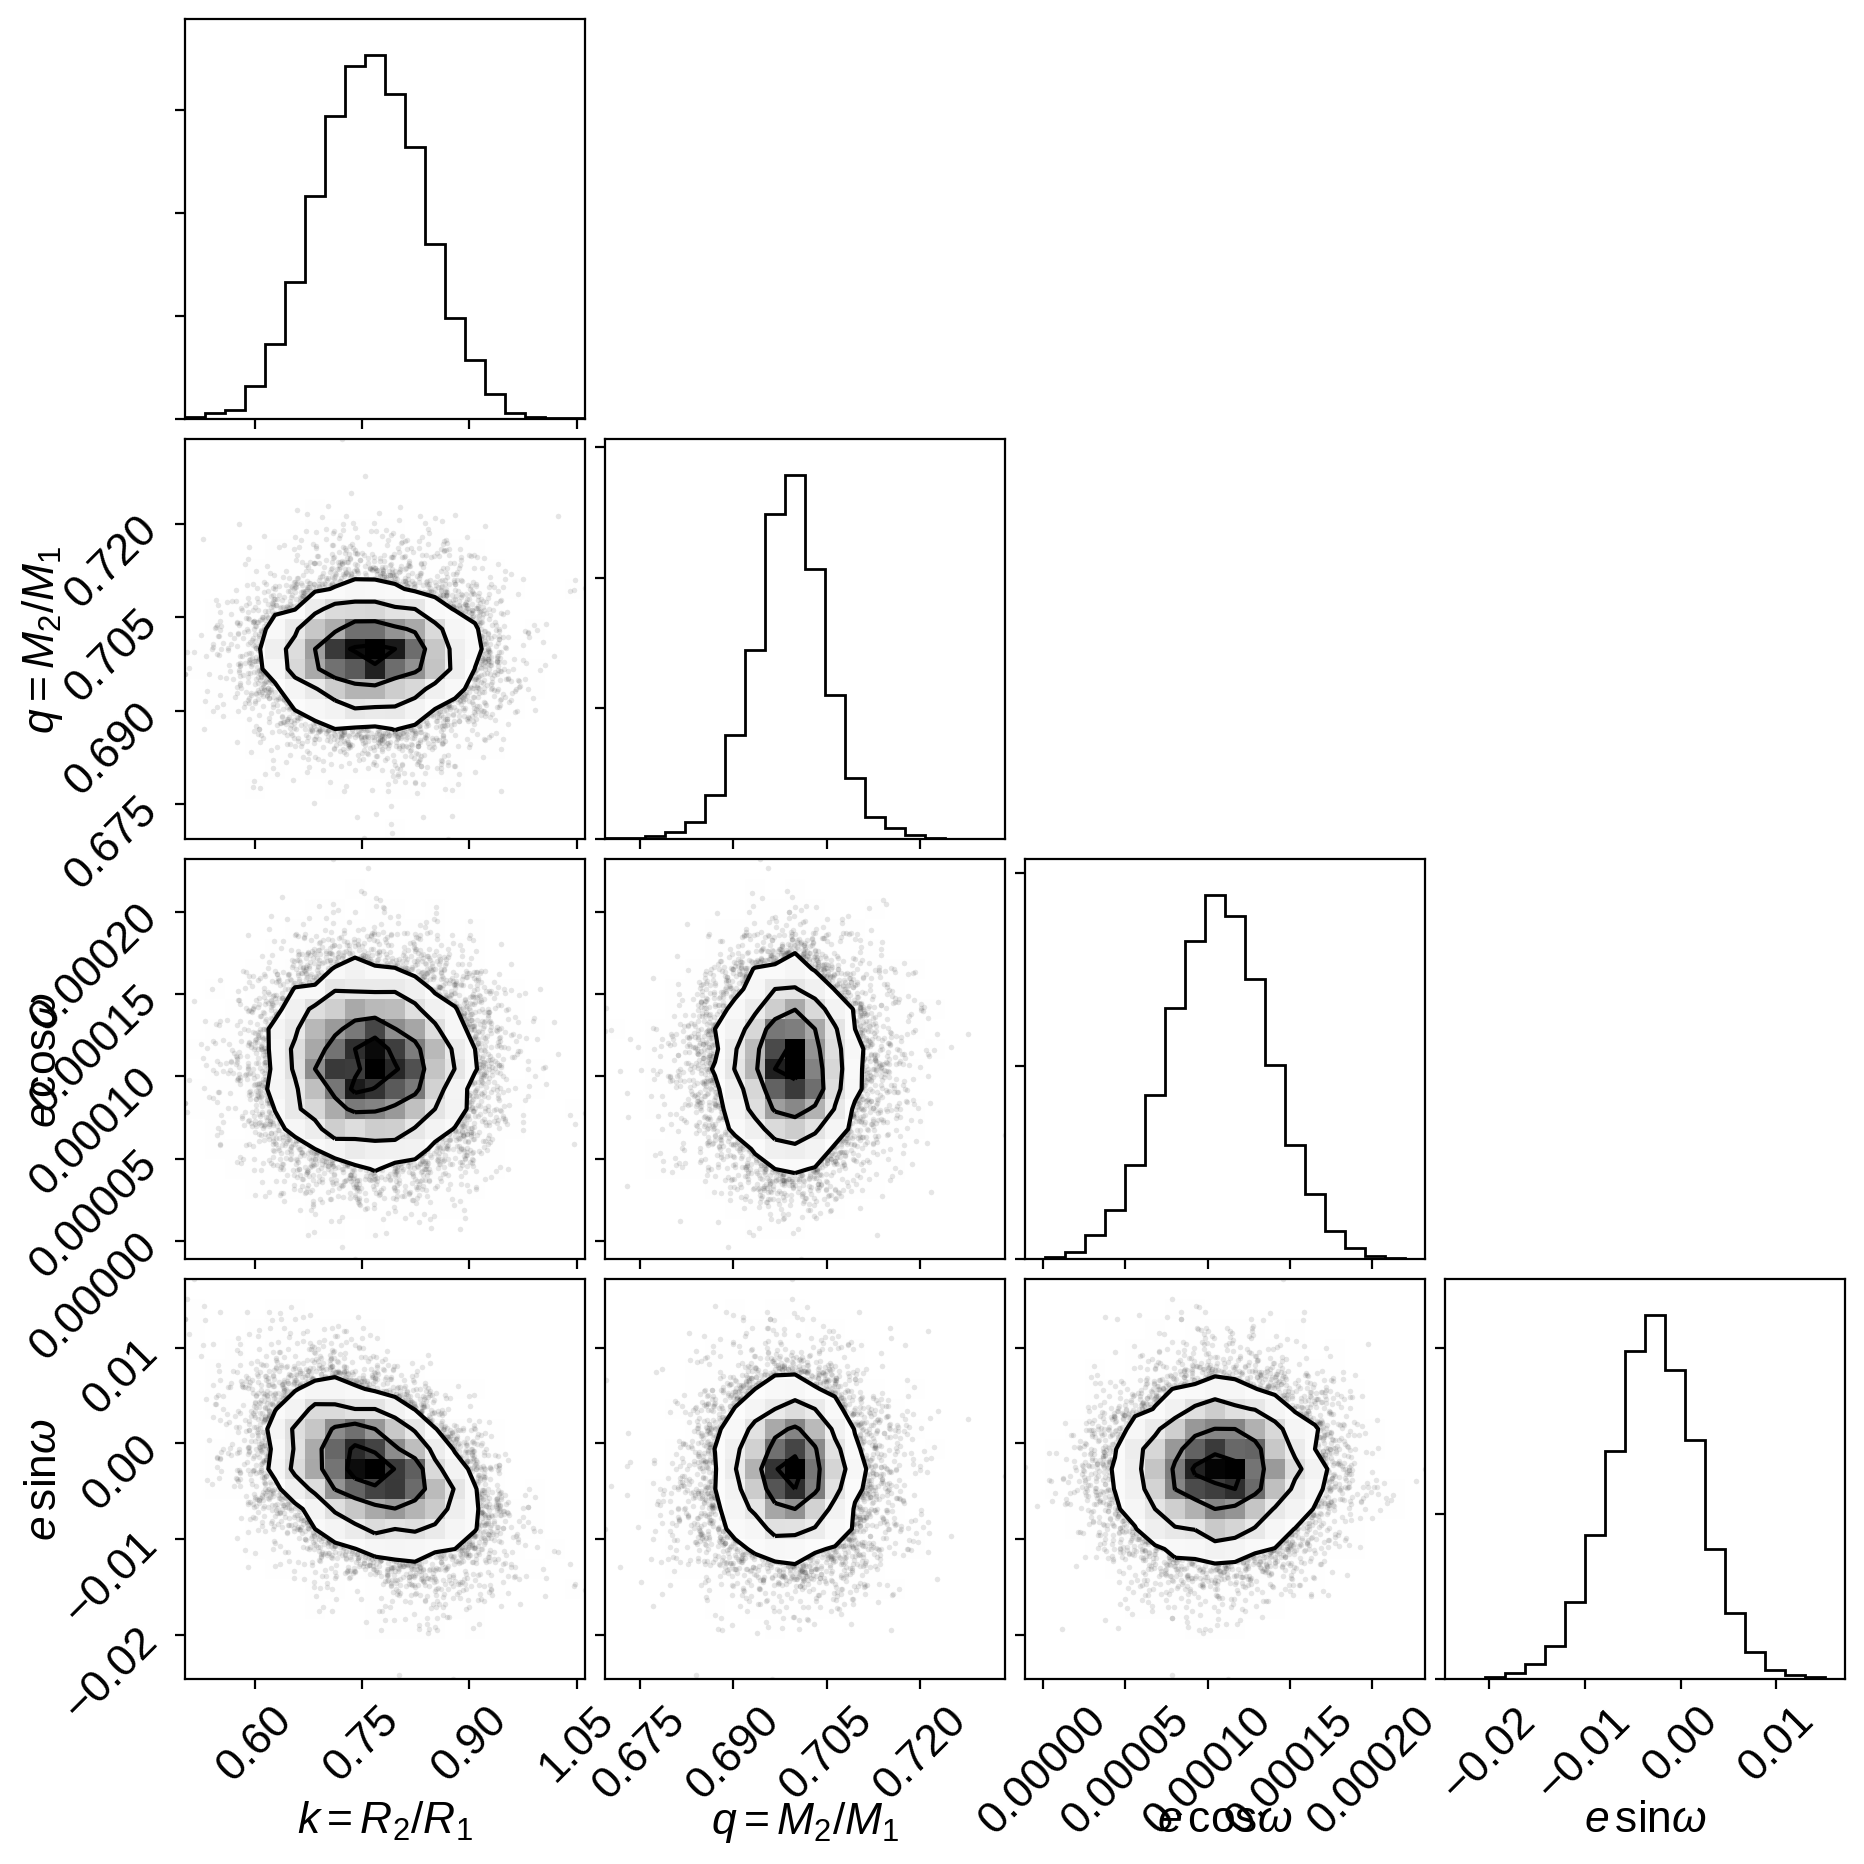

In [11]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["k", "q", "ecs"])
_ = corner.corner(
    samples,
    labels=["$k = R_2 / R_1$", "$q = M_2 / M_1$", "$e\,\cos\omega$", "$e\,\sin\omega$"],
)

And then we can look at the physical properties of the stars in the system.
In this figure, we're comparing to the results from [David+ (2016)](https://arxiv.org/abs/1602.01901).
We find that the radius of the primary is marginally inconsistent with the [David+ (2016)](https://arxiv.org/abs/1602.01901) measurement, but more consistent with other estimates from the literature (that are overplotted in different colors).

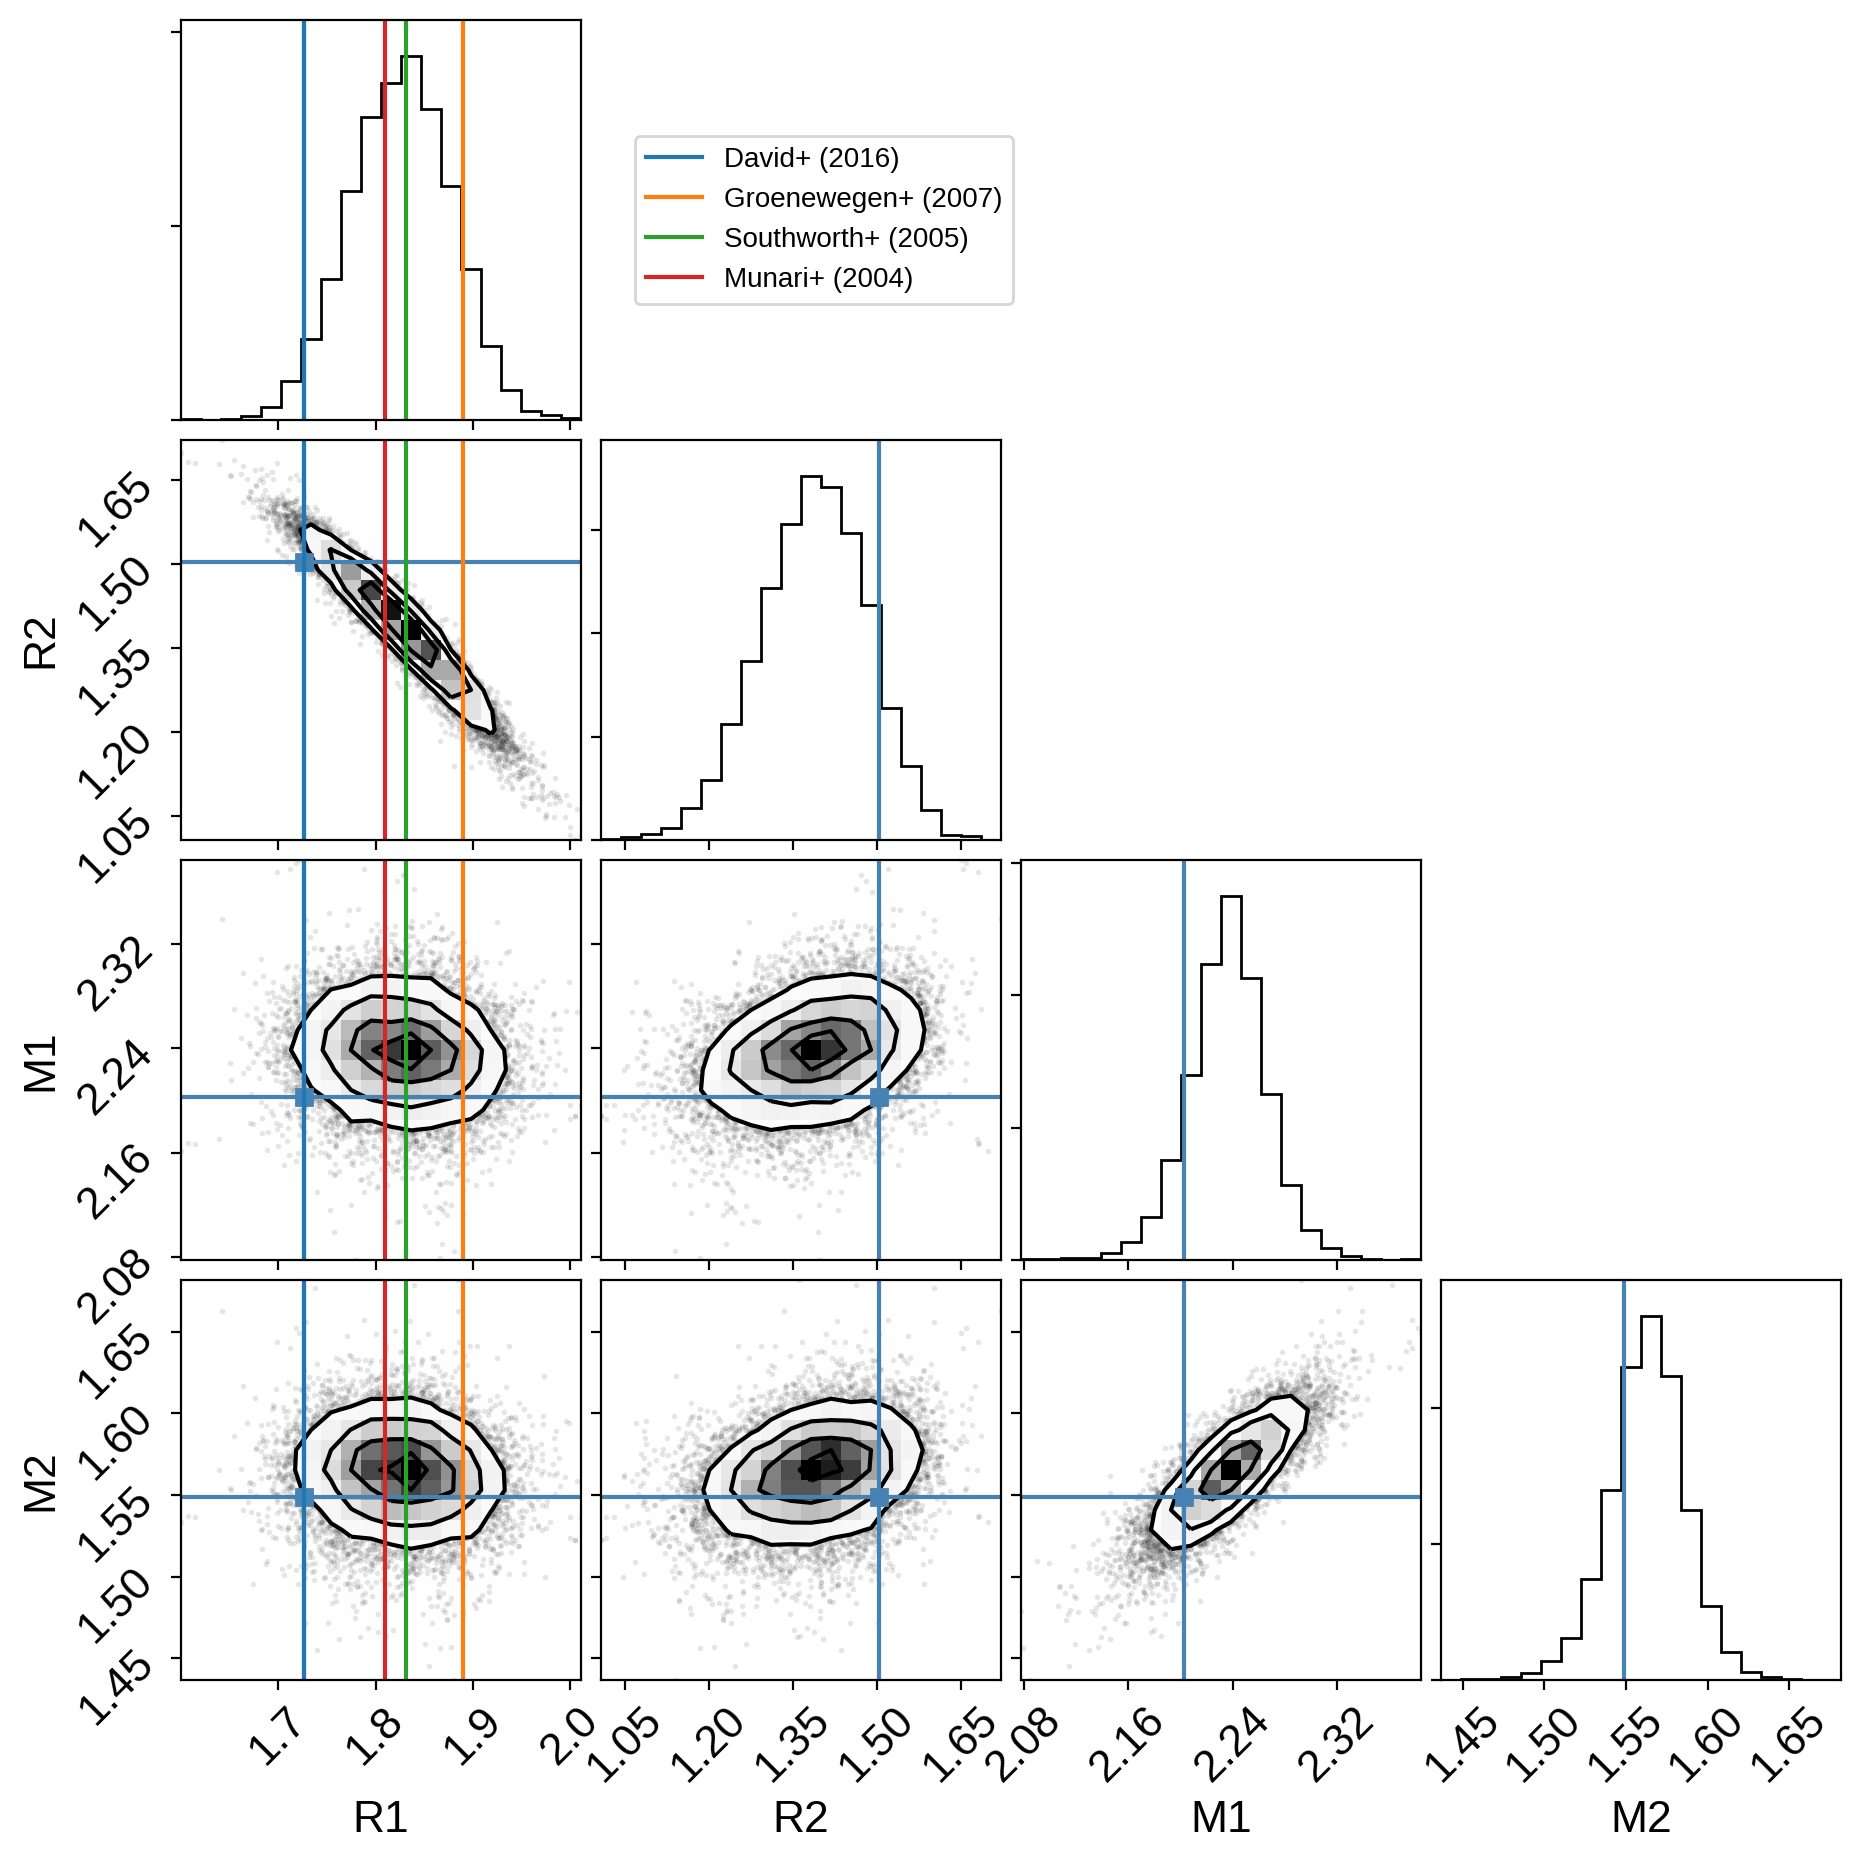

In [12]:
samples = pm.trace_to_dataframe(trace, varnames=["R1", "R2", "M1", "M2"])
fig = corner.corner(samples, truths=[1.727, 1.503, 2.203, 1.5488])

for ax in np.reshape(fig.axes, (4, 4))[:, 0]:
    ax.axvline(1.727, color="C0", label="David+ (2016)")
    ax.axvline(1.890, color="C1", label="Groenewegen+ (2007)")
    ax.axvline(1.831, color="C2", label="Southworth+ (2005)")
    ax.axvline(1.81, color="C3", label="Munari+ (2004)")

_ = fig.axes[0].legend(fontsize=10, loc="center left", bbox_to_anchor=(1.1, 0.5))

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [13]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [14]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
